In [1]:
import gym
from gym import spaces
import numpy as np

class TrafficGenerator(gym.Env):   
    def __init__(self):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,2), dtype=int)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        
        self.dataType = [0, 1, 2]
        self.arrival_rate = [0.3, 0.25, 0.4]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = 0
        
        # Initialize the queues
        self.queues = [[-1], [-1], [-1]]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        print("=====Action==== is", action)
        print(self.queues)
        #packet generator
        for i in range(len(self.packetInfo)):
            for sublist in self.packetInfo:
                if sublist[0] == i and np.random.uniform() < sublist[1]:
                    self.queues[i].append(self.packet)
                    print("Appending to queue", i)
        
        for i in range(len(self.queues)):
            for j in range(len(self.queues[i])):
                self.queues[i][j] -= self.timeslot
                
        
        # services the queues
        #for i in range(len(self.queues)):
            #print("queue ", i, ": has a length of", len(self.queues[i]))
        #print("ACTION queue ", action, ": has a length of", len(self.queues[action]))
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)
            for i in range(len(self.queues[action])):
                self.queues[action][i] -= 1
      
        observation = []
        for i in range(len(self.mean_delay_req)):

            # Get the current queue for the packet type
            current_queue = self.queues[i]

            # Calculate the length and average waiting time of the current queue
            current_length = len(current_queue)
            current_waiting_time = np.average(current_queue) if current_length > 0 else 0.0
            #print(np.average(current_queue), current_length, current_waiting_time )
            
            
    
            observation.append([current_length, current_waiting_time])

        observation = np.array(observation)
        
        print(f"observation \n{observation}")
        print(observation[0][0], "and" , observation[1][0])
       
        """
        #Rewards Options
        if observation[0][1] < -4 and observation[0][0] != 0 :
            reward = 10
        elif observation[1][1] < -6 and observation[1][0] != 0:
            reward = 10
        else:
            reward = 1
        """
        
        if observation[0][0] > 0 or observation[1][0] > 0:
            reward = 30
            if observation[0][1] < -4:
                reward = -35
            elif observation[1][1] < -6:
                reward = -35
        if observation[0][0] == 0 or observation[1][0] == 0 or observation[2][0] == 0:
            reward = -100
        else:
            reward = 30
        

        info = {"mean_delay_0": self.mean_delay_req[0],
        "mean_delay_1": self.mean_delay_req[1],
        "mean_delay_2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        return observation, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.totaltime = 0
        self.queues = [[-1], [-1], [-1]]
        return np.array([[len(self.queues[i]), 0.0] for i in range(len(self.mean_delay_req))])
        
    def render(self):
        pass

env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    print(obs[:, 0])
    
    if obs[:, 0][0] > 0 or obs[:, 0][1] > 0:
        action = np.argmax(obs[:2, 0])
    else:
        action = 2 
    
    print("chosen", action)
    obs,reward, done, info = env.step(action)
    print("reward", reward)
    
    x = x +1

In [2]:
env = TrafficGenerator() 

# Training the DQN agent dude

In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [4]:
#states = env.observation_space.shape
states = (1,3,2)
actions = env.action_space.n

In [5]:
def build_model(states, actions):
    model = Sequential() 
    model.add(Flatten(input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    model.compile(optimizer=Adam(), loss='mse')
    print(states)
    
    return model

In [6]:
model = build_model(states, actions)


(1, 3, 2)


In [7]:
states

(1, 3, 2)

In [8]:
actions

3

In [9]:
def build_agent(model, actions, states):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
    return dqn

In [10]:
import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.9.0
Keras version: 2.9.0


In [11]:
optimizer = Adam(learning_rate=1e-3)
Adam._name = "adam"
dqn = build_agent(model, actions, states)
dqn.compile(optimizer, metrics=['mae'])
history = dqn.fit(env, nb_steps=10000, visualize=False, verbose=2, nb_max_episode_steps = 1000)

Training for 10000 steps ...
=====Action==== is 0
[[-1], [-1], [-1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 1. -1.]
 [ 2. -1.]
 [ 1. -2.]]
1.0 and 2.0
=====Action==== is 1
[[-1], [-2, 0], [-2]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -1. ]
 [ 2.  -1.5]
 [ 2.  -1.5]]
2.0 and 2.0
=====Action==== is 0
[[-2, 0], [-2, -1], [-3, 0]]
Appending to queue 1
observation 
[[ 1.         -2.        ]
 [ 3.         -1.66666667]
 [ 2.         -2.5       ]]
1.0 and 3.0
=====Action==== is 2
[[-2], [-3, -2, 0], [-4, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 2.  -1.5]
 [ 4.  -2. ]
 [ 1.  -3. ]]
2.0 and 4.0
=====Action==== is 0
[[-3, 0], [-4, -3, -1, 0], [-3]]
observation 
[[ 1. -2.]
 [ 4. -3.]
 [ 1. -4.]]
1.0 and 4.0
=====Action==== is 2
[[-2], [-5, -4, -2, -1], [-4]]
Appending to queue 1
observation 
[[ 1.  -3. ]
 [ 5.  -3.2]
 [ 0.   0. ]]
1.0 and 5.0
=====Action==== is 0
[[-3], [-6, -5, -3, -2, 0], []]
observation 
[[ 0. 

C:\Users\ahmed\anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


=====Action==== is 0
[[], [-27, -26, -24, -23, -21, -18, -14, -13, -9, -8, -1], [-14, -13, -9, -8, -4, 0]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [ 11.         -17.72727273]
 [  7.          -7.71428571]]
0.0 and 11.0
=====Action==== is 0
[[], [-28, -27, -25, -24, -22, -19, -15, -14, -10, -9, -2], [-15, -14, -10, -9, -5, -1, 0]]
observation 
[[  0.           0.        ]
 [ 11.         -18.72727273]
 [  7.          -8.71428571]]
0.0 and 11.0
=====Action==== is 0
[[], [-29, -28, -26, -25, -23, -20, -16, -15, -11, -10, -3], [-16, -15, -11, -10, -6, -2, -1]]
observation 
[[  0.           0.        ]
 [ 11.         -19.72727273]
 [  7.          -9.71428571]]
0.0 and 11.0
=====Action==== is 0
[[], [-30, -29, -27, -26, -24, -21, -17, -16, -12, -11, -4], [-17, -16, -12, -11, -7, -3, -2]]
observation 
[[  0.           0.        ]
 [ 11.         -20.72727273]
 [  7.         -10.71428571]]
0.0 and 11.0
=====Action==== is 0
[[], [-31, -30, -28, -27, -25, -22, -18, -17, -13,

=====Action==== is 0
[[], [-64, -63, -61, -60, -58, -55, -51, -50, -46, -45, -38, -32, -29, -27, -23, -22, -19, -14, -9, -7, -5, -4, -2], [-51, -47, -46, -42, -38, -37, -30, -26, -22, -20, -19, -18, -17, -15, -14, -13, -11, -7, -6, -5, -3]]
observation 
[[  0.           0.        ]
 [ 23.         -35.08695652]
 [ 21.         -24.19047619]]
0.0 and 23.0
=====Action==== is 0
[[], [-65, -64, -62, -61, -59, -56, -52, -51, -47, -46, -39, -33, -30, -28, -24, -23, -20, -15, -10, -8, -6, -5, -3], [-52, -48, -47, -43, -39, -38, -31, -27, -23, -21, -20, -19, -18, -16, -15, -14, -12, -8, -7, -6, -4]]
observation 
[[  0.           0.        ]
 [ 23.         -36.08695652]
 [ 21.         -25.19047619]]
0.0 and 23.0
=====Action==== is 0
[[], [-66, -65, -63, -62, -60, -57, -53, -52, -48, -47, -40, -34, -31, -29, -25, -24, -21, -16, -11, -9, -7, -6, -4], [-53, -49, -48, -44, -40, -39, -32, -28, -24, -22, -21, -20, -19, -17, -16, -15, -13, -9, -8, -7, -5]]
observation 
[[  0.           0.        ]
 [ 23

=====Action==== is 0
[[], [-109, -108, -106, -105, -103, -100, -96, -95, -91, -90, -83, -77, -74, -72, -68, -67, -64, -59, -54, -52, -50, -49, -47, -31, -30, -25, -24, -22, -21, -20, -18, -14, -13, -12, -9, -8, -7, -5], [-96, -92, -91, -87, -83, -82, -75, -71, -67, -65, -64, -63, -62, -60, -59, -58, -56, -52, -51, -50, -48, -41, -40, -30, -26, -23, -21, -18, -16, -15, -14, -8, -7, -5, -4, -3, -2, 0]]
Appending to queue 1
observation 
[[  0.           0.        ]
 [ 39.         -54.25641026]
 [ 38.         -45.86842105]]
0.0 and 39.0
=====Action==== is 0
[[], [-110, -109, -107, -106, -104, -101, -97, -96, -92, -91, -84, -78, -75, -73, -69, -68, -65, -60, -55, -53, -51, -50, -48, -32, -31, -26, -25, -23, -22, -21, -19, -15, -14, -13, -10, -9, -8, -6, 0], [-97, -93, -92, -88, -84, -83, -76, -72, -68, -66, -65, -64, -63, -61, -60, -59, -57, -53, -52, -51, -49, -42, -41, -31, -27, -24, -22, -19, -17, -16, -15, -9, -8, -6, -5, -4, -3, -1]]
Appending to queue 2
observation 
[[  0.           0

0.0 and 50.0
=====Action==== is 0
[[], [-152, -151, -149, -148, -146, -143, -139, -138, -134, -133, -126, -120, -117, -115, -111, -110, -107, -102, -97, -95, -93, -92, -90, -74, -73, -68, -67, -65, -64, -63, -61, -57, -56, -55, -52, -51, -50, -48, -42, -30, -29, -26, -22, -17, -16, -14, -12, -7, -3, -2], [-139, -135, -134, -130, -126, -125, -118, -114, -110, -108, -107, -106, -105, -103, -102, -101, -99, -95, -94, -93, -91, -84, -83, -73, -69, -66, -64, -61, -59, -58, -57, -51, -50, -48, -47, -46, -45, -43, -41, -37, -35, -34, -32, -26, -17, -15, -11, -10, -9, -8, -4, -1, 0]]
Appending to queue 2
observation 
[[  0.     0.  ]
 [ 50.   -79.64]
 [ 54.   -68.  ]]
0.0 and 50.0
=====Action==== is 0
[[], [-153, -152, -150, -149, -147, -144, -140, -139, -135, -134, -127, -121, -118, -116, -112, -111, -108, -103, -98, -96, -94, -93, -91, -75, -74, -69, -68, -66, -65, -64, -62, -58, -57, -56, -53, -52, -51, -49, -43, -31, -30, -27, -23, -18, -17, -15, -13, -8, -4, -3], [-140, -136, -135, -131, 

=====Action==== is 0
[[], [-196, -195, -193, -192, -190, -187, -183, -182, -178, -177, -170, -164, -161, -159, -155, -154, -151, -146, -141, -139, -137, -136, -134, -118, -117, -112, -111, -109, -108, -107, -105, -101, -100, -99, -96, -95, -94, -92, -86, -74, -73, -70, -66, -61, -60, -58, -56, -51, -47, -46, -36, -35, -33, -28, -8, -6], [-183, -179, -178, -174, -170, -169, -162, -158, -154, -152, -151, -150, -149, -147, -146, -145, -143, -139, -138, -137, -135, -128, -127, -117, -113, -110, -108, -105, -103, -102, -101, -95, -94, -92, -91, -90, -89, -87, -85, -81, -79, -78, -76, -70, -61, -59, -55, -54, -53, -52, -48, -45, -44, -43, -39, -36, -32, -28, -27, -26, -23, -22, -20, -18, -17, -14, -13, -12, -11, -8, -4, -3, -2, -1]]
Appending to queue 2
observation 
[[   0.            0.        ]
 [  56.         -113.10714286]
 [  75.          -85.65333333]]
0.0 and 56.0
=====Action==== is 0
[[], [-197, -196, -194, -193, -191, -188, -184, -183, -179, -178, -171, -165, -162, -160, -156, -155,

 [  91.         -109.72527473]]
0.0 and 69.0
=====Action==== is 0
[[], [-240, -239, -237, -236, -234, -231, -227, -226, -222, -221, -214, -208, -205, -203, -199, -198, -195, -190, -185, -183, -181, -180, -178, -162, -161, -156, -155, -153, -152, -151, -149, -145, -144, -143, -140, -139, -138, -136, -130, -118, -117, -114, -110, -105, -104, -102, -100, -95, -91, -90, -80, -79, -77, -72, -52, -50, -42, -37, -36, -35, -31, -30, -29, -24, -22, -21, -16, -14, -2], [-227, -223, -222, -218, -214, -213, -206, -202, -198, -196, -195, -194, -193, -191, -190, -189, -187, -183, -182, -181, -179, -172, -171, -161, -157, -154, -152, -149, -147, -146, -145, -139, -138, -136, -135, -134, -133, -131, -129, -125, -123, -122, -120, -114, -105, -103, -99, -98, -97, -96, -92, -89, -88, -87, -83, -80, -76, -72, -71, -70, -67, -66, -64, -62, -61, -58, -57, -56, -55, -52, -48, -47, -46, -45, -43, -38, -35, -31, -30, -28, -25, -24, -23, -22, -18, -17, -15, -14, -11, -5, 0]]
Appending to queue 2
observation 
[[

 [ 104.         -133.32692308]]
0.0 and 79.0
=====Action==== is 0
[[], [-280, -279, -277, -276, -274, -271, -267, -266, -262, -261, -254, -248, -245, -243, -239, -238, -235, -230, -225, -223, -221, -220, -218, -202, -201, -196, -195, -193, -192, -191, -189, -185, -184, -183, -180, -179, -178, -176, -170, -158, -157, -154, -150, -145, -144, -142, -140, -135, -131, -130, -120, -119, -117, -112, -92, -90, -82, -77, -76, -75, -71, -70, -69, -64, -62, -61, -56, -54, -42, -35, -33, -32, -26, -25, -22, -14, -11, -5, -1], [-267, -263, -262, -258, -254, -253, -246, -242, -238, -236, -235, -234, -233, -231, -230, -229, -227, -223, -222, -221, -219, -212, -211, -201, -197, -194, -192, -189, -187, -186, -185, -179, -178, -176, -175, -174, -173, -171, -169, -165, -163, -162, -160, -154, -145, -143, -139, -138, -137, -136, -132, -129, -128, -127, -123, -120, -116, -112, -111, -110, -107, -106, -104, -102, -101, -98, -97, -96, -95, -92, -88, -87, -86, -85, -83, -78, -75, -71, -70, -68, -65, -64, -63,

=====Action==== is 0
[[], [-324, -323, -321, -320, -318, -315, -311, -310, -306, -305, -298, -292, -289, -287, -283, -282, -279, -274, -269, -267, -265, -264, -262, -246, -245, -240, -239, -237, -236, -235, -233, -229, -228, -227, -224, -223, -222, -220, -214, -202, -201, -198, -194, -189, -188, -186, -184, -179, -175, -174, -164, -163, -161, -156, -136, -134, -126, -121, -120, -119, -115, -114, -113, -108, -106, -105, -100, -98, -86, -79, -77, -76, -70, -69, -66, -58, -55, -49, -45, -41, -36, -20, -18, -17, -16, -15, -9, -5, -4, -2, -1, 0], [-311, -307, -306, -302, -298, -297, -290, -286, -282, -280, -279, -278, -277, -275, -274, -273, -271, -267, -266, -265, -263, -256, -255, -245, -241, -238, -236, -233, -231, -230, -229, -223, -222, -220, -219, -218, -217, -215, -213, -209, -207, -206, -204, -198, -189, -187, -183, -182, -181, -180, -176, -173, -172, -171, -167, -164, -160, -156, -155, -154, -151, -150, -148, -146, -145, -142, -141, -140, -139, -136, -132, -131, -130, -129, -127, -

=====Action==== is 0
[[], [-365, -364, -362, -361, -359, -356, -352, -351, -347, -346, -339, -333, -330, -328, -324, -323, -320, -315, -310, -308, -306, -305, -303, -287, -286, -281, -280, -278, -277, -276, -274, -270, -269, -268, -265, -264, -263, -261, -255, -243, -242, -239, -235, -230, -229, -227, -225, -220, -216, -215, -205, -204, -202, -197, -177, -175, -167, -162, -161, -160, -156, -155, -154, -149, -147, -146, -141, -139, -127, -120, -118, -117, -111, -110, -107, -99, -96, -90, -86, -82, -77, -61, -59, -58, -57, -56, -50, -46, -45, -43, -42, -41, -38, -32, -27, -23, -19, -6, -4, 0], [-352, -348, -347, -343, -339, -338, -331, -327, -323, -321, -320, -319, -318, -316, -315, -314, -312, -308, -307, -306, -304, -297, -296, -286, -282, -279, -277, -274, -272, -271, -270, -264, -263, -261, -260, -259, -258, -256, -254, -250, -248, -247, -245, -239, -230, -228, -224, -223, -222, -221, -217, -214, -213, -212, -208, -205, -201, -197, -196, -195, -192, -191, -189, -187, -186, -183, -182

 [ 157.         -189.08280255]]
0.0 and 109.0
=====Action==== is 0
[[], [-405, -404, -402, -401, -399, -396, -392, -391, -387, -386, -379, -373, -370, -368, -364, -363, -360, -355, -350, -348, -346, -345, -343, -327, -326, -321, -320, -318, -317, -316, -314, -310, -309, -308, -305, -304, -303, -301, -295, -283, -282, -279, -275, -270, -269, -267, -265, -260, -256, -255, -245, -244, -242, -237, -217, -215, -207, -202, -201, -200, -196, -195, -194, -189, -187, -186, -181, -179, -167, -160, -158, -157, -151, -150, -147, -139, -136, -130, -126, -122, -117, -101, -99, -98, -97, -96, -90, -86, -85, -83, -82, -81, -78, -72, -67, -63, -59, -46, -44, -40, -35, -30, -29, -22, -14, -12, -7, -2, -1], [-392, -388, -387, -383, -379, -378, -371, -367, -363, -361, -360, -359, -358, -356, -355, -354, -352, -348, -347, -346, -344, -337, -336, -326, -322, -319, -317, -314, -312, -311, -310, -304, -303, -301, -300, -299, -298, -296, -294, -290, -288, -287, -285, -279, -270, -268, -264, -263, -262, -261, -

observation 
[[   0.            0.        ]
 [ 118.         -237.83050847]
 [ 167.         -214.49101796]]
0.0 and 118.0
=====Action==== is 0
[[], [-443, -442, -440, -439, -437, -434, -430, -429, -425, -424, -417, -411, -408, -406, -402, -401, -398, -393, -388, -386, -384, -383, -381, -365, -364, -359, -358, -356, -355, -354, -352, -348, -347, -346, -343, -342, -341, -339, -333, -321, -320, -317, -313, -308, -307, -305, -303, -298, -294, -293, -283, -282, -280, -275, -255, -253, -245, -240, -239, -238, -234, -233, -232, -227, -225, -224, -219, -217, -205, -198, -196, -195, -189, -188, -185, -177, -174, -168, -164, -160, -155, -139, -137, -136, -135, -134, -128, -124, -123, -121, -120, -119, -116, -110, -105, -101, -97, -84, -82, -78, -73, -68, -67, -60, -52, -50, -45, -40, -39, -31, -26, -22, -20, -19, -13, -10, -3, 0], [-430, -426, -425, -421, -417, -416, -409, -405, -401, -399, -398, -397, -396, -394, -393, -392, -390, -386, -385, -384, -382, -375, -374, -364, -360, -357, -355, -352,

=====Action==== is 0
[[], [-481, -480, -478, -477, -475, -472, -468, -467, -463, -462, -455, -449, -446, -444, -440, -439, -436, -431, -426, -424, -422, -421, -419, -403, -402, -397, -396, -394, -393, -392, -390, -386, -385, -384, -381, -380, -379, -377, -371, -359, -358, -355, -351, -346, -345, -343, -341, -336, -332, -331, -321, -320, -318, -313, -293, -291, -283, -278, -277, -276, -272, -271, -270, -265, -263, -262, -257, -255, -243, -236, -234, -233, -227, -226, -223, -215, -212, -206, -202, -198, -193, -177, -175, -174, -173, -172, -166, -162, -161, -159, -158, -157, -154, -148, -143, -139, -135, -122, -120, -116, -111, -106, -105, -98, -90, -88, -83, -78, -77, -69, -64, -60, -58, -57, -51, -48, -41, -38, -37, -33, -31, -29, -28, -17, -13, -7], [-468, -464, -463, -459, -455, -454, -447, -443, -439, -437, -436, -435, -434, -432, -431, -430, -428, -424, -423, -422, -420, -413, -412, -402, -398, -395, -393, -390, -388, -387, -386, -380, -379, -377, -376, -375, -374, -372, -370, -366,

=====Action==== is 0
[[], [-523, -522, -520, -519, -517, -514, -510, -509, -505, -504, -497, -491, -488, -486, -482, -481, -478, -473, -468, -466, -464, -463, -461, -445, -444, -439, -438, -436, -435, -434, -432, -428, -427, -426, -423, -422, -421, -419, -413, -401, -400, -397, -393, -388, -387, -385, -383, -378, -374, -373, -363, -362, -360, -355, -335, -333, -325, -320, -319, -318, -314, -313, -312, -307, -305, -304, -299, -297, -285, -278, -276, -275, -269, -268, -265, -257, -254, -248, -244, -240, -235, -219, -217, -216, -215, -214, -208, -204, -203, -201, -200, -199, -196, -190, -185, -181, -177, -164, -162, -158, -153, -148, -147, -140, -132, -130, -125, -120, -119, -111, -106, -102, -100, -99, -93, -90, -83, -80, -79, -75, -73, -71, -70, -59, -55, -49, -40, -38, -32, -31, -28, -25, -22, -14, -13, -10, -9, -5, -3], [-510, -506, -505, -501, -497, -496, -489, -485, -481, -479, -478, -477, -476, -474, -473, -472, -470, -466, -465, -464, -462, -455, -454, -444, -440, -437, -435, -432

=====Action==== is 0
[[], [-567, -566, -564, -563, -561, -558, -554, -553, -549, -548, -541, -535, -532, -530, -526, -525, -522, -517, -512, -510, -508, -507, -505, -489, -488, -483, -482, -480, -479, -478, -476, -472, -471, -470, -467, -466, -465, -463, -457, -445, -444, -441, -437, -432, -431, -429, -427, -422, -418, -417, -407, -406, -404, -399, -379, -377, -369, -364, -363, -362, -358, -357, -356, -351, -349, -348, -343, -341, -329, -322, -320, -319, -313, -312, -309, -301, -298, -292, -288, -284, -279, -263, -261, -260, -259, -258, -252, -248, -247, -245, -244, -243, -240, -234, -229, -225, -221, -208, -206, -202, -197, -192, -191, -184, -176, -174, -169, -164, -163, -155, -150, -146, -144, -143, -137, -134, -127, -124, -123, -119, -117, -115, -114, -103, -99, -93, -84, -82, -76, -75, -72, -69, -66, -58, -57, -54, -53, -49, -47, -38, -34, -30, -23, -19, -18, -13, -11, -2, -1], [-554, -550, -549, -545, -541, -540, -533, -529, -525, -523, -522, -521, -520, -518, -517, -516, -514, -5

=====Action==== is 0
[[], [-607, -606, -604, -603, -601, -598, -594, -593, -589, -588, -581, -575, -572, -570, -566, -565, -562, -557, -552, -550, -548, -547, -545, -529, -528, -523, -522, -520, -519, -518, -516, -512, -511, -510, -507, -506, -505, -503, -497, -485, -484, -481, -477, -472, -471, -469, -467, -462, -458, -457, -447, -446, -444, -439, -419, -417, -409, -404, -403, -402, -398, -397, -396, -391, -389, -388, -383, -381, -369, -362, -360, -359, -353, -352, -349, -341, -338, -332, -328, -324, -319, -303, -301, -300, -299, -298, -292, -288, -287, -285, -284, -283, -280, -274, -269, -265, -261, -248, -246, -242, -237, -232, -231, -224, -216, -214, -209, -204, -203, -195, -190, -186, -184, -183, -177, -174, -167, -164, -163, -159, -157, -155, -154, -143, -139, -133, -124, -122, -116, -115, -112, -109, -106, -98, -97, -94, -93, -89, -87, -78, -74, -70, -63, -59, -58, -53, -51, -42, -41, -35, -30, -28, -27, -25, -19, -18, -9, -5], [-594, -590, -589, -585, -581, -580, -573, -569, -5

0.0 and 169.0
=====Action==== is 0
[[], [-647, -646, -644, -643, -641, -638, -634, -633, -629, -628, -621, -615, -612, -610, -606, -605, -602, -597, -592, -590, -588, -587, -585, -569, -568, -563, -562, -560, -559, -558, -556, -552, -551, -550, -547, -546, -545, -543, -537, -525, -524, -521, -517, -512, -511, -509, -507, -502, -498, -497, -487, -486, -484, -479, -459, -457, -449, -444, -443, -442, -438, -437, -436, -431, -429, -428, -423, -421, -409, -402, -400, -399, -393, -392, -389, -381, -378, -372, -368, -364, -359, -343, -341, -340, -339, -338, -332, -328, -327, -325, -324, -323, -320, -314, -309, -305, -301, -288, -286, -282, -277, -272, -271, -264, -256, -254, -249, -244, -243, -235, -230, -226, -224, -223, -217, -214, -207, -204, -203, -199, -197, -195, -194, -183, -179, -173, -164, -162, -156, -155, -152, -149, -146, -138, -137, -134, -133, -129, -127, -118, -114, -110, -103, -99, -98, -93, -91, -82, -81, -75, -70, -68, -67, -65, -59, -58, -49, -45, -36, -34, -33, -28, -27, -

=====Action==== is 0
[[], [-691, -690, -688, -687, -685, -682, -678, -677, -673, -672, -665, -659, -656, -654, -650, -649, -646, -641, -636, -634, -632, -631, -629, -613, -612, -607, -606, -604, -603, -602, -600, -596, -595, -594, -591, -590, -589, -587, -581, -569, -568, -565, -561, -556, -555, -553, -551, -546, -542, -541, -531, -530, -528, -523, -503, -501, -493, -488, -487, -486, -482, -481, -480, -475, -473, -472, -467, -465, -453, -446, -444, -443, -437, -436, -433, -425, -422, -416, -412, -408, -403, -387, -385, -384, -383, -382, -376, -372, -371, -369, -368, -367, -364, -358, -353, -349, -345, -332, -330, -326, -321, -316, -315, -308, -300, -298, -293, -288, -287, -279, -274, -270, -268, -267, -261, -258, -251, -248, -247, -243, -241, -239, -238, -227, -223, -217, -208, -206, -200, -199, -196, -193, -190, -182, -181, -178, -177, -173, -171, -162, -158, -154, -147, -143, -142, -137, -135, -126, -125, -119, -114, -112, -111, -109, -103, -102, -93, -89, -80, -78, -77, -72, -71, -6

[[], [-727, -726, -724, -723, -721, -718, -714, -713, -709, -708, -701, -695, -692, -690, -686, -685, -682, -677, -672, -670, -668, -667, -665, -649, -648, -643, -642, -640, -639, -638, -636, -632, -631, -630, -627, -626, -625, -623, -617, -605, -604, -601, -597, -592, -591, -589, -587, -582, -578, -577, -567, -566, -564, -559, -539, -537, -529, -524, -523, -522, -518, -517, -516, -511, -509, -508, -503, -501, -489, -482, -480, -479, -473, -472, -469, -461, -458, -452, -448, -444, -439, -423, -421, -420, -419, -418, -412, -408, -407, -405, -404, -403, -400, -394, -389, -385, -381, -368, -366, -362, -357, -352, -351, -344, -336, -334, -329, -324, -323, -315, -310, -306, -304, -303, -297, -294, -287, -284, -283, -279, -277, -275, -274, -263, -259, -253, -244, -242, -236, -235, -232, -229, -226, -218, -217, -214, -213, -209, -207, -198, -194, -190, -183, -179, -178, -173, -171, -162, -161, -155, -150, -148, -147, -145, -139, -138, -129, -125, -116, -114, -113, -108, -107, -104, -101, -99,

=====Action==== is 0
[[], [-768, -767, -765, -764, -762, -759, -755, -754, -750, -749, -742, -736, -733, -731, -727, -726, -723, -718, -713, -711, -709, -708, -706, -690, -689, -684, -683, -681, -680, -679, -677, -673, -672, -671, -668, -667, -666, -664, -658, -646, -645, -642, -638, -633, -632, -630, -628, -623, -619, -618, -608, -607, -605, -600, -580, -578, -570, -565, -564, -563, -559, -558, -557, -552, -550, -549, -544, -542, -530, -523, -521, -520, -514, -513, -510, -502, -499, -493, -489, -485, -480, -464, -462, -461, -460, -459, -453, -449, -448, -446, -445, -444, -441, -435, -430, -426, -422, -409, -407, -403, -398, -393, -392, -385, -377, -375, -370, -365, -364, -356, -351, -347, -345, -344, -338, -335, -328, -325, -324, -320, -318, -316, -315, -304, -300, -294, -285, -283, -277, -276, -273, -270, -267, -259, -258, -255, -254, -250, -248, -239, -235, -231, -224, -220, -219, -214, -212, -203, -202, -196, -191, -189, -188, -186, -180, -179, -170, -166, -157, -155, -154, -149, -

 [ 304.         -395.87171053]]
0.0 and 220.0
=====Action==== is 0
[[], [-809, -808, -806, -805, -803, -800, -796, -795, -791, -790, -783, -777, -774, -772, -768, -767, -764, -759, -754, -752, -750, -749, -747, -731, -730, -725, -724, -722, -721, -720, -718, -714, -713, -712, -709, -708, -707, -705, -699, -687, -686, -683, -679, -674, -673, -671, -669, -664, -660, -659, -649, -648, -646, -641, -621, -619, -611, -606, -605, -604, -600, -599, -598, -593, -591, -590, -585, -583, -571, -564, -562, -561, -555, -554, -551, -543, -540, -534, -530, -526, -521, -505, -503, -502, -501, -500, -494, -490, -489, -487, -486, -485, -482, -476, -471, -467, -463, -450, -448, -444, -439, -434, -433, -426, -418, -416, -411, -406, -405, -397, -392, -388, -386, -385, -379, -376, -369, -366, -365, -361, -359, -357, -356, -345, -341, -335, -326, -324, -318, -317, -314, -311, -308, -300, -299, -296, -295, -291, -289, -280, -276, -272, -265, -261, -260, -255, -253, -244, -243, -237, -232, -230, -229, -227, -22

=====Action==== is 0
[[], [-847, -846, -844, -843, -841, -838, -834, -833, -829, -828, -821, -815, -812, -810, -806, -805, -802, -797, -792, -790, -788, -787, -785, -769, -768, -763, -762, -760, -759, -758, -756, -752, -751, -750, -747, -746, -745, -743, -737, -725, -724, -721, -717, -712, -711, -709, -707, -702, -698, -697, -687, -686, -684, -679, -659, -657, -649, -644, -643, -642, -638, -637, -636, -631, -629, -628, -623, -621, -609, -602, -600, -599, -593, -592, -589, -581, -578, -572, -568, -564, -559, -543, -541, -540, -539, -538, -532, -528, -527, -525, -524, -523, -520, -514, -509, -505, -501, -488, -486, -482, -477, -472, -471, -464, -456, -454, -449, -444, -443, -435, -430, -426, -424, -423, -417, -414, -407, -404, -403, -399, -397, -395, -394, -383, -379, -373, -364, -362, -356, -355, -352, -349, -346, -338, -337, -334, -333, -329, -327, -318, -314, -310, -303, -299, -298, -293, -291, -282, -281, -275, -270, -268, -267, -265, -259, -258, -249, -245, -236, -234, -233, -228, -

=====Action==== is 0
[[], [-884, -883, -881, -880, -878, -875, -871, -870, -866, -865, -858, -852, -849, -847, -843, -842, -839, -834, -829, -827, -825, -824, -822, -806, -805, -800, -799, -797, -796, -795, -793, -789, -788, -787, -784, -783, -782, -780, -774, -762, -761, -758, -754, -749, -748, -746, -744, -739, -735, -734, -724, -723, -721, -716, -696, -694, -686, -681, -680, -679, -675, -674, -673, -668, -666, -665, -660, -658, -646, -639, -637, -636, -630, -629, -626, -618, -615, -609, -605, -601, -596, -580, -578, -577, -576, -575, -569, -565, -564, -562, -561, -560, -557, -551, -546, -542, -538, -525, -523, -519, -514, -509, -508, -501, -493, -491, -486, -481, -480, -472, -467, -463, -461, -460, -454, -451, -444, -441, -440, -436, -434, -432, -431, -420, -416, -410, -401, -399, -393, -392, -389, -386, -383, -375, -374, -371, -370, -366, -364, -355, -351, -347, -340, -336, -335, -330, -328, -319, -318, -312, -307, -305, -304, -302, -296, -295, -286, -282, -273, -271, -270, -265, -

=====Action==== is 0
[[], [-921, -920, -918, -917, -915, -912, -908, -907, -903, -902, -895, -889, -886, -884, -880, -879, -876, -871, -866, -864, -862, -861, -859, -843, -842, -837, -836, -834, -833, -832, -830, -826, -825, -824, -821, -820, -819, -817, -811, -799, -798, -795, -791, -786, -785, -783, -781, -776, -772, -771, -761, -760, -758, -753, -733, -731, -723, -718, -717, -716, -712, -711, -710, -705, -703, -702, -697, -695, -683, -676, -674, -673, -667, -666, -663, -655, -652, -646, -642, -638, -633, -617, -615, -614, -613, -612, -606, -602, -601, -599, -598, -597, -594, -588, -583, -579, -575, -562, -560, -556, -551, -546, -545, -538, -530, -528, -523, -518, -517, -509, -504, -500, -498, -497, -491, -488, -481, -478, -477, -473, -471, -469, -468, -457, -453, -447, -438, -436, -430, -429, -426, -423, -420, -412, -411, -408, -407, -403, -401, -392, -388, -384, -377, -373, -372, -367, -365, -356, -355, -349, -344, -342, -341, -339, -333, -332, -323, -319, -310, -308, -307, -302, -

=====Action==== is 0
[[], [-965, -964, -962, -961, -959, -956, -952, -951, -947, -946, -939, -933, -930, -928, -924, -923, -920, -915, -910, -908, -906, -905, -903, -887, -886, -881, -880, -878, -877, -876, -874, -870, -869, -868, -865, -864, -863, -861, -855, -843, -842, -839, -835, -830, -829, -827, -825, -820, -816, -815, -805, -804, -802, -797, -777, -775, -767, -762, -761, -760, -756, -755, -754, -749, -747, -746, -741, -739, -727, -720, -718, -717, -711, -710, -707, -699, -696, -690, -686, -682, -677, -661, -659, -658, -657, -656, -650, -646, -645, -643, -642, -641, -638, -632, -627, -623, -619, -606, -604, -600, -595, -590, -589, -582, -574, -572, -567, -562, -561, -553, -548, -544, -542, -541, -535, -532, -525, -522, -521, -517, -515, -513, -512, -501, -497, -491, -482, -480, -474, -473, -470, -467, -464, -456, -455, -452, -451, -447, -445, -436, -432, -428, -421, -417, -416, -411, -409, -400, -399, -393, -388, -386, -385, -383, -377, -376, -367, -363, -354, -352, -351, -346, -

 1000/10000: episode: 1, duration: 4.679s, episode steps: 1000, steps per second: 214, episode reward: -99350.000, mean reward: -99.350 [-100.000, 30.000], mean action: 0.017 [0.000, 2.000],  loss: --, mae: --, mean_q: --
=====Action==== is 0
[[-1], [-1], [-1]]
observation 
[[ 0.  0.]
 [ 1. -2.]
 [ 1. -2.]]
0.0 and 1.0
=====Action==== is 1
[[], [-2], [-2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 1.   0. ]
 [ 0.   0. ]
 [ 2.  -1.5]]
1.0 and 0.0


C:\Users\ahmed\anaconda3\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


=====Action==== is 0
[[0], [], [-3, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 1.  -1. ]
 [ 1.   0. ]
 [ 2.  -2.5]]
1.0 and 1.0
=====Action==== is 0
[[-1], [0], [-4, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 0.          0.        ]
 [ 2.         -0.5       ]
 [ 3.         -2.33333333]]
0.0 and 2.0
=====Action==== is 1
[[], [-1, 0], [-5, -2, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 1.          0.        ]
 [ 2.         -1.5       ]
 [ 3.         -3.33333333]]
1.0 and 2.0
=====Action==== is 0
[[0], [-2, -1], [-6, -3, -1]]
Appending to queue 2
observation 
[[ 0.    0.  ]
 [ 2.   -2.5 ]
 [ 4.   -3.25]]
0.0 and 2.0
=====Action==== is 0
[[], [-3, -2], [-7, -4, -2, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 0.          0.        ]
 [ 3.         -2.33333333]
 [ 5.         -3.4       ]]
0.0 and 3.0
=====Action==== is 2
[[], [-4, -3, 0], [-8, -5, -3, -1, 0]]
Appending to queue 0
observation 
[[ 1

=====Action==== is 0
[[], [-49, -48, -45, -36, -34, -31, -24, -22, -20, -18, -8, -7, -5, -2], [0]]
observation 
[[  0.           0.        ]
 [ 14.         -25.92857143]
 [  1.          -1.        ]]
0.0 and 14.0
=====Action==== is 2
[[], [-50, -49, -46, -37, -35, -32, -25, -23, -21, -19, -9, -8, -6, -3], [-1]]
Appending to queue 0
observation 
[[  1.           0.        ]
 [ 14.         -26.92857143]
 [  0.           0.        ]]
1.0 and 14.0
=====Action==== is 2
[[0], [-51, -50, -47, -38, -36, -33, -26, -24, -22, -20, -10, -9, -7, -4], []]
Appending to queue 1
observation 
[[  1.          -1.        ]
 [ 15.         -26.06666667]
 [  0.           0.        ]]
1.0 and 15.0
=====Action==== is 2
[[-1], [-52, -51, -48, -39, -37, -34, -27, -25, -23, -21, -11, -10, -8, -5, 0], []]
observation 
[[  1.          -2.        ]
 [ 15.         -27.06666667]
 [  0.           0.        ]]
1.0 and 15.0
=====Action==== is 2
[[-2], [-53, -52, -49, -40, -38, -35, -28, -26, -24, -22, -12, -11, -9, -6, -

=====Action==== is 0
[[-23, -17, -14, -10], [-81, -80, -77, -68, -66, -63, -56, -54, -52, -50, -40, -39, -37, -34, -29, -22, -19, -18, -16, -6, -3, -2, -1], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[  4.         -12.        ]
 [ 23.         -40.69565217]
 [  2.          -1.        ]]
4.0 and 23.0
=====Action==== is 0
[[-19, -16, -12, -1], [-82, -81, -78, -69, -67, -64, -57, -55, -53, -51, -41, -40, -38, -35, -30, -23, -20, -19, -17, -7, -4, -3, -2], [-2, 0]]
Appending to queue 0
observation 
[[  4.          -9.        ]
 [ 23.         -41.69565217]
 [  2.          -2.        ]]
4.0 and 23.0
=====Action==== is 2
[[-18, -14, -3, -1], [-83, -82, -79, -70, -68, -65, -58, -56, -54, -52, -42, -41, -39, -36, -31, -24, -21, -20, -18, -8, -5, -4, -3], [-3, -1]]
observation 
[[  4.         -10.        ]
 [ 23.         -42.69565217]
 [  1.          -3.        ]]
4.0 and 23.0
=====Action==== is 2
[[-19, -15, -4, -2], [-84, -83, -80, -71, -69, -66, -59, -57, -55, -53, -43, -42,

=====Action==== is 2
[[-3], [-114, -113, -110, -101, -99, -96, -89, -87, -85, -83, -73, -72, -70, -67, -62, -55, -52, -51, -49, -39, -36, -35, -34, -27, -20, -16, -15, -14, -12, -5, -4, 0], [-7, -3, -1]]
observation 
[[  1.       -4.     ]
 [ 32.      -56.78125]
 [  2.       -4.     ]]
1.0 and 32.0
=====Action==== is 0
[[-4], [-115, -114, -111, -102, -100, -97, -90, -88, -86, -84, -74, -73, -71, -68, -63, -56, -53, -52, -50, -40, -37, -36, -35, -28, -21, -17, -16, -15, -13, -6, -5, -1], [-5, -3]]
observation 
[[  0.        0.     ]
 [ 32.      -57.78125]
 [  2.       -5.     ]]
0.0 and 32.0
=====Action==== is 2
[[], [-116, -115, -112, -103, -101, -98, -91, -89, -87, -85, -75, -74, -72, -69, -64, -57, -54, -53, -51, -41, -38, -37, -36, -29, -22, -18, -17, -16, -14, -7, -6, -2], [-6, -4]]
observation 
[[  0.        0.     ]
 [ 32.      -58.78125]
 [  1.       -6.     ]]
0.0 and 32.0
=====Action==== is 2
[[], [-117, -116, -113, -104, -102, -99, -92, -90, -88, -86, -76, -75, -73, -70, -65,

=====Action==== is 0
[[], [-144, -143, -140, -131, -129, -126, -119, -117, -115, -113, -103, -102, -100, -97, -92, -85, -82, -81, -79, -69, -66, -65, -64, -57, -50, -46, -45, -44, -42, -35, -34, -30, -26, -17, -13, -11, -10, -4], [-21, -19, -16, -14, -10, -8, -7, -5, -4, -3, -1]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [ 38.         -75.36842105]
 [ 12.          -9.91666667]]
0.0 and 38.0
=====Action==== is 0
[[], [-145, -144, -141, -132, -130, -127, -120, -118, -116, -114, -104, -103, -101, -98, -93, -86, -83, -82, -80, -70, -67, -66, -65, -58, -51, -47, -46, -45, -43, -36, -35, -31, -27, -18, -14, -12, -11, -5], [-22, -20, -17, -15, -11, -9, -8, -6, -5, -4, -2, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[  0.           0.        ]
 [ 38.         -76.36842105]
 [ 13.         -10.07692308]]
0.0 and 38.0
=====Action==== is 0
[[], [-146, -145, -142, -133, -131, -128, -121, -119, -117, -115, -105, -104, -102, -99, -94, -87, -84, -83, -81, -71, -68,

=====Action==== is 0
[[], [-176, -173, -164, -162, -159, -152, -150, -148, -146, -136, -135, -133, -130, -125, -118, -115, -114, -112, -102, -99, -98, -97, -90, -83, -79, -78, -77, -75, -68, -67, -63, -59, -50, -46, -44, -43, -37, -30, -29, -25, -21, -17, -9, -6, 0], [-53, -51, -48, -46, -42, -40, -39, -37, -36, -35, -33, -31, -30, -29, -26, -20, -19, -14, -13, -12, -11, -10, -6, -5, -4, -2, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  0.           0.        ]
 [ 46.         -88.80434783]
 [ 28.         -25.67857143]]
0.0 and 46.0
=====Action==== is 0
[[], [-177, -174, -165, -163, -160, -153, -151, -149, -147, -137, -136, -134, -131, -126, -119, -116, -115, -113, -103, -100, -99, -98, -91, -84, -80, -79, -78, -76, -69, -68, -64, -60, -51, -47, -45, -44, -38, -31, -30, -26, -22, -18, -10, -7, -1, 0], [-54, -52, -49, -47, -43, -41, -40, -38, -37, -36, -34, -32, -31, -30, -27, -21, -20, -15, -14, -13, -12, -11, -7, -6, -5, -3, -1, 0]]
observation 
[[

=====Action==== is 0
[[], [-189, -180, -178, -175, -168, -166, -164, -162, -152, -151, -149, -146, -141, -134, -131, -130, -128, -118, -115, -114, -113, -106, -99, -95, -94, -93, -91, -84, -83, -79, -75, -66, -62, -60, -59, -53, -46, -45, -41, -37, -33, -25, -22, -16, -15, -11, -9, -4], [-68, -66, -63, -61, -57, -55, -54, -52, -51, -50, -48, -46, -45, -44, -41, -35, -34, -29, -28, -27, -26, -25, -21, -20, -19, -17, -15, -14, -11, -9, -7, -6, -5]]
Appending to queue 0
observation 
[[  0.           0.        ]
 [ 48.         -96.97916667]
 [ 33.         -35.81818182]]
0.0 and 48.0
=====Action==== is 0
[[], [-190, -181, -179, -176, -169, -167, -165, -163, -153, -152, -150, -147, -142, -135, -132, -131, -129, -119, -116, -115, -114, -107, -100, -96, -95, -94, -92, -85, -84, -80, -76, -67, -63, -61, -60, -54, -47, -46, -42, -38, -34, -26, -23, -17, -16, -12, -10, -5], [-69, -67, -64, -62, -58, -56, -55, -53, -52, -51, -49, -47, -46, -45, -42, -36, -35, -30, -29, -28, -27, -26, -22, -21, -20

=====Action==== is 0
[[], [-206, -197, -195, -192, -185, -183, -181, -179, -169, -168, -166, -163, -158, -151, -148, -147, -145, -135, -132, -131, -130, -123, -116, -112, -111, -110, -108, -101, -100, -96, -92, -83, -79, -77, -76, -70, -63, -62, -58, -54, -50, -42, -39, -33, -32, -28, -26, -21, -11, -10, -8, -4], [-85, -83, -80, -78, -74, -72, -71, -69, -68, -67, -65, -63, -62, -61, -58, -52, -51, -46, -45, -44, -43, -42, -38, -37, -36, -34, -32, -31, -28, -26, -24, -23, -22, -15, -13, -3]]
Appending to queue 2
observation 
[[   0.            0.        ]
 [  52.         -105.92307692]
 [  37.          -48.02702703]]
0.0 and 52.0
=====Action==== is 0
[[], [-207, -198, -196, -193, -186, -184, -182, -180, -170, -169, -167, -164, -159, -152, -149, -148, -146, -136, -133, -132, -131, -124, -117, -113, -112, -111, -109, -102, -101, -97, -93, -84, -80, -78, -77, -71, -64, -63, -59, -55, -51, -43, -40, -34, -33, -29, -27, -22, -12, -11, -9, -5], [-86, -84, -81, -79, -75, -73, -72, -70, -69, -6

=====Action==== is 0
[[], [-221, -212, -210, -207, -200, -198, -196, -194, -184, -183, -181, -178, -173, -166, -163, -162, -160, -150, -147, -146, -145, -138, -131, -127, -126, -125, -123, -116, -115, -111, -107, -98, -94, -92, -91, -85, -78, -77, -73, -69, -65, -57, -54, -48, -47, -43, -41, -36, -26, -25, -23, -19, -10, -9, -8], [-100, -98, -95, -93, -89, -87, -86, -84, -83, -82, -80, -78, -77, -76, -73, -67, -66, -61, -60, -59, -58, -57, -53, -52, -51, -49, -47, -46, -43, -41, -39, -38, -37, -30, -28, -18, -14, -13, -12, -11, -4]]
observation 
[[   0.            0.        ]
 [  55.         -114.87272727]
 [  41.          -57.95121951]]
0.0 and 55.0
=====Action==== is 0
[[], [-222, -213, -211, -208, -201, -199, -197, -195, -185, -184, -182, -179, -174, -167, -164, -163, -161, -151, -148, -147, -146, -139, -132, -128, -127, -126, -124, -117, -116, -112, -108, -99, -95, -93, -92, -86, -79, -78, -74, -70, -66, -58, -55, -49, -48, -44, -42, -37, -27, -26, -24, -20, -11, -10, -9], [-101, -

 [  47.          -64.55319149]]
0.0 and 61.0
=====Action==== is 0
[[], [-237, -228, -226, -223, -216, -214, -212, -210, -200, -199, -197, -194, -189, -182, -179, -178, -176, -166, -163, -162, -161, -154, -147, -143, -142, -141, -139, -132, -131, -127, -123, -114, -110, -108, -107, -101, -94, -93, -89, -85, -81, -73, -70, -64, -63, -59, -57, -52, -42, -41, -39, -35, -26, -25, -24, -14, -8, -5, -4, -3, 0], [-116, -114, -111, -109, -105, -103, -102, -100, -99, -98, -96, -94, -93, -92, -89, -83, -82, -77, -76, -75, -74, -73, -69, -68, -67, -65, -63, -62, -59, -57, -55, -54, -53, -46, -44, -34, -30, -29, -28, -27, -20, -13, -10, -9, -6, -4, -1]]
observation 
[[   0.            0.        ]
 [  61.         -118.6557377 ]
 [  47.          -65.55319149]]
0.0 and 61.0
=====Action==== is 0
[[], [-238, -229, -227, -224, -217, -215, -213, -211, -201, -200, -198, -195, -190, -183, -180, -179, -177, -167, -164, -163, -162, -155, -148, -144, -143, -142, -140, -133, -132, -128, -124, -115, -111, -109, 

=====Action==== is 0
[[], [-253, -244, -242, -239, -232, -230, -228, -226, -216, -215, -213, -210, -205, -198, -195, -194, -192, -182, -179, -178, -177, -170, -163, -159, -158, -157, -155, -148, -147, -143, -139, -130, -126, -124, -123, -117, -110, -109, -105, -101, -97, -89, -86, -80, -79, -75, -73, -68, -58, -57, -55, -51, -42, -41, -40, -30, -24, -21, -20, -19, -16, -13, -8, -1, 0], [-132, -130, -127, -125, -121, -119, -118, -116, -115, -114, -112, -110, -109, -108, -105, -99, -98, -93, -92, -91, -90, -89, -85, -84, -83, -81, -79, -78, -75, -73, -71, -70, -69, -62, -60, -50, -46, -45, -44, -43, -36, -29, -26, -25, -22, -20, -17, -14, -13, -12, -10, -9, -7, -4, -2, 0]]
Appending to queue 1
observation 
[[   0.            0.        ]
 [  66.         -124.84848485]
 [  56.          -69.875     ]]
0.0 and 66.0
=====Action==== is 1
[[], [-254, -245, -243, -240, -233, -231, -229, -227, -217, -216, -214, -211, -206, -199, -196, -195, -193, -183, -180, -179, -178, -171, -164, -160, -159, -1

=====Action==== is 0
[[], [-250, -248, -246, -236, -235, -233, -230, -225, -218, -215, -214, -212, -202, -199, -198, -197, -190, -183, -179, -178, -177, -175, -168, -167, -163, -159, -150, -146, -144, -143, -137, -130, -129, -125, -121, -117, -109, -106, -100, -99, -95, -93, -88, -78, -77, -75, -71, -62, -61, -60, -50, -44, -41, -40, -39, -36, -33, -28, -21, -20, -19, -8], [-147, -145, -142, -140, -136, -134, -133, -131, -130, -129, -127, -125, -124, -123, -120, -114, -113, -108, -107, -106, -105, -104, -100, -99, -98, -96, -94, -93, -90, -88, -86, -85, -84, -77, -75, -65, -61, -60, -59, -58, -51, -44, -41, -40, -37, -35, -32, -29, -28, -27, -25, -24, -22, -19, -17, -15, -13, -12, -11, -10, -9, -8, -7, -4, -1, 0]]
observation 
[[   0.            0.        ]
 [  62.         -133.12903226]
 [  66.          -73.3030303 ]]
0.0 and 62.0
=====Action==== is 0
[[], [-251, -249, -247, -237, -236, -234, -231, -226, -219, -216, -215, -213, -203, -200, -199, -198, -191, -184, -180, -179, -178, -17

=====Action==== is 0
[[], [-264, -254, -253, -251, -248, -243, -236, -233, -232, -230, -220, -217, -216, -215, -208, -201, -197, -196, -195, -193, -186, -185, -181, -177, -168, -164, -162, -161, -155, -148, -147, -143, -139, -135, -127, -124, -118, -117, -113, -111, -106, -96, -95, -93, -89, -80, -79, -78, -68, -62, -59, -58, -57, -54, -51, -46, -39, -38, -37, -26], [-163, -161, -158, -156, -152, -150, -149, -147, -146, -145, -143, -141, -140, -139, -136, -130, -129, -124, -123, -122, -121, -120, -116, -115, -114, -112, -110, -109, -106, -104, -102, -101, -100, -93, -91, -81, -77, -76, -75, -74, -67, -60, -57, -56, -53, -51, -48, -45, -44, -43, -41, -40, -38, -35, -33, -31, -29, -28, -27, -26, -25, -24, -23, -20, -17, -16, -11, -9, -8, -6, -5, -4]]
observation 
[[   0.            0.        ]
 [  60.         -147.23333333]
 [  72.          -82.54166667]]
0.0 and 60.0
=====Action==== is 0
[[], [-265, -255, -254, -252, -249, -244, -237, -234, -233, -231, -221, -218, -217, -216, -209, -202

 [  76.          -88.97368421]]
0.0 and 65.0
=====Action==== is 0
[[], [-276, -266, -265, -263, -260, -255, -248, -245, -244, -242, -232, -229, -228, -227, -220, -213, -209, -208, -207, -205, -198, -197, -193, -189, -180, -176, -174, -173, -167, -160, -159, -155, -151, -147, -139, -136, -130, -129, -125, -123, -118, -108, -107, -105, -101, -92, -91, -90, -80, -74, -71, -70, -69, -66, -63, -58, -51, -50, -49, -38, -6, -5, -2, -1, 0], [-175, -173, -170, -168, -164, -162, -161, -159, -158, -157, -155, -153, -152, -151, -148, -142, -141, -136, -135, -134, -133, -132, -128, -127, -126, -124, -122, -121, -118, -116, -114, -113, -112, -105, -103, -93, -89, -88, -87, -86, -79, -72, -69, -68, -65, -63, -60, -57, -56, -55, -53, -52, -50, -47, -45, -43, -41, -40, -39, -38, -37, -36, -35, -32, -29, -28, -23, -21, -20, -18, -17, -16, -10, -9, -8, 0]]
Appending to queue 2
observation 
[[   0.            0.        ]
 [  65.         -147.27692308]
 [  77.          -88.80519481]]
0.0 and 65.0
=====Acti

=====Action==== is 0
[[], [-288, -278, -277, -275, -272, -267, -260, -257, -256, -254, -244, -241, -240, -239, -232, -225, -221, -220, -219, -217, -210, -209, -205, -201, -192, -188, -186, -185, -179, -172, -171, -167, -163, -159, -151, -148, -142, -141, -137, -135, -130, -120, -119, -117, -113, -104, -103, -102, -92, -86, -83, -82, -81, -78, -75, -70, -63, -62, -61, -50, -18, -17, -14, -13, -12, -8, -5, -4], [-187, -185, -182, -180, -176, -174, -173, -171, -170, -169, -167, -165, -164, -163, -160, -154, -153, -148, -147, -146, -145, -144, -140, -139, -138, -136, -134, -133, -130, -128, -126, -125, -124, -117, -115, -105, -101, -100, -99, -98, -91, -84, -81, -80, -77, -75, -72, -69, -68, -67, -65, -64, -62, -59, -57, -55, -53, -52, -51, -50, -49, -48, -47, -44, -41, -40, -35, -33, -32, -30, -29, -28, -22, -21, -20, -12, -11, -10, -9, -8, -7, -6, -2, 0]]
observation 
[[   0.            0.        ]
 [  68.         -152.54411765]
 [  84.          -92.98809524]]
0.0 and 68.0
=====Action===

Appending to queue 2
observation 
[[   0.            0.        ]
 [  71.         -156.81690141]
 [  89.          -98.49438202]]
0.0 and 71.0
=====Action==== is 0
[[], [-300, -290, -289, -287, -284, -279, -272, -269, -268, -266, -256, -253, -252, -251, -244, -237, -233, -232, -231, -229, -222, -221, -217, -213, -204, -200, -198, -197, -191, -184, -183, -179, -175, -171, -163, -160, -154, -153, -149, -147, -142, -132, -131, -129, -125, -116, -115, -114, -104, -98, -95, -94, -93, -90, -87, -82, -75, -74, -73, -62, -30, -29, -26, -25, -24, -20, -17, -16, -8, -4, -1], [-199, -197, -194, -192, -188, -186, -185, -183, -182, -181, -179, -177, -176, -175, -172, -166, -165, -160, -159, -158, -157, -156, -152, -151, -150, -148, -146, -145, -142, -140, -138, -137, -136, -129, -127, -117, -113, -112, -111, -110, -103, -96, -93, -92, -89, -87, -84, -81, -80, -79, -77, -76, -74, -71, -69, -67, -65, -64, -63, -62, -61, -60, -59, -56, -53, -52, -47, -45, -44, -42, -41, -40, -34, -33, -32, -24, -23, -22

=====Action==== is 0
[[], [-310, -300, -299, -297, -294, -289, -282, -279, -278, -276, -266, -263, -262, -261, -254, -247, -243, -242, -241, -239, -232, -231, -227, -223, -214, -210, -208, -207, -201, -194, -193, -189, -185, -181, -173, -170, -164, -163, -159, -157, -152, -142, -141, -139, -135, -126, -125, -124, -114, -108, -105, -104, -103, -100, -97, -92, -85, -84, -83, -72, -40, -39, -36, -35, -34, -30, -27, -26, -18, -14, -11, -7], [-209, -207, -204, -202, -198, -196, -195, -193, -192, -191, -189, -187, -186, -185, -182, -176, -175, -170, -169, -168, -167, -166, -162, -161, -160, -158, -156, -155, -152, -150, -148, -147, -146, -139, -137, -127, -123, -122, -121, -120, -113, -106, -103, -102, -99, -97, -94, -91, -90, -89, -87, -86, -84, -81, -79, -77, -75, -74, -73, -72, -71, -70, -69, -66, -63, -62, -57, -55, -54, -52, -51, -50, -44, -43, -42, -34, -33, -32, -31, -30, -29, -28, -24, -22, -20, -19, -17, -15, -10, -9, -7, -3, -2, -1, 0]]
Appending to queue 0
observation 
[[   0.    

=====Action==== is 0
[[], [-322, -312, -311, -309, -306, -301, -294, -291, -290, -288, -278, -275, -274, -273, -266, -259, -255, -254, -253, -251, -244, -243, -239, -235, -226, -222, -220, -219, -213, -206, -205, -201, -197, -193, -185, -182, -176, -175, -171, -169, -164, -154, -153, -151, -147, -138, -137, -136, -126, -120, -117, -116, -115, -112, -109, -104, -97, -96, -95, -84, -52, -51, -48, -47, -46, -42, -39, -38, -30, -26, -23, -19, -5, 0], [-221, -219, -216, -214, -210, -208, -207, -205, -204, -203, -201, -199, -198, -197, -194, -188, -187, -182, -181, -180, -179, -178, -174, -173, -172, -170, -168, -167, -164, -162, -160, -159, -158, -151, -149, -139, -135, -134, -133, -132, -125, -118, -115, -114, -111, -109, -106, -103, -102, -101, -99, -98, -96, -93, -91, -89, -87, -86, -85, -84, -83, -82, -81, -78, -75, -74, -69, -67, -66, -64, -63, -62, -56, -55, -54, -46, -45, -44, -43, -42, -41, -40, -36, -34, -32, -31, -29, -27, -22, -21, -19, -15, -14, -13, -12, -10, -9, -7, -2, 0]]
ob

 [ 107.         -112.82242991]]
0.0 and 76.0
=====Action==== is 0
[[], [-334, -324, -323, -321, -318, -313, -306, -303, -302, -300, -290, -287, -286, -285, -278, -271, -267, -266, -265, -263, -256, -255, -251, -247, -238, -234, -232, -231, -225, -218, -217, -213, -209, -205, -197, -194, -188, -187, -183, -181, -176, -166, -165, -163, -159, -150, -149, -148, -138, -132, -129, -128, -127, -124, -121, -116, -109, -108, -107, -96, -64, -63, -60, -59, -58, -54, -51, -50, -42, -38, -35, -31, -17, -12, -7, -6], [-233, -231, -228, -226, -222, -220, -219, -217, -216, -215, -213, -211, -210, -209, -206, -200, -199, -194, -193, -192, -191, -190, -186, -185, -184, -182, -180, -179, -176, -174, -172, -171, -170, -163, -161, -151, -147, -146, -145, -144, -137, -130, -127, -126, -123, -121, -118, -115, -114, -113, -111, -110, -108, -105, -103, -101, -99, -98, -97, -96, -95, -94, -93, -90, -87, -86, -81, -79, -78, -76, -75, -74, -68, -67, -66, -58, -57, -56, -55, -54, -53, -52, -48, -46, -44, -43, -41

=====Action==== is 0
[[], [-345, -335, -334, -332, -329, -324, -317, -314, -313, -311, -301, -298, -297, -296, -289, -282, -278, -277, -276, -274, -267, -266, -262, -258, -249, -245, -243, -242, -236, -229, -228, -224, -220, -216, -208, -205, -199, -198, -194, -192, -187, -177, -176, -174, -170, -161, -160, -159, -149, -143, -140, -139, -138, -135, -132, -127, -120, -119, -118, -107, -75, -74, -71, -70, -69, -65, -62, -61, -53, -49, -46, -42, -28, -23, -18, -17, -10, -3, -1], [-244, -242, -239, -237, -233, -231, -230, -228, -227, -226, -224, -222, -221, -220, -217, -211, -210, -205, -204, -203, -202, -201, -197, -196, -195, -193, -191, -190, -187, -185, -183, -182, -181, -174, -172, -162, -158, -157, -156, -155, -148, -141, -138, -137, -134, -132, -129, -126, -125, -124, -122, -121, -119, -116, -114, -112, -110, -109, -108, -107, -106, -105, -104, -101, -98, -97, -92, -90, -89, -87, -86, -85, -79, -78, -77, -69, -68, -67, -66, -65, -64, -63, -59, -57, -55, -54, -52, -50, -45, -44, -42,

=====Action==== is 0
[[], [-359, -349, -348, -346, -343, -338, -331, -328, -327, -325, -315, -312, -311, -310, -303, -296, -292, -291, -290, -288, -281, -280, -276, -272, -263, -259, -257, -256, -250, -243, -242, -238, -234, -230, -222, -219, -213, -212, -208, -206, -201, -191, -190, -188, -184, -175, -174, -173, -163, -157, -154, -153, -152, -149, -146, -141, -134, -133, -132, -121, -89, -88, -85, -84, -83, -79, -76, -75, -67, -63, -60, -56, -42, -37, -32, -31, -24, -17, -15, -13, -12, -9, -7, -6, -5], [-258, -256, -253, -251, -247, -245, -244, -242, -241, -240, -238, -236, -235, -234, -231, -225, -224, -219, -218, -217, -216, -215, -211, -210, -209, -207, -205, -204, -201, -199, -197, -196, -195, -188, -186, -176, -172, -171, -170, -169, -162, -155, -152, -151, -148, -146, -143, -140, -139, -138, -136, -135, -133, -130, -128, -126, -124, -123, -122, -121, -120, -119, -118, -115, -112, -111, -106, -104, -103, -101, -100, -99, -93, -92, -91, -83, -82, -81, -80, -79, -78, -77, -73, -71,

=====Action==== is 0
[[], [-374, -364, -363, -361, -358, -353, -346, -343, -342, -340, -330, -327, -326, -325, -318, -311, -307, -306, -305, -303, -296, -295, -291, -287, -278, -274, -272, -271, -265, -258, -257, -253, -249, -245, -237, -234, -228, -227, -223, -221, -216, -206, -205, -203, -199, -190, -189, -188, -178, -172, -169, -168, -167, -164, -161, -156, -149, -148, -147, -136, -104, -103, -100, -99, -98, -94, -91, -90, -82, -78, -75, -71, -57, -52, -47, -46, -39, -32, -30, -28, -27, -24, -22, -21, -20, -13, -12, -11, -5, 0], [-273, -271, -268, -266, -262, -260, -259, -257, -256, -255, -253, -251, -250, -249, -246, -240, -239, -234, -233, -232, -231, -230, -226, -225, -224, -222, -220, -219, -216, -214, -212, -211, -210, -203, -201, -191, -187, -186, -185, -184, -177, -170, -167, -166, -163, -161, -158, -155, -154, -153, -151, -150, -148, -145, -143, -141, -139, -138, -137, -136, -135, -134, -133, -130, -127, -126, -121, -119, -118, -116, -115, -114, -108, -107, -106, -98, -97, -

=====Action==== is 0
[[], [-390, -380, -379, -377, -374, -369, -362, -359, -358, -356, -346, -343, -342, -341, -334, -327, -323, -322, -321, -319, -312, -311, -307, -303, -294, -290, -288, -287, -281, -274, -273, -269, -265, -261, -253, -250, -244, -243, -239, -237, -232, -222, -221, -219, -215, -206, -205, -204, -194, -188, -185, -184, -183, -180, -177, -172, -165, -164, -163, -152, -120, -119, -116, -115, -114, -110, -107, -106, -98, -94, -91, -87, -73, -68, -63, -62, -55, -48, -46, -44, -43, -40, -38, -37, -36, -29, -28, -27, -21, -16, -14, -12, -10, -9, -1, 0], [-289, -287, -284, -282, -278, -276, -275, -273, -272, -271, -269, -267, -266, -265, -262, -256, -255, -250, -249, -248, -247, -246, -242, -241, -240, -238, -236, -235, -232, -230, -228, -227, -226, -219, -217, -207, -203, -202, -201, -200, -193, -186, -183, -182, -179, -177, -174, -171, -170, -169, -167, -166, -164, -161, -159, -157, -155, -154, -153, -152, -151, -150, -149, -146, -143, -142, -137, -135, -134, -132, -131, -

=====Action==== is 0
[[], [-404, -394, -393, -391, -388, -383, -376, -373, -372, -370, -360, -357, -356, -355, -348, -341, -337, -336, -335, -333, -326, -325, -321, -317, -308, -304, -302, -301, -295, -288, -287, -283, -279, -275, -267, -264, -258, -257, -253, -251, -246, -236, -235, -233, -229, -220, -219, -218, -208, -202, -199, -198, -197, -194, -191, -186, -179, -178, -177, -166, -134, -133, -130, -129, -128, -124, -121, -120, -112, -108, -105, -101, -87, -82, -77, -76, -69, -62, -60, -58, -57, -54, -52, -51, -50, -43, -42, -41, -35, -30, -28, -26, -24, -23, -15, -14, -11, -8, -6], [-303, -301, -298, -296, -292, -290, -289, -287, -286, -285, -283, -281, -280, -279, -276, -270, -269, -264, -263, -262, -261, -260, -256, -255, -254, -252, -250, -249, -246, -244, -242, -241, -240, -233, -231, -221, -217, -216, -215, -214, -207, -200, -197, -196, -193, -191, -188, -185, -184, -183, -181, -180, -178, -175, -173, -171, -169, -168, -167, -166, -165, -164, -163, -160, -157, -156, -151, -149

=====Action==== is 0
[[], [-415, -405, -404, -402, -399, -394, -387, -384, -383, -381, -371, -368, -367, -366, -359, -352, -348, -347, -346, -344, -337, -336, -332, -328, -319, -315, -313, -312, -306, -299, -298, -294, -290, -286, -278, -275, -269, -268, -264, -262, -257, -247, -246, -244, -240, -231, -230, -229, -219, -213, -210, -209, -208, -205, -202, -197, -190, -189, -188, -177, -145, -144, -141, -140, -139, -135, -132, -131, -123, -119, -116, -112, -98, -93, -88, -87, -80, -73, -71, -69, -68, -65, -63, -62, -61, -54, -53, -52, -46, -41, -39, -37, -35, -34, -26, -25, -22, -19, -17, -9, -2], [-314, -312, -309, -307, -303, -301, -300, -298, -297, -296, -294, -292, -291, -290, -287, -281, -280, -275, -274, -273, -272, -271, -267, -266, -265, -263, -261, -260, -257, -255, -253, -252, -251, -244, -242, -232, -228, -227, -226, -225, -218, -211, -208, -207, -204, -202, -199, -196, -195, -194, -192, -191, -189, -186, -184, -182, -180, -179, -178, -177, -176, -175, -174, -171, -168, -167, 

 [ 146.         -165.14383562]]
0.0 and 104.0
=====Action==== is 0
[[], [-429, -419, -418, -416, -413, -408, -401, -398, -397, -395, -385, -382, -381, -380, -373, -366, -362, -361, -360, -358, -351, -350, -346, -342, -333, -329, -327, -326, -320, -313, -312, -308, -304, -300, -292, -289, -283, -282, -278, -276, -271, -261, -260, -258, -254, -245, -244, -243, -233, -227, -224, -223, -222, -219, -216, -211, -204, -203, -202, -191, -159, -158, -155, -154, -153, -149, -146, -145, -137, -133, -130, -126, -112, -107, -102, -101, -94, -87, -85, -83, -82, -79, -77, -76, -75, -68, -67, -66, -60, -55, -53, -51, -49, -48, -40, -39, -36, -33, -31, -23, -16, -13, -12, -1], [-328, -326, -323, -321, -317, -315, -314, -312, -311, -310, -308, -306, -305, -304, -301, -295, -294, -289, -288, -287, -286, -285, -281, -280, -279, -277, -275, -274, -271, -269, -267, -266, -265, -258, -256, -246, -242, -241, -240, -239, -232, -225, -222, -221, -218, -216, -213, -210, -209, -208, -206, -205, -203, -200, -198, 

=====Action==== is 0
[[], [-445, -435, -434, -432, -429, -424, -417, -414, -413, -411, -401, -398, -397, -396, -389, -382, -378, -377, -376, -374, -367, -366, -362, -358, -349, -345, -343, -342, -336, -329, -328, -324, -320, -316, -308, -305, -299, -298, -294, -292, -287, -277, -276, -274, -270, -261, -260, -259, -249, -243, -240, -239, -238, -235, -232, -227, -220, -219, -218, -207, -175, -174, -171, -170, -169, -165, -162, -161, -153, -149, -146, -142, -128, -123, -118, -117, -110, -103, -101, -99, -98, -95, -93, -92, -91, -84, -83, -82, -76, -71, -69, -67, -65, -64, -56, -55, -52, -49, -47, -39, -32, -29, -28, -17], [-344, -342, -339, -337, -333, -331, -330, -328, -327, -326, -324, -322, -321, -320, -317, -311, -310, -305, -304, -303, -302, -301, -297, -296, -295, -293, -291, -290, -287, -285, -283, -282, -281, -274, -272, -262, -258, -257, -256, -255, -248, -241, -238, -237, -234, -232, -229, -226, -225, -224, -222, -221, -219, -216, -214, -212, -210, -209, -208, -207, -206, -205, 

=====Action==== is 0
[[], [-460, -450, -449, -447, -444, -439, -432, -429, -428, -426, -416, -413, -412, -411, -404, -397, -393, -392, -391, -389, -382, -381, -377, -373, -364, -360, -358, -357, -351, -344, -343, -339, -335, -331, -323, -320, -314, -313, -309, -307, -302, -292, -291, -289, -285, -276, -275, -274, -264, -258, -255, -254, -253, -250, -247, -242, -235, -234, -233, -222, -190, -189, -186, -185, -184, -180, -177, -176, -168, -164, -161, -157, -143, -138, -133, -132, -125, -118, -116, -114, -113, -110, -108, -107, -106, -99, -98, -97, -91, -86, -84, -82, -80, -79, -71, -70, -67, -64, -62, -54, -47, -44, -43, -32, -12, -11, -4, -1, 0], [-359, -357, -354, -352, -348, -346, -345, -343, -342, -341, -339, -337, -336, -335, -332, -326, -325, -320, -319, -318, -317, -316, -312, -311, -310, -308, -306, -305, -302, -300, -298, -297, -296, -289, -287, -277, -273, -272, -271, -270, -263, -256, -253, -252, -249, -247, -244, -241, -240, -239, -237, -236, -234, -231, -229, -227, -225, -22

=====Action==== is 0
[[], [-476, -466, -465, -463, -460, -455, -448, -445, -444, -442, -432, -429, -428, -427, -420, -413, -409, -408, -407, -405, -398, -397, -393, -389, -380, -376, -374, -373, -367, -360, -359, -355, -351, -347, -339, -336, -330, -329, -325, -323, -318, -308, -307, -305, -301, -292, -291, -290, -280, -274, -271, -270, -269, -266, -263, -258, -251, -250, -249, -238, -206, -205, -202, -201, -200, -196, -193, -192, -184, -180, -177, -173, -159, -154, -149, -148, -141, -134, -132, -130, -129, -126, -124, -123, -122, -115, -114, -113, -107, -102, -100, -98, -96, -95, -87, -86, -83, -80, -78, -70, -63, -60, -59, -48, -28, -27, -20, -17, -16, -12, -9, 0], [-375, -373, -370, -368, -364, -362, -361, -359, -358, -357, -355, -353, -352, -351, -348, -342, -341, -336, -335, -334, -333, -332, -328, -327, -326, -324, -322, -321, -318, -316, -314, -313, -312, -305, -303, -293, -289, -288, -287, -286, -279, -272, -269, -268, -265, -263, -260, -257, -256, -255, -253, -252, -250, -247,

=====Action==== is 0
[[], [-492, -482, -481, -479, -476, -471, -464, -461, -460, -458, -448, -445, -444, -443, -436, -429, -425, -424, -423, -421, -414, -413, -409, -405, -396, -392, -390, -389, -383, -376, -375, -371, -367, -363, -355, -352, -346, -345, -341, -339, -334, -324, -323, -321, -317, -308, -307, -306, -296, -290, -287, -286, -285, -282, -279, -274, -267, -266, -265, -254, -222, -221, -218, -217, -216, -212, -209, -208, -200, -196, -193, -189, -175, -170, -165, -164, -157, -150, -148, -146, -145, -142, -140, -139, -138, -131, -130, -129, -123, -118, -116, -114, -112, -111, -103, -102, -99, -96, -94, -86, -79, -76, -75, -64, -44, -43, -36, -33, -32, -28, -25, -16, -10], [-391, -389, -386, -384, -380, -378, -377, -375, -374, -373, -371, -369, -368, -367, -364, -358, -357, -352, -351, -350, -349, -348, -344, -343, -342, -340, -338, -337, -334, -332, -330, -329, -328, -321, -319, -309, -305, -304, -303, -302, -295, -288, -285, -284, -281, -279, -276, -273, -272, -271, -269, -268

=====Action==== is 0
[[], [-507, -497, -496, -494, -491, -486, -479, -476, -475, -473, -463, -460, -459, -458, -451, -444, -440, -439, -438, -436, -429, -428, -424, -420, -411, -407, -405, -404, -398, -391, -390, -386, -382, -378, -370, -367, -361, -360, -356, -354, -349, -339, -338, -336, -332, -323, -322, -321, -311, -305, -302, -301, -300, -297, -294, -289, -282, -281, -280, -269, -237, -236, -233, -232, -231, -227, -224, -223, -215, -211, -208, -204, -190, -185, -180, -179, -172, -165, -163, -161, -160, -157, -155, -154, -153, -146, -145, -144, -138, -133, -131, -129, -127, -126, -118, -117, -114, -111, -109, -101, -94, -91, -90, -79, -59, -58, -51, -48, -47, -43, -40, -31, -25, -12, -8, -2], [-406, -404, -401, -399, -395, -393, -392, -390, -389, -388, -386, -384, -383, -382, -379, -373, -372, -367, -366, -365, -364, -363, -359, -358, -357, -355, -353, -352, -349, -347, -345, -344, -343, -336, -334, -324, -320, -319, -318, -317, -310, -303, -300, -299, -296, -294, -291, -288, -287,

=====Action==== is 0
[[], [-523, -513, -512, -510, -507, -502, -495, -492, -491, -489, -479, -476, -475, -474, -467, -460, -456, -455, -454, -452, -445, -444, -440, -436, -427, -423, -421, -420, -414, -407, -406, -402, -398, -394, -386, -383, -377, -376, -372, -370, -365, -355, -354, -352, -348, -339, -338, -337, -327, -321, -318, -317, -316, -313, -310, -305, -298, -297, -296, -285, -253, -252, -249, -248, -247, -243, -240, -239, -231, -227, -224, -220, -206, -201, -196, -195, -188, -181, -179, -177, -176, -173, -171, -170, -169, -162, -161, -160, -154, -149, -147, -145, -143, -142, -134, -133, -130, -127, -125, -117, -110, -107, -106, -95, -75, -74, -67, -64, -63, -59, -56, -47, -41, -28, -24, -18, -12, -11, -10, -3], [-422, -420, -417, -415, -411, -409, -408, -406, -405, -404, -402, -400, -399, -398, -395, -389, -388, -383, -382, -381, -380, -379, -375, -374, -373, -371, -369, -368, -365, -363, -361, -360, -359, -352, -350, -340, -336, -335, -334, -333, -326, -319, -316, -315, -312,

=====Action==== is 0
[[], [-538, -528, -527, -525, -522, -517, -510, -507, -506, -504, -494, -491, -490, -489, -482, -475, -471, -470, -469, -467, -460, -459, -455, -451, -442, -438, -436, -435, -429, -422, -421, -417, -413, -409, -401, -398, -392, -391, -387, -385, -380, -370, -369, -367, -363, -354, -353, -352, -342, -336, -333, -332, -331, -328, -325, -320, -313, -312, -311, -300, -268, -267, -264, -263, -262, -258, -255, -254, -246, -242, -239, -235, -221, -216, -211, -210, -203, -196, -194, -192, -191, -188, -186, -185, -184, -177, -176, -175, -169, -164, -162, -160, -158, -157, -149, -148, -145, -142, -140, -132, -125, -122, -121, -110, -90, -89, -82, -79, -78, -74, -71, -62, -56, -43, -39, -33, -27, -26, -25, -18, -12], [-437, -435, -432, -430, -426, -424, -423, -421, -420, -419, -417, -415, -414, -413, -410, -404, -403, -398, -397, -396, -395, -394, -390, -389, -388, -386, -384, -383, -380, -378, -376, -375, -374, -367, -365, -355, -351, -350, -349, -348, -341, -334, -331, -330

=====Action==== is 0
[[], [-553, -543, -542, -540, -537, -532, -525, -522, -521, -519, -509, -506, -505, -504, -497, -490, -486, -485, -484, -482, -475, -474, -470, -466, -457, -453, -451, -450, -444, -437, -436, -432, -428, -424, -416, -413, -407, -406, -402, -400, -395, -385, -384, -382, -378, -369, -368, -367, -357, -351, -348, -347, -346, -343, -340, -335, -328, -327, -326, -315, -283, -282, -279, -278, -277, -273, -270, -269, -261, -257, -254, -250, -236, -231, -226, -225, -218, -211, -209, -207, -206, -203, -201, -200, -199, -192, -191, -190, -184, -179, -177, -175, -173, -172, -164, -163, -160, -157, -155, -147, -140, -137, -136, -125, -105, -104, -97, -94, -93, -89, -86, -77, -71, -58, -54, -48, -42, -41, -40, -33, -27, -11, -2, -1], [-452, -450, -447, -445, -441, -439, -438, -436, -435, -434, -432, -430, -429, -428, -425, -419, -418, -413, -412, -411, -410, -409, -405, -404, -403, -401, -399, -398, -395, -393, -391, -390, -389, -382, -380, -370, -366, -365, -364, -363, -356, -

=====Action==== is 0
[[], [-559, -558, -556, -553, -548, -541, -538, -537, -535, -525, -522, -521, -520, -513, -506, -502, -501, -500, -498, -491, -490, -486, -482, -473, -469, -467, -466, -460, -453, -452, -448, -444, -440, -432, -429, -423, -422, -418, -416, -411, -401, -400, -398, -394, -385, -384, -383, -373, -367, -364, -363, -362, -359, -356, -351, -344, -343, -342, -331, -299, -298, -295, -294, -293, -289, -286, -285, -277, -273, -270, -266, -252, -247, -242, -241, -234, -227, -225, -223, -222, -219, -217, -216, -215, -208, -207, -206, -200, -195, -193, -191, -189, -188, -180, -179, -176, -173, -171, -163, -156, -153, -152, -141, -121, -120, -113, -110, -109, -105, -102, -93, -87, -74, -70, -64, -58, -57, -56, -49, -43, -27, -18, -17, -13, -10, -9, -3], [-467, -465, -462, -460, -456, -454, -453, -451, -450, -449, -447, -445, -444, -443, -440, -434, -433, -428, -427, -426, -425, -424, -420, -419, -418, -416, -414, -413, -410, -408, -406, -405, -404, -397, -395, -385, -381, -380, 

=====Action==== is 1
[[], [-574, -572, -569, -564, -557, -554, -553, -551, -541, -538, -537, -536, -529, -522, -518, -517, -516, -514, -507, -506, -502, -498, -489, -485, -483, -482, -476, -469, -468, -464, -460, -456, -448, -445, -439, -438, -434, -432, -427, -417, -416, -414, -410, -401, -400, -399, -389, -383, -380, -379, -378, -375, -372, -367, -360, -359, -358, -347, -315, -314, -311, -310, -309, -305, -302, -301, -293, -289, -286, -282, -268, -263, -258, -257, -250, -243, -241, -239, -238, -235, -233, -232, -231, -224, -223, -222, -216, -211, -209, -207, -205, -204, -196, -195, -192, -189, -187, -179, -172, -169, -168, -157, -137, -136, -129, -126, -125, -121, -118, -109, -103, -90, -86, -80, -74, -73, -72, -65, -59, -43, -34, -33, -29, -26, -25, -19, -15, -12, -6, -4], [-482, -480, -477, -475, -471, -469, -468, -466, -465, -464, -462, -460, -459, -458, -455, -449, -448, -443, -442, -441, -440, -439, -435, -434, -433, -431, -429, -428, -425, -423, -421, -420, -419, -412, -410, -4

=====Action==== is 0
[[], [-574, -573, -571, -561, -558, -557, -556, -549, -542, -538, -537, -536, -534, -527, -526, -522, -518, -509, -505, -503, -502, -496, -489, -488, -484, -480, -476, -468, -465, -459, -458, -454, -452, -447, -437, -436, -434, -430, -421, -420, -419, -409, -403, -400, -399, -398, -395, -392, -387, -380, -379, -378, -367, -335, -334, -331, -330, -329, -325, -322, -321, -313, -309, -306, -302, -288, -283, -278, -277, -270, -263, -261, -259, -258, -255, -253, -252, -251, -244, -243, -242, -236, -231, -229, -227, -225, -224, -216, -215, -212, -209, -207, -199, -192, -189, -188, -177, -157, -156, -149, -146, -145, -141, -138, -129, -123, -110, -106, -100, -94, -93, -92, -85, -79, -63, -54, -53, -49, -46, -45, -39, -35, -32, -26, -24, -11, -10, -7, -6, -2], [-490, -488, -487, -485, -484, -483, -481, -479, -478, -477, -474, -468, -467, -462, -461, -460, -459, -458, -454, -453, -452, -450, -448, -447, -444, -442, -440, -439, -438, -431, -429, -419, -415, -414, -413, -412,

=====Action==== is 0
[[], [-578, -577, -576, -569, -562, -558, -557, -556, -554, -547, -546, -542, -538, -529, -525, -523, -522, -516, -509, -508, -504, -500, -496, -488, -485, -479, -478, -474, -472, -467, -457, -456, -454, -450, -441, -440, -439, -429, -423, -420, -419, -418, -415, -412, -407, -400, -399, -398, -387, -355, -354, -351, -350, -349, -345, -342, -341, -333, -329, -326, -322, -308, -303, -298, -297, -290, -283, -281, -279, -278, -275, -273, -272, -271, -264, -263, -262, -256, -251, -249, -247, -245, -244, -236, -235, -232, -229, -227, -219, -212, -209, -208, -197, -177, -176, -169, -166, -165, -161, -158, -149, -143, -130, -126, -120, -114, -113, -112, -105, -99, -83, -74, -73, -69, -66, -65, -59, -55, -52, -46, -44, -31, -30, -27, -26, -22, -18, -10, -8, -3, -1], [-505, -504, -502, -501, -500, -498, -496, -495, -494, -491, -485, -484, -479, -478, -477, -476, -475, -471, -470, -469, -467, -465, -464, -461, -459, -457, -456, -455, -448, -446, -436, -432, -431, -430, -429, 

Appending to queue 0
observation 
[[   0.            0.        ]
 [ 133.         -303.91729323]
 [ 217.         -275.28110599]]
0.0 and 133.0
=====Action==== is 1
[[], [-593, -586, -579, -575, -574, -573, -571, -564, -563, -559, -555, -546, -542, -540, -539, -533, -526, -525, -521, -517, -513, -505, -502, -496, -495, -491, -489, -484, -474, -473, -471, -467, -458, -457, -456, -446, -440, -437, -436, -435, -432, -429, -424, -417, -416, -415, -404, -372, -371, -368, -367, -366, -362, -359, -358, -350, -346, -343, -339, -325, -320, -315, -314, -307, -300, -298, -296, -295, -292, -290, -289, -288, -281, -280, -279, -273, -268, -266, -264, -262, -261, -253, -252, -249, -246, -244, -236, -229, -226, -225, -214, -194, -193, -186, -183, -182, -178, -175, -166, -160, -147, -143, -137, -131, -130, -129, -122, -116, -100, -91, -90, -86, -83, -82, -76, -72, -69, -63, -61, -48, -47, -44, -43, -39, -35, -27, -25, -20, -18, -16, -15, -11, -7], [-520, -519, -517, -516, -515, -513, -511, -510, -509, -5

=====Action==== is 0
[[], [-602, -595, -591, -590, -589, -587, -580, -579, -575, -571, -562, -558, -556, -555, -549, -542, -541, -537, -533, -529, -521, -518, -512, -511, -507, -505, -500, -490, -489, -487, -483, -474, -473, -472, -462, -456, -453, -452, -451, -448, -445, -440, -433, -432, -431, -420, -388, -387, -384, -383, -382, -378, -375, -374, -366, -362, -359, -355, -341, -336, -331, -330, -323, -316, -314, -312, -311, -308, -306, -305, -304, -297, -296, -295, -289, -284, -282, -280, -278, -277, -269, -268, -265, -262, -260, -252, -245, -242, -241, -230, -210, -209, -202, -199, -198, -194, -191, -182, -176, -163, -159, -153, -147, -146, -145, -138, -132, -116, -107, -106, -102, -99, -98, -92, -88, -85, -79, -77, -64, -63, -60, -59, -55, -51, -43, -41, -36, -34, -32, -31, -27, -23, -15, -10, -9, -8, -7, -6], [-535, -534, -532, -531, -530, -528, -526, -525, -524, -521, -515, -514, -509, -508, -507, -506, -505, -501, -500, -499, -497, -495, -494, -491, -489, -487, -486, -485, -478, 

=====Action==== is 0
[[], [-608, -607, -605, -598, -597, -593, -589, -580, -576, -574, -573, -567, -560, -559, -555, -551, -547, -539, -536, -530, -529, -525, -523, -518, -508, -507, -505, -501, -492, -491, -490, -480, -474, -471, -470, -469, -466, -463, -458, -451, -450, -449, -438, -406, -405, -402, -401, -400, -396, -393, -392, -384, -380, -377, -373, -359, -354, -349, -348, -341, -334, -332, -330, -329, -326, -324, -323, -322, -315, -314, -313, -307, -302, -300, -298, -296, -295, -287, -286, -283, -280, -278, -270, -263, -260, -259, -248, -228, -227, -220, -217, -216, -212, -209, -200, -194, -181, -177, -171, -165, -164, -163, -156, -150, -134, -125, -124, -120, -117, -116, -110, -106, -103, -97, -95, -82, -81, -78, -77, -73, -69, -61, -59, -54, -52, -50, -49, -45, -41, -33, -28, -27, -26, -25, -24, -17, -16, -15, -13, -10, -8, -4, -2, 0], [-550, -549, -547, -546, -545, -543, -541, -540, -539, -536, -530, -529, -524, -523, -522, -521, -520, -516, -515, -514, -512, -510, -509, -506,

Appending to queue 0
Appending to queue 1
observation 
[[   0.            0.        ]
 [ 148.         -300.29054054]
 [ 239.         -291.32635983]]
0.0 and 148.0
=====Action==== is 0
[[], [-623, -621, -614, -613, -609, -605, -596, -592, -590, -589, -583, -576, -575, -571, -567, -563, -555, -552, -546, -545, -541, -539, -534, -524, -523, -521, -517, -508, -507, -506, -496, -490, -487, -486, -485, -482, -479, -474, -467, -466, -465, -454, -422, -421, -418, -417, -416, -412, -409, -408, -400, -396, -393, -389, -375, -370, -365, -364, -357, -350, -348, -346, -345, -342, -340, -339, -338, -331, -330, -329, -323, -318, -316, -314, -312, -311, -303, -302, -299, -296, -294, -286, -279, -276, -275, -264, -244, -243, -236, -233, -232, -228, -225, -216, -210, -197, -193, -187, -181, -180, -179, -172, -166, -150, -141, -140, -136, -133, -132, -126, -122, -119, -113, -111, -98, -97, -94, -93, -89, -85, -77, -75, -70, -68, -66, -65, -61, -57, -49, -44, -43, -42, -41, -40, -33, -32, -31, -29, -26, -

=====Action==== is 0
[[], [-627, -623, -614, -610, -608, -607, -601, -594, -593, -589, -585, -581, -573, -570, -564, -563, -559, -557, -552, -542, -541, -539, -535, -526, -525, -524, -514, -508, -505, -504, -503, -500, -497, -492, -485, -484, -483, -472, -440, -439, -436, -435, -434, -430, -427, -426, -418, -414, -411, -407, -393, -388, -383, -382, -375, -368, -366, -364, -363, -360, -358, -357, -356, -349, -348, -347, -341, -336, -334, -332, -330, -329, -321, -320, -317, -314, -312, -304, -297, -294, -293, -282, -262, -261, -254, -251, -250, -246, -243, -234, -228, -215, -211, -205, -199, -198, -197, -190, -184, -168, -159, -158, -154, -151, -150, -144, -140, -137, -131, -129, -116, -115, -112, -111, -107, -103, -95, -93, -88, -86, -84, -83, -79, -75, -67, -62, -61, -60, -59, -58, -51, -50, -49, -47, -44, -42, -38, -36, -34, -32, -31, -27, -23, -18, -17, -13, -5, -1], [-579, -577, -576, -575, -573, -571, -570, -569, -566, -560, -559, -554, -553, -552, -551, -550, -546, -545, -544, -54

=====Action==== is 0
[[-2], [-627, -626, -620, -613, -612, -608, -604, -600, -592, -589, -583, -582, -578, -576, -571, -561, -560, -558, -554, -545, -544, -543, -533, -527, -524, -523, -522, -519, -516, -511, -504, -503, -502, -491, -459, -458, -455, -454, -453, -449, -446, -445, -437, -433, -430, -426, -412, -407, -402, -401, -394, -387, -385, -383, -382, -379, -377, -376, -375, -368, -367, -366, -360, -355, -353, -351, -349, -348, -340, -339, -336, -333, -331, -323, -316, -313, -312, -301, -281, -280, -273, -270, -269, -265, -262, -253, -247, -234, -230, -224, -218, -217, -216, -209, -203, -187, -178, -177, -173, -170, -169, -163, -159, -156, -150, -148, -135, -134, -131, -130, -126, -122, -114, -112, -107, -105, -103, -102, -98, -94, -86, -81, -80, -79, -78, -77, -70, -69, -68, -66, -63, -61, -57, -55, -53, -51, -50, -46, -42, -37, -36, -32, -24, -20, -1], [-593, -591, -589, -588, -587, -584, -578, -577, -572, -571, -570, -569, -568, -564, -563, -562, -560, -558, -557, -554, -552, -

=====Action==== is 1
[[-1], [-631, -630, -626, -622, -618, -610, -607, -601, -600, -596, -594, -589, -579, -578, -576, -572, -563, -562, -561, -551, -545, -542, -541, -540, -537, -534, -529, -522, -521, -520, -509, -477, -476, -473, -472, -471, -467, -464, -463, -455, -451, -448, -444, -430, -425, -420, -419, -412, -405, -403, -401, -400, -397, -395, -394, -393, -386, -385, -384, -378, -373, -371, -369, -367, -366, -358, -357, -354, -351, -349, -341, -334, -331, -330, -319, -299, -298, -291, -288, -287, -283, -280, -271, -265, -252, -248, -242, -236, -235, -234, -227, -221, -205, -196, -195, -191, -188, -187, -181, -177, -174, -168, -166, -153, -152, -149, -148, -144, -140, -132, -130, -125, -123, -121, -120, -116, -112, -104, -99, -98, -97, -96, -95, -88, -87, -86, -84, -81, -79, -75, -73, -71, -69, -68, -64, -60, -55, -54, -50, -42, -38, -19, -15, -10], [-604, -598, -597, -592, -591, -590, -589, -588, -584, -583, -582, -580, -578, -577, -574, -572, -570, -569, -568, -561, -559, -549,

=====Action==== is 2
[[], [-630, -627, -621, -620, -616, -614, -609, -599, -598, -596, -592, -583, -582, -581, -571, -565, -562, -561, -560, -557, -554, -549, -542, -541, -540, -529, -497, -496, -493, -492, -491, -487, -484, -483, -475, -471, -468, -464, -450, -445, -440, -439, -432, -425, -423, -421, -420, -417, -415, -414, -413, -406, -405, -404, -398, -393, -391, -389, -387, -386, -378, -377, -374, -371, -369, -361, -354, -351, -350, -339, -319, -318, -311, -308, -307, -303, -300, -291, -285, -272, -268, -262, -256, -255, -254, -247, -241, -225, -216, -215, -211, -208, -207, -201, -197, -194, -188, -186, -173, -172, -169, -168, -164, -160, -152, -150, -145, -143, -141, -140, -136, -132, -124, -119, -118, -117, -116, -115, -108, -107, -106, -104, -101, -99, -95, -93, -91, -89, -88, -84, -80, -75, -74, -70, -62, -58, -39, -35, -30, -15, -4, -1], [-610, -609, -605, -604, -603, -601, -599, -598, -595, -593, -591, -590, -589, -582, -580, -570, -566, -565, -564, -563, -556, -549, -546, -5

=====Action==== is 1
[[0], [-639, -635, -633, -628, -618, -617, -615, -611, -602, -601, -600, -590, -584, -581, -580, -579, -576, -573, -568, -561, -560, -559, -548, -516, -515, -512, -511, -510, -506, -503, -502, -494, -490, -487, -483, -469, -464, -459, -458, -451, -444, -442, -440, -439, -436, -434, -433, -432, -425, -424, -423, -417, -412, -410, -408, -406, -405, -397, -396, -393, -390, -388, -380, -373, -370, -369, -358, -338, -337, -330, -327, -326, -322, -319, -310, -304, -291, -287, -281, -275, -274, -273, -266, -260, -244, -235, -234, -230, -227, -226, -220, -216, -213, -207, -205, -192, -191, -188, -187, -183, -179, -171, -169, -164, -162, -160, -159, -155, -151, -143, -138, -137, -136, -135, -134, -127, -126, -125, -123, -120, -118, -114, -112, -110, -108, -107, -103, -99, -94, -93, -89, -81, -77, -58, -54, -49, -34, -23, -20, -16, -13, -12, -1], [-621, -620, -617, -615, -613, -612, -611, -604, -602, -592, -588, -587, -586, -585, -578, -571, -568, -567, -564, -562, -559, -55

=====Action==== is 0
[[], [-645, -635, -634, -632, -628, -619, -618, -617, -607, -601, -598, -597, -596, -593, -590, -585, -578, -577, -576, -565, -533, -532, -529, -528, -527, -523, -520, -519, -511, -507, -504, -500, -486, -481, -476, -475, -468, -461, -459, -457, -456, -453, -451, -450, -449, -442, -441, -440, -434, -429, -427, -425, -423, -422, -414, -413, -410, -407, -405, -397, -390, -387, -386, -375, -355, -354, -347, -344, -343, -339, -336, -327, -321, -308, -304, -298, -292, -291, -290, -283, -277, -261, -252, -251, -247, -244, -243, -237, -233, -230, -224, -222, -209, -208, -205, -204, -200, -196, -188, -186, -181, -179, -177, -176, -172, -168, -160, -155, -154, -153, -152, -151, -144, -143, -142, -140, -137, -135, -131, -129, -127, -125, -124, -120, -116, -111, -110, -106, -98, -94, -75, -71, -66, -51, -40, -37, -33, -30, -29, -18, -16, 0], [-633, -631, -629, -628, -627, -620, -618, -608, -604, -603, -602, -601, -594, -587, -584, -583, -580, -578, -575, -572, -571, -570, -56

=====Action==== is 2
[[-5, -4, -1], [-639, -638, -637, -627, -621, -618, -617, -616, -613, -610, -605, -598, -597, -596, -585, -553, -552, -549, -548, -547, -543, -540, -539, -531, -527, -524, -520, -506, -501, -496, -495, -488, -481, -479, -477, -476, -473, -471, -470, -469, -462, -461, -460, -454, -449, -447, -445, -443, -442, -434, -433, -430, -427, -425, -417, -410, -407, -406, -395, -375, -374, -367, -364, -363, -359, -356, -347, -341, -328, -324, -318, -312, -311, -310, -303, -297, -281, -272, -271, -267, -264, -263, -257, -253, -250, -244, -242, -229, -228, -225, -224, -220, -216, -208, -206, -201, -199, -197, -196, -192, -188, -180, -175, -174, -173, -172, -171, -164, -163, -162, -160, -157, -155, -151, -149, -147, -145, -144, -140, -136, -131, -130, -126, -118, -114, -95, -91, -86, -71, -60, -57, -53, -50, -49, -38, -36, -20, -15, -3, -2], [-630, -626, -625, -624, -623, -616, -609, -606, -605, -602, -600, -597, -594, -593, -592, -590, -589, -587, -584, -582, -580, -578, -577, 

=====Action==== is 0
[[-17, -13, -12, -11, -8, -6], [-644, -638, -635, -634, -633, -630, -627, -622, -615, -614, -613, -602, -570, -569, -566, -565, -564, -560, -557, -556, -548, -544, -541, -537, -523, -518, -513, -512, -505, -498, -496, -494, -493, -490, -488, -487, -486, -479, -478, -477, -471, -466, -464, -462, -460, -459, -451, -450, -447, -444, -442, -434, -427, -424, -423, -412, -392, -391, -384, -381, -380, -376, -373, -364, -358, -345, -341, -335, -329, -328, -327, -320, -314, -298, -289, -288, -284, -281, -280, -274, -270, -267, -261, -259, -246, -245, -242, -241, -237, -233, -225, -223, -218, -216, -214, -213, -209, -205, -197, -192, -191, -190, -189, -188, -181, -180, -179, -177, -174, -172, -168, -166, -164, -162, -161, -157, -153, -148, -147, -143, -135, -131, -112, -108, -103, -88, -77, -74, -70, -67, -66, -55, -53, -37, -32, -20, -19, -16, -13, -8, -3], [-625, -623, -620, -617, -616, -615, -613, -612, -610, -607, -605, -603, -601, -600, -599, -598, -597, -596, -595, -59

11.0 and 135.0
=====Action==== is 1
[[-29, -28, -27, -24, -22, -12, -11, -9, -6, -2, -1], [-638, -637, -626, -594, -593, -590, -589, -588, -584, -581, -580, -572, -568, -565, -561, -547, -542, -537, -536, -529, -522, -520, -518, -517, -514, -512, -511, -510, -503, -502, -501, -495, -490, -488, -486, -484, -483, -475, -474, -471, -468, -466, -458, -451, -448, -447, -436, -416, -415, -408, -405, -404, -400, -397, -388, -382, -369, -365, -359, -353, -352, -351, -344, -338, -322, -313, -312, -308, -305, -304, -298, -294, -291, -285, -283, -270, -269, -266, -265, -261, -257, -249, -247, -242, -240, -238, -237, -233, -229, -221, -216, -215, -214, -213, -212, -205, -204, -203, -201, -198, -196, -192, -190, -188, -186, -185, -181, -177, -172, -171, -167, -159, -155, -136, -132, -127, -112, -101, -98, -94, -91, -90, -79, -77, -61, -56, -44, -43, -40, -37, -32, -27, -7, -3, -1], [-635, -633, -632, -630, -627, -625, -623, -621, -620, -619, -618, -617, -616, -615, -612, -609, -608, -603, -601, -60

=====Action==== is 0
[[-24, -19, -5], [-610, -609, -606, -605, -604, -600, -597, -596, -588, -584, -581, -577, -563, -558, -553, -552, -545, -538, -536, -534, -533, -530, -528, -527, -526, -519, -518, -517, -511, -506, -504, -502, -500, -499, -491, -490, -487, -484, -482, -474, -467, -464, -463, -452, -432, -431, -424, -421, -420, -416, -413, -404, -398, -385, -381, -375, -369, -368, -367, -360, -354, -338, -329, -328, -324, -321, -320, -314, -310, -307, -301, -299, -286, -285, -282, -281, -277, -273, -265, -263, -258, -256, -254, -253, -249, -245, -237, -232, -231, -230, -229, -228, -221, -220, -219, -217, -214, -212, -208, -206, -204, -202, -201, -197, -193, -188, -187, -183, -175, -171, -152, -148, -143, -128, -117, -114, -110, -107, -106, -95, -93, -77, -72, -60, -59, -56, -53, -48, -43, -23, -19, -17, -6, -2, -1], [-648, -646, -645, -643, -640, -638, -636, -634, -633, -632, -631, -630, -629, -628, -625, -622, -621, -616, -614, -613, -611, -610, -609, -603, -602, -601, -593, -592, 

=====Action==== is 2
[[-17, -10, -5, -1, 0], [-625, -624, -621, -620, -619, -615, -612, -611, -603, -599, -596, -592, -578, -573, -568, -567, -560, -553, -551, -549, -548, -545, -543, -542, -541, -534, -533, -532, -526, -521, -519, -517, -515, -514, -506, -505, -502, -499, -497, -489, -482, -479, -478, -467, -447, -446, -439, -436, -435, -431, -428, -419, -413, -400, -396, -390, -384, -383, -382, -375, -369, -353, -344, -343, -339, -336, -335, -329, -325, -322, -316, -314, -301, -300, -297, -296, -292, -288, -280, -278, -273, -271, -269, -268, -264, -260, -252, -247, -246, -245, -244, -243, -236, -235, -234, -232, -229, -227, -223, -221, -219, -217, -216, -212, -208, -203, -202, -198, -190, -186, -167, -163, -158, -143, -132, -129, -125, -122, -121, -110, -108, -92, -87, -75, -74, -71, -68, -63, -58, -38, -34, -32, -21, -17, -16, -14, -12, -8, -7, 0], [-656, -655, -652, -649, -648, -643, -641, -640, -638, -637, -636, -630, -629, -628, -620, -619, -618, -617, -616, -615, -614, -610, -60

Appending to queue 1
observation 
[[   6.          -14.5       ]
 [ 146.         -328.86986301]
 [ 251.         -353.64940239]]
6.0 and 146.0
=====Action==== is 0
[[-22, -18, -17, -14, -11, -5], [-640, -637, -636, -635, -631, -628, -627, -619, -615, -612, -608, -594, -589, -584, -583, -576, -569, -567, -565, -564, -561, -559, -558, -557, -550, -549, -548, -542, -537, -535, -533, -531, -530, -522, -521, -518, -515, -513, -505, -498, -495, -494, -483, -463, -462, -455, -452, -451, -447, -444, -435, -429, -416, -412, -406, -400, -399, -398, -391, -385, -369, -360, -359, -355, -352, -351, -345, -341, -338, -332, -330, -317, -316, -313, -312, -308, -304, -296, -294, -289, -287, -285, -284, -280, -276, -268, -263, -262, -261, -260, -259, -252, -251, -250, -248, -245, -243, -239, -237, -235, -233, -232, -228, -224, -219, -218, -214, -206, -202, -183, -179, -174, -159, -148, -145, -141, -138, -137, -126, -124, -108, -103, -91, -90, -87, -84, -79, -74, -54, -50, -48, -37, -33, -32, -30, -28, -2

Appending to queue 2
observation 
[[   0.            0.        ]
 [ 148.         -332.66891892]
 [ 254.         -357.97244094]]
0.0 and 148.0
=====Action==== is 2
[[], [-653, -652, -648, -645, -644, -636, -632, -629, -625, -611, -606, -601, -600, -593, -586, -584, -582, -581, -578, -576, -575, -574, -567, -566, -565, -559, -554, -552, -550, -548, -547, -539, -538, -535, -532, -530, -522, -515, -512, -511, -500, -480, -479, -472, -469, -468, -464, -461, -452, -446, -433, -429, -423, -417, -416, -415, -408, -402, -386, -377, -376, -372, -369, -368, -362, -358, -355, -349, -347, -334, -333, -330, -329, -325, -321, -313, -311, -306, -304, -302, -301, -297, -293, -285, -280, -279, -278, -277, -276, -269, -268, -267, -265, -262, -260, -256, -254, -252, -250, -249, -245, -241, -236, -235, -231, -223, -219, -200, -196, -191, -176, -165, -162, -158, -155, -154, -143, -141, -125, -120, -108, -107, -104, -101, -96, -91, -71, -67, -65, -54, -50, -49, -47, -45, -41, -40, -33, -31, -30, -29, -22, -2

=====Action==== is 2
[[-7, -6], [-665, -661, -658, -657, -649, -645, -642, -638, -624, -619, -614, -613, -606, -599, -597, -595, -594, -591, -589, -588, -587, -580, -579, -578, -572, -567, -565, -563, -561, -560, -552, -551, -548, -545, -543, -535, -528, -525, -524, -513, -493, -492, -485, -482, -481, -477, -474, -465, -459, -446, -442, -436, -430, -429, -428, -421, -415, -399, -390, -389, -385, -382, -381, -375, -371, -368, -362, -360, -347, -346, -343, -342, -338, -334, -326, -324, -319, -317, -315, -314, -310, -306, -298, -293, -292, -291, -290, -289, -282, -281, -280, -278, -275, -273, -269, -267, -265, -263, -262, -258, -254, -249, -248, -244, -236, -232, -213, -209, -204, -189, -178, -175, -171, -168, -167, -156, -154, -138, -133, -121, -120, -117, -114, -109, -104, -84, -80, -78, -67, -63, -62, -60, -58, -54, -53, -46, -44, -43, -42, -35, -34, -32, -30, -29, -26, -24, -22, -11, -2, 0], [-670, -668, -663, -662, -660, -656, -655, -654, -653, -651, -650, -648, -643, -641, -636, -63

=====Action==== is 2
[[-1, 0], [-673, -672, -664, -660, -657, -653, -639, -634, -629, -628, -621, -614, -612, -610, -609, -606, -604, -603, -602, -595, -594, -593, -587, -582, -580, -578, -576, -575, -567, -566, -563, -560, -558, -550, -543, -540, -539, -528, -508, -507, -500, -497, -496, -492, -489, -480, -474, -461, -457, -451, -445, -444, -443, -436, -430, -414, -405, -404, -400, -397, -396, -390, -386, -383, -377, -375, -362, -361, -358, -357, -353, -349, -341, -339, -334, -332, -330, -329, -325, -321, -313, -308, -307, -306, -305, -304, -297, -296, -295, -293, -290, -288, -284, -282, -280, -278, -277, -273, -269, -264, -263, -259, -251, -247, -228, -224, -219, -204, -193, -190, -186, -183, -182, -171, -169, -153, -148, -136, -135, -132, -129, -124, -119, -99, -95, -93, -82, -78, -77, -75, -73, -69, -68, -61, -59, -58, -57, -50, -49, -47, -45, -44, -41, -39, -37, -26, -17, -15, -2], [-674, -673, -672, -670, -669, -667, -662, -660, -655, -654, -653, -652, -651, -649, -648, -645, -64

3.0 and 148.0
=====Action==== is 0
[[-17, -14, -7], [-677, -673, -659, -654, -649, -648, -641, -634, -632, -630, -629, -626, -624, -623, -622, -615, -614, -613, -607, -602, -600, -598, -596, -595, -587, -586, -583, -580, -578, -570, -563, -560, -559, -548, -528, -527, -520, -517, -516, -512, -509, -500, -494, -481, -477, -471, -465, -464, -463, -456, -450, -434, -425, -424, -420, -417, -416, -410, -406, -403, -397, -395, -382, -381, -378, -377, -373, -369, -361, -359, -354, -352, -350, -349, -345, -341, -333, -328, -327, -326, -325, -324, -317, -316, -315, -313, -310, -308, -304, -302, -300, -298, -297, -293, -289, -284, -283, -279, -271, -267, -248, -244, -239, -224, -213, -210, -206, -203, -202, -191, -189, -173, -168, -156, -155, -152, -149, -144, -139, -119, -115, -113, -102, -98, -97, -95, -93, -89, -88, -81, -79, -78, -77, -70, -69, -67, -65, -64, -61, -59, -57, -46, -37, -35, -22, -17, -16, -11], [-679, -678, -677, -676, -674, -673, -670, -666, -665, -664, -662, -657, -656, -652

=====Action==== is 0
[[], [-687, -673, -668, -663, -662, -655, -648, -646, -644, -643, -640, -638, -637, -636, -629, -628, -627, -621, -616, -614, -612, -610, -609, -601, -600, -597, -594, -592, -584, -577, -574, -573, -562, -542, -541, -534, -531, -530, -526, -523, -514, -508, -495, -491, -485, -479, -478, -477, -470, -464, -448, -439, -438, -434, -431, -430, -424, -420, -417, -411, -409, -396, -395, -392, -391, -387, -383, -375, -373, -368, -366, -364, -363, -359, -355, -347, -342, -341, -340, -339, -338, -331, -330, -329, -327, -324, -322, -318, -316, -314, -312, -311, -307, -303, -298, -297, -293, -285, -281, -262, -258, -253, -238, -227, -224, -220, -217, -216, -205, -203, -187, -182, -170, -169, -166, -163, -158, -153, -133, -129, -127, -116, -112, -111, -109, -107, -103, -102, -95, -93, -92, -91, -84, -83, -81, -79, -78, -75, -73, -71, -60, -51, -49, -36, -31, -30, -25, -12, -9, -2], [-691, -690, -687, -683, -682, -681, -679, -674, -673, -669, -668, -667, -666, -664, -662, -661,

=====Action==== is 0
[[-5], [-681, -680, -673, -666, -664, -662, -661, -658, -656, -655, -654, -647, -646, -645, -639, -634, -632, -630, -628, -627, -619, -618, -615, -612, -610, -602, -595, -592, -591, -580, -560, -559, -552, -549, -548, -544, -541, -532, -526, -513, -509, -503, -497, -496, -495, -488, -482, -466, -457, -456, -452, -449, -448, -442, -438, -435, -429, -427, -414, -413, -410, -409, -405, -401, -393, -391, -386, -384, -382, -381, -377, -373, -365, -360, -359, -358, -357, -356, -349, -348, -347, -345, -342, -340, -336, -334, -332, -330, -329, -325, -321, -316, -315, -311, -303, -299, -280, -276, -271, -256, -245, -242, -238, -235, -234, -223, -221, -205, -200, -188, -187, -184, -181, -176, -171, -151, -147, -145, -134, -130, -129, -127, -125, -121, -120, -113, -111, -110, -109, -102, -101, -99, -97, -96, -93, -91, -89, -78, -69, -67, -54, -49, -48, -43, -30, -27, -20, -15, -3, 0], [-701, -699, -694, -693, -689, -688, -687, -686, -684, -682, -681, -680, -676, -673, -671, -

=====Action==== is 2
[[-7, -2], [-680, -678, -677, -676, -669, -668, -667, -661, -656, -654, -652, -650, -649, -641, -640, -637, -634, -632, -624, -617, -614, -613, -602, -582, -581, -574, -571, -570, -566, -563, -554, -548, -535, -531, -525, -519, -518, -517, -510, -504, -488, -479, -478, -474, -471, -470, -464, -460, -457, -451, -449, -436, -435, -432, -431, -427, -423, -415, -413, -408, -406, -404, -403, -399, -395, -387, -382, -381, -380, -379, -378, -371, -370, -369, -367, -364, -362, -358, -356, -354, -352, -351, -347, -343, -338, -337, -333, -325, -321, -302, -298, -293, -278, -267, -264, -260, -257, -256, -245, -243, -227, -222, -210, -209, -206, -203, -198, -193, -173, -169, -167, -156, -152, -151, -149, -147, -143, -142, -135, -133, -132, -131, -124, -123, -121, -119, -118, -115, -113, -111, -100, -91, -89, -76, -71, -70, -65, -52, -49, -42, -37, -25, -22, -21, -19, -16, -11, -9], [-711, -707, -706, -705, -704, -702, -700, -699, -698, -694, -691, -689, -684, -681, -678, -677,

=====Action==== is 2
[[-22, -17, -14, -9, -6, -1], [-694, -687, -686, -685, -679, -674, -672, -670, -668, -667, -659, -658, -655, -652, -650, -642, -635, -632, -631, -620, -600, -599, -592, -589, -588, -584, -581, -572, -566, -553, -549, -543, -537, -536, -535, -528, -522, -506, -497, -496, -492, -489, -488, -482, -478, -475, -469, -467, -454, -453, -450, -449, -445, -441, -433, -431, -426, -424, -422, -421, -417, -413, -405, -400, -399, -398, -397, -396, -389, -388, -387, -385, -382, -380, -376, -374, -372, -370, -369, -365, -361, -356, -355, -351, -343, -339, -320, -316, -311, -296, -285, -282, -278, -275, -274, -263, -261, -245, -240, -228, -227, -224, -221, -216, -211, -191, -187, -185, -174, -170, -169, -167, -165, -161, -160, -153, -151, -150, -149, -142, -141, -139, -137, -136, -133, -131, -129, -118, -109, -107, -94, -89, -88, -83, -70, -67, -60, -55, -43, -40, -39, -37, -34, -29, -27, -17, -13, -11, -9, -7], [-711, -708, -705, -704, -703, -701, -700, -699, -691, -684, -683, -6

3.0 and 1.0
=====Action==== is 1
[[-4, -2, 0], [-1], [-4, -2]]
observation 
[[ 3. -3.]
 [ 0.  0.]
 [ 2. -4.]]
3.0 and 0.0
=====Action==== is 1
[[-5, -3, -1], [], [-5, -3]]
Appending to queue 2
observation 
[[ 3.         -4.        ]
 [ 0.          0.        ]
 [ 3.         -3.33333333]]
3.0 and 0.0
=====Action==== is 1
[[-6, -4, -2], [], [-6, -4, 0]]
Appending to queue 2
observation 
[[ 3.   -5.  ]
 [ 0.    0.  ]
 [ 4.   -3.25]]
3.0 and 0.0
=====Action==== is 1
[[-7, -5, -3], [], [-7, -5, -1, 0]]
observation 
[[ 3.   -6.  ]
 [ 0.    0.  ]
 [ 4.   -4.25]]
3.0 and 0.0
=====Action==== is 0
[[-8, -6, -4], [], [-8, -6, -2, -1]]
Appending to queue 0
observation 
[[ 3.   -5.  ]
 [ 0.    0.  ]
 [ 4.   -5.25]]
3.0 and 0.0
=====Action==== is 1
[[-8, -6, -1], [], [-9, -7, -3, -2]]
observation 
[[ 3.   -6.  ]
 [ 0.    0.  ]
 [ 4.   -6.25]]
3.0 and 0.0
=====Action==== is 0
[[-9, -7, -2], [], [-10, -8, -4, -3]]
Appending to queue 2
observation 
[[ 2.  -6.5]
 [ 0.   0. ]
 [ 5.  -5.8]]
2.0 and 0.0
===

=====Action==== is 1
[[-3, -2, -1, 0], [], [-21, -19, -16, -14, -10, -5]]
observation 
[[  4.          -2.5       ]
 [  0.           0.        ]
 [  6.         -15.16666667]]
4.0 and 0.0
=====Action==== is 1
[[-4, -3, -2, -1], [], [-22, -20, -17, -15, -11, -6]]
Appending to queue 2
observation 
[[  4.          -3.5       ]
 [  0.           0.        ]
 [  7.         -13.85714286]]
4.0 and 0.0
=====Action==== is 1
[[-5, -4, -3, -2], [], [-23, -21, -18, -16, -12, -7, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.   -3.6]
 [  0.    0. ]
 [  8.  -13. ]]
5.0 and 0.0
=====Action==== is 0
[[-6, -5, -4, -3, 0], [], [-24, -22, -19, -17, -13, -8, -1, 0]]
Appending to queue 2
observation 
[[  4.          -5.        ]
 [  0.           0.        ]
 [  9.         -12.44444444]]
4.0 and 0.0
=====Action==== is 1
[[-7, -6, -5, -2], [], [-25, -23, -20, -18, -14, -9, -2, -1, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  5.   -4.8]
 [  0.    0. ]
 [

=====Action==== is 1
[[-5, -4, -1], [-34, -33, -25, -22, -16, -12, -11, -7, -2], [-51, -49, -45, -41, -38, -36, -35, -33, -25, -15, -9, -7, -5, -2, -1]]
observation 
[[  3.          -4.33333333]
 [  8.         -18.        ]
 [ 15.         -27.13333333]]
3.0 and 8.0
=====Action==== is 0
[[-6, -5, -2], [-35, -27, -24, -18, -14, -13, -9, -4], [-52, -50, -46, -42, -39, -37, -36, -34, -26, -16, -10, -8, -6, -3, -2]]
observation 
[[  2.          -5.5       ]
 [  8.         -19.        ]
 [ 15.         -28.13333333]]
2.0 and 8.0
=====Action==== is 0
[[-7, -4], [-36, -28, -25, -19, -15, -14, -10, -5], [-53, -51, -47, -43, -40, -38, -37, -35, -27, -17, -11, -9, -7, -4, -3]]
Appending to queue 0
observation 
[[  2.          -3.5       ]
 [  8.         -20.        ]
 [ 15.         -29.13333333]]
2.0 and 8.0
=====Action==== is 2
[[-6, -1], [-37, -29, -26, -20, -16, -15, -11, -6], [-54, -52, -48, -44, -41, -39, -38, -36, -28, -18, -12, -10, -8, -5, -4]]
Appending to queue 1
observation 
[[  2.     

=====Action==== is 1
[[], [-34, -31, -27, -16, -14, -12, -10, -9], [-42, -37, -36, -35, -33, -27, -26, -24, -20, -19, -15, -13, -11, -1]]
observation 
[[  0.           0.        ]
 [  7.         -19.        ]
 [ 14.         -25.21428571]]
0.0 and 7.0
=====Action==== is 2
[[], [-33, -29, -18, -16, -14, -12, -11], [-43, -38, -37, -36, -34, -28, -27, -25, -21, -20, -16, -14, -12, -2]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [  7.         -20.        ]
 [ 14.         -24.07142857]]
0.0 and 7.0
=====Action==== is 1
[[], [-34, -30, -19, -17, -15, -13, -12], [-40, -39, -38, -36, -30, -29, -27, -23, -22, -18, -16, -14, -4, -1]]
Appending to queue 0
observation 
[[  1.           0.        ]
 [  6.         -19.66666667]
 [ 14.         -25.07142857]]
1.0 and 6.0
=====Action==== is 2
[[0], [-32, -21, -19, -17, -15, -14], [-41, -40, -39, -37, -31, -30, -28, -24, -23, -19, -17, -15, -5, -2]]
Appending to queue 1
observation 
[[  1.          -1.        ]
 [  7.         -17.714

=====Action==== is 0
[[-8, -5, -1], [], [-26, -24, -16, -10, -7, -4, -2, 0]]
observation 
[[  2.     -5.   ]
 [  0.      0.   ]
 [  8.    -12.125]]
2.0 and 0.0
=====Action==== is 0
[[-7, -3], [], [-27, -25, -17, -11, -8, -5, -3, -1]]
Appending to queue 2
observation 
[[  1.          -5.        ]
 [  0.           0.        ]
 [  9.         -11.66666667]]
1.0 and 0.0
=====Action==== is 0
[[-5], [], [-28, -26, -18, -12, -9, -6, -4, -2, 0]]
Appending to queue 0
observation 
[[  1.          -1.        ]
 [  0.           0.        ]
 [  9.         -12.66666667]]
1.0 and 0.0
=====Action==== is 0
[[-1], [], [-29, -27, -19, -13, -10, -7, -5, -3, -1]]
Appending to queue 2
observation 
[[  0.    0. ]
 [  0.    0. ]
 [ 10.  -12.3]]
0.0 and 0.0
=====Action==== is 0
[[], [], [-30, -28, -20, -14, -11, -8, -6, -4, -2, 0]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [  0.           0.        ]
 [ 11.         -12.09090909]]
0.0 and 0.0
=====Action==== is 0
[[], [], [-31, -29, -21, -1

=====Action==== is 2
[[-3], [-35, -30, -23, -22, -20, -7, -3], [-40, -38, -37, -36, -33, -24, -17, -15, -10, -9, -7, -5, -4, -3]]
observation 
[[  1.          -4.        ]
 [  7.         -21.        ]
 [ 13.         -20.30769231]]
1.0 and 7.0
=====Action==== is 0
[[-4], [-36, -31, -24, -23, -21, -8, -4], [-40, -39, -38, -35, -26, -19, -17, -12, -11, -9, -7, -6, -5]]
Appending to queue 1
Appending to queue 2
observation 
[[  0.           0.        ]
 [  8.         -19.25      ]
 [ 14.         -19.78571429]]
0.0 and 8.0
=====Action==== is 1
[[], [-37, -32, -25, -24, -22, -9, -5, 0], [-41, -40, -39, -36, -27, -20, -18, -13, -12, -10, -8, -7, -6, 0]]
observation 
[[  0.           0.        ]
 [  7.         -18.71428571]
 [ 14.         -20.78571429]]
0.0 and 7.0
=====Action==== is 2
[[], [-34, -27, -26, -24, -11, -7, -2], [-42, -41, -40, -37, -28, -21, -19, -14, -13, -11, -9, -8, -7, -1]]
Appending to queue 0
observation 
[[  1.           0.        ]
 [  7.         -19.71428571]
 [ 13.     

=====Action==== is 0
[[-5, -4, -1], [-26, -23, -22, -16, -1, 0], [-41, -34, -33, -28, -26, -20, -18, -14, -12, -7, -4, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  2.          -4.5       ]
 [  7.         -13.42857143]
 [ 13.         -19.23076923]]
2.0 and 7.0
=====Action==== is 0
[[-6, -3], [-27, -24, -23, -17, -2, -1, 0], [-42, -35, -34, -29, -27, -21, -19, -15, -13, -8, -5, -2, 0]]
Appending to queue 0
observation 
[[  2.          -3.        ]
 [  7.         -14.42857143]
 [ 13.         -20.23076923]]
2.0 and 7.0
=====Action==== is 2
[[-5, -1], [-28, -25, -24, -18, -3, -2, -1], [-43, -36, -35, -30, -28, -22, -20, -16, -14, -9, -6, -3, -1]]
Appending to queue 0
observation 
[[  3.          -2.66666667]
 [  7.         -15.42857143]
 [ 12.         -20.33333333]]
3.0 and 7.0
=====Action==== is 0
[[-6, -2, 0], [-29, -26, -25, -19, -4, -3, -2], [-38, -37, -32, -30, -24, -22, -18, -16, -11, -8, -5, -3]]
Appending to queue 0
observation 
[[  3.          -2.33333333]
 [  7.

=====Action==== is 0
[[-1], [-15, -11, -5, -4, -2], [-35, -31, -20, -18, -13, -9, -7, -4, -3, -2]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [  5.          -8.4       ]
 [ 11.         -13.81818182]]
0.0 and 5.0
=====Action==== is 1
[[], [-16, -12, -6, -5, -3], [-36, -32, -21, -19, -14, -10, -8, -5, -4, -3, 0]]
Appending to queue 1
observation 
[[  0.           0.        ]
 [  5.          -7.        ]
 [ 11.         -14.81818182]]
0.0 and 5.0
=====Action==== is 2
[[], [-14, -8, -7, -5, -1], [-37, -33, -22, -20, -15, -11, -9, -6, -5, -4, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[  1.           0.        ]
 [  5.          -8.        ]
 [ 11.         -13.36363636]]
1.0 and 5.0
=====Action==== is 0
[[0], [-15, -9, -8, -6, -2], [-35, -24, -22, -17, -13, -11, -8, -7, -6, -3, -1]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [  5.          -9.        ]
 [ 12.         -13.16666667]]
0.0 and 5.0
=====Action==== is 1
[[], [-16, -10, -9,

=====Action==== is 0
[[-4, -1], [-25, -24, -20, -13, -10, -7, -6, -2], [-41, -39, -30, -22, -21, -20, -19, -17, -16, -15, -11, -9, -8, -6, -2, 0]]
Appending to queue 2
observation 
[[  1.          -3.        ]
 [  8.         -14.375     ]
 [ 17.         -17.17647059]]
1.0 and 8.0
=====Action==== is 0
[[-3], [-26, -25, -21, -14, -11, -8, -7, -3], [-42, -40, -31, -23, -22, -21, -20, -18, -17, -16, -12, -10, -9, -7, -3, -1, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[  1.          -1.        ]
 [  9.         -13.66666667]
 [ 17.         -18.17647059]]
1.0 and 9.0
=====Action==== is 2
[[-1], [-27, -26, -22, -15, -12, -9, -8, -4, 0], [-43, -41, -32, -24, -23, -22, -21, -19, -18, -17, -13, -11, -10, -8, -4, -2, -1]]
Appending to queue 1
observation 
[[  1.     -2.   ]
 [ 10.    -13.2  ]
 [ 16.    -18.625]]
1.0 and 10.0
=====Action==== is 1
[[-2], [-28, -27, -23, -16, -13, -10, -9, -5, -1, 0], [-43, -34, -26, -25, -24, -23, -21, -20, -19, -15, -13, -12, -10, -6, -4, -3]]
Appe

Appending to queue 0
Appending to queue 1
observation 
[[  4.          -3.5       ]
 [ 11.         -20.81818182]
 [ 15.         -32.        ]]
4.0 and 11.0
=====Action==== is 2
[[-10, -3, -1, 0], [-38, -37, -36, -30, -25, -18, -17, -13, -11, -4, 0], [-48, -46, -45, -41, -40, -39, -37, -33, -32, -28, -26, -24, -22, -17, -2]]
Appending to queue 1
observation 
[[  4.          -4.5       ]
 [ 12.         -20.        ]
 [ 14.         -32.85714286]]
4.0 and 12.0
=====Action==== is 2
[[-11, -4, -2, -1], [-39, -38, -37, -31, -26, -19, -18, -14, -12, -5, -1, 0], [-48, -47, -43, -42, -41, -39, -35, -34, -30, -28, -26, -24, -19, -4]]
observation 
[[  4.          -5.5       ]
 [ 12.         -21.        ]
 [ 13.         -33.69230769]]
4.0 and 12.0
=====Action==== is 0
[[-12, -5, -3, -2], [-40, -39, -38, -32, -27, -20, -19, -15, -13, -6, -2, -1], [-49, -45, -44, -43, -41, -37, -36, -32, -30, -28, -26, -21, -6]]
Appending to queue 0
Appending to queue 2
observation 
[[  4.          -4.25      ]
 [ 12

5.0 and 13.0
=====Action==== is 0
[[-11, -10, -9, -5, -1], [-45, -41, -40, -37, -36, -33, -31, -29, -26, -12, -7, -6, 0], [-67, -65, -60, -45, -38, -34, -32, -27, -26, -21, -19, -18, -15, -6, -3, -2, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  5.          -6.8       ]
 [ 14.         -25.42857143]
 [ 18.         -27.5       ]]
5.0 and 14.0
=====Action==== is 0
[[-12, -11, -7, -3, -1], [-46, -42, -41, -38, -37, -34, -32, -30, -27, -13, -8, -7, -1, 0], [-68, -66, -61, -46, -39, -35, -33, -28, -27, -22, -20, -19, -16, -7, -4, -3, -1, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  5.          -6.2       ]
 [ 15.         -24.66666667]
 [ 19.         -27.        ]]
5.0 and 15.0
=====Action==== is 0
[[-13, -9, -5, -3, -1], [-47, -43, -42, -39, -38, -35, -33, -31, -28, -14, -9, -8, -2, -1, 0], [-69, -67, -62, -47, -40, -36, -34, -29, -28, -23, -21, -20, -17, -8, -5, -4, -2, -1, 0]]
observation 
[[  4.          -6.5    

=====Action==== is 2
[[-9, -3, -2, 0], [-50, -45, -44, -38, -37, -36, -33, -32, -21, -16, -14, -13, -3], [-63, -58, -56, -55, -52, -43, -40, -39, -37, -36, -35, -29, -25, -23, -16, -12, -10, -8, -5, -3]]
Appending to queue 2
observation 
[[  4.          -4.5       ]
 [ 13.         -30.38461538]
 [ 20.         -31.05      ]]
4.0 and 13.0
=====Action==== is 0
[[-10, -4, -3, -1], [-51, -46, -45, -39, -38, -37, -34, -33, -22, -17, -15, -14, -4], [-60, -58, -57, -54, -45, -42, -41, -39, -38, -37, -31, -27, -25, -18, -14, -12, -10, -7, -5, -1]]
observation 
[[  3.          -4.66666667]
 [ 13.         -31.38461538]
 [ 20.         -32.05      ]]
3.0 and 13.0
=====Action==== is 2
[[-6, -5, -3], [-52, -47, -46, -40, -39, -38, -35, -34, -23, -18, -16, -15, -5], [-61, -59, -58, -55, -46, -43, -42, -40, -39, -38, -32, -28, -26, -19, -15, -13, -11, -8, -6, -2]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  4.          -4.25      ]
 [ 14.         -30.07142857]
 [ 20.

[[-8, -1], [-56, -54, -53, -43, -37, -33, -16, -5, -4, -2], [-68, -66, -59, -55, -53, -51, -48, -46, -42, -39, -36, -34, -30, -25, -23, -21, -18, -16, -15, -8, -2, 0]]
Appending to queue 0
observation 
[[  3.          -3.66666667]
 [ 10.         -31.3       ]
 [ 21.         -34.71428571]]
3.0 and 10.0
=====Action==== is 2
[[-9, -2, 0], [-57, -55, -54, -44, -38, -34, -17, -6, -5, -3], [-68, -61, -57, -55, -53, -50, -48, -44, -41, -38, -36, -32, -27, -25, -23, -20, -18, -17, -10, -4, -2]]
observation 
[[  3.          -4.66666667]
 [ 10.         -32.3       ]
 [ 20.         -35.05      ]]
3.0 and 10.0
=====Action==== is 0
[[-10, -3, -1], [-58, -56, -55, -45, -39, -35, -18, -7, -6, -4], [-63, -59, -57, -55, -52, -50, -46, -43, -40, -38, -34, -29, -27, -25, -22, -20, -19, -12, -6, -4]]
observation 
[[  2.    -4.  ]
 [ 10.   -33.3 ]
 [ 20.   -36.05]]
2.0 and 10.0
=====Action==== is 2
[[-5, -3], [-59, -57, -56, -46, -40, -36, -19, -8, -7, -5], [-64, -60, -58, -56, -53, -51, -47, -44, -41, -39

=====Action==== is 0
[[-9, -2, 0], [-45, -44, -42, -33, -30, -24], [-66, -65, -58, -52, -50, -40, -34, -33, -31, -30, -28, -27, -22, -3, -2, -1, 0]]
Appending to queue 1
observation 
[[  2.          -3.        ]
 [  7.         -32.        ]
 [ 17.         -32.88235294]]
2.0 and 7.0
=====Action==== is 2
[[-4, -2], [-46, -45, -43, -34, -31, -25, 0], [-67, -66, -59, -53, -51, -41, -35, -34, -32, -31, -29, -28, -23, -4, -3, -2, -1]]
Appending to queue 0
observation 
[[  3.          -2.66666667]
 [  7.         -33.        ]
 [ 16.         -32.75      ]]
3.0 and 7.0
=====Action==== is 0
[[-5, -3, 0], [-47, -46, -44, -35, -32, -26, -1], [-68, -61, -55, -53, -43, -37, -36, -34, -33, -31, -30, -25, -6, -5, -4, -3]]
Appending to queue 0
Appending to queue 1
observation 
[[  3.          -2.66666667]
 [  8.         -29.75      ]
 [ 16.         -33.75      ]]
3.0 and 8.0
=====Action==== is 2
[[-5, -2, -1], [-48, -47, -45, -36, -33, -27, -2, 0], [-69, -62, -56, -54, -44, -38, -37, -35, -34, -32, -31

Appending to queue 1
observation 
[[  1.          -6.        ]
 [ 11.         -27.72727273]
 [ 17.         -23.82352941]]
1.0 and 11.0
=====Action==== is 0
[[-6], [-68, -43, -41, -38, -33, -25, -20, -15, -14, -8, 0], [-46, -40, -39, -36, -33, -30, -29, -27, -26, -24, -21, -17, -15, -13, -5, -3, -1]]
Appending to queue 1
observation 
[[  0.           0.        ]
 [ 12.         -26.33333333]
 [ 17.         -24.82352941]]
0.0 and 12.0
=====Action==== is 1
[[], [-69, -44, -42, -39, -34, -26, -21, -16, -15, -9, -1, 0], [-47, -41, -40, -37, -34, -31, -30, -28, -27, -25, -22, -18, -16, -14, -6, -4, -2]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [ 11.         -24.45454545]
 [ 18.         -24.38888889]]
0.0 and 11.0
=====Action==== is 1
[[], [-46, -44, -41, -36, -28, -23, -18, -17, -11, -3, -2], [-48, -42, -41, -38, -35, -32, -31, -29, -28, -26, -23, -19, -17, -15, -7, -5, -3, 0]]
observation 
[[  0.           0.        ]
 [ 10.         -24.3       ]
 [ 18.         -25.388

=====Action==== is 1
[[0], [-38, -37, -36, -12], [-51, -48, -44, -36, -26, -24, -23, -22, -20, -19, -16, -15, -14, -9, -5, -1]]
observation 
[[  1.          -1.        ]
 [  3.         -30.33333333]
 [ 16.         -24.3125    ]]
1.0 and 3.0
=====Action==== is 2
[[-1], [-39, -38, -14], [-52, -49, -45, -37, -27, -25, -24, -23, -21, -20, -17, -16, -15, -10, -6, -2]]
Appending to queue 0
Appending to queue 1
observation 
[[  2.          -1.        ]
 [  4.         -23.5       ]
 [ 15.         -24.46666667]]
2.0 and 4.0
=====Action==== is 2
[[-2, 0], [-40, -39, -15, 0], [-51, -47, -39, -29, -27, -26, -25, -23, -22, -19, -18, -17, -12, -8, -4]]
Appending to queue 0
Appending to queue 2
observation 
[[  3.          -1.33333333]
 [  4.         -24.5       ]
 [ 15.         -23.        ]]
3.0 and 4.0
=====Action==== is 2
[[-3, -1, 0], [-41, -40, -16, -1], [-49, -41, -31, -29, -28, -27, -25, -24, -21, -20, -19, -14, -10, -6, -1]]
observation 
[[  3.          -2.33333333]
 [  4.         -25.5     

2.0 and 9.0
=====Action==== is 1
[[-7, -6], [-33, -23, -21, -13, -9, -7, -5, -4, -2], [-26, -24, -22, -14, -12]]
Appending to queue 0
observation 
[[  3.   -5. ]
 [  8.  -12.5]
 [  5.  -20.6]]
3.0 and 8.0
=====Action==== is 2
[[-8, -7, 0], [-25, -23, -15, -11, -9, -7, -6, -4], [-27, -25, -23, -15, -13]]
Appending to queue 1
Appending to queue 2
observation 
[[  3.  -6.]
 [  9. -12.]
 [  5. -17.]]
3.0 and 9.0
=====Action==== is 0
[[-9, -8, -1], [-26, -24, -16, -12, -10, -8, -7, -5, 0], [-27, -25, -17, -15, -1]]
Appending to queue 1
observation 
[[  2.   -6.5]
 [ 10.  -11.7]
 [  5.  -18. ]]
2.0 and 10.0
=====Action==== is 1
[[-10, -3], [-27, -25, -17, -13, -11, -9, -8, -6, -1, 0], [-28, -26, -18, -16, -2]]
Appending to queue 0
Appending to queue 2
observation 
[[  3.          -5.        ]
 [  9.         -12.        ]
 [  6.         -15.83333333]]
3.0 and 9.0
=====Action==== is 1
[[-11, -4, 0], [-27, -19, -15, -13, -11, -10, -8, -3, -2], [-29, -27, -19, -17, -3, 0]]
Appending to queue 0
o

=====Action==== is 2
[[], [-15, -12, -5], [-31, -20, -6]]
Appending to queue 0
observation 
[[  1.           0.        ]
 [  3.         -11.66666667]
 [  2.         -15.        ]]
1.0 and 3.0
=====Action==== is 2
[[0], [-16, -13, -6], [-22, -8]]
Appending to queue 0
observation 
[[  2.          -0.5       ]
 [  3.         -12.66666667]
 [  1.         -10.        ]]
2.0 and 3.0
=====Action==== is 1
[[-1, 0], [-17, -14, -7], [-10]]
observation 
[[  2.   -1.5]
 [  2.  -12.5]
 [  1.  -11. ]]
2.0 and 2.0
=====Action==== is 1
[[-2, -1], [-16, -9], [-11]]
Appending to queue 1
observation 
[[  2.   -2.5]
 [  2.   -6. ]
 [  1.  -12. ]]
2.0 and 2.0
=====Action==== is 2
[[-3, -2], [-11, -1], [-12]]
Appending to queue 1
observation 
[[ 2.         -3.5       ]
 [ 3.         -4.66666667]
 [ 0.          0.        ]]
2.0 and 3.0
=====Action==== is 0
[[-4, -3], [-12, -2, 0], []]
observation 
[[ 1.         -5.        ]
 [ 3.         -5.66666667]
 [ 0.          0.        ]]
1.0 and 3.0
=====Action==== is

=====Action==== is 1
[[], [-3], []]
observation 
[[0. 0.]
 [0. 0.]
 [0. 0.]]
0.0 and 0.0
 2757/10000: episode: 3, duration: 9.626s, episode steps: 757, steps per second:  79, episode reward: -11870.000, mean reward: -15.680 [-100.000, 30.000], mean action: 1.086 [0.000, 2.000],  loss: 1129.577026, mae: 281.455963, mean_q: -390.296967
=====Action==== is 2
[[-1], [-1], [-1]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 2. -1.]
 [ 2. -1.]
 [ 1. -1.]]
2.0 and 2.0
=====Action==== is 2
[[-2, 0], [-2, 0], [-1]]
observation 
[[ 2. -2.]
 [ 2. -2.]
 [ 0.  0.]]
2.0 and 2.0
=====Action==== is 0
[[-3, -1], [-3, -1], []]
Appending to queue 1
observation 
[[ 1. -3.]
 [ 3. -2.]
 [ 0.  0.]]
1.0 and 3.0
=====Action==== is 0
[[-3], [-4, -2, 0], []]
observation 
[[ 0.  0.]
 [ 3. -3.]
 [ 0.  0.]]
0.0 and 3.0
=====Action==== is 1
[[], [-5, -3, -1], []]
Appending to queue 1
observation 
[[ 0.  0.]
 [ 3. -3.]
 [ 0.  0.]]
0.0 and 3.0
=====Action==== is 1
[[], [-5, -3, -1], []]

=====Action==== is 2
[[-2], [-4, -1], [-3]]
Appending to queue 2
observation 
[[ 1.  -3. ]
 [ 2.  -3.5]
 [ 1.  -1. ]]
1.0 and 2.0
=====Action==== is 0
[[-3], [-5, -2], [-1]]
observation 
[[ 0.   0. ]
 [ 2.  -4.5]
 [ 1.  -2. ]]
0.0 and 2.0
=====Action==== is 2
[[], [-6, -3], [-2]]
Appending to queue 2
observation 
[[ 0.   0. ]
 [ 2.  -5.5]
 [ 1.  -1. ]]
0.0 and 2.0
=====Action==== is 1
[[], [-7, -4], [-1]]
observation 
[[ 0.  0.]
 [ 1. -6.]
 [ 1. -2.]]
0.0 and 1.0
=====Action==== is 2
[[], [-6], [-2]]
Appending to queue 0
Appending to queue 1
observation 
[[ 1.   0. ]
 [ 2.  -3.5]
 [ 0.   0. ]]
1.0 and 2.0
=====Action==== is 1
[[0], [-7, 0], []]
observation 
[[ 1. -1.]
 [ 1. -2.]
 [ 0.  0.]]
1.0 and 1.0
=====Action==== is 1
[[-1], [-2], []]
Appending to queue 0
observation 
[[ 2. -1.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 2
[[-2, 0], [], []]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 3.         -1.33333333]
 [ 1.          0.        ]
 

=====Action==== is 1
[[-3, -1], [-19, -14, -13, -8, -4, -3], [-9, 0]]
observation 
[[  2.   -3. ]
 [  5.  -10.4]
 [  2.   -5.5]]
2.0 and 5.0
=====Action==== is 0
[[-4, -2], [-16, -15, -10, -6, -5], [-10, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 2.  -2.5]
 [ 6.  -9.5]
 [ 2.  -6.5]]
2.0 and 6.0
=====Action==== is 0
[[-4, -1], [-17, -16, -11, -7, -6, 0], [-11, -2]]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -3.]
 [ 7. -9.]
 [ 3. -5.]]
1.0 and 7.0
=====Action==== is 0
[[-3], [-18, -17, -12, -8, -7, -1, 0], [-12, -3, 0]]
Appending to queue 1
observation 
[[ 0.    0.  ]
 [ 8.   -8.75]
 [ 3.   -6.  ]]
0.0 and 8.0
=====Action==== is 1
[[], [-19, -18, -13, -9, -8, -2, -1, 0], [-13, -4, -1]]
observation 
[[ 0.          0.        ]
 [ 7.         -9.28571429]
 [ 3.         -7.        ]]
0.0 and 7.0
=====Action==== is 1
[[], [-20, -15, -11, -10, -4, -3, -2], [-14, -5, -2]]
Appending to queue 1
observation 
[[ 0.          0.        ]
 [ 7.         -8.28571429]

=====Action==== is 2
[[], [-5], [-8, -4]]
observation 
[[ 0.  0.]
 [ 1. -6.]
 [ 1. -6.]]
0.0 and 1.0
=====Action==== is 1
[[], [-6], [-6]]
observation 
[[ 0.  0.]
 [ 0.  0.]
 [ 1. -7.]]
0.0 and 0.0
=====Action==== is 2
[[], [], [-7]]
Appending to queue 2
observation 
[[ 0.  0.]
 [ 0.  0.]
 [ 1. -1.]]
0.0 and 0.0
=====Action==== is 2
[[], [], [-1]]
observation 
[[0. 0.]
 [0. 0.]
 [0. 0.]]
0.0 and 0.0
 2950/10000: episode: 5, duration: 1.063s, episode steps:  92, steps per second:  87, episode reward: -3610.000, mean reward: -39.239 [-100.000, 30.000], mean action: 1.130 [0.000, 2.000],  loss: 1077.311768, mae: 256.748138, mean_q: -358.056641
=====Action==== is 2
[[-1], [-1], [-1]]
Appending to queue 1
observation 
[[ 1. -2.]
 [ 2. -1.]
 [ 0.  0.]]
1.0 and 2.0
=====Action==== is 0
[[-2], [-2, 0], []]
Appending to queue 2
observation 
[[ 0.  0.]
 [ 2. -2.]
 [ 1.  0.]]
0.0 and 2.0
=====Action==== is 0
[[], [-3, -1], [0]]
observation 
[[ 0.  0.]
 [ 2. -3.]
 [ 1. -1.]]
0.0 and 2.0
=====Actio

observation 
[[ 1.         -1.        ]
 [ 2.         -5.        ]
 [ 3.         -2.66666667]]
1.0 and 2.0
=====Action==== is 0
[[-1], [-9, -1], [-4, -3, -1]]
Appending to queue 2
observation 
[[ 0.    0.  ]
 [ 2.   -6.  ]
 [ 4.   -2.75]]
0.0 and 2.0
=====Action==== is 2
[[], [-10, -2], [-5, -4, -2, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 1.          0.        ]
 [ 3.         -4.66666667]
 [ 3.         -4.        ]]
1.0 and 3.0
=====Action==== is 2
[[0], [-11, -3, 0], [-6, -4, -2]]
observation 
[[ 1.         -1.        ]
 [ 3.         -5.66666667]
 [ 2.         -5.        ]]
1.0 and 3.0
=====Action==== is 2
[[-1], [-12, -4, -1], [-6, -4]]
Appending to queue 0
observation 
[[ 2.         -1.        ]
 [ 3.         -6.66666667]
 [ 1.         -6.        ]]
2.0 and 3.0
=====Action==== is 1
[[-2, 0], [-13, -5, -2], [-6]]
observation 
[[ 2.  -2. ]
 [ 2.  -5.5]
 [ 1.  -7. ]]
2.0 and 2.0
=====Action==== is 1
[[-3, -1], [-7, -4], [-7]]
Appending to queue 1
Appending to queu

=====Action==== is 0
[[-2, -1], [-42, -35, -32, -29, -19, -18, -12, -9, -5], [-1, 0]]
observation 
[[  1.          -3.        ]
 [  9.         -23.33333333]
 [  2.          -1.5       ]]
1.0 and 9.0
=====Action==== is 1
[[-3], [-43, -36, -33, -30, -20, -19, -13, -10, -6], [-2, -1]]
Appending to queue 2
observation 
[[  1.          -4.        ]
 [  8.         -22.875     ]
 [  3.          -1.66666667]]
1.0 and 8.0
=====Action==== is 0
[[-4], [-38, -35, -32, -22, -21, -15, -12, -8], [-3, -2, 0]]
observation 
[[  0.           0.        ]
 [  8.         -23.875     ]
 [  3.          -2.66666667]]
0.0 and 8.0
=====Action==== is 1
[[], [-39, -36, -33, -23, -22, -16, -13, -9], [-4, -3, -1]]
observation 
[[  0.           0.        ]
 [  7.         -23.71428571]
 [  3.          -3.66666667]]
0.0 and 7.0
=====Action==== is 1
[[], [-38, -35, -25, -24, -18, -15, -11], [-5, -4, -2]]
observation 
[[  0.           0.        ]
 [  6.         -23.33333333]
 [  3.          -4.66666667]]
0.0 and 6.0
====

=====Action==== is 0
[[-1], [-18, -16, -5, -3, -2, 0], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 1.         -1.        ]
 [ 6.         -8.33333333]
 [ 1.          0.        ]]
1.0 and 6.0
=====Action==== is 0
[[-1], [-19, -17, -6, -4, -3, -1], [0]]
Appending to queue 0
observation 
[[ 1.         -1.        ]
 [ 6.         -9.33333333]
 [ 1.         -1.        ]]
1.0 and 6.0
=====Action==== is 0
[[-1], [-20, -18, -7, -5, -4, -2], [-1]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [  6.         -10.33333333]
 [  2.          -1.        ]]
0.0 and 6.0
=====Action==== is 2
[[], [-21, -19, -8, -6, -5, -3], [-2, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[  1.           0.        ]
 [  6.         -11.33333333]
 [  2.          -1.5       ]]
1.0 and 6.0
=====Action==== is 2
[[0], [-22, -20, -9, -7, -6, -4], [-2, -1]]
observation 
[[  1.          -1.        ]
 [  6.         -12.33333333]
 [  1.          -3.        ]]
1.0 and 6.0
=====Action

=====Action==== is 2
[[0], [-17, -3, -1], [-9, -2, -1]]
Appending to queue 2
observation 
[[ 1.         -1.        ]
 [ 3.         -8.        ]
 [ 3.         -2.66666667]]
1.0 and 3.0
=====Action==== is 1
[[-1], [-18, -4, -2], [-4, -3, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 1.         -2.        ]
 [ 3.         -3.66666667]
 [ 4.         -2.75      ]]
1.0 and 3.0
=====Action==== is 2
[[-2], [-6, -4, -1], [-5, -4, -2, 0]]
Appending to queue 1
observation 
[[ 1.  -3. ]
 [ 4.  -3.5]
 [ 3.  -4. ]]
1.0 and 4.0
=====Action==== is 0
[[-3], [-7, -5, -2, 0], [-6, -4, -2]]
Appending to queue 1
observation 
[[ 0.   0. ]
 [ 5.  -3.6]
 [ 3.  -5. ]]
0.0 and 5.0
=====Action==== is 2
[[], [-8, -6, -3, -1, 0], [-7, -5, -3]]
observation 
[[ 0.   0. ]
 [ 5.  -4.6]
 [ 2.  -6. ]]
0.0 and 5.0
=====Action==== is 2
[[], [-9, -7, -4, -2, -1], [-7, -5]]
Appending to queue 0
observation 
[[ 1.   0. ]
 [ 5.  -5.6]
 [ 1.  -7. ]]
1.0 and 5.0
=====Action==== is 2
[[0], [-10, -8, -5, -3, -2], 

=====Action==== is 2
[[], [-22, -20, -14, -8, -6, -2, -1], [-6, -5, -1, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[  0.     0.  ]
 [  8.   -10.  ]
 [  4.    -3.25]]
0.0 and 8.0
=====Action==== is 1
[[], [-23, -21, -15, -9, -7, -3, -2, 0], [-7, -3, -2, -1]]
observation 
[[  0.           0.        ]
 [  7.         -10.14285714]
 [  4.          -4.25      ]]
0.0 and 7.0
=====Action==== is 2
[[], [-23, -17, -11, -9, -5, -4, -2], [-8, -4, -3, -2]]
observation 
[[  0.           0.        ]
 [  7.         -11.14285714]
 [  3.          -5.        ]]
0.0 and 7.0
=====Action==== is 0
[[], [-24, -18, -12, -10, -6, -5, -3], [-6, -5, -4]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [  7.         -12.14285714]
 [  4.          -4.5       ]]
0.0 and 7.0
=====Action==== is 0
[[], [-25, -19, -13, -11, -7, -6, -4], [-7, -6, -5, 0]]
observation 
[[  0.           0.        ]
 [  7.         -13.14285714]
 [  4.          -5.5       ]]
0.0 and 7.0
=====Action==== is 2
[[]

=====Action==== is 1
[[-1, 0], [-23, -18, -8, -4], [-12, -10, -3, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 3.   -1.  ]
 [ 4.   -9.25]
 [ 4.   -7.5 ]]
3.0 and 4.0
=====Action==== is 0
[[-2, -1, 0], [-20, -10, -6, -1], [-13, -11, -4, -2]]
Appending to queue 2
observation 
[[  2.    -2.5 ]
 [  4.   -10.25]
 [  5.    -6.8 ]]
2.0 and 4.0
=====Action==== is 0
[[-3, -2], [-21, -11, -7, -2], [-14, -12, -5, -3, 0]]
Appending to queue 2
observation 
[[  1.    -4.  ]
 [  4.   -11.25]
 [  6.    -6.5 ]]
1.0 and 4.0
=====Action==== is 0
[[-4], [-22, -12, -8, -3], [-15, -13, -6, -4, -1, 0]]
observation 
[[  0.     0.  ]
 [  4.   -12.25]
 [  6.    -7.5 ]]
0.0 and 4.0
=====Action==== is 1
[[], [-23, -13, -9, -4], [-16, -14, -7, -5, -2, -1]]
Appending to queue 0
observation 
[[  1.           0.        ]
 [  3.         -10.66666667]
 [  6.          -8.5       ]]
1.0 and 3.0
=====Action==== is 1
[[0], [-15, -11, -6], [-17, -15, -8, -6, -3, -2]]
Appending to queue 0
Appending to queue

=====Action==== is 2
[[-5, -3, -1, 0], [-16, -15, -13, -12, -11, -8, -4], [-12, -10, -5]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.          -2.6       ]
 [  7.         -12.28571429]
 [  3.          -6.66666667]]
5.0 and 7.0
=====Action==== is 1
[[-6, -4, -2, -1, 0], [-17, -16, -14, -13, -12, -9, -5], [-12, -7, -1]]
observation 
[[  5.          -3.6       ]
 [  6.         -13.5       ]
 [  3.          -7.66666667]]
5.0 and 6.0
=====Action==== is 1
[[-7, -5, -3, -2, -1], [-18, -16, -15, -14, -11, -7], [-13, -8, -2]]
observation 
[[  5.          -4.6       ]
 [  5.         -14.6       ]
 [  3.          -8.66666667]]
5.0 and 5.0
=====Action==== is 0
[[-8, -6, -4, -3, -2], [-18, -17, -16, -13, -9], [-14, -9, -3]]
Appending to queue 1
Appending to queue 2
observation 
[[  4.    -5.75]
 [  6.   -13.  ]
 [  4.    -7.25]]
4.0 and 6.0
=====Action==== is 0
[[-8, -6, -5, -4], [-19, -18, -17, -14, -10, 0], [-15, -10, -4, 0]]
Appending to queue 0
Appending to queue 2
observation

=====Action==== is 2
[[-8, 0], [-11, -9], [-17, -16, -14, -12, -2]]
Appending to queue 1
observation 
[[  2.          -5.        ]
 [  3.          -7.33333333]
 [  4.         -13.        ]]
2.0 and 3.0
=====Action==== is 2
[[-9, -1], [-12, -10, 0], [-18, -16, -14, -4]]
observation 
[[  2.          -6.        ]
 [  3.          -8.33333333]
 [  3.         -13.33333333]]
2.0 and 3.0
=====Action==== is 2
[[-10, -2], [-13, -11, -1], [-18, -16, -6]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -4.66666667]
 [ 3.         -9.33333333]
 [ 3.         -9.        ]]
3.0 and 3.0
=====Action==== is 0
[[-11, -3, 0], [-14, -12, -2], [-18, -8, -1]]
Appending to queue 1
observation 
[[  2.    -3.5 ]
 [  4.    -7.75]
 [  3.   -10.  ]]
2.0 and 4.0
=====Action==== is 2
[[-5, -2], [-15, -13, -3, 0], [-19, -9, -2]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.         -4.5       ]
 [ 5.         -7.        ]
 [ 3.         -5.33333333]]
2.0 and 5.0
=====Action==== is 1
[[

=====Action==== is 0
[[-11, -9, -5], [-1], []]
Appending to queue 2
observation 
[[ 2. -9.]
 [ 1. -2.]
 [ 1.  0.]]
2.0 and 1.0
=====Action==== is 0
[[-11, -7], [-2], [0]]
Appending to queue 2
observation 
[[ 1.  -9. ]
 [ 1.  -3. ]
 [ 2.  -0.5]]
1.0 and 1.0
=====Action==== is 0
[[-9], [-3], [-1, 0]]
observation 
[[ 0.   0. ]
 [ 1.  -4. ]
 [ 2.  -1.5]]
0.0 and 1.0
=====Action==== is 1
[[], [-4], [-2, -1]]
observation 
[[ 0.   0. ]
 [ 0.   0. ]
 [ 2.  -2.5]]
0.0 and 0.0
=====Action==== is 2
[[], [], [-3, -2]]
Appending to queue 1
Appending to queue 2
observation 
[[ 0.   0. ]
 [ 1.   0. ]
 [ 2.  -2.5]]
0.0 and 1.0
=====Action==== is 2
[[], [0], [-4, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 1.   0. ]
 [ 2.  -0.5]
 [ 1.  -3. ]]
1.0 and 2.0
=====Action==== is 2
[[0], [-1, 0], [-3]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -0.5]
 [ 3.  -1. ]
 [ 1.  -1. ]]
2.0 and 3.0
=====Action==== is 1
[[-1, 0], [-2, -1, 0], [-1]]
Appending to 

observation 
[[ 13.         -30.84615385]
 [  0.           0.        ]
 [  1.           0.        ]]
13.0 and 0.0
=====Action==== is 1
[[-45, -43, -42, -37, -36, -34, -31, -29, -28, -26, -24, -14, -12], [], [0]]
observation 
[[ 13.         -31.84615385]
 [  0.           0.        ]
 [  1.          -1.        ]]
13.0 and 0.0
=====Action==== is 1
[[-46, -44, -43, -38, -37, -35, -32, -30, -29, -27, -25, -15, -13], [], [-1]]
Appending to queue 2
observation 
[[ 13.         -32.84615385]
 [  0.           0.        ]
 [  2.          -1.        ]]
13.0 and 0.0
=====Action==== is 1
[[-47, -45, -44, -39, -38, -36, -33, -31, -30, -28, -26, -16, -14], [], [-2, 0]]
observation 
[[ 13.         -33.84615385]
 [  0.           0.        ]
 [  2.          -2.        ]]
13.0 and 0.0
=====Action==== is 2
[[-48, -46, -45, -40, -39, -37, -34, -32, -31, -29, -27, -17, -15], [], [-3, -1]]
Appending to queue 2
observation 
[[ 13.         -34.84615385]
 [  0.           0.        ]
 [  2.          -2.        ]]

=====Action==== is 0
[[-76, -74, -72, -62, -60, -43, -40, -38, -36, -34, -33, -27, -25, -22, -17, -16, -13, -12, -10, -7, -2], [], [-23, -20, -13, -10, -8, -6, -2, 0]]
Appending to queue 2
observation 
[[ 20.   -34.15]
 [  0.     0.  ]
 [  9.   -10.  ]]
20.0 and 0.0
=====Action==== is 0
[[-76, -74, -64, -62, -45, -42, -40, -38, -36, -35, -29, -27, -24, -19, -18, -15, -14, -12, -9, -4], [], [-24, -21, -14, -11, -9, -7, -3, -1, 0]]
observation 
[[ 19.         -33.94736842]
 [  0.           0.        ]
 [  9.         -11.        ]]
19.0 and 0.0
=====Action==== is 2
[[-76, -66, -64, -47, -44, -42, -40, -38, -37, -31, -29, -26, -21, -20, -17, -16, -14, -11, -6], [], [-25, -22, -15, -12, -10, -8, -4, -2, -1]]
Appending to queue 2
observation 
[[ 19.         -34.94736842]
 [  0.           0.        ]
 [  9.         -10.11111111]]
19.0 and 0.0
=====Action==== is 1
[[-77, -67, -65, -48, -45, -43, -41, -39, -38, -32, -30, -27, -22, -21, -18, -17, -15, -12, -7], [], [-24, -17, -14, -12, -10, -6, 

=====Action==== is 1
[[-78, -76, -73, -68, -67, -64, -63, -61, -58, -53, -45, -39, -36, -34, -29, -25, -24, -14, -13, -11, -9, -8, -3], [-6, -3], [-39, -37, -35, -19, -16, -8, -4, -2]]
observation 
[[ 23.         -42.34782609]
 [  1.          -5.        ]
 [  8.         -21.        ]]
23.0 and 1.0
=====Action==== is 2
[[-79, -77, -74, -69, -68, -65, -64, -62, -59, -54, -46, -40, -37, -35, -30, -26, -25, -15, -14, -12, -10, -9, -4], [-5], [-40, -38, -36, -20, -17, -9, -5, -3]]
observation 
[[ 23.         -43.34782609]
 [  1.          -6.        ]
 [  7.         -20.28571429]]
23.0 and 1.0
=====Action==== is 2
[[-80, -78, -75, -70, -69, -66, -65, -63, -60, -55, -47, -41, -38, -36, -31, -27, -26, -16, -15, -13, -11, -10, -5], [-6], [-40, -38, -22, -19, -11, -7, -5]]
Appending to queue 1
observation 
[[ 23.         -44.34782609]
 [  2.          -3.5       ]
 [  6.         -19.        ]]
23.0 and 2.0
=====Action==== is 0
[[-81, -79, -76, -71, -70, -67, -66, -64, -61, -56, -48, -42, -39, -37

=====Action==== is 0
[[-36, -33, -25, -11, -5, -3, 0], [-33, -25, -24, -20, -19, -13, -8], [-25, -22, -14, -12, -10, -8, -6, -5, -4, -2, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[  6.         -14.83333333]
 [  8.         -18.625     ]
 [ 12.          -9.91666667]]
6.0 and 8.0
=====Action==== is 0
[[-35, -27, -13, -7, -5, -2], [-34, -26, -25, -21, -20, -14, -9, 0], [-26, -23, -15, -13, -11, -9, -7, -6, -5, -3, -1, 0]]
observation 
[[  5.         -12.8       ]
 [  8.         -19.625     ]
 [ 12.         -10.91666667]]
5.0 and 8.0
=====Action==== is 1
[[-29, -15, -9, -7, -4], [-35, -27, -26, -22, -21, -15, -10, -1], [-27, -24, -16, -14, -12, -10, -8, -7, -6, -4, -2, -1]]
Appending to queue 0
observation 
[[  6.         -11.5       ]
 [  7.         -19.42857143]
 [ 12.         -11.91666667]]
6.0 and 7.0
=====Action==== is 0
[[-30, -16, -10, -8, -5, 0], [-29, -28, -24, -23, -17, -12, -3], [-28, -25, -17, -15, -13, -11, -9, -8, -7, -5, -3, -2]]
observation 
[[  5.         

=====Action==== is 2
[[-4, -3, -1], [-30, -18, -12, -1], [-23, -22, -17, -14, -12, -8, -6, -3, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  3.          -3.66666667]
 [  5.         -13.        ]
 [  9.         -11.11111111]]
3.0 and 5.0
=====Action==== is 2
[[-5, -4, -2], [-31, -19, -13, -2, 0], [-24, -19, -16, -14, -10, -8, -5, -3, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[  4.          -3.5       ]
 [  6.         -11.66666667]
 [  8.         -11.5       ]]
4.0 and 6.0
=====Action==== is 2
[[-6, -5, -3, 0], [-32, -20, -14, -3, -1, 0], [-21, -18, -16, -12, -10, -7, -5, -3]]
Appending to queue 1
observation 
[[  4.          -4.5       ]
 [  7.         -10.85714286]
 [  7.         -12.14285714]]
4.0 and 7.0
=====Action==== is 2
[[-7, -6, -4, -1], [-33, -21, -15, -4, -2, -1, 0], [-20, -18, -14, -12, -9, -7, -5]]
Appending to queue 2
observation 
[[  4.          -5.5       ]
 [  7.         -11.85714286]
 [  7.         -11.14285714]]
4.0 and 7.0
=====Ac

=====Action==== is 0
[[-13, -6, -4, -1, 0], [-21, -19, -13, -10, 0], [-8, -6, -4, -2]]
observation 
[[  4.    -4.75]
 [  5.   -13.6 ]
 [  4.    -6.  ]]
4.0 and 5.0
=====Action==== is 0
[[-8, -6, -3, -2], [-22, -20, -14, -11, -1], [-9, -7, -5, -3]]
observation 
[[  3.          -5.66666667]
 [  5.         -14.6       ]
 [  4.          -7.        ]]
3.0 and 5.0
=====Action==== is 0
[[-8, -5, -4], [-23, -21, -15, -12, -2], [-10, -8, -6, -4]]
Appending to queue 0
Appending to queue 2
observation 
[[  3.          -4.66666667]
 [  5.         -15.6       ]
 [  5.          -6.4       ]]
3.0 and 5.0
=====Action==== is 1
[[-7, -6, -1], [-24, -22, -16, -13, -3], [-11, -9, -7, -5, 0]]
observation 
[[  3.          -5.66666667]
 [  4.         -15.5       ]
 [  5.          -7.4       ]]
3.0 and 4.0
=====Action==== is 1
[[-8, -7, -2], [-24, -18, -15, -5], [-12, -10, -8, -6, -1]]
observation 
[[  3.          -6.66666667]
 [  3.         -14.66666667]
 [  5.          -8.4       ]]
3.0 and 3.0
=====Action=

=====Action==== is 2
[[-8, -6, -2], [-6, -4, -1], [-1, 0]]
Appending to queue 1
observation 
[[ 3.         -6.33333333]
 [ 4.         -3.5       ]
 [ 1.         -2.        ]]
3.0 and 4.0
=====Action==== is 1
[[-9, -7, -3], [-7, -5, -2, 0], [-2]]
Appending to queue 0
observation 
[[ 4.         -5.5       ]
 [ 3.         -4.33333333]
 [ 1.         -3.        ]]
4.0 and 3.0
=====Action==== is 2
[[-10, -8, -4, 0], [-7, -4, -2], [-3]]
observation 
[[ 4.         -6.5       ]
 [ 3.         -5.33333333]
 [ 0.          0.        ]]
4.0 and 3.0
=====Action==== is 0
[[-11, -9, -5, -1], [-8, -5, -3], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 4.   -5.5 ]
 [ 4.   -4.75]
 [ 0.    0.  ]]
4.0 and 4.0
=====Action==== is 0
[[-11, -7, -3, -1], [-9, -6, -4, 0], []]
observation 
[[ 3.         -5.66666667]
 [ 4.         -5.75      ]
 [ 0.          0.        ]]
3.0 and 4.0
=====Action==== is 1
[[-9, -5, -3], [-10, -7, -5, -1], []]
observation 
[[ 3.         -6.66666667]
 [ 3.         -6.33

=====Action==== is 1
[[-11, -10, -7, -3, -1], [-17, -15, -10, -6], [-13, -12, -6, -5, 0]]
observation 
[[  5.          -7.4       ]
 [  3.         -12.33333333]
 [  5.          -8.2       ]]
5.0 and 3.0
=====Action==== is 0
[[-12, -11, -8, -4, -2], [-17, -12, -8], [-14, -13, -7, -6, -1]]
Appending to queue 2
observation 
[[  4.          -8.25      ]
 [  3.         -13.33333333]
 [  6.          -7.66666667]]
4.0 and 3.0
=====Action==== is 0
[[-13, -10, -6, -4], [-18, -13, -9], [-15, -14, -8, -7, -2, 0]]
observation 
[[  3.          -8.66666667]
 [  3.         -14.33333333]
 [  6.          -8.66666667]]
3.0 and 3.0
=====Action==== is 1
[[-12, -8, -6], [-19, -14, -10], [-16, -15, -9, -8, -3, -1]]
observation 
[[  3.          -9.66666667]
 [  2.         -14.        ]
 [  6.          -9.66666667]]
3.0 and 2.0
=====Action==== is 1
[[-13, -9, -7], [-16, -12], [-17, -16, -10, -9, -4, -2]]
Appending to queue 1
observation 
[[  3.         -10.66666667]
 [  2.          -7.5       ]
 [  6.        

2.0 and 5.0
=====Action==== is 2
[[-14, -7], [-33, -28, -2, -1, 0], [-18, -14, -9, -7, -6, -3]]
Appending to queue 2
observation 
[[  2.         -11.5       ]
 [  5.         -13.8       ]
 [  6.          -8.33333333]]
2.0 and 5.0
=====Action==== is 1
[[-15, -8], [-34, -29, -3, -2, -1], [-16, -11, -9, -8, -5, -1]]
Appending to queue 1
observation 
[[  2.         -12.5       ]
 [  5.          -8.8       ]
 [  6.          -9.33333333]]
2.0 and 5.0
=====Action==== is 2
[[-16, -9], [-31, -5, -4, -3, -1], [-17, -12, -10, -9, -6, -2]]
observation 
[[  2.  -13.5]
 [  5.   -9.8]
 [  5.   -9.8]]
2.0 and 5.0
=====Action==== is 0
[[-17, -10], [-32, -6, -5, -4, -2], [-14, -12, -11, -8, -4]]
Appending to queue 2
observation 
[[  1.  -12. ]
 [  5.  -10.8]
 [  6.   -9. ]]
1.0 and 5.0
=====Action==== is 1
[[-12], [-33, -7, -6, -5, -3], [-15, -13, -12, -9, -5, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2.         -6.5       ]
 [ 4.         -7.25      ]
 [ 7.         -8.57142857]]
2.0 

=====Action==== is 0
[[-14, -3], [-8], [0]]
observation 
[[ 1. -5.]
 [ 1. -9.]
 [ 1. -1.]]
1.0 and 1.0
=====Action==== is 0
[[-5], [-9], [-1]]
Appending to queue 2
observation 
[[  0.   0.]
 [  1. -10.]
 [  2.  -1.]]
0.0 and 1.0
=====Action==== is 1
[[], [-10], [-2, 0]]
Appending to queue 0
observation 
[[ 1.  0.]
 [ 0.  0.]
 [ 2. -2.]]
1.0 and 0.0
=====Action==== is 2
[[0], [], [-3, -1]]
observation 
[[ 1. -1.]
 [ 0.  0.]
 [ 1. -3.]]
1.0 and 0.0
=====Action==== is 2
[[-1], [], [-3]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -1.]
 [ 0.  0.]
 [ 1. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-2, 0], [], [-1]]
Appending to queue 2
observation 
[[ 2. -2.]
 [ 0.  0.]
 [ 1. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-3, -1], [], [-1]]
Appending to queue 1
observation 
[[ 2. -3.]
 [ 1.  0.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 2
[[-4, -2], [0], []]
observation 
[[ 2. -4.]
 [ 1. -1.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 2
[[-5, -3], [-1], []]
observation 
[[ 2. -5.]
 

=====Action==== is 1
[[-11], [-15, -12], [-6, -2, -1]]
observation 
[[  1. -12.]
 [  1. -14.]
 [  3.  -4.]]
1.0 and 1.0
=====Action==== is 0
[[-12], [-14], [-7, -3, -2]]
observation 
[[  0.   0.]
 [  1. -15.]
 [  3.  -5.]]
0.0 and 1.0
=====Action==== is 1
[[], [-15], [-8, -4, -3]]
Appending to queue 2
observation 
[[ 0.   0. ]
 [ 0.   0. ]
 [ 4.  -4.5]]
0.0 and 0.0
=====Action==== is 2
[[], [], [-9, -5, -4, 0]]
observation 
[[ 0.  0.]
 [ 0.  0.]
 [ 3. -5.]]
0.0 and 0.0
=====Action==== is 2
[[], [], [-7, -6, -2]]
Appending to queue 0
Appending to queue 1
observation 
[[ 1.  0.]
 [ 1.  0.]
 [ 2. -6.]]
1.0 and 1.0
=====Action==== is 2
[[0], [0], [-8, -4]]
Appending to queue 1
Appending to queue 2
observation 
[[ 1.  -1. ]
 [ 2.  -0.5]
 [ 2.  -3.5]]
1.0 and 2.0
=====Action==== is 2
[[-1], [-1, 0], [-6, -1]]
observation 
[[ 1.  -2. ]
 [ 2.  -1.5]
 [ 1.  -3. ]]
1.0 and 2.0
=====Action==== is 2
[[-2], [-2, -1], [-3]]
Appending to queue 2
observation 
[[ 1.  -3. ]
 [ 2.  -2.5]
 [ 1.  -1. ]]
1.

=====Action==== is 2
[[-18, -6, -4], [-6], []]
Appending to queue 2
observation 
[[  3.         -10.33333333]
 [  1.          -7.        ]
 [  0.           0.        ]]
3.0 and 1.0
=====Action==== is 0
[[-19, -7, -5], [-7], []]
Appending to queue 2
observation 
[[ 2. -8.]
 [ 1. -8.]
 [ 1.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-9, -7], [-8], [0]]
Appending to queue 2
observation 
[[ 2.  -9. ]
 [ 0.   0. ]
 [ 2.  -0.5]]
2.0 and 0.0
=====Action==== is 2
[[-10, -8], [], [-1, 0]]
Appending to queue 0
observation 
[[ 3.         -6.66666667]
 [ 0.          0.        ]
 [ 1.         -2.        ]]
3.0 and 0.0
=====Action==== is 2
[[-11, -9, 0], [], [-2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.   -5.75]
 [ 0.    0.  ]
 [ 1.   -1.  ]]
4.0 and 0.0
=====Action==== is 2
[[-12, -10, -1, 0], [], [-1]]
Appending to queue 2
observation 
[[ 4.   -6.75]
 [ 0.    0.  ]
 [ 1.   -1.  ]]
4.0 and 0.0
=====Action==== is 2
[[-13, -11, -2, -1], [], [-1]]
observation 
[[ 4.   -7.75]
 [ 0.  

[[-18, -13, -10, 0], [-8, -3], []]
Appending to queue 2
observation 
[[  4.   -11.25]
 [  1.    -5.  ]
 [  1.     0.  ]]
4.0 and 1.0
=====Action==== is 2
[[-19, -14, -11, -1], [-5], [0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 5.  -9.8]
 [ 1.  -6. ]
 [ 1.  -1. ]]
5.0 and 1.0
=====Action==== is 0
[[-20, -15, -12, -2, 0], [-6], [-1]]
Appending to queue 0
observation 
[[ 5.  -7.6]
 [ 1.  -7. ]
 [ 1.  -2. ]]
5.0 and 1.0
=====Action==== is 0
[[-17, -14, -4, -2, -1], [-7], [-2]]
Appending to queue 0
Appending to queue 1
observation 
[[ 5. -6.]
 [ 2. -4.]
 [ 1. -3.]]
5.0 and 2.0
=====Action==== is 2
[[-16, -6, -4, -3, -1], [-8, 0], [-3]]
Appending to queue 0
observation 
[[ 6.         -5.83333333]
 [ 2.         -5.        ]
 [ 0.          0.        ]]
6.0 and 2.0
=====Action==== is 0
[[-17, -7, -5, -4, -2, 0], [-9, -1], []]
observation 
[[ 5.  -5.6]
 [ 2.  -6. ]
 [ 0.   0. ]]
5.0 and 2.0
=====Action==== is 1
[[-9, -7, -6, -4, -2], [-10, -2], []]
observation 
[[ 5.  -6.6]
 [ 

=====Action==== is 0
[[-19, -15, -12, -11, -6, -5, -4, -1], [-12, -2], [-3]]
Appending to queue 1
observation 
[[ 7.         -9.71428571]
 [ 3.         -5.33333333]
 [ 1.         -4.        ]]
7.0 and 3.0
=====Action==== is 2
[[-17, -14, -13, -8, -7, -6, -3], [-13, -3, 0], [-4]]
observation 
[[  7.         -10.71428571]
 [  3.          -6.33333333]
 [  0.           0.        ]]
7.0 and 3.0
=====Action==== is 0
[[-18, -15, -14, -9, -8, -7, -4], [-14, -4, -1], []]
Appending to queue 1
Appending to queue 2
observation 
[[  6.  -11.5]
 [  4.   -5.5]
 [  1.    0. ]]
6.0 and 4.0
=====Action==== is 0
[[-17, -16, -11, -10, -9, -6], [-15, -5, -2, 0], [0]]
observation 
[[  5.  -12.4]
 [  4.   -6.5]
 [  1.   -1. ]]
5.0 and 4.0
=====Action==== is 1
[[-18, -13, -12, -11, -8], [-16, -6, -3, -1], [-1]]
observation 
[[  5.         -13.4       ]
 [  3.          -5.33333333]
 [  1.          -2.        ]]
5.0 and 3.0
=====Action==== is 2
[[-19, -14, -13, -12, -9], [-8, -5, -3], [-2]]
Appending to queue 0

=====Action==== is 2
[[-25, -12, -8, -7, -3, 0], [-8, -3, -1], [-1, 0]]
Appending to queue 2
observation 
[[  6.         -10.16666667]
 [  3.          -5.        ]
 [  2.          -1.5       ]]
6.0 and 3.0
=====Action==== is 2
[[-26, -13, -9, -8, -4, -1], [-9, -4, -2], [-2, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  6.         -11.16666667]
 [  4.          -4.5       ]
 [  2.          -2.        ]]
6.0 and 4.0
=====Action==== is 2
[[-27, -14, -10, -9, -5, -2], [-10, -5, -3, 0], [-3, -1]]
Appending to queue 0
observation 
[[  7.         -10.42857143]
 [  4.          -5.5       ]
 [  1.          -3.        ]]
7.0 and 4.0
=====Action==== is 0
[[-28, -15, -11, -10, -6, -3, 0], [-11, -6, -4, -1], [-3]]
Appending to queue 0
Appending to queue 1
observation 
[[ 7.         -8.28571429]
 [ 5.         -5.2       ]
 [ 1.         -4.        ]]
7.0 and 5.0
=====Action==== is 0
[[-17, -13, -12, -8, -5, -2, -1], [-12, -7, -5, -2, 0], [-4]]
observation 
[[ 6.         -8.83333333]


=====Action==== is 2
[[-15, -10, -7, -6, -3], [-35, -32, -26, -20, -19, -3], [-13, -10, -4, -2, -1]]
Appending to queue 0
observation 
[[  6.          -7.66666667]
 [  6.         -23.5       ]
 [  4.          -6.25      ]]
6.0 and 6.0
=====Action==== is 0
[[-16, -11, -8, -7, -4, 0], [-36, -33, -27, -21, -20, -4], [-12, -6, -4, -3]]
Appending to queue 0
observation 
[[  6.          -6.83333333]
 [  6.         -24.5       ]
 [  4.          -7.25      ]]
6.0 and 6.0
=====Action==== is 0
[[-13, -10, -9, -6, -2, -1], [-37, -34, -28, -22, -21, -5], [-13, -7, -5, -4]]
observation 
[[  5.    -7.6 ]
 [  6.   -25.5 ]
 [  4.    -8.25]]
5.0 and 6.0
=====Action==== is 0
[[-12, -11, -8, -4, -3], [-38, -35, -29, -23, -22, -6], [-14, -8, -6, -5]]
Appending to queue 1
observation 
[[  4.          -8.5       ]
 [  7.         -22.71428571]
 [  4.          -9.25      ]]
4.0 and 7.0
=====Action==== is 2
[[-13, -10, -6, -5], [-39, -36, -30, -24, -23, -7, 0], [-15, -9, -7, -6]]
Appending to queue 0
Appending

=====Action==== is 2
[[-23, -15, -14, -10], [-10, -8, -6, -2], [-11, -6]]
observation 
[[  4.  -16.5]
 [  4.   -7.5]
 [  1.   -8. ]]
4.0 and 4.0
=====Action==== is 0
[[-24, -16, -15, -11], [-11, -9, -7, -3], [-8]]
Appending to queue 1
observation 
[[  3.  -16. ]
 [  5.   -6.8]
 [  1.   -9. ]]
3.0 and 5.0
=====Action==== is 1
[[-18, -17, -13], [-12, -10, -8, -4, 0], [-9]]
observation 
[[  3.  -17. ]
 [  4.   -7.5]
 [  1.  -10. ]]
3.0 and 4.0
=====Action==== is 1
[[-19, -18, -14], [-12, -10, -6, -2], [-10]]
Appending to queue 1
Appending to queue 2
observation 
[[  3.   -18.  ]
 [  4.    -6.25]
 [  2.    -5.5 ]]
3.0 and 4.0
=====Action==== is 1
[[-20, -19, -15], [-12, -8, -4, -1], [-11, 0]]
observation 
[[  3.         -19.        ]
 [  3.          -6.33333333]
 [  2.          -6.5       ]]
3.0 and 3.0
=====Action==== is 2
[[-21, -20, -16], [-10, -6, -3], [-12, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  3.  -20. ]
 [  4.   -5.5]
 [  2.   -2. ]]
3.0 and 4.0
=====Action

=====Action==== is 2
[[-23, -15, -12, -9, -2, -1], [], []]
Appending to queue 2
observation 
[[  6.         -11.33333333]
 [  0.           0.        ]
 [  0.           0.        ]]
6.0 and 0.0
=====Action==== is 2
[[-24, -16, -13, -10, -3, -2], [], []]
Appending to queue 2
observation 
[[  6.         -12.33333333]
 [  0.           0.        ]
 [  0.           0.        ]]
6.0 and 0.0
=====Action==== is 2
[[-25, -17, -14, -11, -4, -3], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[  7.         -11.42857143]
 [  0.           0.        ]
 [  0.           0.        ]]
7.0 and 0.0
=====Action==== is 2
[[-26, -18, -15, -12, -5, -4, 0], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[  8.    -10.875]
 [  0.      0.   ]
 [  0.      0.   ]]
8.0 and 0.0
=====Action==== is 2
[[-27, -19, -16, -13, -6, -5, -1, 0], [], []]
observation 
[[  8.    -11.875]
 [  0.      0.   ]
 [  0.      0.   ]]
8.0 and 0.0
=====Action==== is 2
[[-28, -20, -17, -14, -7, -6, -2, -1], 

=====Action==== is 2
[[-15, -11, -7, -6], [-7, -4, -2], [0]]
observation 
[[  4.         -10.75      ]
 [  3.          -5.33333333]
 [  0.           0.        ]]
4.0 and 3.0
=====Action==== is 0
[[-16, -12, -8, -7], [-8, -5, -3], []]
observation 
[[  3.         -11.        ]
 [  3.          -6.33333333]
 [  0.           0.        ]]
3.0 and 3.0
=====Action==== is 1
[[-14, -10, -9], [-9, -6, -4], []]
observation 
[[  3. -12.]
 [  2.  -7.]
 [  0.   0.]]
3.0 and 2.0
=====Action==== is 0
[[-15, -11, -10], [-8, -6], []]
observation 
[[  2.  -12.5]
 [  2.   -8. ]
 [  0.    0. ]]
2.0 and 2.0
=====Action==== is 1
[[-13, -12], [-9, -7], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 3. -9.]
 [ 1. -9.]
 [ 1.  0.]]
3.0 and 1.0
=====Action==== is 1
[[-14, -13, 0], [-9], [0]]
Appending to queue 1
observation 
[[  3. -10.]
 [  1.  -1.]
 [  1.  -1.]]
3.0 and 1.0
=====Action==== is 2
[[-15, -14, -1], [-1], [-1]]
Appending to queue 1
Appending to queue 2
observation 
[[  3. -11.]
 [  2. 

=====Action==== is 2
[[-14, -11, -5, -2], [-11, -5], [-4, -2]]
observation 
[[ 4. -9.]
 [ 2. -9.]
 [ 1. -4.]]
4.0 and 2.0
=====Action==== is 2
[[-15, -12, -6, -3], [-12, -6], [-4]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.  -8.]
 [  2. -10.]
 [  1.  -1.]]
5.0 and 2.0
=====Action==== is 0
[[-16, -13, -7, -4, 0], [-13, -7], [-1]]
observation 
[[  4.  -8.]
 [  2. -11.]
 [  1.  -2.]]
4.0 and 2.0
=====Action==== is 1
[[-15, -9, -6, -2], [-14, -8], [-2]]
observation 
[[  4.  -9.]
 [  1. -10.]
 [  1.  -3.]]
4.0 and 1.0
=====Action==== is 0
[[-16, -10, -7, -3], [-10], [-3]]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.         -8.66666667]
 [ 2.         -5.5       ]
 [ 2.         -2.        ]]
3.0 and 2.0
=====Action==== is 2
[[-12, -9, -5], [-11, 0], [-4, 0]]
observation 
[[ 3.         -9.66666667]
 [ 2.         -6.5       ]
 [ 1.         -2.        ]]
3.0 and 2.0
=====Action==== is 1
[[-13, -10, -6], [-12, -1], [-2]]
observation 
[[  3.         -10.66666667

=====Action==== is 1
[[-6, -5, -4, -2], [-3], []]
Appending to queue 2
observation 
[[ 4.   -5.25]
 [ 0.    0.  ]
 [ 1.    0.  ]]
4.0 and 0.0
=====Action==== is 2
[[-7, -6, -5, -3], [], [0]]
Appending to queue 1
observation 
[[ 4.   -6.25]
 [ 1.    0.  ]
 [ 0.    0.  ]]
4.0 and 1.0
=====Action==== is 2
[[-8, -7, -6, -4], [0], []]
Appending to queue 1
observation 
[[ 4.   -7.25]
 [ 2.   -0.5 ]
 [ 0.    0.  ]]
4.0 and 2.0
=====Action==== is 2
[[-9, -8, -7, -5], [-1, 0], []]
Appending to queue 2
observation 
[[ 4.   -8.25]
 [ 2.   -1.5 ]
 [ 0.    0.  ]]
4.0 and 2.0
=====Action==== is 0
[[-10, -9, -8, -6], [-2, -1], []]
observation 
[[ 3.         -9.66666667]
 [ 2.         -2.5       ]
 [ 0.          0.        ]]
3.0 and 2.0
=====Action==== is 1
[[-11, -10, -8], [-3, -2], []]
Appending to queue 2
observation 
[[  3.         -10.66666667]
 [  1.          -4.        ]
 [  1.           0.        ]]
3.0 and 1.0
=====Action==== is 0
[[-12, -11, -9], [-4], [0]]
Appending to queue 1
Appending to 

=====Action==== is 0
[[-17, -8, -7, -5, -4], [-15, -14, -10, -4], [-2, -1]]
observation 
[[  4.    -8.  ]
 [  4.   -11.75]
 [  2.    -2.5 ]]
4.0 and 4.0
=====Action==== is 1
[[-10, -9, -7, -6], [-16, -15, -11, -5], [-3, -2]]
Appending to queue 0
observation 
[[  5.          -7.2       ]
 [  3.         -12.33333333]
 [  2.          -3.5       ]]
5.0 and 3.0
=====Action==== is 0
[[-11, -10, -8, -7, 0], [-17, -13, -7], [-4, -3]]
Appending to queue 0
Appending to queue 1
observation 
[[  5.   -6.8]
 [  4.  -10. ]
 [  2.   -4.5]]
5.0 and 4.0
=====Action==== is 2
[[-12, -10, -9, -2, -1], [-18, -14, -8, 0], [-5, -4]]
Appending to queue 1
observation 
[[ 5.  -7.8]
 [ 5.  -8.8]
 [ 1.  -6. ]]
5.0 and 5.0
=====Action==== is 2
[[-13, -11, -10, -3, -2], [-19, -15, -9, -1, 0], [-6]]
observation 
[[ 5.  -8.8]
 [ 5.  -9.8]
 [ 0.   0. ]]
5.0 and 5.0
=====Action==== is 1
[[-14, -12, -11, -4, -3], [-20, -16, -10, -2, -1], []]
Appending to queue 1
observation 
[[ 5.  -9.8]
 [ 5.  -7.6]
 [ 0.   0. ]]
5.0 a

=====Action==== is 0
[[-23, -14, -12, -4, -1], [-27, -25, -19, -15, -13, -4], [-11, 0]]
Appending to queue 1
observation 
[[  4.          -9.75      ]
 [  7.         -15.57142857]
 [  2.          -6.5       ]]
4.0 and 7.0
=====Action==== is 1
[[-16, -14, -6, -3], [-28, -26, -20, -16, -14, -5, 0], [-12, -1]]
Appending to queue 2
observation 
[[  4.   -10.75]
 [  6.   -15.5 ]
 [  3.    -5.  ]]
4.0 and 6.0
=====Action==== is 1
[[-17, -15, -7, -4], [-28, -22, -18, -16, -7, -2], [-13, -2, 0]]
Appending to queue 2
observation 
[[  4.   -11.75]
 [  5.   -15.  ]
 [  4.    -4.5 ]]
4.0 and 5.0
=====Action==== is 2
[[-18, -16, -8, -5], [-24, -20, -18, -9, -4], [-14, -3, -1, 0]]
Appending to queue 1
observation 
[[  4.         -12.75      ]
 [  6.         -13.33333333]
 [  3.          -3.33333333]]
4.0 and 6.0
=====Action==== is 1
[[-19, -17, -9, -6], [-25, -21, -19, -10, -5, 0], [-5, -3, -2]]
Appending to queue 1
observation 
[[  4.         -13.75      ]
 [  6.         -11.        ]
 [  3.       

=====Action==== is 0
[[-24, -17, -16, -12, -3, -2, -1], [-25, -22, -21, -14, -12, -11, -8, -3], [-8, -7, -2]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  7.          -9.14285714]
 [  9.         -13.77777778]
 [  4.          -5.        ]]
7.0 and 9.0
=====Action==== is 2
[[-19, -18, -14, -5, -4, -3, -1], [-26, -23, -22, -15, -13, -12, -9, -4, 0], [-9, -8, -3, 0]]
observation 
[[  7.         -10.14285714]
 [  9.         -14.77777778]
 [  3.          -5.66666667]]
7.0 and 9.0
=====Action==== is 0
[[-20, -19, -15, -6, -5, -4, -2], [-27, -24, -23, -16, -14, -13, -10, -5, -1], [-10, -5, -2]]
Appending to queue 0
observation 
[[  7.          -9.14285714]
 [  9.         -15.77777778]
 [  3.          -6.66666667]]
7.0 and 9.0
=====Action==== is 2
[[-21, -17, -8, -7, -6, -4, -1], [-28, -25, -24, -17, -15, -14, -11, -6, -2], [-11, -6, -3]]
Appending to queue 2
observation 
[[  7.         -10.14285714]
 [  9.         -16.77777778]
 [  3.          -4.66666667]]
7

Appending to queue 1
observation 
[[  4.         -13.        ]
 [  7.         -16.        ]
 [  3.          -8.33333333]]
4.0 and 7.0
=====Action==== is 1
[[-21, -14, -13, -4], [-37, -31, -29, -9, -3, -2, -1], [-12, -7, -6]]
Appending to queue 0
Appending to queue 1
observation 
[[  5.         -11.2       ]
 [  7.         -12.57142857]
 [  3.          -9.33333333]]
5.0 and 7.0
=====Action==== is 2
[[-22, -15, -14, -5, 0], [-33, -31, -11, -5, -4, -3, -1], [-13, -8, -7]]
Appending to queue 1
observation 
[[  5.    -12.2  ]
 [  8.    -11.875]
 [  2.     -9.5  ]]
5.0 and 8.0
=====Action==== is 2
[[-23, -16, -15, -6, -1], [-34, -32, -12, -6, -5, -4, -2, 0], [-10, -9]]
observation 
[[  5.    -13.2  ]
 [  8.    -12.875]
 [  1.    -11.   ]]
5.0 and 8.0
=====Action==== is 2
[[-24, -17, -16, -7, -2], [-35, -33, -13, -7, -6, -5, -3, -1], [-11]]
Appending to queue 0
observation 
[[  6.         -11.83333333]
 [  8.         -13.875     ]
 [  0.           0.        ]]
6.0 and 8.0
=====Action==== is 1

=====Action==== is 2
[[-24, -23, -17, -12, 0], [-13, -11, -9, -8, -4, 0], [-7, -3, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[  6.         -13.5       ]
 [  7.          -7.28571429]
 [  2.          -4.        ]]
6.0 and 7.0
=====Action==== is 0
[[-25, -24, -18, -13, -1, 0], [-14, -12, -10, -9, -5, -1, 0], [-5, -3]]
Appending to queue 1
Appending to queue 2
observation 
[[  5.         -13.2       ]
 [  8.          -7.25      ]
 [  3.          -3.33333333]]
5.0 and 8.0
=====Action==== is 1
[[-26, -20, -15, -3, -2], [-15, -13, -11, -10, -6, -2, -1, 0], [-6, -4, 0]]
Appending to queue 0
observation 
[[  6.         -11.83333333]
 [  7.          -8.14285714]
 [  3.          -4.33333333]]
6.0 and 7.0
=====Action==== is 2
[[-27, -21, -16, -4, -3, 0], [-15, -13, -12, -8, -4, -3, -2], [-7, -5, -1]]
observation 
[[  6.         -12.83333333]
 [  7.          -9.14285714]
 [  2.          -5.        ]]
6.0 and 7.0
=====Action==== is 0
[[-28, -22, -17, -5, -4, -1], [-16, -14, -13, -

=====Action==== is 2
[[-20, -19, -17, -13, -2], [], []]
Appending to queue 0
observation 
[[  6.         -12.66666667]
 [  0.           0.        ]
 [  0.           0.        ]]
6.0 and 0.0
=====Action==== is 0
[[-21, -20, -18, -14, -3, 0], [], []]
observation 
[[  5. -13.]
 [  0.   0.]
 [  0.   0.]]
5.0 and 0.0
=====Action==== is 0
[[-22, -20, -16, -5, -2], [], []]
observation 
[[  4.   -12.75]
 [  0.     0.  ]
 [  0.     0.  ]]
4.0 and 0.0
=====Action==== is 1
[[-22, -18, -7, -4], [], []]
Appending to queue 0
observation 
[[  5. -11.]
 [  0.   0.]
 [  0.   0.]]
5.0 and 0.0
=====Action==== is 0
[[-23, -19, -8, -5, 0], [], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 5.  -8.2]
 [ 1.   0. ]
 [ 0.   0. ]]
5.0 and 1.0
=====Action==== is 1
[[-21, -10, -7, -2, -1], [0], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 5.  -9.2]
 [ 1.  -1. ]
 [ 1.   0. ]]
5.0 and 1.0
=====Action==== is 0
[[-22, -11, -8, -3, -2], [-1], [0]]
observation 
[[ 4. -8.]
 [ 1. -2.]
 [ 1

=====Action==== is 2
[[-14, -13, -11, -8, -5, -2, -1], [-16, -10, -8, -3, -1], [-7, -4, -3, -1]]
observation 
[[ 7.         -8.71428571]
 [ 5.         -8.6       ]
 [ 3.         -4.66666667]]
7.0 and 5.0
=====Action==== is 0
[[-15, -14, -12, -9, -6, -3, -2], [-17, -11, -9, -4, -2], [-6, -5, -3]]
Appending to queue 2
observation 
[[ 6.         -9.66666667]
 [ 5.         -9.6       ]
 [ 4.         -4.25      ]]
6.0 and 5.0
=====Action==== is 2
[[-16, -14, -11, -8, -5, -4], [-18, -12, -10, -5, -3], [-7, -6, -4, 0]]
Appending to queue 0
observation 
[[  7.          -9.14285714]
 [  5.         -10.6       ]
 [  3.          -5.33333333]]
7.0 and 5.0
=====Action==== is 0
[[-17, -15, -12, -9, -6, -5, 0], [-19, -13, -11, -6, -4], [-8, -6, -2]]
Appending to queue 0
observation 
[[  7.          -8.57142857]
 [  5.         -11.6       ]
 [  3.          -6.33333333]]
7.0 and 5.0
=====Action==== is 0
[[-17, -14, -11, -8, -7, -2, -1], [-20, -14, -12, -7, -5], [-9, -7, -3]]
observation 
[[  6.        

=====Action==== is 1
[[-14, -13, -12, -8, 0], [0], []]
observation 
[[  5.  -10.4]
 [  0.    0. ]
 [  0.    0. ]]
5.0 and 0.0
=====Action==== is 0
[[-15, -14, -13, -9, -1], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[  4.   -11.25]
 [  1.     0.  ]
 [  1.     0.  ]]
4.0 and 1.0
=====Action==== is 2
[[-16, -15, -11, -3], [0], [0]]
Appending to queue 2
observation 
[[  4.   -12.25]
 [  1.    -1.  ]
 [  1.    -1.  ]]
4.0 and 1.0
=====Action==== is 1
[[-17, -16, -12, -4], [-1], [-1]]
Appending to queue 1
observation 
[[  4.   -13.25]
 [  1.    -1.  ]
 [  1.    -2.  ]]
4.0 and 1.0
=====Action==== is 2
[[-18, -17, -13, -5], [-1], [-2]]
Appending to queue 2
observation 
[[  4.   -14.25]
 [  1.    -2.  ]
 [  1.    -1.  ]]
4.0 and 1.0
=====Action==== is 1
[[-19, -18, -14, -6], [-2], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.  -12.2]
 [  0.    0. ]
 [  2.   -1. ]]
5.0 and 0.0
=====Action==== is 0
[[-20, -19, -15, -7, 0], [], [-2, 0]]
observation 
[[ 

6.0 and 0.0
=====Action==== is 0
[[-20, -19, -18, -12, -5, -3], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[  5.  -13.4]
 [  1.    0. ]
 [  1.    0. ]]
5.0 and 1.0
=====Action==== is 2
[[-21, -20, -14, -7, -5], [0], [0]]
Appending to queue 0
Appending to queue 2
observation 
[[  6. -12.]
 [  1.  -1.]
 [  1.  -1.]]
6.0 and 1.0
=====Action==== is 0
[[-22, -21, -15, -8, -6, 0], [-1], [-1]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  6.         -10.16666667]
 [  2.          -1.        ]
 [  2.          -1.        ]]
6.0 and 2.0
=====Action==== is 1
[[-23, -17, -10, -8, -2, -1], [-2, 0], [-2, 0]]
Appending to queue 1
observation 
[[  6.         -11.16666667]
 [  2.          -1.5       ]
 [  2.          -2.        ]]
6.0 and 2.0
=====Action==== is 2
[[-24, -18, -11, -9, -3, -2], [-2, -1], [-3, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[  7.         -10.42857143]
 [  2.          -2.5       ]
 [  2.          -2.       

=====Action==== is 1
[[-19, -16, -7, -6], [-9, -3], []]
observation 
[[  4. -13.]
 [  1.  -5.]
 [  0.   0.]]
4.0 and 1.0
=====Action==== is 0
[[-20, -17, -8, -7], [-5], []]
Appending to queue 2
observation 
[[  3.         -12.66666667]
 [  1.          -6.        ]
 [  1.           0.        ]]
3.0 and 1.0
=====Action==== is 1
[[-19, -10, -9], [-6], [0]]
Appending to queue 0
observation 
[[  4.   -10.25]
 [  0.     0.  ]
 [  1.    -1.  ]]
4.0 and 0.0
=====Action==== is 2
[[-20, -11, -10, 0], [], [-1]]
Appending to queue 2
observation 
[[  4.   -11.25]
 [  0.     0.  ]
 [  1.    -1.  ]]
4.0 and 0.0
=====Action==== is 0
[[-21, -12, -11, -1], [], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.   -7.75]
 [ 0.    0.  ]
 [ 2.   -1.  ]]
4.0 and 0.0
=====Action==== is 2
[[-14, -13, -3, -1], [], [-2, 0]]
Appending to queue 0
observation 
[[ 5. -7.]
 [ 0.  0.]
 [ 1. -2.]]
5.0 and 0.0
=====Action==== is 2
[[-15, -14, -4, -2, 0], [], [-2]]
Appending to queue 1
observation 
[[ 5. 

=====Action==== is 0
[[-12, -7, -6, -4], [-3, -1], [-1]]
observation 
[[ 3.         -7.66666667]
 [ 2.         -3.        ]
 [ 1.         -2.        ]]
3.0 and 2.0
=====Action==== is 2
[[-9, -8, -6], [-4, -2], [-2]]
Appending to queue 2
observation 
[[ 3.         -8.66666667]
 [ 2.         -4.        ]
 [ 1.         -1.        ]]
3.0 and 2.0
=====Action==== is 1
[[-10, -9, -7], [-5, -3], [-1]]
observation 
[[ 3.         -9.66666667]
 [ 1.         -5.        ]
 [ 1.         -2.        ]]
3.0 and 1.0
=====Action==== is 0
[[-11, -10, -8], [-5], [-2]]
Appending to queue 1
Appending to queue 2
observation 
[[  2.  -11. ]
 [  2.   -3. ]
 [  2.   -1.5]]
2.0 and 2.0
=====Action==== is 2
[[-12, -10], [-6, 0], [-3, 0]]
observation 
[[  2. -12.]
 [  2.  -4.]
 [  1.  -2.]]
2.0 and 2.0
=====Action==== is 1
[[-13, -11], [-7, -1], [-2]]
Appending to queue 0
observation 
[[ 3.         -8.66666667]
 [ 1.         -3.        ]
 [ 1.         -3.        ]]
3.0 and 1.0
=====Action==== is 2
[[-14, -12, 0], [

=====Action==== is 2
[[-15, -9], [-4], []]
Appending to queue 1
observation 
[[  2.  -13. ]
 [  2.   -2.5]
 [  0.    0. ]]
2.0 and 2.0
=====Action==== is 2
[[-16, -10], [-5, 0], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 3.         -9.33333333]
 [ 3.         -2.33333333]
 [ 0.          0.        ]]
3.0 and 3.0
=====Action==== is 1
[[-17, -11, 0], [-6, -1, 0], []]
Appending to queue 2
observation 
[[  3.         -10.33333333]
 [  2.          -2.5       ]
 [  1.           0.        ]]
3.0 and 2.0
=====Action==== is 1
[[-18, -12, -1], [-3, -2], [0]]
observation 
[[  3.         -11.33333333]
 [  1.          -4.        ]
 [  1.          -1.        ]]
3.0 and 1.0
=====Action==== is 0
[[-19, -13, -2], [-4], [-1]]
Appending to queue 2
observation 
[[ 2.  -9.5]
 [ 1.  -5. ]
 [ 2.  -1. ]]
2.0 and 1.0
=====Action==== is 2
[[-15, -4], [-5], [-2, 0]]
Appending to queue 2
observation 
[[  2.  -10.5]
 [  1.   -6. ]
 [  2.   -1.5]]
2.0 and 1.0
=====Action==== is 2
[[-16, -5], [-6], 

=====Action==== is 2
[[-12, -10, -5], [-5], [-2]]
observation 
[[  3. -10.]
 [  1.  -6.]
 [  0.   0.]]
3.0 and 1.0
=====Action==== is 0
[[-13, -11, -6], [-6], []]
observation 
[[  2.  -10.5]
 [  1.   -7. ]
 [  0.    0. ]]
2.0 and 1.0
=====Action==== is 1
[[-13, -8], [-7], []]
Appending to queue 2
observation 
[[  2.  -11.5]
 [  0.    0. ]
 [  1.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-14, -9], [], [0]]
Appending to queue 0
observation 
[[ 3.         -8.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-15, -10, 0], [], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 3. -5.]
 [ 1.  0.]
 [ 0.  0.]]
3.0 and 1.0
=====Action==== is 1
[[-12, -2, -1], [0], []]
observation 
[[ 3. -6.]
 [ 0.  0.]
 [ 0.  0.]]
3.0 and 0.0
=====Action==== is 1
[[-13, -3, -2], [], []]
Appending to queue 0
observation 
[[ 4.   -5.25]
 [ 0.    0.  ]
 [ 0.    0.  ]]
4.0 and 0.0
=====Action==== is 0
[[-14, -4, -3, 0], [], []]
Appending to queue 0
obse

=====Action==== is 0
[[-13, -11, -6, -3, 0], [-2, -1], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 5.  -5.8]
 [ 2.  -2.5]
 [ 1.   0. ]]
5.0 and 2.0
=====Action==== is 0
[[-13, -8, -5, -2, -1], [-3, -2], [0]]
Appending to queue 1
observation 
[[ 4.         -6.        ]
 [ 3.         -2.33333333]
 [ 1.         -1.        ]]
4.0 and 3.0
=====Action==== is 1
[[-10, -7, -4, -3], [-4, -3, 0], [-1]]
Appending to queue 2
observation 
[[ 4.  -7. ]
 [ 2.  -3.5]
 [ 2.  -1. ]]
4.0 and 2.0
=====Action==== is 2
[[-11, -8, -5, -4], [-5, -2], [-2, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 5.  -6.4]
 [ 2.  -4.5]
 [ 2.  -1.5]]
5.0 and 2.0
=====Action==== is 0
[[-12, -9, -6, -5, 0], [-6, -3], [-2, -1]]
Appending to queue 0
observation 
[[ 5.  -5.8]
 [ 2.  -5.5]
 [ 2.  -2.5]]
5.0 and 2.0
=====Action==== is 0
[[-11, -8, -7, -2, -1], [-7, -4], [-3, -2]]
observation 
[[ 4.  -6.5]
 [ 2.  -6.5]
 [ 2.  -3.5]]
4.0 and 2.0
=====Action==== is 2
[[-10, -9, -4, -3], [-8, -5], [-

=====Action==== is 2
[[-30, -8, -7], [], [-1]]
observation 
[[  3. -16.]
 [  0.   0.]
 [  0.   0.]]
3.0 and 0.0
=====Action==== is 2
[[-31, -9, -8], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[  3. -17.]
 [  1.   0.]
 [  0.   0.]]
3.0 and 1.0
=====Action==== is 2
[[-32, -10, -9], [0], []]
Appending to queue 0
observation 
[[  4.  -13.5]
 [  1.   -1. ]
 [  0.    0. ]]
4.0 and 1.0
=====Action==== is 1
[[-33, -11, -10, 0], [-1], []]
Appending to queue 2
observation 
[[  4.  -14.5]
 [  0.    0. ]
 [  1.    0. ]]
4.0 and 0.0
=====Action==== is 1
[[-34, -12, -11, -1], [], [0]]
Appending to queue 1
observation 
[[  4.  -15.5]
 [  0.    0. ]
 [  1.   -1. ]]
4.0 and 0.0
=====Action==== is 0
[[-35, -13, -12, -2], [], [-1]]
observation 
[[  3. -11.]
 [  0.   0.]
 [  1.  -2.]]
3.0 and 0.0
=====Action==== is 1
[[-15, -14, -4], [], [-2]]
observation 
[[  3. -12.]
 [  0.   0.]
 [  1.  -3.]]
3.0 and 0.0
=====Action==== is 1
[[-16, -15, -5], [], [-3]]
observation 
[[  3. -13.]
 [  

=====Action==== is 0
[[-9, -6, -5, -4, -3, -1], [-1], [-1, 0]]
Appending to queue 1
observation 
[[ 5.  -5.8]
 [ 2.  -1. ]
 [ 2.  -1.5]]
5.0 and 2.0
=====Action==== is 2
[[-8, -7, -6, -5, -3], [-2, 0], [-2, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 6.         -5.66666667]
 [ 2.         -2.        ]
 [ 2.         -2.        ]]
6.0 and 2.0
=====Action==== is 0
[[-9, -8, -7, -6, -4, 0], [-3, -1], [-3, -1]]
observation 
[[ 5. -7.]
 [ 2. -3.]
 [ 2. -3.]]
5.0 and 2.0
=====Action==== is 2
[[-10, -9, -8, -6, -2], [-4, -2], [-4, -2]]
Appending to queue 0
observation 
[[ 6.         -6.66666667]
 [ 2.         -4.        ]
 [ 1.         -4.        ]]
6.0 and 2.0
=====Action==== is 0
[[-11, -10, -9, -7, -3, 0], [-5, -3], [-4]]
Appending to queue 0
Appending to queue 2
observation 
[[ 6.         -6.66666667]
 [ 2.         -5.        ]
 [ 2.         -2.5       ]]
6.0 and 2.0
=====Action==== is 0
[[-12, -11, -9, -5, -2, -1], [-6, -4], [-5, 0]]
observation 
[[ 5.  -7.6]
 [ 2.  -6. 

 [ 1.   -4.  ]]
4.0 and 2.0
=====Action==== is 0
[[-12, -11, -10, 0], [-8, -6], [-4]]
Appending to queue 2
observation 
[[ 3.  -9. ]
 [ 2.  -8. ]
 [ 2.  -2.5]]
3.0 and 2.0
=====Action==== is 1
[[-13, -12, -2], [-9, -7], [-5, 0]]
observation 
[[  3.  -10. ]
 [  1.   -9. ]
 [  2.   -3.5]]
3.0 and 1.0
=====Action==== is 2
[[-14, -13, -3], [-9], [-6, -1]]
Appending to queue 2
observation 
[[  3. -11.]
 [  1. -10.]
 [  2.  -2.]]
3.0 and 1.0
=====Action==== is 0
[[-15, -14, -4], [-10], [-3, -1]]
Appending to queue 2
observation 
[[  2. -11.]
 [  1. -11.]
 [  3.  -2.]]
2.0 and 1.0
=====Action==== is 1
[[-16, -6], [-11], [-4, -2, 0]]
observation 
[[  2. -12.]
 [  0.   0.]
 [  3.  -3.]]
2.0 and 0.0
=====Action==== is 2
[[-17, -7], [], [-5, -3, -1]]
Appending to queue 1
observation 
[[  2. -13.]
 [  1.   0.]
 [  2.  -4.]]
2.0 and 1.0
=====Action==== is 2
[[-18, -8], [0], [-5, -3]]
Appending to queue 2
observation 
[[  2. -14.]
 [  1.  -1.]
 [  2.  -3.]]
2.0 and 1.0
=====Action==== is 0
[[-19, -9

=====Action==== is 0
[[-2], [], [-11, -10, -8, -7, -2, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 1.         -1.        ]
 [ 1.          0.        ]
 [ 7.         -6.28571429]]
1.0 and 1.0
=====Action==== is 0
[[-1], [0], [-12, -11, -9, -8, -3, -1, 0]]
Appending to queue 0
observation 
[[ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 7.         -7.28571429]]
1.0 and 1.0
=====Action==== is 1
[[-1], [-1], [-13, -12, -10, -9, -4, -2, -1]]
Appending to queue 2
observation 
[[ 1.   -2.  ]
 [ 0.    0.  ]
 [ 8.   -7.25]]
1.0 and 0.0
=====Action==== is 0
[[-2], [], [-14, -13, -11, -10, -5, -3, -2, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 0.          0.        ]
 [ 1.          0.        ]
 [ 9.         -7.33333333]]
0.0 and 1.0
=====Action==== is 1
[[], [0], [-15, -14, -12, -11, -6, -4, -3, -1, 0]]
observation 
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 9.         -8.33333333]]
0.0 and 0.0
=====Action==== is 1
[[

=====Action==== is 2
[[-9, -8], [-4], []]
Appending to queue 0
observation 
[[ 3.         -6.33333333]
 [ 1.         -5.        ]
 [ 0.          0.        ]]
3.0 and 1.0
=====Action==== is 1
[[-10, -9, 0], [-5], []]
Appending to queue 2
observation 
[[ 3.         -7.33333333]
 [ 0.          0.        ]
 [ 1.          0.        ]]
3.0 and 0.0
=====Action==== is 2
[[-11, -10, -1], [], [0]]
observation 
[[ 3.         -8.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 2
[[-12, -11, -2], [], []]
Appending to queue 0
observation 
[[ 4. -7.]
 [ 0.  0.]
 [ 0.  0.]]
4.0 and 0.0
=====Action==== is 2
[[-13, -12, -3, 0], [], []]
observation 
[[ 4. -8.]
 [ 0.  0.]
 [ 0.  0.]]
4.0 and 0.0
=====Action==== is 0
[[-14, -13, -4, -1], [], []]
Appending to queue 1
observation 
[[ 3. -8.]
 [ 1.  0.]
 [ 0.  0.]]
3.0 and 1.0
=====Action==== is 2
[[-15, -6, -3], [0], []]
observation 
[[ 3. -9.]
 [ 1. -1.]
 [ 0.  0.]]
3.0 and 1.0
=====Action==== is 0
[[-16, -7, -

=====Action==== is 1
[[], [-2, 0], [0]]
observation 
[[ 0.  0.]
 [ 1. -2.]
 [ 1. -1.]]
0.0 and 1.0
=====Action==== is 0
[[], [-2], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 0.  0.]
 [ 1. -3.]
 [ 2. -1.]]
0.0 and 1.0
=====Action==== is 1
[[], [-3], [-2, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 1.          0.        ]
 [ 0.          0.        ]
 [ 3.         -1.33333333]]
1.0 and 0.0
=====Action==== is 2
[[0], [], [-3, -1, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -1.]
 [ 1.  0.]
 [ 3. -2.]]
1.0 and 1.0
=====Action==== is 1
[[-1], [0], [-3, -2, -1]]
Appending to queue 1
observation 
[[ 1. -2.]
 [ 1. -1.]
 [ 3. -3.]]
1.0 and 1.0
=====Action==== is 2
[[-2], [-1], [-4, -3, -2]]
Appending to queue 1
Appending to queue 2
observation 
[[ 1.         -3.        ]
 [ 2.         -1.        ]
 [ 3.         -3.33333333]]
1.0 and 2.0
=====Action==== is 2
[[-3], [-2, 0], [-5, -4, -1]]
Appending to queue 1
observation 
[[ 1.         -4. 

=====Action==== is 2
[[-11, -3, -1], [-2], [-3, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.  -6. ]
 [ 2.  -1.5]
 [ 2.  -2. ]]
3.0 and 2.0
=====Action==== is 2
[[-12, -4, -2], [-3, 0], [-3, -1]]
Appending to queue 1
observation 
[[ 3.         -7.        ]
 [ 3.         -1.66666667]
 [ 1.         -3.        ]]
3.0 and 3.0
=====Action==== is 2
[[-13, -5, -3], [-4, -1, 0], [-3]]
Appending to queue 0
observation 
[[ 4.         -6.        ]
 [ 3.         -2.66666667]
 [ 0.          0.        ]]
4.0 and 3.0
=====Action==== is 0
[[-14, -6, -4, 0], [-5, -2, -1], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.         -5.33333333]
 [ 4.         -2.75      ]
 [ 1.          0.        ]]
3.0 and 4.0
=====Action==== is 1
[[-8, -6, -2], [-6, -3, -2, 0], [0]]
observation 
[[ 3.         -6.33333333]
 [ 3.         -3.66666667]
 [ 1.         -1.        ]]
3.0 and 3.0
=====Action==== is 1
[[-9, -7, -3], [-5, -4, -2], [-1]]
Appending to queue 1
observation 
[[ 3.     

=====Action==== is 2
[[-5, -1, 0], [], [-2]]
Appending to queue 1
observation 
[[ 3. -3.]
 [ 1.  0.]
 [ 0.  0.]]
3.0 and 1.0
=====Action==== is 0
[[-6, -2, -1], [0], []]
observation 
[[ 2.  -3.5]
 [ 1.  -1. ]
 [ 0.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-4, -3], [-1], []]
Appending to queue 2
observation 
[[ 2.  -4.5]
 [ 0.   0. ]
 [ 1.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-5, -4], [], [0]]
observation 
[[ 2.  -5.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-6, -5], [], []]
observation 
[[ 1. -7.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 0
[[-7], [], []]
observation 
[[0. 0.]
 [0. 0.]
 [0. 0.]]
0.0 and 0.0
 5954/10000: episode: 11, duration: 3.404s, episode steps: 298, steps per second:  88, episode reward: -17060.000, mean reward: -57.248 [-100.000, 30.000], mean action: 1.117 [0.000, 2.000],  loss: 4406.646973, mae: 351.541412, mean_q: -403.353760
=====Action==== is 0
[[-1], [-1], [-1]]
Appending to queue 2
observation 
[[ 0.  0.]
 [ 1. -2.]

=====Action==== is 1
[[-4], [-6, -5], [-10, -3, -1]]
Appending to queue 1
observation 
[[ 1.         -5.        ]
 [ 2.         -4.        ]
 [ 3.         -5.66666667]]
1.0 and 2.0
=====Action==== is 2
[[-5], [-7, -1], [-11, -4, -2]]
Appending to queue 2
observation 
[[ 1.         -6.        ]
 [ 2.         -5.        ]
 [ 3.         -3.66666667]]
1.0 and 2.0
=====Action==== is 2
[[-6], [-8, -2], [-6, -4, -1]]
observation 
[[ 1.  -7. ]
 [ 2.  -6. ]
 [ 2.  -4.5]]
1.0 and 2.0
=====Action==== is 1
[[-7], [-9, -3], [-6, -3]]
observation 
[[ 1.  -8. ]
 [ 1.  -5. ]
 [ 2.  -5.5]]
1.0 and 1.0
=====Action==== is 2
[[-8], [-5], [-7, -4]]
Appending to queue 0
observation 
[[ 2.  -4.5]
 [ 1.  -6. ]
 [ 1.  -6. ]]
2.0 and 1.0
=====Action==== is 2
[[-9, 0], [-6], [-6]]
Appending to queue 0
observation 
[[ 3.         -3.66666667]
 [ 1.         -7.        ]
 [ 0.          0.        ]]
3.0 and 1.0
=====Action==== is 1
[[-10, -1, 0], [-7], []]
Appending to queue 2
observation 
[[ 3.         -4.66666667]


=====Action==== is 1
[[-14, -1], [-7, -6, -5, -1], [-3]]
Appending to queue 0
observation 
[[ 3.         -5.66666667]
 [ 3.         -6.        ]
 [ 1.         -4.        ]]
3.0 and 3.0
=====Action==== is 1
[[-15, -2, 0], [-8, -7, -3], [-4]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.  -5. ]
 [ 2.  -7. ]
 [ 2.  -2.5]]
4.0 and 2.0
=====Action==== is 2
[[-16, -3, -1, 0], [-9, -5], [-5, 0]]
observation 
[[ 4. -6.]
 [ 2. -8.]
 [ 1. -2.]]
4.0 and 2.0
=====Action==== is 0
[[-17, -4, -2, -1], [-10, -6], [-2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.  -3.5]
 [ 2.  -9. ]
 [ 2.  -1.5]]
4.0 and 2.0
=====Action==== is 0
[[-6, -4, -3, -1], [-11, -7], [-3, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.         -4.66666667]
 [ 3.         -6.66666667]
 [ 3.         -1.66666667]]
3.0 and 3.0
=====Action==== is 1
[[-6, -5, -3], [-12, -8, 0], [-4, -1, 0]]
observation 
[[ 3.         -5.66666667]
 [ 2.         -6.        ]
 [ 3.         -2.66666667]]
3.

=====Action==== is 2
[[-21, -17, -8], [-6], []]
Appending to queue 0
Appending to queue 2
observation 
[[  4.   -12.25]
 [  1.    -7.  ]
 [  0.     0.  ]]
4.0 and 1.0
=====Action==== is 1
[[-22, -18, -9, 0], [-7], []]
Appending to queue 0
observation 
[[  5.  -10.6]
 [  0.    0. ]
 [  0.    0. ]]
5.0 and 0.0
=====Action==== is 0
[[-23, -19, -10, -1, 0], [], []]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 5.  -7.8]
 [ 1.   0. ]
 [ 1.   0. ]]
5.0 and 1.0
=====Action==== is 0
[[-21, -12, -3, -2, -1], [0], [0]]
observation 
[[ 4.  -6.5]
 [ 1.  -1. ]
 [ 1.  -1. ]]
4.0 and 1.0
=====Action==== is 1
[[-14, -5, -4, -3], [-1], [-1]]
Appending to queue 0
observation 
[[ 5. -6.]
 [ 0.  0.]
 [ 1. -2.]]
5.0 and 0.0
=====Action==== is 2
[[-15, -6, -5, -4, 0], [], [-2]]
observation 
[[ 5. -7.]
 [ 0.  0.]
 [ 0.  0.]]
5.0 and 0.0
=====Action==== is 1
[[-16, -7, -6, -5, -1], [], []]
Appending to queue 1
observation 
[[ 5. -8.]
 [ 0.  0.]
 [ 0.  0.]]
5.0 and 0.0
=====Act

[[-16, -12, -4, -1], [-4], [-3, -2]]
Appending to queue 0
observation 
[[ 4.  -6. ]
 [ 1.  -5. ]
 [ 2.  -3.5]]
4.0 and 1.0
=====Action==== is 2
[[-14, -6, -3, -1], [-5], [-4, -3]]
observation 
[[ 4. -7.]
 [ 1. -6.]
 [ 1. -5.]]
4.0 and 1.0
=====Action==== is 2
[[-15, -7, -4, -2], [-6], [-5]]
observation 
[[ 4. -8.]
 [ 1. -7.]
 [ 0.  0.]]
4.0 and 1.0
=====Action==== is 0
[[-16, -8, -5, -3], [-7], []]
observation 
[[ 3.         -7.33333333]
 [ 1.         -8.        ]
 [ 0.          0.        ]]
3.0 and 1.0
=====Action==== is 0
[[-10, -7, -5], [-8], []]
Appending to queue 1
observation 
[[ 2.  -8. ]
 [ 2.  -4.5]
 [ 0.   0. ]]
2.0 and 2.0
=====Action==== is 2
[[-9, -7], [-9, 0], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.         -9.        ]
 [ 3.         -3.66666667]
 [ 0.          0.        ]]
2.0 and 3.0
=====Action==== is 2
[[-10, -8], [-10, -1, 0], []]
Appending to queue 0
observation 
[[ 3.         -6.66666667]
 [ 3.         -4.66666667]
 [ 0.          0.        

Appending to queue 2
observation 
[[ 4.  -7.5]
 [ 3.  -6. ]
 [ 2.  -2.5]]
4.0 and 3.0
=====Action==== is 1
[[-11, -10, -5, -4], [-9, -6, -3], [-4, -1]]
observation 
[[ 4.  -8.5]
 [ 2.  -6.5]
 [ 2.  -3.5]]
4.0 and 2.0
=====Action==== is 2
[[-12, -11, -6, -5], [-8, -5], [-5, -2]]
Appending to queue 1
observation 
[[ 4.  -9.5]
 [ 3.  -5. ]
 [ 1.  -4. ]]
4.0 and 3.0
=====Action==== is 2
[[-13, -12, -7, -6], [-9, -6, 0], [-4]]
observation 
[[  4.  -10.5]
 [  3.   -6. ]
 [  0.    0. ]]
4.0 and 3.0
=====Action==== is 0
[[-14, -13, -8, -7], [-10, -7, -1], []]
observation 
[[  3.         -11.33333333]
 [  3.          -7.        ]
 [  0.           0.        ]]
3.0 and 3.0
=====Action==== is 0
[[-15, -10, -9], [-11, -8, -2], []]
observation 
[[  2.  -11.5]
 [  3.   -8. ]
 [  0.    0. ]]
2.0 and 3.0
=====Action==== is 0
[[-12, -11], [-12, -9, -3], []]
Appending to queue 2
observation 
[[  1. -13.]
 [  3.  -9.]
 [  1.   0.]]
1.0 and 3.0
=====Action==== is 2
[[-13], [-13, -10, -4], [0]]
observation 

=====Action==== is 2
[[-13, -6, -4, -1], [-3], [-4, -3]]
Appending to queue 2
observation 
[[ 4. -7.]
 [ 1. -4.]
 [ 2. -3.]]
4.0 and 1.0
=====Action==== is 2
[[-14, -7, -5, -2], [-4], [-5, -1]]
observation 
[[ 4. -8.]
 [ 1. -5.]
 [ 1. -3.]]
4.0 and 1.0
=====Action==== is 0
[[-15, -8, -6, -3], [-5], [-3]]
Appending to queue 1
observation 
[[ 3.         -7.66666667]
 [ 2.         -3.        ]
 [ 1.         -4.        ]]
3.0 and 2.0
=====Action==== is 1
[[-10, -8, -5], [-6, 0], [-4]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.  -6.5]
 [ 1.  -2. ]
 [ 2.  -2.5]]
4.0 and 1.0
=====Action==== is 2
[[-11, -9, -6, 0], [-2], [-5, 0]]
Appending to queue 0
observation 
[[ 5. -6.]
 [ 1. -3.]
 [ 1. -2.]]
5.0 and 1.0
=====Action==== is 0
[[-12, -10, -7, -1, 0], [-3], [-2]]
Appending to queue 1
observation 
[[ 4.  -6.5]
 [ 2.  -2. ]
 [ 1.  -3. ]]
4.0 and 2.0
=====Action==== is 0
[[-12, -9, -3, -2], [-4, 0], [-3]]
observation 
[[ 3.         -6.66666667]
 [ 2.         -3.        ]
 [ 1. 

=====Action==== is 2
[[-7], [], []]
Appending to queue 1
observation 
[[ 1. -8.]
 [ 1.  0.]
 [ 0.  0.]]
1.0 and 1.0
=====Action==== is 2
[[-8], [0], []]
Appending to queue 2
observation 
[[ 1. -9.]
 [ 1. -1.]
 [ 0.  0.]]
1.0 and 1.0
=====Action==== is 0
[[-9], [-1], []]
Appending to queue 2
observation 
[[ 0.  0.]
 [ 1. -2.]
 [ 1.  0.]]
0.0 and 1.0
=====Action==== is 2
[[], [-2], [0]]
Appending to queue 2
observation 
[[ 0.  0.]
 [ 1. -3.]
 [ 1. -1.]]
0.0 and 1.0
=====Action==== is 1
[[], [-3], [-1]]
observation 
[[ 0.  0.]
 [ 0.  0.]
 [ 1. -2.]]
0.0 and 0.0
=====Action==== is 2
[[], [], [-2]]
Appending to queue 1
Appending to queue 2
observation 
[[ 0.  0.]
 [ 1.  0.]
 [ 1. -1.]]
0.0 and 1.0
=====Action==== is 1
[[], [0], [-1]]
Appending to queue 0
observation 
[[ 1.  0.]
 [ 0.  0.]
 [ 1. -2.]]
1.0 and 0.0
=====Action==== is 2
[[0], [], [-2]]
observation 
[[ 1. -1.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-1], [], []]
Appending to queue 2
observation 
[[ 1. -2.]
 [ 0

[[-5, -2], [-3, -2], [-8, -6, 0]]
observation 
[[ 2.  -4.5]
 [ 2.  -3.5]
 [ 2.  -5. ]]
2.0 and 2.0
=====Action==== is 1
[[-6, -3], [-4, -3], [-8, -2]]
Appending to queue 1
observation 
[[ 2.  -5.5]
 [ 2.  -3. ]
 [ 2.  -6. ]]
2.0 and 2.0
=====Action==== is 2
[[-7, -4], [-5, -1], [-9, -3]]
observation 
[[ 2.  -6.5]
 [ 2.  -4. ]
 [ 1.  -5. ]]
2.0 and 2.0
=====Action==== is 1
[[-8, -5], [-6, -2], [-5]]
observation 
[[ 2.  -7.5]
 [ 1.  -4. ]
 [ 1.  -6. ]]
2.0 and 1.0
=====Action==== is 2
[[-9, -6], [-4], [-6]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -8.5]
 [ 2.  -2.5]
 [ 1.  -1. ]]
2.0 and 2.0
=====Action==== is 2
[[-10, -7], [-5, 0], [-1]]
observation 
[[ 2.  -9.5]
 [ 2.  -3.5]
 [ 0.   0. ]]
2.0 and 2.0
=====Action==== is 0
[[-11, -8], [-6, -1], []]
Appending to queue 0
observation 
[[ 2.  -5.5]
 [ 2.  -4.5]
 [ 0.   0. ]]
2.0 and 2.0
=====Action==== is 1
[[-10, -1], [-7, -2], []]
observation 
[[ 2.  -6.5]
 [ 1.  -4. ]
 [ 0.   0. ]]
2.0 and 1.0
=====Action==== is 0
[[-

=====Action==== is 0
[[-12, -11, -10, -8, -3, -2], [-10, -7, -4], []]
Appending to queue 2
observation 
[[ 5.  -8.8]
 [ 3.  -8. ]
 [ 1.   0. ]]
5.0 and 3.0
=====Action==== is 0
[[-13, -12, -10, -5, -4], [-11, -8, -5], [0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 4.   -9.75]
 [ 4.   -6.75]
 [ 2.   -0.5 ]]
4.0 and 4.0
=====Action==== is 1
[[-14, -12, -7, -6], [-12, -9, -6, 0], [-1, 0]]
Appending to queue 1
observation 
[[  4.   -10.75]
 [  4.    -5.5 ]
 [  2.    -1.5 ]]
4.0 and 4.0
=====Action==== is 1
[[-15, -13, -8, -7], [-11, -8, -2, -1], [-2, -1]]
Appending to queue 1
observation 
[[  4.   -11.75]
 [  4.    -4.5 ]
 [  2.    -2.5 ]]
4.0 and 4.0
=====Action==== is 1
[[-16, -14, -9, -8], [-10, -4, -3, -1], [-3, -2]]
Appending to queue 0
observation 
[[  5.         -10.2       ]
 [  3.          -4.66666667]
 [  2.          -3.5       ]]
5.0 and 3.0
=====Action==== is 0
[[-17, -15, -10, -9, 0], [-6, -5, -3], [-4, -3]]
Appending to queue 0
Appending to queue 2
observation

Appending to queue 0
observation 
[[ 4.         -8.        ]
 [ 1.         -9.        ]
 [ 3.         -4.66666667]]
4.0 and 1.0
=====Action==== is 2
[[-13, -10, -9, 0], [-9], [-6, -5, -3]]
Appending to queue 0
observation 
[[  5.   -7.2]
 [  1.  -10. ]
 [  2.   -6. ]]
5.0 and 1.0
=====Action==== is 0
[[-14, -11, -10, -1, 0], [-10], [-7, -5]]
Appending to queue 1
observation 
[[ 4.  -7.5]
 [ 2.  -5.5]
 [ 2.  -7. ]]
4.0 and 2.0
=====Action==== is 2
[[-13, -12, -3, -2], [-11, 0], [-8, -6]]
Appending to queue 1
observation 
[[ 4.         -8.5       ]
 [ 3.         -4.33333333]
 [ 1.         -8.        ]]
4.0 and 3.0
=====Action==== is 2
[[-14, -13, -4, -3], [-12, -1, 0], [-8]]
Appending to queue 1
observation 
[[ 4.  -9.5]
 [ 4.  -4. ]
 [ 0.   0. ]]
4.0 and 4.0
=====Action==== is 0
[[-15, -14, -5, -4], [-13, -2, -1, 0], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 4.  -7.5]
 [ 5.  -4. ]
 [ 0.   0. ]]
4.0 and 5.0
=====Action==== is 1
[[-16, -7, -6, -1], [-14, -3, -2, -1, 0]

=====Action==== is 2
[[-4, -1], [], [-15, -14, -13, -12, -6, -5, -2]]
Appending to queue 0
observation 
[[  3.          -2.33333333]
 [  0.           0.        ]
 [  6.         -10.66666667]]
3.0 and 0.0
=====Action==== is 1
[[-5, -2, 0], [], [-16, -15, -14, -8, -7, -4]]
Appending to queue 0
Appending to queue 1
observation 
[[  4.          -2.5       ]
 [  0.           0.        ]
 [  6.         -11.66666667]]
4.0 and 0.0
=====Action==== is 1
[[-6, -3, -1, 0], [], [-17, -16, -15, -9, -8, -5]]
Appending to queue 0
Appending to queue 1
observation 
[[  5.          -2.8       ]
 [  0.           0.        ]
 [  6.         -12.66666667]]
5.0 and 0.0
=====Action==== is 2
[[-7, -4, -2, -1, 0], [], [-18, -17, -16, -10, -9, -6]]
Appending to queue 0
observation 
[[  6.          -3.16666667]
 [  0.           0.        ]
 [  5.         -13.6       ]]
6.0 and 0.0
=====Action==== is 2
[[-8, -5, -3, -2, -1, 0], [], [-19, -18, -12, -11, -8]]
Appending to queue 2
observation 
[[  6.          -4.16666

=====Action==== is 2
[[-31, -24, 0], [-8, -2, -1], [-9, -8, -5, 0]]
Appending to queue 2
observation 
[[  3.         -19.33333333]
 [  3.          -4.66666667]
 [  4.          -5.        ]]
3.0 and 3.0
=====Action==== is 2
[[-32, -25, -1], [-9, -3, -2], [-10, -7, -2, -1]]
observation 
[[  3.         -20.33333333]
 [  3.          -5.66666667]
 [  3.          -5.33333333]]
3.0 and 3.0
=====Action==== is 1
[[-33, -26, -2], [-10, -4, -3], [-9, -4, -3]]
Appending to queue 2
observation 
[[  3.         -21.33333333]
 [  2.          -5.5       ]
 [  4.          -4.75      ]]
3.0 and 2.0
=====Action==== is 2
[[-34, -27, -3], [-6, -5], [-10, -5, -4, 0]]
Appending to queue 2
observation 
[[  3.         -22.33333333]
 [  2.          -6.5       ]
 [  4.          -4.        ]]
3.0 and 2.0
=====Action==== is 2
[[-35, -28, -4], [-7, -6], [-7, -6, -2, -1]]
Appending to queue 2
observation 
[[  3.         -23.33333333]
 [  2.          -7.5       ]
 [  4.          -4.        ]]
3.0 and 2.0
=====Action==

=====Action==== is 1
[[-9, -8, -7], [-9], [-4, -2]]
observation 
[[ 3. -9.]
 [ 0.  0.]
 [ 2. -4.]]
3.0 and 0.0
=====Action==== is 2
[[-10, -9, -8], [], [-5, -3]]
Appending to queue 0
observation 
[[ 4.  -7.5]
 [ 0.   0. ]
 [ 1.  -5. ]]
4.0 and 0.0
=====Action==== is 0
[[-11, -10, -9, 0], [], [-5]]
Appending to queue 2
observation 
[[ 3.         -8.33333333]
 [ 0.          0.        ]
 [ 2.         -3.        ]]
3.0 and 0.0
=====Action==== is 2
[[-12, -11, -2], [], [-6, 0]]
Appending to queue 2
observation 
[[ 3.         -9.33333333]
 [ 0.          0.        ]
 [ 2.         -1.5       ]]
3.0 and 0.0
=====Action==== is 2
[[-13, -12, -3], [], [-2, -1]]
Appending to queue 0
observation 
[[ 4.   -7.75]
 [ 0.    0.  ]
 [ 1.   -3.  ]]
4.0 and 0.0
=====Action==== is 2
[[-14, -13, -4, 0], [], [-3]]
observation 
[[ 4.   -8.75]
 [ 0.    0.  ]
 [ 0.    0.  ]]
4.0 and 0.0
=====Action==== is 0
[[-15, -14, -5, -1], [], []]
Appending to queue 2
observation 
[[ 3.         -8.66666667]
 [ 0.          0.

=====Action==== is 2
[[-15, -12, -11, -10, -3], [-13, -12, -7, -4], [-13, -10, -4, -3]]
observation 
[[  5.         -11.2       ]
 [  4.         -10.        ]
 [  3.          -7.66666667]]
5.0 and 4.0
=====Action==== is 2
[[-16, -13, -12, -11, -4], [-14, -13, -8, -5], [-12, -6, -5]]
Appending to queue 1
observation 
[[  5.  -12.2]
 [  5.   -8.8]
 [  2.   -7.5]]
5.0 and 5.0
=====Action==== is 1
[[-17, -14, -13, -12, -5], [-15, -14, -9, -6, 0], [-8, -7]]
Appending to queue 0
observation 
[[  6.   -11.  ]
 [  4.    -9.25]
 [  2.    -8.5 ]]
6.0 and 4.0
=====Action==== is 0
[[-18, -15, -14, -13, -6, 0], [-16, -11, -8, -2], [-9, -8]]
Appending to queue 0
Appending to queue 2
observation 
[[  6.          -9.83333333]
 [  4.         -10.25      ]
 [  3.          -6.33333333]]
6.0 and 4.0
=====Action==== is 0
[[-17, -16, -15, -8, -2, -1], [-17, -12, -9, -3], [-10, -9, 0]]
Appending to queue 2
observation 
[[  5.   -10.4 ]
 [  4.   -11.25]
 [  4.    -5.5 ]]
5.0 and 4.0
=====Action==== is 1
[[-18

5.0 and 4.0
=====Action==== is 0
[[-22, -21, -10, -6, -4], [-24, -23, -16, -2], [-23, -19, -18, -15, -12, -10, -5, -2]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  5.         -10.        ]
 [  5.         -13.8       ]
 [  9.         -12.44444444]]
5.0 and 5.0
=====Action==== is 1
[[-23, -12, -8, -6, -1], [-25, -24, -17, -3, 0], [-24, -20, -19, -16, -13, -11, -6, -3, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[  5.  -11. ]
 [  5.  -10.6]
 [ 10.  -12.1]]
5.0 and 5.0
=====Action==== is 1
[[-24, -13, -9, -7, -2], [-26, -19, -5, -2, -1], [-25, -21, -20, -17, -14, -12, -7, -4, -1, 0]]
observation 
[[  5.   -12.  ]
 [  4.    -8.75]
 [ 10.   -13.1 ]]
5.0 and 4.0
=====Action==== is 2
[[-25, -14, -10, -8, -3], [-21, -7, -4, -3], [-26, -22, -21, -18, -15, -13, -8, -5, -2, -1]]
Appending to queue 0
observation 
[[  6.         -10.83333333]
 [  4.          -9.75      ]
 [  9.         -13.66666667]]
6.0 and 4.0
=====Action==== is 2
[[-26, -15, -11

=====Action==== is 0
[[-18, -16, -12, -10, -7], [-27, -25, -18, -13, -9, -4], [-26, -23, -17, -16, -13, -11, -9, -4, -3, -1, 0]]
Appending to queue 2
observation 
[[  4.         -13.25      ]
 [  6.         -17.        ]
 [ 12.         -11.16666667]]
4.0 and 6.0
=====Action==== is 1
[[-18, -14, -12, -9], [-28, -26, -19, -14, -10, -5], [-27, -24, -18, -17, -14, -12, -10, -5, -4, -2, -1, 0]]
Appending to queue 2
observation 
[[  4.         -14.25      ]
 [  5.         -16.8       ]
 [ 13.         -11.23076923]]
4.0 and 5.0
=====Action==== is 2
[[-19, -15, -13, -10], [-28, -21, -16, -12, -7], [-28, -25, -19, -18, -15, -13, -11, -6, -5, -3, -2, -1, 0]]
Appending to queue 0
observation 
[[  5.         -12.2       ]
 [  5.         -17.8       ]
 [ 12.         -11.83333333]]
5.0 and 5.0
=====Action==== is 0
[[-20, -16, -14, -11, 0], [-29, -22, -17, -13, -8], [-27, -21, -20, -17, -15, -13, -8, -7, -5, -4, -3, -2]]
Appending to queue 0
observation 
[[  5.         -10.        ]
 [  5.         -1

[[-12, -8, -7, -5, -3, -1], [-26, -21, -19, -15, -6], [-46, -45, -44, -43, -36, -30, -29, -28, -21, -18, -16, -8, -1, 0]]
Appending to queue 1
observation 
[[  5.          -6.8       ]
 [  6.         -15.33333333]
 [ 14.         -27.07142857]]
5.0 and 6.0
=====Action==== is 1
[[-10, -9, -7, -5, -3], [-27, -22, -20, -16, -7, 0], [-47, -46, -45, -44, -37, -31, -30, -29, -22, -19, -17, -9, -2, -1]]
Appending to queue 0
observation 
[[  6.          -6.5       ]
 [  5.         -15.        ]
 [ 14.         -28.07142857]]
6.0 and 5.0
=====Action==== is 0
[[-11, -10, -8, -6, -4, 0], [-24, -22, -18, -9, -2], [-48, -47, -46, -45, -38, -32, -31, -30, -23, -20, -18, -10, -3, -2]]
Appending to queue 1
Appending to queue 2
observation 
[[  5.          -7.6       ]
 [  6.         -13.33333333]
 [ 15.         -27.13333333]]
5.0 and 6.0
=====Action==== is 1
[[-12, -10, -8, -6, -2], [-25, -23, -19, -10, -3, 0], [-49, -48, -47, -46, -39, -33, -32, -31, -24, -21, -19, -11, -4, -3, 0]]
Appending to queue 0

=====Action==== is 2
[[-8, -4], [-1], [-7, -3, -2]]
Appending to queue 1
observation 
[[ 2.  -7. ]
 [ 2.  -1. ]
 [ 2.  -4.5]]
2.0 and 2.0
=====Action==== is 2
[[-9, -5], [-2, 0], [-5, -4]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -5.33333333]
 [ 2.         -2.        ]
 [ 2.         -3.5       ]]
3.0 and 2.0
=====Action==== is 2
[[-10, -6, 0], [-3, -1], [-6, -1]]
Appending to queue 2
observation 
[[ 3.         -6.33333333]
 [ 2.         -3.        ]
 [ 2.         -2.        ]]
3.0 and 2.0
=====Action==== is 1
[[-11, -7, -1], [-4, -2], [-3, -1]]
Appending to queue 2
observation 
[[ 3.         -7.33333333]
 [ 1.         -4.        ]
 [ 3.         -2.        ]]
3.0 and 1.0
=====Action==== is 2
[[-12, -8, -2], [-4], [-4, -2, 0]]
observation 
[[ 3.         -8.33333333]
 [ 1.         -5.        ]
 [ 2.         -3.        ]]
3.0 and 1.0
=====Action==== is 2
[[-13, -9, -3], [-5], [-4, -2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.  -7. ]
 [ 1.  -6

=====Action==== is 1
[[-11, -6, -5, -2], [-1], [-3]]
observation 
[[ 4. -7.]
 [ 0.  0.]
 [ 1. -4.]]
4.0 and 0.0
=====Action==== is 1
[[-12, -7, -6, -3], [], [-4]]
Appending to queue 2
observation 
[[ 4.  -8. ]
 [ 0.   0. ]
 [ 2.  -2.5]]
4.0 and 0.0
=====Action==== is 1
[[-13, -8, -7, -4], [], [-5, 0]]
Appending to queue 2
observation 
[[ 4.         -9.        ]
 [ 0.          0.        ]
 [ 3.         -2.33333333]]
4.0 and 0.0
=====Action==== is 1
[[-14, -9, -8, -5], [], [-6, -1, 0]]
Appending to queue 1
observation 
[[  4.         -10.        ]
 [  0.           0.        ]
 [  3.          -3.33333333]]
4.0 and 0.0
=====Action==== is 2
[[-15, -10, -9, -6], [], [-7, -2, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 5.  -8.8]
 [ 1.   0. ]
 [ 2.  -3.5]]
5.0 and 1.0
=====Action==== is 0
[[-16, -11, -10, -7, 0], [0], [-4, -3]]
observation 
[[ 4.  -9. ]
 [ 1.  -1. ]
 [ 2.  -4.5]]
4.0 and 1.0
=====Action==== is 2
[[-13, -12, -9, -2], [-1], [-5, -4]]
Appending to queue 1
Appen

=====Action==== is 0
[[-17, -15, -13], [-1], [-6]]
Appending to queue 2
observation 
[[  2.  -16. ]
 [  1.   -2. ]
 [  2.   -3.5]]
2.0 and 1.0
=====Action==== is 0
[[-17, -15], [-2], [-7, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[  1.  -17. ]
 [  2.   -1.5]
 [  3.   -3. ]]
1.0 and 2.0
=====Action==== is 1
[[-17], [-3, 0], [-8, -1, 0]]
Appending to queue 2
observation 
[[  1. -18.]
 [  1.  -2.]
 [  4.  -3.]]
1.0 and 1.0
=====Action==== is 0
[[-18], [-2], [-9, -2, -1, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 1.  -1. ]
 [ 2.  -1.5]
 [ 5.  -3.2]]
1.0 and 2.0
=====Action==== is 1
[[-1], [-3, 0], [-10, -3, -2, -1, 0]]
observation 
[[ 1.  -2. ]
 [ 1.  -2. ]
 [ 5.  -4.2]]
1.0 and 1.0
=====Action==== is 1
[[-2], [-2], [-11, -4, -3, -2, -1]]
Appending to queue 0
observation 
[[ 2.  -1.5]
 [ 0.   0. ]
 [ 5.  -5.2]]
2.0 and 0.0
=====Action==== is 0
[[-3, 0], [], [-12, -5, -4, -3, -2]]
Appending to queue 2
observation 
[[ 1.         -2.  

[[-12, -11, -9, -8, -4, -1], [-15, -10, -6], [-18, -16, -13, -10, -8, -4, -3, -1, 0]]
Appending to queue 2
observation 
[[  5.          -8.6       ]
 [  3.         -11.33333333]
 [ 10.          -8.2       ]]
5.0 and 3.0
=====Action==== is 0
[[-13, -11, -10, -6, -3], [-16, -11, -7], [-19, -17, -14, -11, -9, -5, -4, -2, -1, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 4.         -9.5       ]
 [ 4.         -9.25      ]
 [11.         -8.36363636]]
4.0 and 4.0
=====Action==== is 1
[[-13, -12, -8, -5], [-17, -12, -8, 0], [-20, -18, -15, -12, -10, -6, -5, -3, -2, -1, 0]]
Appending to queue 0
observation 
[[ 5.         -8.4       ]
 [ 3.         -8.66666667]
 [11.         -9.36363636]]
5.0 and 3.0
=====Action==== is 2
[[-14, -13, -9, -6, 0], [-14, -10, -2], [-21, -19, -16, -13, -11, -7, -6, -4, -3, -2, -1]]
Appending to queue 2
observation 
[[ 5.         -9.4       ]
 [ 3.         -9.66666667]
 [11.         -9.36363636]]
5.0 and 3.0
=====Action==== is 2
[[-15, -14, -10, -7, -1

=====Action==== is 2
[[-18, -14, -13, -6, 0], [-15, -3], [-17, -16, -3, -1, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 6.         -9.33333333]
 [ 3.         -6.66666667]
 [ 4.         -7.        ]]
6.0 and 3.0
=====Action==== is 0
[[-19, -15, -14, -7, -1, 0], [-16, -4, 0], [-18, -5, -3, -2]]
Appending to queue 0
observation 
[[ 6.         -8.        ]
 [ 3.         -7.66666667]
 [ 4.         -8.        ]]
6.0 and 3.0
=====Action==== is 0
[[-17, -16, -9, -3, -2, -1], [-17, -5, -1], [-19, -6, -4, -3]]
observation 
[[ 5.         -8.2       ]
 [ 3.         -8.66666667]
 [ 4.         -9.        ]]
5.0 and 3.0
=====Action==== is 1
[[-18, -11, -5, -4, -3], [-18, -6, -2], [-20, -7, -5, -4]]
Appending to queue 0
observation 
[[  6.          -7.66666667]
 [  2.          -6.        ]
 [  4.         -10.        ]]
6.0 and 2.0
=====Action==== is 2
[[-19, -12, -6, -5, -4, 0], [-8, -4], [-21, -8, -6, -5]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[

=====Action==== is 0
[[-23, -18, -15, -14], [-10, -4], [-13, -12, -2]]
Appending to queue 0
observation 
[[  4.  -13.5]
 [  2.   -8. ]
 [  3.  -10. ]]
4.0 and 2.0
=====Action==== is 2
[[-20, -17, -16, -1], [-11, -5], [-14, -13, -3]]
observation 
[[  4.  -14.5]
 [  2.   -9. ]
 [  2.  -10. ]]
4.0 and 2.0
=====Action==== is 0
[[-21, -18, -17, -2], [-12, -6], [-15, -5]]
observation 
[[  3.         -14.33333333]
 [  2.         -10.        ]
 [  2.         -11.        ]]
3.0 and 2.0
=====Action==== is 2
[[-20, -19, -4], [-13, -7], [-16, -6]]
observation 
[[  3.         -15.33333333]
 [  2.         -11.        ]
 [  1.          -8.        ]]
3.0 and 2.0
=====Action==== is 0
[[-21, -20, -5], [-14, -8], [-8]]
observation 
[[  2.  -14.5]
 [  2.  -12. ]
 [  1.   -9. ]]
2.0 and 2.0
=====Action==== is 1
[[-22, -7], [-15, -9], [-9]]
Appending to queue 0
observation 
[[  3.         -10.33333333]
 [  1.         -11.        ]
 [  1.         -10.        ]]
3.0 and 1.0
=====Action==== is 1
[[-23, -8, 0],

=====Action==== is 1
[[-11, -8, -3, 0], [-4, -2], [-8, -1, 0]]
observation 
[[ 4.  -6.5]
 [ 1.  -4. ]
 [ 3.  -4. ]]
4.0 and 1.0
=====Action==== is 2
[[-12, -9, -4, -1], [-4], [-9, -2, -1]]
observation 
[[ 4.  -7.5]
 [ 1.  -5. ]
 [ 2.  -3.5]]
4.0 and 1.0
=====Action==== is 0
[[-13, -10, -5, -2], [-5], [-4, -3]]
observation 
[[ 3.         -7.66666667]
 [ 1.         -6.        ]
 [ 2.         -4.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-12, -7, -4], [-6], [-5, -4]]
Appending to queue 2
observation 
[[ 3.         -8.66666667]
 [ 1.         -7.        ]
 [ 2.         -3.5       ]]
3.0 and 1.0
=====Action==== is 1
[[-13, -8, -5], [-7], [-6, -1]]
observation 
[[ 3.         -9.66666667]
 [ 0.          0.        ]
 [ 2.         -4.5       ]]
3.0 and 0.0
=====Action==== is 0
[[-14, -9, -6], [], [-7, -2]]
Appending to queue 0
observation 
[[ 3.         -6.66666667]
 [ 0.          0.        ]
 [ 2.         -5.5       ]]
3.0 and 0.0
=====Action==== is 0
[[-11, -8, -1], [], [-8, -3]]
Appending 

=====Action==== is 0
[[], [], [-12, -11, -5, -4]]
observation 
[[ 0.  0.]
 [ 0.  0.]
 [ 4. -9.]]
0.0 and 0.0
=====Action==== is 0
[[], [], [-13, -12, -6, -5]]
observation 
[[  0.   0.]
 [  0.   0.]
 [  4. -10.]]
0.0 and 0.0
=====Action==== is 2
[[], [], [-14, -13, -7, -6]]
observation 
[[  0.           0.        ]
 [  0.           0.        ]
 [  3.         -10.66666667]]
0.0 and 0.0
=====Action==== is 1
[[], [], [-15, -9, -8]]
observation 
[[  0.           0.        ]
 [  0.           0.        ]
 [  3.         -11.66666667]]
0.0 and 0.0
=====Action==== is 0
[[], [], [-16, -10, -9]]
observation 
[[  0.           0.        ]
 [  0.           0.        ]
 [  3.         -12.66666667]]
0.0 and 0.0
=====Action==== is 0
[[], [], [-17, -11, -10]]
Appending to queue 1
observation 
[[  0.           0.        ]
 [  1.           0.        ]
 [  3.         -13.66666667]]
0.0 and 1.0
=====Action==== is 1
[[], [0], [-18, -12, -11]]
Appending to queue 0
Appending to queue 2
observation 
[[  1.   0.]

 [ 13.         -23.76923077]]
1.0 and 2.0
=====Action==== is 0
[[0], [-2, -1], [-49, -45, -43, -42, -38, -33, -22, -16, -9, -5, -4, -3, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[  0.           0.        ]
 [  3.          -1.66666667]
 [ 14.         -23.        ]]
0.0 and 3.0
=====Action==== is 0
[[], [-3, -2, 0], [-50, -46, -44, -43, -39, -34, -23, -17, -10, -6, -5, -4, -1, 0]]
observation 
[[  0.           0.        ]
 [  3.          -2.66666667]
 [ 14.         -24.        ]]
0.0 and 3.0
=====Action==== is 2
[[], [-4, -3, -1], [-51, -47, -45, -44, -40, -35, -24, -18, -11, -7, -6, -5, -2, -1]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [  3.          -3.66666667]
 [ 14.         -22.28571429]]
0.0 and 3.0
=====Action==== is 2
[[], [-5, -4, -2], [-49, -47, -46, -42, -37, -26, -20, -13, -9, -8, -7, -4, -3, -1]]
Appending to queue 2
observation 
[[  0.           0.        ]
 [  3.          -4.66666667]
 [ 14.         -20.71428571]]
0.0 and 3.0
=====A

=====Action==== is 0
[[-22, -20, -19, -16, -11, -5, -4], [-9, -8, -5], [-38, -36, -25, -24, -23, -19, -10, -3, -1]]
Appending to queue 0
observation 
[[  7.         -12.57142857]
 [  3.          -8.33333333]
 [  9.         -20.88888889]]
7.0 and 3.0
=====Action==== is 0
[[-22, -21, -18, -13, -7, -6, -1], [-10, -9, -6], [-39, -37, -26, -25, -24, -20, -11, -4, -2]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  7.         -11.28571429]
 [  4.          -7.        ]
 [ 10.         -19.7       ]]
7.0 and 4.0
=====Action==== is 1
[[-23, -20, -15, -9, -8, -3, -1], [-11, -10, -7, 0], [-40, -38, -27, -26, -25, -21, -12, -5, -3, 0]]
Appending to queue 0
observation 
[[  8.         -10.75      ]
 [  3.          -7.66666667]
 [ 10.         -20.7       ]]
8.0 and 3.0
=====Action==== is 0
[[-24, -21, -16, -10, -9, -4, -2, 0], [-12, -9, -2], [-41, -39, -28, -27, -26, -22, -13, -6, -4, -1]]
observation 
[[  7.         -10.85714286]
 [  3.          -8.66666667]
 [ 10.  

=====Action==== is 2
[[-22, -21, -20, -18, -14, -8], [-12, -7], [-30, -27, -24, -19, -17, -16, -7, -5, -1]]
observation 
[[  6.         -18.16666667]
 [  2.         -10.5       ]
 [  8.         -16.5       ]]
6.0 and 2.0
=====Action==== is 2
[[-23, -22, -21, -19, -15, -9], [-13, -8], [-29, -26, -21, -19, -18, -9, -7, -3]]
Appending to queue 1
observation 
[[  6.         -19.16666667]
 [  3.          -7.66666667]
 [  7.         -16.71428571]]
6.0 and 3.0
=====Action==== is 2
[[-24, -23, -22, -20, -16, -10], [-14, -9, 0], [-28, -23, -21, -20, -11, -9, -5]]
observation 
[[  6.         -20.16666667]
 [  3.          -8.66666667]
 [  6.         -16.83333333]]
6.0 and 3.0
=====Action==== is 2
[[-25, -24, -23, -21, -17, -11], [-15, -10, -1], [-25, -23, -22, -13, -11, -7]]
Appending to queue 2
observation 
[[  6.         -21.16666667]
 [  3.          -9.66666667]
 [  6.         -14.5       ]]
6.0 and 3.0
=====Action==== is 0
[[-26, -25, -24, -22, -18, -12], [-16, -11, -2], [-25, -24, -15, -13, 

=====Action==== is 2
[[-17, -11, -10, -4, -3], [-17, -8, -6], [-14, -13, -12, -10, -9, -8, -6, 0]]
Appending to queue 2
observation 
[[  5.         -10.        ]
 [  3.         -11.33333333]
 [  8.          -9.125     ]]
5.0 and 3.0
=====Action==== is 2
[[-18, -12, -11, -5, -4], [-18, -9, -7], [-15, -14, -12, -11, -10, -8, -2, -1]]
Appending to queue 2
observation 
[[  5.         -11.        ]
 [  3.         -12.33333333]
 [  8.          -9.125     ]]
5.0 and 3.0
=====Action==== is 2
[[-19, -13, -12, -6, -5], [-19, -10, -8], [-16, -14, -13, -12, -10, -4, -3, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  5. -12.]
 [  4. -10.]
 [  8.  -9.]]
5.0 and 4.0
=====Action==== is 1
[[-20, -14, -13, -7, -6], [-20, -11, -9, 0], [-16, -15, -14, -12, -6, -5, -3, -1]]
Appending to queue 2
observation 
[[  5.         -13.        ]
 [  3.          -8.66666667]
 [  9.          -8.88888889]]
5.0 and 3.0
=====Action==== is 2
[[-21, -15, -14, -8, -7], [-13, -11, -2], [-17, -16, -15, -13, -

=====Action==== is 0
[[-22, -14, -13, -12, -2, -1], [-14, -7], [-15, -14, -12, -11, -10, -7, 0]]
Appending to queue 2
observation 
[[  5.  -10.4]
 [  2.  -11.5]
 [  8.   -9.5]]
5.0 and 2.0
=====Action==== is 2
[[-16, -15, -14, -4, -3], [-15, -8], [-16, -15, -13, -12, -11, -8, -1, 0]]
Appending to queue 1
observation 
[[  5.         -11.4       ]
 [  3.          -8.33333333]
 [  7.         -10.57142857]]
5.0 and 3.0
=====Action==== is 2
[[-17, -16, -15, -5, -4], [-16, -9, 0], [-17, -15, -14, -13, -10, -3, -2]]
observation 
[[  5.         -12.4       ]
 [  3.          -9.33333333]
 [  6.         -11.5       ]]
5.0 and 3.0
=====Action==== is 2
[[-18, -17, -16, -6, -5], [-17, -10, -1], [-17, -16, -15, -12, -5, -4]]
observation 
[[  5.         -13.4       ]
 [  3.         -10.33333333]
 [  5.         -12.4       ]]
5.0 and 3.0
=====Action==== is 2
[[-19, -18, -17, -7, -6], [-18, -11, -2], [-18, -17, -14, -7, -6]]
Appending to queue 2
observation 
[[  5.         -14.4       ]
 [  3.         

=====Action==== is 2
[[-12, -11, -8, -5, -2], [0], [-7, -6]]
Appending to queue 2
observation 
[[ 5.  -8.6]
 [ 1.  -1. ]
 [ 2.  -4.5]]
5.0 and 1.0
=====Action==== is 0
[[-13, -12, -9, -6, -3], [-1], [-8, -1]]
Appending to queue 1
observation 
[[ 4.  -9.5]
 [ 2.  -1. ]
 [ 2.  -5.5]]
4.0 and 2.0
=====Action==== is 1
[[-14, -11, -8, -5], [-2, 0], [-9, -2]]
observation 
[[  4.  -10.5]
 [  1.   -2. ]
 [  2.   -6.5]]
4.0 and 1.0
=====Action==== is 0
[[-15, -12, -9, -6], [-2], [-10, -3]]
Appending to queue 2
observation 
[[  3. -11.]
 [  1.  -3.]
 [  3.  -5.]]
3.0 and 1.0
=====Action==== is 2
[[-14, -11, -8], [-3], [-11, -4, 0]]
Appending to queue 2
observation 
[[  3. -12.]
 [  1.  -4.]
 [  3.  -3.]]
3.0 and 1.0
=====Action==== is 1
[[-15, -12, -9], [-4], [-6, -2, -1]]
Appending to queue 2
observation 
[[  3. -13.]
 [  0.   0.]
 [  4.  -3.]]
3.0 and 0.0
=====Action==== is 2
[[-16, -13, -10], [], [-7, -3, -2, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[  3. -14.]
 [  1.   0.]

[[-22, -16, -15, -12, -8, -5], [-4, -2], [-12, -9, -8, -2]]
observation 
[[  5.   -13.2 ]
 [  2.    -4.  ]
 [  4.    -8.75]]
5.0 and 2.0
=====Action==== is 2
[[-18, -17, -14, -10, -7], [-5, -3], [-13, -10, -9, -3]]
Appending to queue 0
Appending to queue 2
observation 
[[  6.         -11.83333333]
 [  2.          -5.        ]
 [  4.          -7.25      ]]
6.0 and 2.0
=====Action==== is 0
[[-19, -18, -15, -11, -8, 0], [-6, -4], [-12, -11, -5, -1]]
Appending to queue 2
observation 
[[  5.  -12.4]
 [  2.   -6. ]
 [  5.   -6.6]]
5.0 and 2.0
=====Action==== is 2
[[-20, -17, -13, -10, -2], [-7, -5], [-13, -12, -6, -2, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[  6.         -11.16666667]
 [  3.          -4.66666667]
 [  4.          -7.        ]]
6.0 and 3.0
=====Action==== is 1
[[-21, -18, -14, -11, -3, 0], [-8, -6, 0], [-14, -8, -4, -2]]
Appending to queue 2
observation 
[[  6.         -12.16666667]
 [  2.          -5.        ]
 [  5.          -6.4       ]]
6.0 and 2.0
====

=====Action==== is 2
[[-8, -7, -2], [0], [-19, -12, -6]]
observation 
[[  3.          -6.66666667]
 [  1.          -1.        ]
 [  2.         -11.        ]]
3.0 and 1.0
=====Action==== is 2
[[-9, -8, -3], [-1], [-14, -8]]
observation 
[[  3.          -7.66666667]
 [  1.          -2.        ]
 [  1.         -10.        ]]
3.0 and 1.0
=====Action==== is 2
[[-10, -9, -4], [-2], [-10]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 4.  -6.5]
 [ 2.  -1.5]
 [ 1.  -1. ]]
4.0 and 2.0
=====Action==== is 0
[[-11, -10, -5, 0], [-3, 0], [-1]]
Appending to queue 0
observation 
[[ 4.  -5.5]
 [ 2.  -2.5]
 [ 1.  -2. ]]
4.0 and 2.0
=====Action==== is 0
[[-12, -7, -2, -1], [-4, -1], [-2]]
Appending to queue 2
observation 
[[ 3.         -5.33333333]
 [ 2.         -3.5       ]
 [ 2.         -1.5       ]]
3.0 and 2.0
=====Action==== is 1
[[-9, -4, -3], [-5, -2], [-3, 0]]
observation 
[[ 3.         -6.33333333]
 [ 1.         -4.        ]
 [ 2.         -2.5       ]]
3.0 and 1

=====Action==== is 1
[[-31, -30, -17, -7, -5, -3, 0], [], []]
observation 
[[  7.         -14.28571429]
 [  0.           0.        ]
 [  0.           0.        ]]
7.0 and 0.0
=====Action==== is 1
[[-32, -31, -18, -8, -6, -4, -1], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[  8.    -13.375]
 [  0.      0.   ]
 [  1.      0.   ]]
8.0 and 0.0
=====Action==== is 1
[[-33, -32, -19, -9, -7, -5, -2, 0], [], [0]]
observation 
[[  8.    -14.375]
 [  0.      0.   ]
 [  1.     -1.   ]]
8.0 and 0.0
=====Action==== is 2
[[-34, -33, -20, -10, -8, -6, -3, -1], [], [-1]]
Appending to queue 1
Appending to queue 2
observation 
[[  8.    -15.375]
 [  1.      0.   ]
 [  1.     -1.   ]]
8.0 and 1.0
=====Action==== is 0
[[-35, -34, -21, -11, -9, -7, -4, -2], [0], [-1]]
Appending to queue 2
observation 
[[  7.         -14.57142857]
 [  1.          -1.        ]
 [  2.          -1.        ]]
7.0 and 1.0
=====Action==== is 0
[[-36, -23, -13, -11, -9, -6, -4], [-1], [-2, 0]]
Appending to que

=====Action==== is 1
[[-26, -18, -12, -7], [-7, 0], [-8, -6, -4, -2]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.  -13.4]
 [  1.   -2. ]
 [  5.   -4.8]]
5.0 and 1.0
=====Action==== is 2
[[-27, -19, -13, -8, 0], [-2], [-9, -7, -5, -3, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[  6.   -12.  ]
 [  2.    -1.5 ]
 [  4.    -5.75]]
6.0 and 2.0
=====Action==== is 2
[[-28, -20, -14, -9, -1, 0], [-3, 0], [-9, -7, -5, -2]]
Appending to queue 2
observation 
[[  6.   -13.  ]
 [  2.    -2.5 ]
 [  4.    -5.25]]
6.0 and 2.0
=====Action==== is 0
[[-29, -21, -15, -10, -2, -1], [-4, -1], [-9, -7, -4, -1]]
Appending to queue 1
observation 
[[  5.         -11.8       ]
 [  3.          -2.33333333]
 [  4.          -6.25      ]]
5.0 and 3.0
=====Action==== is 2
[[-23, -17, -12, -4, -3], [-5, -2, 0], [-10, -8, -5, -2]]
observation 
[[  5.         -12.8       ]
 [  3.          -3.33333333]
 [  3.          -7.        ]]
5.0 and 3.0
=====Action==== is 1
[[-24, -18, -13, -5, -4

=====Action==== is 2
[[-19, -15, -13, -11, -7, -2], [-7, -4], [-32, -26, -16, -12, -11, -10, -9, -8]]
Appending to queue 2
observation 
[[  6.         -12.16666667]
 [  2.          -6.5       ]
 [  8.         -13.375     ]]
6.0 and 2.0
=====Action==== is 2
[[-20, -16, -14, -12, -8, -3], [-8, -5], [-28, -18, -14, -13, -12, -11, -10, -1]]
Appending to queue 2
observation 
[[  6.         -13.16666667]
 [  2.          -7.5       ]
 [  8.         -11.75      ]]
6.0 and 2.0
=====Action==== is 2
[[-21, -17, -15, -13, -9, -4], [-9, -6], [-20, -16, -15, -14, -13, -12, -3, -1]]
observation 
[[  6.         -14.16666667]
 [  2.          -8.5       ]
 [  7.         -12.57142857]]
6.0 and 2.0
=====Action==== is 2
[[-22, -18, -16, -14, -10, -5], [-10, -7], [-18, -17, -16, -15, -14, -5, -3]]
Appending to queue 1
Appending to queue 2
observation 
[[  6.         -15.16666667]
 [  3.          -6.33333333]
 [  7.         -11.85714286]]
6.0 and 3.0
=====Action==== is 1
[[-23, -19, -17, -15, -11, -6], [-11,

=====Action==== is 0
[[-30, -24, -18, -15, -14, -12, -8, -4, -3], [-3, 0], [-15, -13, -11, -10, -8, -7, -4, -1]]
Appending to queue 1
observation 
[[  8.         -14.25      ]
 [  3.          -1.66666667]
 [  8.          -9.625     ]]
8.0 and 3.0
=====Action==== is 1
[[-26, -20, -17, -16, -14, -10, -6, -5], [-4, -1, 0], [-16, -14, -12, -11, -9, -8, -5, -2]]
Appending to queue 1
observation 
[[  8.    -15.25 ]
 [  3.     -2.   ]
 [  8.    -10.625]]
8.0 and 3.0
=====Action==== is 1
[[-27, -21, -18, -17, -15, -11, -7, -6], [-3, -2, -1], [-17, -15, -13, -12, -10, -9, -6, -3]]
Appending to queue 2
observation 
[[  8.         -16.25      ]
 [  2.          -3.5       ]
 [  9.         -10.33333333]]
8.0 and 2.0
=====Action==== is 0
[[-28, -22, -19, -18, -16, -12, -8, -7], [-4, -3], [-18, -16, -14, -13, -11, -10, -7, -4, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[  8.    -14.625]
 [  2.     -4.5  ]
 [ 10.    -10.2  ]]
8.0 and 2.0
=====Action==== is 0
[[-24, -21, -20, -18, -14,

=====Action==== is 0
[[-17, -16, -10, -7, -5, -3, -2], [-7], [-13, -5, -3, -2, 0]]
observation 
[[ 6.         -9.16666667]
 [ 1.         -8.        ]
 [ 5.         -5.6       ]]
6.0 and 1.0
=====Action==== is 2
[[-18, -12, -9, -7, -5, -4], [-8], [-14, -6, -4, -3, -1]]
Appending to queue 1
observation 
[[  6.         -10.16666667]
 [  2.          -4.5       ]
 [  4.          -5.5       ]]
6.0 and 2.0
=====Action==== is 2
[[-19, -13, -10, -8, -6, -5], [-9, 0], [-8, -6, -5, -3]]
Appending to queue 1
observation 
[[  6.         -11.16666667]
 [  3.          -3.66666667]
 [  3.          -6.66666667]]
6.0 and 3.0
=====Action==== is 1
[[-20, -14, -11, -9, -7, -6], [-10, -1, 0], [-8, -7, -5]]
Appending to queue 0
observation 
[[  7.         -10.42857143]
 [  2.          -2.5       ]
 [  3.          -7.66666667]]
7.0 and 2.0
=====Action==== is 0
[[-21, -15, -12, -10, -8, -7, 0], [-3, -2], [-9, -8, -6]]
Appending to queue 2
observation 
[[  6.         -10.66666667]
 [  2.          -3.5       ]
 

=====Action==== is 0
[[-25, -14, -11, -10, -8, -3, -1], [-15, -10, -8], [-21, -15, -1, 0]]
Appending to queue 0
observation 
[[  7.          -8.57142857]
 [  3.         -12.        ]
 [  4.         -10.25      ]]
7.0 and 3.0
=====Action==== is 0
[[-16, -13, -12, -10, -5, -3, -1], [-16, -11, -9], [-22, -16, -2, -1]]
Appending to queue 2
observation 
[[  6.          -9.33333333]
 [  3.         -13.        ]
 [  5.          -9.        ]]
6.0 and 3.0
=====Action==== is 1
[[-15, -14, -12, -7, -5, -3], [-17, -12, -10], [-23, -17, -3, -2, 0]]
Appending to queue 2
observation 
[[  6.         -10.33333333]
 [  2.         -13.        ]
 [  6.          -8.33333333]]
6.0 and 2.0
=====Action==== is 2
[[-16, -15, -13, -8, -6, -4], [-14, -12], [-24, -18, -4, -3, -1, 0]]
observation 
[[  6.         -11.33333333]
 [  2.         -14.        ]
 [  5.          -7.2       ]]
6.0 and 2.0
=====Action==== is 0
[[-17, -16, -14, -9, -7, -5], [-15, -13], [-20, -6, -5, -3, -2]]
Appending to queue 0
observation 
[

=====Action==== is 0
[[-12, -11, -10, -6, -5, -4, -1], [], [-9, -3, 0]]
Appending to queue 1
observation 
[[ 6.         -8.16666667]
 [ 1.          0.        ]
 [ 3.         -5.        ]]
6.0 and 1.0
=====Action==== is 2
[[-13, -12, -8, -7, -6, -3], [0], [-10, -4, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 6.         -9.16666667]
 [ 2.         -0.5       ]
 [ 3.         -3.33333333]]
6.0 and 2.0
=====Action==== is 1
[[-14, -13, -9, -8, -7, -4], [-1, 0], [-6, -3, -1]]
Appending to queue 0
observation 
[[ 7.         -8.71428571]
 [ 1.         -2.        ]
 [ 3.         -4.33333333]]
7.0 and 1.0
=====Action==== is 0
[[-15, -14, -10, -9, -8, -5, 0], [-2], [-7, -4, -2]]
Appending to queue 2
observation 
[[ 6.         -9.66666667]
 [ 1.         -3.        ]
 [ 4.         -4.        ]]
6.0 and 1.0
=====Action==== is 2
[[-16, -12, -11, -10, -7, -2], [-3], [-8, -5, -3, 0]]
Appending to queue 1
observation 
[[  6.         -10.66666667]
 [  2.          -2.        ]
 [  3.     

=====Action==== is 0
[[-22, -20, -16, -10, -2, -1], [-8, -6], [-26, -24, -19, -18, -15, -12, -5, -4]]
Appending to queue 0
Appending to queue 2
observation 
[[  6.         -10.        ]
 [  2.          -8.        ]
 [  9.         -14.55555556]]
6.0 and 2.0
=====Action==== is 0
[[-22, -18, -12, -4, -3, -1], [-9, -7], [-27, -25, -20, -19, -16, -13, -6, -5, 0]]
Appending to queue 1
observation 
[[  5.          -9.6       ]
 [  3.          -6.        ]
 [  9.         -15.55555556]]
5.0 and 3.0
=====Action==== is 1
[[-20, -14, -6, -5, -3], [-10, -8, 0], [-28, -26, -21, -20, -17, -14, -7, -6, -1]]
observation 
[[  5.         -10.6       ]
 [  2.          -6.        ]
 [  9.         -16.55555556]]
5.0 and 2.0
=====Action==== is 2
[[-21, -15, -7, -6, -4], [-10, -2], [-29, -27, -22, -21, -18, -15, -8, -7, -2]]
observation 
[[  5.  -11.6]
 [  2.   -7. ]
 [  8.  -17. ]]
5.0 and 2.0
=====Action==== is 2
[[-22, -16, -8, -7, -5], [-11, -3], [-29, -24, -23, -20, -17, -10, -9, -4]]
Appending to queue 

=====Action==== is 2
[[-36, -34, -29, -28, -23, -21, -16, -15, -8], [0], [-31, -29, -25, -23, -22, -16, -5, -3, -1]]
Appending to queue 2
observation 
[[  9.         -24.33333333]
 [  1.          -1.        ]
 [  9.         -15.66666667]]
9.0 and 1.0
=====Action==== is 2
[[-37, -35, -30, -29, -24, -22, -17, -16, -9], [-1], [-31, -27, -25, -24, -18, -7, -5, -3, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  9.         -25.33333333]
 [  2.          -1.        ]
 [  9.         -14.11111111]]
9.0 and 2.0
=====Action==== is 2
[[-38, -36, -31, -30, -25, -23, -18, -17, -10], [-2, 0], [-29, -27, -26, -20, -9, -7, -5, -3, -1]]
observation 
[[  9.         -26.33333333]
 [  2.          -2.        ]
 [  8.         -14.25      ]]
9.0 and 2.0
=====Action==== is 2
[[-39, -37, -32, -31, -26, -24, -19, -18, -11], [-3, -1], [-29, -28, -22, -11, -9, -7, -5, -3]]
observation 
[[  9.         -27.33333333]
 [  2.          -3.        ]
 [  7.         -14.14285714]]
9.0 and 2.0
=====Action===

Appending to queue 0
Appending to queue 1
observation 
[[ 15.         -18.26666667]
 [  1.           0.        ]
 [  8.         -16.75      ]]
15.0 and 1.0
=====Action==== is 1
[[-39, -34, -28, -27, -23, -22, -21, -19, -16, -14, -11, -8, -7, -4, -1], [0], [-27, -23, -21, -20, -17, -12, -11, -3]]
Appending to queue 1
observation 
[[ 15.         -19.26666667]
 [  1.          -1.        ]
 [  8.         -17.75      ]]
15.0 and 1.0
=====Action==== is 2
[[-40, -35, -29, -28, -24, -23, -22, -20, -17, -15, -12, -9, -8, -5, -2], [-1], [-28, -24, -22, -21, -18, -13, -12, -4]]
Appending to queue 2
observation 
[[ 15.         -20.26666667]
 [  1.          -2.        ]
 [  8.         -16.125     ]]
15.0 and 1.0
=====Action==== is 1
[[-41, -36, -30, -29, -25, -24, -23, -21, -18, -16, -13, -10, -9, -6, -3], [-2], [-26, -24, -23, -20, -15, -14, -6, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 16.         -19.9375    ]
 [  0.           0.        ]
 [  9.         -15.22222222]]
16.0 a

=====Action==== is 0
[[-41, -38, -36, -31, -27, -21, -9], [-18, -16, -15, -1], [-40, -38, -34, -30, -20, -17, -10, -7]]
observation 
[[  6.  -29. ]
 [  4.  -13.5]
 [  8.  -25.5]]
6.0 and 4.0
=====Action==== is 1
[[-40, -38, -33, -29, -23, -11], [-19, -17, -16, -2], [-41, -39, -35, -31, -21, -18, -11, -8]]
Appending to queue 2
observation 
[[  6.         -30.        ]
 [  3.         -13.66666667]
 [  9.         -23.55555556]]
6.0 and 3.0
=====Action==== is 0
[[-41, -39, -34, -30, -24, -12], [-19, -18, -4], [-42, -40, -36, -32, -22, -19, -12, -9, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[  5.  -29.8]
 [  4.  -11. ]
 [ 10.  -22.1]]
5.0 and 4.0
=====Action==== is 1
[[-41, -36, -32, -26, -14], [-20, -19, -5, 0], [-43, -41, -37, -33, -23, -20, -13, -10, -1, 0]]
Appending to queue 1
observation 
[[  5.   -30.8 ]
 [  4.    -7.75]
 [ 10.   -23.1 ]]
5.0 and 4.0
=====Action==== is 1
[[-42, -37, -33, -27, -15], [-21, -7, -2, -1], [-44, -42, -38, -34, -24, -21, -14, -11, -2, -1]]

=====Action==== is 1
[[-30, -28, -24, -22, -17, -8, -7, -6, -3], [-7, -6, -1, 0], [-29, -28, -26, -24, -22, -17, -13, -11, -9, -6, -1]]
Appending to queue 0
observation 
[[ 10.         -15.4       ]
 [  3.          -4.33333333]
 [ 11.         -17.90909091]]
10.0 and 3.0
=====Action==== is 2
[[-31, -29, -25, -23, -18, -9, -8, -7, -4, 0], [-8, -3, -2], [-30, -29, -27, -25, -23, -18, -14, -12, -10, -7, -2]]
observation 
[[ 10.         -16.4       ]
 [  3.          -5.33333333]
 [ 10.         -18.7       ]]
10.0 and 3.0
=====Action==== is 2
[[-32, -30, -26, -24, -19, -10, -9, -8, -5, -1], [-9, -4, -3], [-31, -29, -27, -25, -20, -16, -14, -12, -9, -4]]
observation 
[[ 10.         -17.4       ]
 [  3.          -6.33333333]
 [  9.         -19.33333333]]
10.0 and 3.0
=====Action==== is 2
[[-33, -31, -27, -25, -20, -11, -10, -9, -6, -2], [-10, -5, -4], [-31, -29, -27, -22, -18, -16, -14, -11, -6]]
Appending to queue 0
Appending to queue 1
observation 
[[ 11.         -16.72727273]
 [  4.        

=====Action==== is 2
[[-28, -25, -17, -10, -6, -3], [-7], [-10, -8, -7, -5, -2]]
observation 
[[  6.         -15.83333333]
 [  1.          -8.        ]
 [  4.          -7.5       ]]
6.0 and 1.0
=====Action==== is 0
[[-29, -26, -18, -11, -7, -4], [-8], [-10, -9, -7, -4]]
Appending to queue 2
observation 
[[  5.  -15.2]
 [  1.   -9. ]
 [  5.   -6.8]]
5.0 and 1.0
=====Action==== is 2
[[-28, -20, -13, -9, -6], [-9], [-11, -10, -8, -5, 0]]
Appending to queue 0
observation 
[[  6.   -13.5 ]
 [  1.   -10.  ]
 [  4.    -7.75]]
6.0 and 1.0
=====Action==== is 0
[[-29, -21, -14, -10, -7, 0], [-10], [-12, -10, -7, -2]]
observation 
[[  5.   -12.4 ]
 [  1.   -11.  ]
 [  4.    -8.75]]
5.0 and 1.0
=====Action==== is 2
[[-23, -16, -12, -9, -2], [-11], [-13, -11, -8, -3]]
Appending to queue 2
observation 
[[  5.   -13.4 ]
 [  1.   -12.  ]
 [  4.    -7.25]]
5.0 and 1.0
=====Action==== is 2
[[-24, -17, -13, -10, -3], [-12], [-13, -10, -5, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[  6.

=====Action==== is 0
[[-21, -18, -11, -4, 0], [-16], [-8, -6]]
Appending to queue 2
observation 
[[  4.         -10.25      ]
 [  1.         -17.        ]
 [  3.          -5.33333333]]
4.0 and 1.0
=====Action==== is 1
[[-20, -13, -6, -2], [-17], [-9, -7, 0]]
observation 
[[  4.         -11.25      ]
 [  0.           0.        ]
 [  3.          -6.33333333]]
4.0 and 0.0
=====Action==== is 2
[[-21, -14, -7, -3], [], [-10, -8, -1]]
Appending to queue 0
observation 
[[ 5.  -9.8]
 [ 0.   0. ]
 [ 2.  -6.5]]
5.0 and 0.0
=====Action==== is 2
[[-22, -15, -8, -4, 0], [], [-10, -3]]
Appending to queue 0
observation 
[[ 6. -9.]
 [ 0.  0.]
 [ 1. -5.]]
6.0 and 0.0
=====Action==== is 2
[[-23, -16, -9, -5, -1, 0], [], [-5]]
observation 
[[  6. -10.]
 [  0.   0.]
 [  0.   0.]]
6.0 and 0.0
=====Action==== is 2
[[-24, -17, -10, -6, -2, -1], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 7.         -9.42857143]
 [ 0.          0.        ]
 [ 0.          0.        ]]
7.0 and 0.0
=====Acti

=====Action==== is 0
[[-21, -19, -14, -10, -7, -3, -1], [-9, -5, -4], [-10, -9, -7, -5, -1]]
observation 
[[  6.  -11. ]
 [  3.   -7. ]
 [  5.   -7.4]]
6.0 and 3.0
=====Action==== is 2
[[-21, -16, -12, -9, -5, -3], [-10, -6, -5], [-11, -10, -8, -6, -2]]
observation 
[[  6.  -12. ]
 [  3.   -8. ]
 [  4.   -8.5]]
6.0 and 3.0
=====Action==== is 2
[[-22, -17, -13, -10, -6, -4], [-11, -7, -6], [-12, -10, -8, -4]]
Appending to queue 2
observation 
[[  6.   -13.  ]
 [  3.    -9.  ]
 [  4.    -7.25]]
6.0 and 3.0
=====Action==== is 0
[[-23, -18, -14, -11, -7, -5], [-12, -8, -7], [-12, -10, -6, -1]]
Appending to queue 2
observation 
[[  5.  -13. ]
 [  3.  -10. ]
 [  5.   -6.6]]
5.0 and 3.0
=====Action==== is 2
[[-20, -16, -13, -9, -7], [-13, -9, -8], [-13, -11, -7, -2, 0]]
observation 
[[  5. -14.]
 [  3. -11.]
 [  4.  -7.]]
5.0 and 3.0
=====Action==== is 2
[[-21, -17, -14, -10, -8], [-14, -10, -9], [-13, -9, -4, -2]]
Appending to queue 0
observation 
[[  6.  -12.5]
 [  3.  -12. ]
 [  3.   -7. ]

=====Action==== is 0
[[-18, -15, -9, -3, -2], [-1], [-6, 0]]
Appending to queue 2
observation 
[[ 4.         -9.25      ]
 [ 1.         -2.        ]
 [ 3.         -2.66666667]]
4.0 and 1.0
=====Action==== is 1
[[-17, -11, -5, -4], [-2], [-7, -1, 0]]
Appending to queue 2
observation 
[[  4.   -10.25]
 [  0.     0.  ]
 [  4.    -2.75]]
4.0 and 0.0
=====Action==== is 2
[[-18, -12, -6, -5], [], [-8, -2, -1, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 5.  -9. ]
 [ 0.   0. ]
 [ 4.  -2.5]]
5.0 and 0.0
=====Action==== is 2
[[-19, -13, -7, -6, 0], [], [-4, -3, -2, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 6.         -8.33333333]
 [ 0.          0.        ]
 [ 4.         -3.25      ]]
6.0 and 0.0
=====Action==== is 2
[[-20, -14, -8, -7, -1, 0], [], [-5, -4, -3, -1]]
Appending to queue 0
observation 
[[ 7.         -8.        ]
 [ 0.          0.        ]
 [ 3.         -4.66666667]]
7.0 and 0.0
=====Action==== is 0
[[-21, -15, -9, -8, -2, -1, 0], [], [-6, -5, -

=====Action==== is 0
[[0], [], [-9, -7, -6, -2, -1, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 0.          0.        ]
 [ 1.          0.        ]
 [ 7.         -4.42857143]]
0.0 and 1.0
=====Action==== is 1
[[], [0], [-10, -8, -7, -3, -2, -1, 0]]
Appending to queue 2
observation 
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 8.   -4.75]]
0.0 and 0.0
=====Action==== is 0
[[], [], [-11, -9, -8, -4, -3, -2, -1, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 9.         -5.11111111]]
0.0 and 0.0
=====Action==== is 2
[[], [], [-12, -10, -9, -5, -4, -3, -2, -1, 0]]
observation 
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 8.   -6.25]]
0.0 and 0.0
=====Action==== is 1
[[], [], [-12, -11, -7, -6, -5, -4, -3, -2]]
observation 
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 8.   -7.25]]
0.0 and 0.0
=====Action==== is 1
[[], [], [-13, -12, -8, -7, -6, -5, -4, -3]]
observation 
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 8.   -8.25]]
0.0 and 0.0
=====Action====

=====Action==== is 1
[[-33, -31, -22, -14, -1], [-13, -12, 0], [-18, -13, -11, -9, -5, -3]]
Appending to queue 2
observation 
[[  5.         -21.2       ]
 [  2.          -8.        ]
 [  7.          -9.28571429]]
5.0 and 2.0
=====Action==== is 2
[[-34, -32, -23, -15, -2], [-14, -2], [-19, -14, -12, -10, -6, -4, 0]]
observation 
[[  5.         -22.2       ]
 [  2.          -9.        ]
 [  6.          -9.66666667]]
5.0 and 2.0
=====Action==== is 2
[[-35, -33, -24, -16, -3], [-15, -3], [-16, -14, -12, -8, -6, -2]]
observation 
[[  5.  -23.2]
 [  2.  -10. ]
 [  5.  -10.4]]
5.0 and 2.0
=====Action==== is 2
[[-36, -34, -25, -17, -4], [-16, -4], [-16, -14, -10, -8, -4]]
Appending to queue 0
observation 
[[  6.         -20.16666667]
 [  2.         -11.        ]
 [  4.         -11.        ]]
6.0 and 2.0
=====Action==== is 0
[[-37, -35, -26, -18, -5, 0], [-17, -5], [-16, -12, -10, -6]]
Appending to queue 0
Appending to queue 1
observation 
[[  6.         -15.83333333]
 [  3.          -8.      

=====Action==== is 1
[[-25, -24, -20, -15, -7], [-8, -3], [-15, -7, -5]]
Appending to queue 2
observation 
[[  5.  -19.2]
 [  1.   -5. ]
 [  4.   -7.5]]
5.0 and 1.0
=====Action==== is 2
[[-26, -25, -21, -16, -8], [-5], [-16, -8, -6, 0]]
Appending to queue 2
observation 
[[  5.   -20.2 ]
 [  1.    -6.  ]
 [  4.    -5.25]]
5.0 and 1.0
=====Action==== is 1
[[-27, -26, -22, -17, -9], [-6], [-10, -8, -2, -1]]
Appending to queue 0
observation 
[[  6.         -17.66666667]
 [  0.           0.        ]
 [  4.          -6.25      ]]
6.0 and 0.0
=====Action==== is 0
[[-28, -27, -23, -18, -10, 0], [], [-11, -9, -3, -2]]
Appending to queue 1
Appending to queue 2
observation 
[[  5.  -17.6]
 [  1.    0. ]
 [  5.   -5.8]]
5.0 and 1.0
=====Action==== is 2
[[-29, -25, -20, -12, -2], [0], [-12, -10, -4, -3, 0]]
observation 
[[  5.   -18.6 ]
 [  1.    -1.  ]
 [  4.    -6.25]]
5.0 and 1.0
=====Action==== is 2
[[-30, -26, -21, -13, -3], [-1], [-12, -6, -5, -2]]
observation 
[[  5.         -19.6       ]
 [

=====Action==== is 2
[[-13, -10, -9, -6, -5], [-4], [-12, -8, -1]]
observation 
[[ 5.  -9.6]
 [ 1.  -5. ]
 [ 2.  -6.5]]
5.0 and 1.0
=====Action==== is 0
[[-14, -11, -10, -7, -6], [-5], [-10, -3]]
Appending to queue 1
Appending to queue 2
observation 
[[  4.  -10.5]
 [  2.   -3. ]
 [  3.   -5. ]]
4.0 and 2.0
=====Action==== is 1
[[-13, -12, -9, -8], [-6, 0], [-11, -4, 0]]
observation 
[[  4.  -11.5]
 [  1.   -2. ]
 [  3.   -6. ]]
4.0 and 1.0
=====Action==== is 2
[[-14, -13, -10, -9], [-2], [-12, -5, -1]]
Appending to queue 0
observation 
[[  5. -10.]
 [  1.  -3.]
 [  2.  -5.]]
5.0 and 1.0
=====Action==== is 0
[[-15, -14, -11, -10, 0], [-3], [-7, -3]]
observation 
[[  4.   -10.75]
 [  1.    -4.  ]
 [  2.    -6.  ]]
4.0 and 1.0
=====Action==== is 0
[[-16, -13, -12, -2], [-4], [-8, -4]]
Appending to queue 1
observation 
[[  3.  -11. ]
 [  2.   -2.5]
 [  2.   -7. ]]
3.0 and 2.0
=====Action==== is 1
[[-15, -14, -4], [-5, 0], [-9, -5]]
Appending to queue 2
observation 
[[  3.         -12.    

=====Action==== is 1
[[-29, -27, -25, -2, -1], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[  5.  -17.8]
 [  0.    0. ]
 [  1.    0. ]]
5.0 and 0.0
=====Action==== is 0
[[-30, -28, -26, -3, -2], [], [0]]
Appending to queue 0
Appending to queue 1
observation 
[[  5.  -13.6]
 [  1.    0. ]
 [  1.   -1. ]]
5.0 and 1.0
=====Action==== is 2
[[-30, -28, -5, -4, -1], [0], [-1]]
Appending to queue 0
observation 
[[  6.         -12.16666667]
 [  1.          -1.        ]
 [  0.           0.        ]]
6.0 and 1.0
=====Action==== is 1
[[-31, -29, -6, -5, -2, 0], [-1], []]
Appending to queue 2
observation 
[[  6.         -13.16666667]
 [  0.           0.        ]
 [  1.           0.        ]]
6.0 and 0.0
=====Action==== is 2
[[-32, -30, -7, -6, -3, -1], [], [0]]
Appending to queue 2
observation 
[[  6.         -14.16666667]
 [  0.           0.        ]
 [  1.          -1.        ]]
6.0 and 0.0
=====Action==== is 2
[[-33, -31, -8, -7, -4, -2], [], [-1]]
observation 
[[  6.       

 [  2.   -4. ]]
2.0 and 1.0
=====Action==== is 0
[[-14, -11], [0], [-7, -1]]
Appending to queue 1
observation 
[[  1.  -13. ]
 [  2.   -0.5]
 [  2.   -5. ]]
1.0 and 2.0
=====Action==== is 2
[[-13], [-1, 0], [-8, -2]]
Appending to queue 2
observation 
[[  1.  -14. ]
 [  2.   -1.5]
 [  2.   -2.5]]
1.0 and 2.0
=====Action==== is 2
[[-14], [-2, -1], [-4, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 2.         -7.5       ]
 [ 3.         -1.66666667]
 [ 1.         -3.        ]]
2.0 and 3.0
=====Action==== is 0
[[-15, 0], [-3, -2, 0], [-3]]
Appending to queue 0
Appending to queue 1
observation 
[[ 2.  -1.5]
 [ 4.  -2. ]
 [ 1.  -4. ]]
2.0 and 4.0
=====Action==== is 1
[[-2, -1], [-4, -3, -1, 0], [-4]]
Appending to queue 2
observation 
[[ 2.         -2.5       ]
 [ 3.         -3.33333333]
 [ 2.         -2.5       ]]
2.0 and 3.0
=====Action==== is 1
[[-3, -2], [-5, -3, -2], [-5, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -2.33333333]
 [ 2.         -

=====Action==== is 0
[[-14, -12, -10, -7, 0], [-3], [-9, -5, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 5.  -7.6]
 [ 1.  -4. ]
 [ 4.  -4.5]]
5.0 and 1.0
=====Action==== is 2
[[-14, -12, -9, -2, -1], [-4], [-10, -6, -2, 0]]
Appending to queue 2
observation 
[[ 5.   -8.6 ]
 [ 1.   -5.  ]
 [ 4.   -3.75]]
5.0 and 1.0
=====Action==== is 2
[[-15, -13, -10, -3, -2], [-5], [-8, -4, -2, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 6.         -8.        ]
 [ 2.         -3.        ]
 [ 3.         -4.33333333]]
6.0 and 2.0
=====Action==== is 0
[[-16, -14, -11, -4, -3, 0], [-6, 0], [-6, -4, -3]]
observation 
[[ 5.         -8.4       ]
 [ 2.         -4.        ]
 [ 3.         -5.33333333]]
5.0 and 2.0
=====Action==== is 1
[[-16, -13, -6, -5, -2], [-7, -1], [-7, -5, -4]]
observation 
[[ 5.         -9.4       ]
 [ 1.         -3.        ]
 [ 3.         -6.33333333]]
5.0 and 1.0
=====Action==== is 0
[[-17, -14, -7, -6, -3], [-3], [-8, -6, -5]]
Appending to queue 2
o

=====Action==== is 2
[[-21, -16, -12, -7, -6], [-7, -2], [-15, -9, -8, -1]]
observation 
[[  5.  -13.4]
 [  2.   -5.5]
 [  3.   -8. ]]
5.0 and 2.0
=====Action==== is 0
[[-22, -17, -13, -8, -7], [-8, -3], [-11, -10, -3]]
observation 
[[  4.   -13.25]
 [  2.    -6.5 ]
 [  3.    -9.  ]]
4.0 and 2.0
=====Action==== is 2
[[-19, -15, -10, -9], [-9, -4], [-12, -11, -4]]
observation 
[[  4.   -14.25]
 [  2.    -7.5 ]
 [  2.    -9.5 ]]
4.0 and 2.0
=====Action==== is 0
[[-20, -16, -11, -10], [-10, -5], [-13, -6]]
observation 
[[  3.         -14.33333333]
 [  2.          -8.5       ]
 [  2.         -10.5       ]]
3.0 and 2.0
=====Action==== is 1
[[-18, -13, -12], [-11, -6], [-14, -7]]
observation 
[[  3.         -15.33333333]
 [  1.          -8.        ]
 [  2.         -11.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-19, -14, -13], [-8], [-15, -8]]
Appending to queue 0
observation 
[[  4.   -12.25]
 [  1.    -9.  ]
 [  1.   -10.  ]]
4.0 and 1.0
=====Action==== is 0
[[-20, -15, -14, 0], [-9], [-

=====Action==== is 1
[[-6], [], [-6, -4, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 1.  -7. ]
 [ 0.   0. ]
 [ 4.  -3.5]]
1.0 and 0.0
=====Action==== is 2
[[-7], [], [-7, -5, -2, 0]]
Appending to queue 0
observation 
[[ 2.         -4.        ]
 [ 0.          0.        ]
 [ 3.         -4.33333333]]
2.0 and 0.0
=====Action==== is 0
[[-8, 0], [], [-7, -4, -2]]
Appending to queue 0
observation 
[[ 2.         -1.5       ]
 [ 0.          0.        ]
 [ 3.         -5.33333333]]
2.0 and 0.0
=====Action==== is 2
[[-2, -1], [], [-8, -5, -3]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.         -2.5       ]
 [ 1.          0.        ]
 [ 3.         -4.33333333]]
2.0 and 1.0
=====Action==== is 0
[[-3, -2], [0], [-7, -5, -1]]
Appending to queue 0
observation 
[[ 2.         -2.5       ]
 [ 1.         -1.        ]
 [ 3.         -5.33333333]]
2.0 and 1.0
=====Action==== is 2
[[-4, -1], [-1], [-8, -6, -2]]
observation 
[[ 2.  -3.5]
 [ 1.  -2. ]
 [ 2.  -6. ]]
2.0 and 1.

=====Action==== is 1
[[-7, -6], [-1], [-7, -4, -3]]
observation 
[[ 2.         -7.5       ]
 [ 0.          0.        ]
 [ 3.         -5.66666667]]
2.0 and 0.0
=====Action==== is 1
[[-8, -7], [], [-8, -5, -4]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -8.5]
 [ 0.   0. ]
 [ 4.  -5. ]]
2.0 and 0.0
=====Action==== is 2
[[-9, -8], [], [-9, -6, -5, 0]]
observation 
[[ 2.         -9.5       ]
 [ 0.          0.        ]
 [ 3.         -5.66666667]]
2.0 and 0.0
=====Action==== is 1
[[-10, -9], [], [-8, -7, -2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3. -7.]
 [ 0.  0.]
 [ 4. -5.]]
3.0 and 0.0
=====Action==== is 0
[[-11, -10, 0], [], [-9, -8, -3, 0]]
observation 
[[ 2. -7.]
 [ 0.  0.]
 [ 4. -6.]]
2.0 and 0.0
=====Action==== is 0
[[-12, -2], [], [-10, -9, -4, -1]]
Appending to queue 2
observation 
[[ 1.  -4. ]
 [ 0.   0. ]
 [ 5.  -5.6]]
1.0 and 0.0
=====Action==== is 1
[[-4], [], [-11, -10, -5, -2, 0]]
Appending to queue 0
observation 
[[ 2.  -2.5]
 [ 0.   0. 

=====Action==== is 1
[[-19, -18, -13, -12], [-5, -2], [-9, -7, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  4.  -16.5]
 [  2.   -2.5]
 [  4.   -5. ]]
4.0 and 2.0
=====Action==== is 1
[[-20, -19, -14, -13], [-4, -1], [-10, -8, -2, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.  -14. ]
 [  1.   -3. ]
 [  5.   -4.8]]
5.0 and 1.0
=====Action==== is 2
[[-21, -20, -15, -14, 0], [-3], [-11, -9, -3, -1, 0]]
observation 
[[  5.   -15.  ]
 [  1.    -4.  ]
 [  4.    -5.25]]
5.0 and 1.0
=====Action==== is 2
[[-22, -21, -16, -15, -1], [-4], [-11, -5, -3, -2]]
observation 
[[  5.         -16.        ]
 [  1.          -5.        ]
 [  3.          -5.33333333]]
5.0 and 1.0
=====Action==== is 0
[[-23, -22, -17, -16, -2], [-5], [-7, -5, -4]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.   -13.2 ]
 [  1.    -6.  ]
 [  4.    -4.75]]
5.0 and 1.0
=====Action==== is 2
[[-24, -19, -18, -4, -1], [-6], [-8, -6, -5, 0]]
Appending to queue 0
Appending to queue

[[-25, -19, -17, -16, -8, -6], [-6, -3], [-18, -15, -13, -11, -9]]
Appending to queue 0
observation 
[[  7.         -13.85714286]
 [  1.          -5.        ]
 [  5.         -14.2       ]]
7.0 and 1.0
=====Action==== is 1
[[-26, -20, -18, -17, -9, -7, 0], [-5], [-19, -16, -14, -12, -10]]
Appending to queue 2
observation 
[[  7.         -14.85714286]
 [  0.           0.        ]
 [  6.         -12.66666667]]
7.0 and 0.0
=====Action==== is 2
[[-27, -21, -19, -18, -10, -8, -1], [], [-20, -17, -15, -13, -11, 0]]
Appending to queue 0
observation 
[[  8.    -13.875]
 [  0.      0.   ]
 [  5.    -13.2  ]]
8.0 and 0.0
=====Action==== is 2
[[-28, -22, -20, -19, -11, -9, -2, 0], [], [-19, -17, -15, -13, -2]]
Appending to queue 0
Appending to queue 2
observation 
[[  9.         -13.22222222]
 [  0.           0.        ]
 [  5.         -11.2       ]]
9.0 and 0.0
=====Action==== is 2
[[-29, -23, -21, -20, -12, -10, -3, -1, 0], [], [-19, -17, -15, -4, -1]]
Appending to queue 1
observation 
[[  9.   

=====Action==== is 1
[[-19, -17, -15, -3], [-6], [-9, -5, -4]]
Appending to queue 0
observation 
[[  5.  -11.6]
 [  0.    0. ]
 [  3.   -7. ]]
5.0 and 0.0
=====Action==== is 2
[[-20, -18, -16, -4, 0], [], [-10, -6, -5]]
Appending to queue 0
observation 
[[  6.  -10.5]
 [  0.    0. ]
 [  2.   -7.5]]
6.0 and 0.0
=====Action==== is 0
[[-21, -19, -17, -5, -1, 0], [], [-8, -7]]
Appending to queue 0
observation 
[[ 6.         -8.83333333]
 [ 0.          0.        ]
 [ 2.         -8.5       ]]
6.0 and 0.0
=====Action==== is 0
[[-21, -19, -7, -3, -2, -1], [], [-9, -8]]
observation 
[[ 5.  -8.4]
 [ 0.   0. ]
 [ 2.  -9.5]]
5.0 and 0.0
=====Action==== is 1
[[-21, -9, -5, -4, -3], [], [-10, -9]]
Appending to queue 0
observation 
[[  6.          -7.83333333]
 [  0.           0.        ]
 [  2.         -10.5       ]]
6.0 and 0.0
=====Action==== is 0
[[-22, -10, -6, -5, -4, 0], [], [-11, -10]]
Appending to queue 0
observation 
[[  6.   -6. ]
 [  0.    0. ]
 [  2.  -11.5]]
6.0 and 0.0
=====Action==== 

=====Action==== is 2
[[-20, -18, -12, -1, 0], [-2], [-7, -6, -3, -2, 0]]
observation 
[[  5.   -11.2 ]
 [  1.    -3.  ]
 [  4.    -4.75]]
5.0 and 1.0
=====Action==== is 2
[[-21, -19, -13, -2, -1], [-3], [-8, -5, -4, -2]]
observation 
[[  5.         -12.2       ]
 [  1.          -4.        ]
 [  3.          -5.66666667]]
5.0 and 1.0
=====Action==== is 0
[[-22, -20, -14, -3, -2], [-4], [-7, -6, -4]]
Appending to queue 2
observation 
[[  4.   -11.75]
 [  1.    -5.  ]
 [  4.    -5.  ]]
4.0 and 1.0
=====Action==== is 2
[[-22, -16, -5, -4], [-5], [-8, -7, -5, 0]]
Appending to queue 2
observation 
[[  4.   -12.75]
 [  1.    -6.  ]
 [  4.    -4.75]]
4.0 and 1.0
=====Action==== is 2
[[-23, -17, -6, -5], [-6], [-9, -7, -2, -1]]
Appending to queue 2
observation 
[[  4.   -13.75]
 [  1.    -7.  ]
 [  4.    -4.25]]
4.0 and 1.0
=====Action==== is 2
[[-24, -18, -7, -6], [-7], [-9, -4, -3, -1]]
observation 
[[  4.         -14.75      ]
 [  1.          -8.        ]
 [  3.          -4.66666667]]
4.0 and

=====Action==== is 0
[[-15, -14, -13, -9, 0], [-3, -1], [-8, -5]]
Appending to queue 2
observation 
[[  4. -11.]
 [  2.  -3.]
 [  3.  -5.]]
4.0 and 2.0
=====Action==== is 1
[[-16, -15, -11, -2], [-4, -2], [-9, -6, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 5.  -9.6]
 [ 2.  -2.5]
 [ 3.  -6. ]]
5.0 and 2.0
=====Action==== is 2
[[-17, -16, -12, -3, 0], [-4, -1], [-10, -7, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 6.         -8.83333333]
 [ 2.         -3.5       ]
 [ 3.         -4.33333333]]
6.0 and 2.0
=====Action==== is 0
[[-18, -17, -13, -4, -1, 0], [-5, -2], [-9, -3, -1]]
Appending to queue 0
observation 
[[ 6.         -7.66666667]
 [ 2.         -4.5       ]
 [ 3.         -5.33333333]]
6.0 and 2.0
=====Action==== is 0
[[-19, -15, -6, -3, -2, -1], [-6, -3], [-10, -4, -2]]
observation 
[[ 5.         -7.4       ]
 [ 2.         -5.5       ]
 [ 3.         -6.33333333]]
5.0 and 2.0
=====Action==== is 2
[[-17, -8, -5, -4, -3], [-7, -4], [-11, -5, -3]]
A

=====Action==== is 0
[[-16, -14, -10, -5, -4, -2], [-5, -3], [-15, -11, -10]]
observation 
[[  5.  -9.]
 [  2.  -5.]
 [  3. -13.]]
5.0 and 2.0
=====Action==== is 2
[[-16, -12, -7, -6, -4], [-6, -4], [-16, -12, -11]]
Appending to queue 2
observation 
[[  5.         -10.        ]
 [  2.          -6.        ]
 [  3.          -9.33333333]]
5.0 and 2.0
=====Action==== is 1
[[-17, -13, -8, -7, -5], [-7, -5], [-14, -13, -1]]
observation 
[[  5.         -11.        ]
 [  1.          -7.        ]
 [  3.         -10.33333333]]
5.0 and 1.0
=====Action==== is 0
[[-18, -14, -9, -8, -6], [-7], [-15, -14, -2]]
Appending to queue 0
observation 
[[  5.          -9.2       ]
 [  1.          -8.        ]
 [  3.         -11.33333333]]
5.0 and 1.0
=====Action==== is 0
[[-16, -11, -10, -8, -1], [-8], [-16, -15, -3]]
observation 
[[  4.          -9.5       ]
 [  1.          -9.        ]
 [  3.         -12.33333333]]
4.0 and 1.0
=====Action==== is 2
[[-13, -12, -10, -3], [-9], [-17, -16, -4]]
Appending to que

=====Action==== is 1
[[-11, -10, -8, -6], [-6, -3, -2], [-4, -1, 0]]
observation 
[[ 4.         -9.75      ]
 [ 2.         -4.5       ]
 [ 3.         -2.66666667]]
4.0 and 2.0
=====Action==== is 1
[[-12, -11, -9, -7], [-5, -4], [-5, -2, -1]]
Appending to queue 2
observation 
[[  4.   -10.75]
 [  1.    -6.  ]
 [  4.    -2.75]]
4.0 and 1.0
=====Action==== is 2
[[-13, -12, -10, -8], [-6], [-6, -3, -2, 0]]
Appending to queue 2
observation 
[[  4.   -11.75]
 [  1.    -7.  ]
 [  4.    -3.  ]]
4.0 and 1.0
=====Action==== is 2
[[-14, -13, -11, -9], [-7], [-5, -4, -2, -1]]
Appending to queue 2
observation 
[[  4.   -12.75]
 [  1.    -8.  ]
 [  4.    -3.5 ]]
4.0 and 1.0
=====Action==== is 1
[[-15, -14, -12, -10], [-8], [-6, -4, -3, -1]]
Appending to queue 2
observation 
[[  4.   -13.75]
 [  0.     0.  ]
 [  5.    -3.6 ]]
4.0 and 0.0
=====Action==== is 2
[[-16, -15, -13, -11], [], [-7, -5, -4, -2, 0]]
Appending to queue 2
observation 
[[  4.   -14.75]
 [  0.     0.  ]
 [  5.    -4.  ]]
4.0 and 0.

=====Action==== is 2
[[-31, -17, -10, -9, -7], [-3], [-16, -10, -4]]
observation 
[[  5.  -15.8]
 [  1.   -4. ]
 [  2.   -9. ]]
5.0 and 1.0
=====Action==== is 0
[[-32, -18, -11, -10, -8], [-4], [-12, -6]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.         -11.2       ]
 [  1.          -5.        ]
 [  3.          -6.66666667]]
5.0 and 1.0
=====Action==== is 0
[[-20, -13, -12, -10, -1], [-5], [-13, -7, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 5.   -9.  ]
 [ 1.   -6.  ]
 [ 4.   -5.75]]
5.0 and 1.0
=====Action==== is 2
[[-15, -14, -12, -3, -1], [-6], [-14, -8, -1, 0]]
Appending to queue 2
observation 
[[  5. -10.]
 [  1.  -7.]
 [  4.  -4.]]
5.0 and 1.0
=====Action==== is 2
[[-16, -15, -13, -4, -2], [-7], [-10, -3, -2, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  5.   -11.  ]
 [  2.    -4.  ]
 [  4.    -3.25]]
5.0 and 2.0
=====Action==== is 1
[[-17, -16, -14, -5, -3], [-8, 0], [-5, -4, -3, -1]]
Appending to queue 2
observation 
[[ 

=====Action==== is 2
[[], [-4, -2], [-7, -4, -3, -1]]
observation 
[[ 0.          0.        ]
 [ 2.         -4.        ]
 [ 3.         -4.66666667]]
0.0 and 2.0
=====Action==== is 1
[[], [-5, -3], [-6, -5, -3]]
observation 
[[ 0.          0.        ]
 [ 1.         -5.        ]
 [ 3.         -5.66666667]]
0.0 and 1.0
=====Action==== is 0
[[], [-5], [-7, -6, -4]]
observation 
[[ 0.          0.        ]
 [ 1.         -6.        ]
 [ 3.         -6.66666667]]
0.0 and 1.0
=====Action==== is 1
[[], [-6], [-8, -7, -5]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 1.    0.  ]
 [ 1.   -1.  ]
 [ 4.   -5.75]]
1.0 and 1.0
=====Action==== is 1
[[0], [-1], [-9, -8, -6, 0]]
Appending to queue 1
observation 
[[ 1.   -1.  ]
 [ 1.   -1.  ]
 [ 4.   -6.75]]
1.0 and 1.0
=====Action==== is 0
[[-1], [-1], [-10, -9, -7, -1]]
Appending to queue 2
observation 
[[ 0.   0. ]
 [ 1.  -2. ]
 [ 5.  -6.2]]
0.0 and 1.0
=====Action==== is 2
[[], [-2], [-11, -10, -8, -2, 0]]
Appending to 

 [ 7.         -6.57142857]]
9.0 and 3.0
=====Action==== is 0
[[-23, -18, -14, -9, -8, -6, -3, -2, 0], [-8, -5, -1], [-18, -13, -7, -4, -3, -1, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 8.    -9.5  ]
 [ 4.    -4.25 ]
 [ 8.    -6.625]]
8.0 and 4.0
=====Action==== is 2
[[-20, -16, -11, -10, -8, -5, -4, -2], [-9, -6, -2, 0], [-19, -14, -8, -5, -4, -2, -1, 0]]
observation 
[[  8.         -10.5       ]
 [  4.          -5.25      ]
 [  7.          -6.85714286]]
8.0 and 4.0
=====Action==== is 2
[[-21, -17, -12, -11, -9, -6, -5, -3], [-10, -7, -3, -1], [-16, -10, -7, -6, -4, -3, -2]]
Appending to queue 0
Appending to queue 2
observation 
[[  9.         -10.22222222]
 [  4.          -6.25      ]
 [  7.          -6.42857143]]
9.0 and 4.0
=====Action==== is 2
[[-22, -18, -13, -12, -10, -7, -6, -4, 0], [-11, -8, -4, -2], [-12, -9, -8, -6, -5, -4, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 10.  -10.1]
 [  5.   -5.8]
 [  6.   -7.5]]
10.0 and 5.0
=====Action====

=====Action==== is 1
[[-45, -42, -41, -39, -35, -34, -32, -31, -29, -28, -25, -23, -22, -13, -2], [], [-31, -30, -25, -24, -23, -20, -12, -11, -10, -8, -2, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 15.  -30.4]
 [  0.    0. ]
 [ 13.  -16. ]]
15.0 and 0.0
=====Action==== is 0
[[-46, -43, -42, -40, -36, -35, -33, -32, -30, -29, -26, -24, -23, -14, -3], [], [-32, -31, -26, -25, -24, -21, -13, -12, -11, -9, -3, -1, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 15.         -29.26666667]
 [  0.           0.        ]
 [ 14.         -15.78571429]]
15.0 and 0.0
=====Action==== is 2
[[-45, -44, -42, -38, -37, -35, -34, -32, -31, -28, -26, -25, -16, -5, -1], [], [-33, -32, -27, -26, -25, -22, -14, -13, -12, -10, -4, -2, -1, 0]]
Appending to queue 0
observation 
[[ 16.         -28.375     ]
 [  0.           0.        ]
 [ 13.         -16.46153846]]
16.0 and 0.0
=====Action==== is 0
[[-46, -45, -43, -39, -38, -36, -35, -33, -32, -29, -27, -26, -17, -6, -2, 0], [],

=====Action==== is 2
[[-68, -67, -58, -47, -43, -41, -37, -32, -31, -27, -12, -4], [], [-45, -39, -37, -34, -32, -29, -13, -10, -7, -3, -2, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 12.         -39.91666667]
 [  1.           0.        ]
 [ 12.         -19.16666667]]
12.0 and 1.0
=====Action==== is 1
[[-69, -68, -59, -48, -44, -42, -38, -33, -32, -28, -13, -5], [0], [-41, -39, -36, -34, -31, -15, -12, -9, -5, -4, -3, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 13.         -37.76923077]
 [  0.           0.        ]
 [ 13.         -18.61538462]]
13.0 and 0.0
=====Action==== is 1
[[-70, -69, -60, -49, -45, -43, -39, -34, -33, -29, -14, -6, 0], [], [-42, -40, -37, -35, -32, -16, -13, -10, -6, -5, -4, -2, 0]]
observation 
[[ 13.         -38.76923077]
 [  0.           0.        ]
 [ 13.         -19.61538462]]
13.0 and 0.0
=====Action==== is 2
[[-71, -70, -61, -50, -46, -44, -40, -35, -34, -30, -15, -7, -1], [], [-43, -41, -38, -36, -33, -17, -14, -11, -

=====Action==== is 2
[[-53, -44, -43, -40, -33, -28, -27, -23, -10, -8, -5], [-9, -5], [-32, -29, -26, -24, -21, -19, -17, -7, -4]]
Appending to queue 0
observation 
[[ 12.         -27.08333333]
 [  2.          -8.        ]
 [  8.         -20.375     ]]
12.0 and 2.0
=====Action==== is 0
[[-54, -45, -44, -41, -34, -29, -28, -24, -11, -9, -6, 0], [-10, -6], [-31, -28, -26, -23, -21, -19, -9, -6]]
Appending to queue 0
observation 
[[ 12.    -24.5  ]
 [  2.     -9.   ]
 [  8.    -21.375]]
12.0 and 2.0
=====Action==== is 2
[[-47, -46, -43, -36, -31, -30, -26, -13, -11, -8, -2, -1], [-11, -7], [-32, -29, -27, -24, -22, -20, -10, -7]]
Appending to queue 2
observation 
[[ 12.   -25.5 ]
 [  2.   -10.  ]
 [  8.   -19.25]]
12.0 and 2.0
=====Action==== is 2
[[-48, -47, -44, -37, -32, -31, -27, -14, -12, -9, -3, -2], [-12, -8], [-31, -29, -26, -24, -22, -12, -9, -1]]
Appending to queue 2
observation 
[[ 12.   -26.5 ]
 [  2.   -11.  ]
 [  8.   -17.25]]
12.0 and 2.0
=====Action==== is 1
[[-49, -48, -

=====Action==== is 1
[[-31, -19, -14, -10, -7, -6, -3], [-10, -7, -4], [-38, -36, -34, -31, -30, -26, -25, -19, -16, -12, -10, -8, -3]]
Appending to queue 0
observation 
[[  8.         -12.125     ]
 [  2.          -7.5       ]
 [ 13.         -23.15384615]]
8.0 and 2.0
=====Action==== is 2
[[-32, -20, -15, -11, -8, -7, -4, 0], [-9, -6], [-39, -37, -35, -32, -31, -27, -26, -20, -17, -13, -11, -9, -4]]
observation 
[[  8.         -13.125     ]
 [  2.          -8.5       ]
 [ 12.         -23.83333333]]
8.0 and 2.0
=====Action==== is 1
[[-33, -21, -16, -12, -9, -8, -5, -1], [-10, -7], [-39, -37, -34, -33, -29, -28, -22, -19, -15, -13, -11, -6]]
Appending to queue 1
observation 
[[  8.         -14.125     ]
 [  2.          -5.        ]
 [ 12.         -24.83333333]]
8.0 and 2.0
=====Action==== is 2
[[-34, -22, -17, -13, -10, -9, -6, -2], [-9, -1], [-40, -38, -35, -34, -30, -29, -23, -20, -16, -14, -12, -7]]
Appending to queue 1
Appending to queue 2
observation 
[[  8.         -15.125     ]
 

=====Action==== is 2
[[-24, -22, -16, -14, -10, -5, -3, -1], [-11, -9, -6, 0], [-37, -34, -28, -22, -19, -16, -14, -7, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  8.         -12.875     ]
 [  5.          -6.        ]
 [  9.         -17.55555556]]
8.0 and 5.0
=====Action==== is 1
[[-25, -23, -17, -15, -11, -6, -4, -2], [-12, -10, -7, -1, 0], [-36, -30, -24, -21, -18, -16, -9, -3, -1]]
Appending to queue 0
observation 
[[  9.         -12.33333333]
 [  4.          -6.5       ]
 [  9.         -18.55555556]]
9.0 and 4.0
=====Action==== is 1
[[-26, -24, -18, -16, -12, -7, -5, -3, 0], [-12, -9, -3, -2], [-37, -31, -25, -22, -19, -17, -10, -4, -2]]
observation 
[[  9.         -13.33333333]
 [  3.          -6.66666667]
 [  9.         -19.55555556]]
9.0 and 3.0
=====Action==== is 1
[[-27, -25, -19, -17, -13, -8, -6, -4, -1], [-11, -5, -4], [-38, -32, -26, -23, -20, -18, -11, -5, -3]]
Appending to queue 0
observation 
[[ 10.         -12.9       ]
 [  2.          -6.5       ]
 

10.0 and 1.0
=====Action==== is 2
[[-40, -36, -28, -25, -24, -22, -20, -13, -11, -5], [0], [-31, -28, -26, -22, -21, -17, -1]]
observation 
[[ 10.         -23.4       ]
 [  1.          -1.        ]
 [  6.         -21.16666667]]
10.0 and 1.0
=====Action==== is 0
[[-41, -37, -29, -26, -25, -23, -21, -14, -12, -6], [-1], [-30, -28, -24, -23, -19, -3]]
Appending to queue 1
observation 
[[  9.         -23.44444444]
 [  2.          -1.        ]
 [  6.         -22.16666667]]
9.0 and 2.0
=====Action==== is 1
[[-39, -31, -28, -27, -25, -23, -16, -14, -8], [-2, 0], [-31, -29, -25, -24, -20, -4]]
Appending to queue 2
observation 
[[  9.         -24.44444444]
 [  1.          -2.        ]
 [  7.         -19.85714286]]
9.0 and 1.0
=====Action==== is 0
[[-40, -32, -29, -28, -26, -24, -17, -15, -9], [-2], [-32, -30, -26, -25, -21, -5, 0]]
observation 
[[  8.         -24.5       ]
 [  1.          -3.        ]
 [  7.         -20.85714286]]
8.0 and 1.0
=====Action==== is 0
[[-34, -31, -30, -28, -26, -19,

=====Action==== is 2
[[-21, -15, -12, -10, -8, -1], [-2], [-29, -25, -24, -23, -20, -19, -17, -15, -11, -7, -5, -3, -2]]
Appending to queue 0
Appending to queue 2
observation 
[[  7.         -10.42857143]
 [  1.          -3.        ]
 [ 13.         -15.07692308]]
7.0 and 1.0
=====Action==== is 1
[[-22, -16, -13, -11, -9, -2, 0], [-3], [-27, -26, -25, -22, -21, -19, -17, -13, -9, -7, -5, -4, -1]]
Appending to queue 0
observation 
[[  8.         -10.        ]
 [  0.           0.        ]
 [ 13.         -16.07692308]]
8.0 and 0.0
=====Action==== is 2
[[-23, -17, -14, -12, -10, -3, -1, 0], [], [-28, -27, -26, -23, -22, -20, -18, -14, -10, -8, -6, -5, -2]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  9.          -9.77777778]
 [  1.           0.        ]
 [ 13.         -15.84615385]]
9.0 and 1.0
=====Action==== is 2
[[-24, -18, -15, -13, -11, -4, -2, -1, 0], [0], [-29, -28, -25, -24, -22, -20, -16, -12, -10, -8, -7, -4, -1]]
Appending to queue 2
observation

=====Action==== is 1
[[-19, -18, -13, -11, -9, -8, -3], [-11, -7, -5], [-49, -47, -46, -43, -40, -38, -36, -33, -27, -22, -21, -20, -17, -9, -6, -3, -2, 0]]
observation 
[[  7.         -12.57142857]
 [  2.          -8.        ]
 [ 18.         -26.5       ]]
7.0 and 2.0
=====Action==== is 0
[[-20, -19, -14, -12, -10, -9, -4], [-9, -7], [-50, -48, -47, -44, -41, -39, -37, -34, -28, -23, -22, -21, -18, -10, -7, -4, -3, -1]]
observation 
[[  6.         -13.33333333]
 [  2.          -9.        ]
 [ 18.         -27.5       ]]
6.0 and 2.0
=====Action==== is 0
[[-21, -16, -14, -12, -11, -6], [-10, -8], [-51, -49, -48, -45, -42, -40, -38, -35, -29, -24, -23, -22, -19, -11, -8, -5, -4, -2]]
Appending to queue 1
Appending to queue 2
observation 
[[  5.         -13.8       ]
 [  3.          -6.66666667]
 [ 19.         -27.        ]]
5.0 and 3.0
=====Action==== is 0
[[-18, -16, -14, -13, -8], [-11, -9, 0], [-52, -50, -49, -46, -43, -41, -39, -36, -30, -25, -24, -23, -20, -12, -9, -6, -5, -3, 0]]
Ap

=====Action==== is 2
[[-26, -14, -7, -2], [-9, -7, -3], [-56, -54, -51, -50, -47, -43, -41, -39, -31, -30, -25, -19, -17, -16, -7, -5, -4]]
Appending to queue 1
observation 
[[  4.     -13.25  ]
 [  4.      -5.5   ]
 [ 16.     -31.9375]]
4.0 and 4.0
=====Action==== is 1
[[-27, -15, -8, -3], [-10, -8, -4, 0], [-56, -53, -52, -49, -45, -43, -41, -33, -32, -27, -21, -19, -18, -9, -7, -6]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.  -11.4]
 [  3.   -6. ]
 [ 17.  -31. ]]
5.0 and 3.0
=====Action==== is 1
[[-28, -16, -9, -4, 0], [-10, -6, -2], [-57, -54, -53, -50, -46, -44, -42, -34, -33, -28, -22, -20, -19, -10, -8, -7, 0]]
observation 
[[  5.  -12.4]
 [  2.   -6. ]
 [ 17.  -32. ]]
5.0 and 2.0
=====Action==== is 1
[[-29, -17, -10, -5, -1], [-8, -4], [-58, -55, -54, -51, -47, -45, -43, -35, -34, -29, -23, -21, -20, -11, -9, -8, -1]]
observation 
[[  5.  -13.4]
 [  1.   -6. ]
 [ 17.  -33. ]]
5.0 and 1.0
=====Action==== is 2
[[-30, -18, -11, -6, -2], [-6], [-59, -56, -55, -52

=====Action==== is 0
[[-40, -36, -33, -32, -31, -18, -16, -9, -5], [], [-52, -47, -43, -35, -29, -27, -25, -20, -15, -11, -10, -2]]
observation 
[[  8.         -24.5       ]
 [  0.           0.        ]
 [ 12.         -27.33333333]]
8.0 and 0.0
=====Action==== is 2
[[-38, -35, -34, -33, -20, -18, -11, -7], [], [-53, -48, -44, -36, -30, -28, -26, -21, -16, -12, -11, -3]]
Appending to queue 1
observation 
[[  8.  -25.5]
 [  1.    0. ]
 [ 11.  -27. ]]
8.0 and 1.0
=====Action==== is 1
[[-39, -36, -35, -34, -21, -19, -12, -8], [0], [-50, -46, -38, -32, -30, -28, -23, -18, -14, -13, -5]]
Appending to queue 0
observation 
[[  9.         -23.55555556]
 [  0.           0.        ]
 [ 11.         -28.        ]]
9.0 and 0.0
=====Action==== is 2
[[-40, -37, -36, -35, -22, -20, -13, -9, 0], [], [-51, -47, -39, -33, -31, -29, -24, -19, -15, -14, -6]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 10.         -22.1       ]
 [  1.           0.        ]
 [ 11.         -2

=====Action==== is 1
[[], [-2, -1], []]
Appending to queue 1
observation 
[[ 0.  0.]
 [ 2. -2.]
 [ 0.  0.]]
0.0 and 2.0
=====Action==== is 2
[[], [-3, -1], []]
Appending to queue 2
observation 
[[ 0.  0.]
 [ 2. -3.]
 [ 0.  0.]]
0.0 and 2.0
=====Action==== is 1
[[], [-4, -2], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 1.  0.]
 [ 1. -4.]
 [ 1.  0.]]
1.0 and 1.0
=====Action==== is 1
[[0], [-4], [0]]
Appending to queue 2
observation 
[[ 1.  -1. ]
 [ 0.   0. ]
 [ 2.  -0.5]]
1.0 and 0.0
=====Action==== is 0
[[-1], [], [-1, 0]]
Appending to queue 1
observation 
[[ 0.   0. ]
 [ 1.   0. ]
 [ 2.  -1.5]]
0.0 and 1.0
=====Action==== is 2
[[], [0], [-2, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 1.  0.]
 [ 1. -1.]
 [ 2. -2.]]
1.0 and 1.0
=====Action==== is 0
[[0], [-1], [-3, -1]]
Appending to queue 2
observation 
[[ 0.  0.]
 [ 1. -2.]
 [ 3. -2.]]
0.0 and 1.0
=====Action==== is 1
[[], [-2], [-4, -2, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 

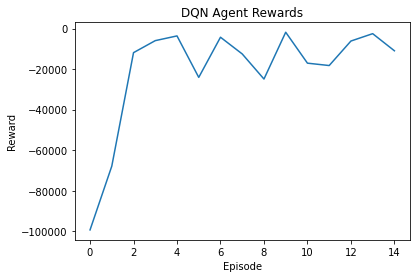

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['episode_reward'])
plt.title('DQN Agent Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False, nb_max_episode_steps = 100)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
=====Action==== is 1
[[-1], [-1], [-1]]
Appending to queue 2
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 2. -1.]]
1.0 and 0.0
=====Action==== is 2
[[-2], [], [-2, 0]]
Appending to queue 0
observation 
[[ 2.  -1.5]
 [ 0.   0. ]
 [ 1.  -2. ]]
2.0 and 0.0
=====Action==== is 2
[[-3, 0], [], [-2]]
Appending to queue 1
observation 
[[ 2.  -2.5]
 [ 1.   0. ]
 [ 0.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-4, -1], [0], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 3.         -2.33333333]
 [ 1.         -1.        ]
 [ 0.          0.        ]]
3.0 and 1.0
=====Action==== is 0
[[-5, -2, 0], [-1], []]
observation 
[[ 2. -3.]
 [ 1. -2.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 0
[[-4, -2], [-2], []]
Appending to queue 0
observation 
[[ 2.  -2.5]
 [ 1.  -3. ]
 [ 0.   0. ]]
2.0 and 1.0
=====Action==== is 0
[[-4, -1], [-3], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -3.]
 [ 2. -2.]
 [ 1.  0.]]
1.0 and 2.0
=====Action==== is 1
[[-3], [-4,

 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-5, -1], [], []]
Appending to queue 2
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-3], [], [0]]
Appending to queue 1
observation 
[[ 1. -4.]
 [ 1.  0.]
 [ 0.  0.]]
1.0 and 1.0
=====Action==== is 1
[[-4], [0], []]
Appending to queue 2
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-5], [], [0]]
Appending to queue 0
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-6, 0], [], []]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -1.5]
 [ 1.   0. ]
 [ 1.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-2, -1], [0], [0]]
observation 
[[ 2.  -2.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-3, -2], [], [-1]]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-4, -3], [], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 2. -3.]
 [ 1.  0.]
 [ 0.  

=====Action==== is 2
[[-22, -16, -4, -3], [-2], [-6, -4]]
Appending to queue 0
observation 
[[ 5.  -9.8]
 [ 1.  -3. ]
 [ 1.  -6. ]]
5.0 and 1.0
=====Action==== is 0
[[-23, -17, -5, -4, 0], [-3], [-6]]
Appending to queue 0
observation 
[[ 5. -7.]
 [ 1. -4.]
 [ 1. -7.]]
5.0 and 1.0
=====Action==== is 0
[[-19, -7, -6, -2, -1], [-4], [-7]]
observation 
[[ 4. -6.]
 [ 1. -5.]
 [ 1. -8.]]
4.0 and 1.0
=====Action==== is 0
[[-9, -8, -4, -3], [-5], [-8]]
Appending to queue 2
observation 
[[ 3.  -7. ]
 [ 1.  -6. ]
 [ 2.  -4.5]]
3.0 and 1.0
=====Action==== is 2
[[-10, -6, -5], [-6], [-9, 0]]
Appending to queue 0
observation 
[[ 4. -6.]
 [ 1. -7.]
 [ 1. -2.]]
4.0 and 1.0
=====Action==== is 0
[[-11, -7, -6, 0], [-7], [-2]]
Appending to queue 0
observation 
[[ 4. -5.]
 [ 1. -8.]
 [ 1. -3.]]
4.0 and 1.0
=====Action==== is 0
[[-9, -8, -2, -1], [-8], [-3]]
Appending to queue 1
observation 
[[ 3.         -5.66666667]
 [ 2.         -4.5       ]
 [ 1.         -4.        ]]
3.0 and 2.0
=====Action==== is 1


=====Action==== is 1
[[-24, -20, -19, -13], [-4, -2], [-7, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  4.         -20.        ]
 [  2.          -2.5       ]
 [  3.          -3.33333333]]
4.0 and 2.0
=====Action==== is 1
[[-25, -21, -20, -14], [-4, -1], [-8, -2, 0]]
observation 
[[  4.         -21.        ]
 [  1.          -3.        ]
 [  3.          -4.33333333]]
4.0 and 1.0
=====Action==== is 2
[[-26, -22, -21, -15], [-3], [-9, -3, -1]]
observation 
[[  4. -22.]
 [  1.  -4.]
 [  2.  -4.]]
4.0 and 1.0
=====Action==== is 2
[[-27, -23, -22, -16], [-4], [-5, -3]]
observation 
[[  4. -23.]
 [  1.  -5.]
 [  1.  -5.]]
4.0 and 1.0
=====Action==== is 0
[[-28, -24, -23, -17], [-5], [-5]]
observation 
[[  3.         -23.33333333]
 [  1.          -6.        ]
 [  1.          -6.        ]]
3.0 and 1.0
=====Action==== is 2
[[-26, -25, -19], [-6], [-6]]
observation 
[[  3.         -24.33333333]
 [  1.          -7.        ]
 [  0.           0.        ]]
3.0 and 1.0
=====Action===

=====Action==== is 1
[[-16, -15, -7], [-3, 0], [-1]]
Appending to queue 0
observation 
[[  4.   -10.25]
 [  1.    -2.  ]
 [  1.    -2.  ]]
4.0 and 1.0
=====Action==== is 0
[[-17, -16, -8, 0], [-2], [-2]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 4.   -7.75]
 [ 2.   -1.5 ]
 [ 2.   -1.5 ]]
4.0 and 2.0
=====Action==== is 1
[[-18, -10, -2, -1], [-3, 0], [-3, 0]]
observation 
[[ 4.   -8.75]
 [ 1.   -2.  ]
 [ 2.   -2.5 ]]
4.0 and 1.0
=====Action==== is 2
[[-19, -11, -3, -2], [-2], [-4, -1]]
Appending to queue 1
observation 
[[ 4.   -9.75]
 [ 2.   -1.5 ]
 [ 1.   -3.  ]]
4.0 and 2.0
=====Action==== is 0
[[-20, -12, -4, -3], [-3, 0], [-3]]
Appending to queue 2
observation 
[[ 3.         -8.33333333]
 [ 2.         -2.5       ]
 [ 2.         -2.        ]]
3.0 and 2.0
=====Action==== is 1
[[-14, -6, -5], [-4, -1], [-4, 0]]
Appending to queue 2
observation 
[[ 3.         -9.33333333]
 [ 1.         -3.        ]
 [ 3.         -2.        ]]
3.0 and 1.0
=====Action=

=====Action==== is 2
[[-15, -14, -9], [-6, -3], [-9]]
Appending to queue 1
observation 
[[  3.         -13.66666667]
 [  3.          -3.66666667]
 [  0.           0.        ]]
3.0 and 3.0
=====Action==== is 1
[[-16, -15, -10], [-7, -4, 0], []]
observation 
[[  3.         -14.66666667]
 [  2.          -4.        ]
 [  0.           0.        ]]
3.0 and 2.0
=====Action==== is 1
[[-17, -16, -11], [-6, -2], []]
Appending to queue 2
observation 
[[  3.         -15.66666667]
 [  1.          -4.        ]
 [  1.           0.        ]]
3.0 and 1.0
=====Action==== is 1
[[-18, -17, -12], [-4], [0]]
observation 
[[  3.         -16.66666667]
 [  0.           0.        ]
 [  1.          -1.        ]]
3.0 and 0.0
=====Action==== is 2
[[-19, -18, -13], [], [-1]]
Appending to queue 2
observation 
[[  3.         -17.66666667]
 [  0.           0.        ]
 [  1.          -1.        ]]
3.0 and 0.0
=====Action==== is 2
[[-20, -19, -14], [], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[  4.

=====Action==== is 2
[[-8, -5], [], [-3]]
Appending to queue 2
observation 
[[ 2.  -7.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-9, -6], [], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -5.66666667]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
3.0 and 0.0
=====Action==== is 2
[[-10, -7, 0], [], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4. -5.]
 [ 0.  0.]
 [ 1. -1.]]
4.0 and 0.0
=====Action==== is 0
[[-11, -8, -1, 0], [], [-1]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 4. -4.]
 [ 1.  0.]
 [ 2. -1.]]
4.0 and 1.0
=====Action==== is 2
[[-10, -3, -2, -1], [0], [-2, 0]]
observation 
[[ 4. -5.]
 [ 1. -1.]
 [ 1. -2.]]
4.0 and 1.0
=====Action==== is 0
[[-11, -4, -3, -2], [-1], [-2]]
Appending to queue 1
observation 
[[ 3. -5.]
 [ 2. -1.]
 [ 1. -3.]]
3.0 and 2.0
=====Action==== is 1
[[-6, -5, -4], [-2, 0], [-3]]
observation 
[[ 3. -6.]
 [ 1. -2.]
 [ 1. -4.]]
3.0 and 1.0
=====

=====Action==== is 1
[[-14, -12, -9, -8, -6], [-4, -3, -1], [-8, -6, -5, 0]]
Appending to queue 2
observation 
[[  5.  -10.8]
 [  2.   -4. ]
 [  5.   -4.6]]
5.0 and 2.0
=====Action==== is 2
[[-15, -13, -10, -9, -7], [-5, -3], [-9, -7, -6, -1, 0]]
observation 
[[  5.  -11.8]
 [  2.   -5. ]
 [  4.   -5.5]]
5.0 and 2.0
=====Action==== is 2
[[-16, -14, -11, -10, -8], [-6, -4], [-9, -8, -3, -2]]
Appending to queue 2
observation 
[[  5.  -12.8]
 [  2.   -6. ]
 [  4.   -5. ]]
5.0 and 2.0
=====Action==== is 2
[[-17, -15, -12, -11, -9], [-7, -5], [-10, -5, -4, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  5.         -13.8       ]
 [  3.          -4.66666667]
 [  4.          -4.25      ]]
5.0 and 3.0
=====Action==== is 1
[[-18, -16, -13, -12, -10], [-8, -6, 0], [-7, -6, -3, -1]]
Appending to queue 0
observation 
[[  6.         -12.33333333]
 [  2.          -5.        ]
 [  4.          -5.25      ]]
6.0 and 2.0
=====Action==== is 2
[[-19, -17, -14, -13, -11, 0], [-8, -2], [-8, -

 [ 1.   -6.  ]]
4.0 and 2.0
=====Action==== is 0
[[-10, -6, -3, 0], [-4, -1], [-6]]
observation 
[[ 3.  -5. ]
 [ 2.  -3.5]
 [ 1.  -7. ]]
3.0 and 2.0
=====Action==== is 1
[[-8, -5, -2], [-5, -2], [-7]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.  -4.5]
 [ 1.  -4. ]
 [ 2.  -4. ]]
4.0 and 1.0
=====Action==== is 0
[[-9, -6, -3, 0], [-4], [-8, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 4.         -4.        ]
 [ 2.         -2.5       ]
 [ 3.         -3.33333333]]
4.0 and 2.0
=====Action==== is 2
[[-8, -5, -2, -1], [-5, 0], [-9, -1, 0]]
Appending to queue 2
observation 
[[ 4.  -5. ]
 [ 2.  -3.5]
 [ 3.  -2. ]]
4.0 and 2.0
=====Action==== is 1
[[-9, -6, -3, -2], [-6, -1], [-3, -2, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 5.   -4.8 ]
 [ 1.   -3.  ]
 [ 4.   -2.25]]
5.0 and 1.0
=====Action==== is 2
[[-10, -7, -4, -3, 0], [-3], [-4, -3, -2, 0]]
observation 
[[ 5.         -5.8       ]
 [ 1.         -4.        ]
 [ 3.    

=====Action==== is 1
[[-3], [0], [0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2.  -2. ]
 [ 0.   0. ]
 [ 2.  -0.5]]
2.0 and 0.0
=====Action==== is 2
[[-4, 0], [], [-1, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 3. -2.]
 [ 1.  0.]
 [ 1. -2.]]
3.0 and 1.0
=====Action==== is 2
[[-5, -1, 0], [0], [-2]]
Appending to queue 2
observation 
[[ 3. -3.]
 [ 1. -1.]
 [ 1. -1.]]
3.0 and 1.0
=====Action==== is 0
[[-6, -2, -1], [-1], [-1]]
Appending to queue 1
observation 
[[ 2.  -3.5]
 [ 2.  -1. ]
 [ 1.  -2. ]]
2.0 and 2.0
=====Action==== is 1
[[-4, -3], [-2, 0], [-2]]
observation 
[[ 2.  -4.5]
 [ 1.  -2. ]
 [ 1.  -3. ]]
2.0 and 1.0
=====Action==== is 2
[[-5, -4], [-2], [-3]]
Appending to queue 2
observation 
[[ 2.  -5.5]
 [ 1.  -3. ]
 [ 1.  -1. ]]
2.0 and 1.0
=====Action==== is 1
[[-6, -5], [-3], [-1]]
Appending to queue 0
observation 
[[ 3.         -4.33333333]
 [ 0.          0.        ]
 [ 1.         -2.        ]]
3.0 and 0.0
=====Action==== is 2
[[-7, -6, 0], [

=====Action==== is 2
[[-9, -4, -3], [-6], [-5, -1]]
observation 
[[ 3.         -6.33333333]
 [ 1.         -7.        ]
 [ 1.         -3.        ]]
3.0 and 1.0
=====Action==== is 0
[[-10, -5, -4], [-7], [-3]]
Appending to queue 1
observation 
[[ 2.  -6.5]
 [ 2.  -4. ]
 [ 1.  -4. ]]
2.0 and 2.0
=====Action==== is 1
[[-7, -6], [-8, 0], [-4]]
Appending to queue 1
observation 
[[ 2.  -7.5]
 [ 2.  -1.5]
 [ 1.  -5. ]]
2.0 and 2.0
=====Action==== is 1
[[-8, -7], [-2, -1], [-5]]
Appending to queue 1
observation 
[[ 2.  -8.5]
 [ 2.  -2. ]
 [ 1.  -6. ]]
2.0 and 2.0
=====Action==== is 1
[[-9, -8], [-3, -1], [-6]]
observation 
[[ 2.  -9.5]
 [ 1.  -3. ]
 [ 1.  -7. ]]
2.0 and 1.0
=====Action==== is 2
[[-10, -9], [-3], [-7]]
Appending to queue 0
observation 
[[ 3. -7.]
 [ 1. -4.]
 [ 0.  0.]]
3.0 and 1.0
=====Action==== is 0
[[-11, -10, 0], [-4], []]
observation 
[[ 2. -7.]
 [ 1. -5.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 0
[[-12, -2], [-5], []]
Appending to queue 0
Appending to queue 1
observatio

=====Action==== is 2
[[-7, -5, 0], [-2], [-2, -1]]
observation 
[[ 3. -5.]
 [ 1. -3.]
 [ 1. -3.]]
3.0 and 1.0
=====Action==== is 0
[[-8, -6, -1], [-3], [-3]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 3. -4.]
 [ 2. -2.]
 [ 2. -2.]]
3.0 and 2.0
=====Action==== is 1
[[-8, -3, -1], [-4, 0], [-4, 0]]
observation 
[[ 3. -5.]
 [ 1. -2.]
 [ 2. -3.]]
3.0 and 1.0
=====Action==== is 2
[[-9, -4, -2], [-2], [-5, -1]]
observation 
[[ 3. -6.]
 [ 1. -3.]
 [ 1. -3.]]
3.0 and 1.0
=====Action==== is 0
[[-10, -5, -3], [-3], [-3]]
Appending to queue 2
observation 
[[ 2. -6.]
 [ 1. -4.]
 [ 2. -2.]]
2.0 and 1.0
=====Action==== is 2
[[-7, -5], [-4], [-4, 0]]
Appending to queue 2
observation 
[[ 2.  -7. ]
 [ 1.  -5. ]
 [ 2.  -1.5]]
2.0 and 1.0
=====Action==== is 1
[[-8, -6], [-5], [-2, -1]]
Appending to queue 0
observation 
[[ 3.         -5.33333333]
 [ 0.          0.        ]
 [ 2.         -2.5       ]]
3.0 and 0.0
=====Action==== is 2
[[-9, -7, 0], [], [-3, -2]]
Appending

=====Action==== is 1
[[-8, -4, 0], [-1, 0], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.  -5. ]
 [ 2.  -1.5]
 [ 1.   0. ]]
3.0 and 2.0
=====Action==== is 1
[[-9, -5, -1], [-2, -1], [0]]
Appending to queue 0
observation 
[[ 4.  -4.5]
 [ 1.  -3. ]
 [ 1.  -1. ]]
4.0 and 1.0
=====Action==== is 0
[[-10, -6, -2, 0], [-3], [-1]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -4.        ]
 [ 1.         -2.        ]]
3.0 and 1.0
=====Action==== is 0
[[-8, -4, -2], [-4], [-2]]
observation 
[[ 2. -5.]
 [ 1. -5.]
 [ 1. -3.]]
2.0 and 1.0
=====Action==== is 1
[[-6, -4], [-5], [-3]]
Appending to queue 0
observation 
[[ 3. -4.]
 [ 0.  0.]
 [ 1. -4.]]
3.0 and 0.0
=====Action==== is 2
[[-7, -5, 0], [], [-4]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.   -3.75]
 [ 0.    0.  ]
 [ 1.   -1.  ]]
4.0 and 0.0
=====Action==== is 0
[[-8, -6, -1, 0], [], [-1]]
Appending to queue 2
observation 
[[ 3.         -4.33333333]
 [ 0.          0.        ]
 [ 2.         -1.      

=====Action==== is 2
[[-6], [], [-2]]
Appending to queue 0
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-7, 0], [], []]
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-2], [], []]
Appending to queue 1
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-3], [], []]
Appending to queue 2
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-4], [], [0]]
Appending to queue 2
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 1. -1.]]
1.0 and 0.0
=====Action==== is 2
[[-5], [], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 1. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-6, 0], [], [-1]]
observation 
[[ 2. -4.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-7, -1], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -3.]
 [ 1.  0.]
 [ 1.  0.]]
1.0 and 1.0
=====Action==== is 1
[[-3], [0], [0]]
Appending t

=====Action==== is 1
[[-3, -1], [-2, 0], [-1]]
Appending to queue 1
observation 
[[ 2.  -3. ]
 [ 2.  -1.5]
 [ 1.  -2. ]]
2.0 and 2.0
=====Action==== is 1
[[-4, -2], [-2, -1], [-2]]
Appending to queue 0
Appending to queue 1
observation 
[[ 3.         -2.66666667]
 [ 2.         -2.        ]
 [ 1.         -3.        ]]
3.0 and 2.0
=====Action==== is 1
[[-5, -3, 0], [-3, -1], [-3]]
Appending to queue 2
observation 
[[ 3.         -3.66666667]
 [ 1.         -3.        ]
 [ 2.         -2.        ]]
3.0 and 1.0
=====Action==== is 2
[[-6, -4, -1], [-3], [-4, 0]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -4.        ]
 [ 1.         -2.        ]]
3.0 and 1.0
=====Action==== is 0
[[-7, -5, -2], [-4], [-2]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -5.5]
 [ 2.  -2.5]
 [ 2.  -1.5]]
2.0 and 2.0
=====Action==== is 1
[[-7, -4], [-5, 0], [-3, 0]]
Appending to queue 1
observation 
[[ 2.  -6.5]
 [ 2.  -1.5]
 [ 2.  -2.5]]
2.0 and 2.0
=====Action==== is 1
[[-8, -5], [-2, -1], 

=====Action==== is 1
[[-6], [], []]
Appending to queue 0
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-7, 0], [], []]
Appending to queue 2
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-2], [], [0]]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 1. -1.]]
1.0 and 0.0
=====Action==== is 2
[[-3], [], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -2.]
 [ 0.  0.]
 [ 1. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-4, 0], [], [-1]]
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-5, -1], [], []]
Appending to queue 2
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-3], [], [0]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-4], [], []]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-5], [], []]
Appending to queue 2
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0

=====Action==== is 2
[[-13, -11, -9, -6, 0], [-5, -2], [-9, -5, -3, -2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 6.         -7.33333333]
 [ 2.         -4.5       ]
 [ 4.         -4.25      ]]
6.0 and 2.0
=====Action==== is 2
[[-14, -12, -10, -7, -1, 0], [-6, -3], [-7, -5, -4, -1]]
observation 
[[ 6.         -8.33333333]
 [ 2.         -5.5       ]
 [ 3.         -5.33333333]]
6.0 and 2.0
=====Action==== is 0
[[-15, -13, -11, -8, -2, -1], [-7, -4], [-7, -6, -3]]
observation 
[[ 5.         -9.        ]
 [ 2.         -6.5       ]
 [ 3.         -6.33333333]]
5.0 and 2.0
=====Action==== is 2
[[-15, -13, -10, -4, -3], [-8, -5], [-8, -7, -4]]
Appending to queue 2
observation 
[[  5.         -10.        ]
 [  2.          -7.5       ]
 [  3.          -5.33333333]]
5.0 and 2.0
=====Action==== is 2
[[-16, -14, -11, -5, -4], [-9, -6], [-9, -6, -1]]
Appending to queue 1
observation 
[[  5.         -11.        ]
 [  3.          -5.66666667]
 [  2.          -5.5       ]]
5.0 and 3.0
=

=====Action==== is 1
[[-5, -1], [0], [0]]
Appending to queue 2
observation 
[[ 2.  -4. ]
 [ 0.   0. ]
 [ 2.  -0.5]]
2.0 and 0.0
=====Action==== is 2
[[-6, -2], [], [-1, 0]]
Appending to queue 0
observation 
[[ 3.         -3.33333333]
 [ 0.          0.        ]
 [ 1.         -2.        ]]
3.0 and 0.0
=====Action==== is 2
[[-7, -3, 0], [], [-2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.   -3.25]
 [ 0.    0.  ]
 [ 1.   -1.  ]]
4.0 and 0.0
=====Action==== is 0
[[-8, -4, -1, 0], [], [-1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.         -3.66666667]
 [ 1.          0.        ]
 [ 2.         -1.        ]]
3.0 and 1.0
=====Action==== is 2
[[-6, -3, -2], [0], [-2, 0]]
Appending to queue 2
observation 
[[ 3.         -4.66666667]
 [ 1.         -1.        ]
 [ 2.         -1.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-7, -4, -3], [-1], [-2, -1]]
Appending to queue 0
observation 
[[ 4.   -4.25]
 [ 1.   -2.  ]
 [ 1.   -3.  ]]
4.0 and 1.0
=====Action==== is 0


=====Action==== is 1
[[-15, -10], [0], []]
observation 
[[  2.  -13.5]
 [  0.    0. ]
 [  0.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-16, -11], [], []]
observation 
[[  2.  -14.5]
 [  0.    0. ]
 [  0.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-17, -12], [], []]
Appending to queue 0
observation 
[[  3.         -10.33333333]
 [  0.           0.        ]
 [  0.           0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-18, -13, 0], [], []]
Appending to queue 0
observation 
[[ 3. -6.]
 [ 0.  0.]
 [ 0.  0.]]
3.0 and 0.0
=====Action==== is 0
[[-15, -2, -1], [], []]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-4, -3], [], []]
Appending to queue 0
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-5, -1], [], []]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-3], [], []]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-4], [], []]
observation 

=====Action==== is 1
[[-7], [], []]
observation 
[[ 1. -8.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-8], [], []]
Appending to queue 0
observation 
[[ 2.  -4.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-9, 0], [], []]
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-2], [], []]
Appending to queue 0
observation 
[[ 2.  -1.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-3, 0], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -2.]
 [ 1.  0.]
 [ 1.  0.]]
1.0 and 1.0
=====Action==== is 1
[[-2], [0], [0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -1.5]
 [ 1.  -1. ]
 [ 2.  -0.5]]
2.0 and 1.0
=====Action==== is 2
[[-3, 0], [-1], [-1, 0]]
Appending to queue 2
observation 
[[ 2.  -2.5]
 [ 1.  -2. ]
 [ 2.  -1.5]]
2.0 and 1.0
=====Action==== is 2
[[-4, -1], [-2], [-2, -1]]
Appending to queue 2
observation 
[[ 2.  -3.5]
 [ 1.  -3. ]
 [ 2.  -2. ]]
2.0

=====Action==== is 0
[[-7, 0], [], []]
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-2], [], []]
Appending to queue 1
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-3], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -2.]
 [ 0.  0.]
 [ 1.  0.]]
2.0 and 0.0
=====Action==== is 2
[[-4, 0], [], [0]]
Appending to queue 2
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 1. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-5, -1], [], [-1]]
Appending to queue 1
observation 
[[ 2. -4.]
 [ 1.  0.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-6, -2], [0], []]
Appending to queue 0
observation 
[[ 3.         -3.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-7, -3, 0], [], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 3.         -2.66666667]
 [ 1.          0.        ]
 [ 0.          0.        ]]
3.0 and 1.0
=====Action==== is 0
[[-5, -2, -1], [0], []]
o

=====Action==== is 1
[[-14, -7], [0], []]
Appending to queue 1
observation 
[[  2.  -11.5]
 [  1.   -1. ]
 [  0.    0. ]]
2.0 and 1.0
=====Action==== is 1
[[-15, -8], [-1], []]
Appending to queue 2
observation 
[[  2.  -12.5]
 [  0.    0. ]
 [  1.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-16, -9], [], [0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 3. -9.]
 [ 1.  0.]
 [ 1. -1.]]
3.0 and 1.0
=====Action==== is 2
[[-17, -10, 0], [0], [-1]]
Appending to queue 1
observation 
[[  3.  -10. ]
 [  2.   -0.5]
 [  0.    0. ]]
3.0 and 2.0
=====Action==== is 1
[[-18, -11, -1], [-1, 0], []]
observation 
[[  3. -11.]
 [  1.  -2.]
 [  0.   0.]]
3.0 and 1.0
=====Action==== is 0
[[-19, -12, -2], [-2], []]
observation 
[[ 2. -9.]
 [ 1. -3.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-14, -4], [-3], []]
Appending to queue 2
observation 
[[  2. -10.]
 [  0.   0.]
 [  1.   0.]]
2.0 and 0.0
=====Action==== is 2
[[-15, -5], [], [0]]
Appending to queue 2
observation 

=====Action==== is 2
[[-19, -15, -14, -10, -5, -4], [-13, -4, -3], [-12, -11, -10, -8, 0]]
Appending to queue 1
observation 
[[  6.         -12.16666667]
 [  4.          -5.75      ]
 [  4.          -9.25      ]]
6.0 and 4.0
=====Action==== is 1
[[-20, -16, -15, -11, -6, -5], [-14, -5, -4, 0], [-13, -12, -10, -2]]
Appending to queue 1
Appending to queue 2
observation 
[[  6.         -13.16666667]
 [  4.          -4.        ]
 [  5.          -8.2       ]]
6.0 and 4.0
=====Action==== is 1
[[-21, -17, -16, -12, -7, -6], [-7, -6, -2, -1], [-14, -13, -11, -3, 0]]
observation 
[[  6.         -14.16666667]
 [  3.          -5.        ]
 [  5.          -9.2       ]]
6.0 and 3.0
=====Action==== is 2
[[-22, -18, -17, -13, -8, -7], [-8, -4, -3], [-15, -14, -12, -4, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[  7. -13.]
 [  3.  -6.]
 [  5.  -8.]]
7.0 and 3.0
=====Action==== is 2
[[-23, -19, -18, -14, -9, -8, 0], [-9, -5, -4], [-16, -14, -6, -3, -1]]
Appending to queue 1
observatio

=====Action==== is 1
[[-3], [0], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -4.]
 [ 1. -1.]
 [ 1.  0.]]
1.0 and 1.0
=====Action==== is 1
[[-4], [-1], [0]]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 1. -1.]]
1.0 and 0.0
=====Action==== is 2
[[-5], [], [-1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -6.]
 [ 1.  0.]
 [ 1. -1.]]
1.0 and 1.0
=====Action==== is 2
[[-6], [0], [-1]]
Appending to queue 0
observation 
[[ 2.  -3.5]
 [ 1.  -1. ]
 [ 0.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-7, 0], [-1], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 3. -3.]
 [ 0.  0.]
 [ 1.  0.]]
3.0 and 0.0
=====Action==== is 0
[[-8, -1, 0], [], [0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.  -2. ]
 [ 0.   0. ]
 [ 2.  -0.5]]
3.0 and 0.0
=====Action==== is 2
[[-3, -2, -1], [], [-1, 0]]
Appending to queue 2
observation 
[[ 3.  -3. ]
 [ 0.   0. ]
 [ 2.  -1.5]]
3.0 and 0.0
=====Action==== is 2
[[-4, -3, -2], [], [-2, -1]]
Appending to queue 2
o

 [  2.  -4.]]
4.0 and 1.0
=====Action==== is 0
[[-19, -14, -8, -7], [-6], [-7, -1]]
observation 
[[  3.         -11.66666667]
 [  1.          -7.        ]
 [  2.          -5.        ]]
3.0 and 1.0
=====Action==== is 2
[[-16, -10, -9], [-7], [-8, -2]]
Appending to queue 2
observation 
[[  3.         -12.66666667]
 [  1.          -8.        ]
 [  2.          -2.5       ]]
3.0 and 1.0
=====Action==== is 1
[[-17, -11, -10], [-8], [-4, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[  4.   -10.25]
 [  1.    -1.  ]
 [  2.    -3.5 ]]
4.0 and 1.0
=====Action==== is 2
[[-18, -12, -11, 0], [-1], [-5, -2]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 5.  -9. ]
 [ 2.  -1. ]
 [ 2.  -2.5]]
5.0 and 2.0
=====Action==== is 0
[[-19, -13, -12, -1, 0], [-2, 0], [-4, -1]]
Appending to queue 0
observation 
[[ 5.  -7. ]
 [ 2.  -2. ]
 [ 2.  -3.5]]
5.0 and 2.0
=====Action==== is 0
[[-15, -14, -3, -2, -1], [-3, -1], [-5, -2]]
Appending to queue 0
Appending to queu

=====Action==== is 2
[[-15, -12, -9, -5], [-4], [-7, -4, -3]]
observation 
[[  4.   -11.25]
 [  1.    -5.  ]
 [  2.    -5.5 ]]
4.0 and 1.0
=====Action==== is 0
[[-16, -13, -10, -6], [-5], [-6, -5]]
observation 
[[  3.         -11.66666667]
 [  1.          -6.        ]
 [  2.          -6.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-15, -12, -8], [-6], [-7, -6]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 4.  -9.5]
 [ 2.  -3.5]
 [ 2.  -4.5]]
4.0 and 2.0
=====Action==== is 1
[[-16, -13, -9, 0], [-7, 0], [-8, -1]]
Appending to queue 1
observation 
[[  4.  -10.5]
 [  2.   -1.5]
 [  2.   -5.5]]
4.0 and 2.0
=====Action==== is 2
[[-17, -14, -10, -1], [-2, -1], [-9, -2]]
Appending to queue 1
Appending to queue 2
observation 
[[  4.         -11.5       ]
 [  3.          -1.66666667]
 [  2.          -2.5       ]]
4.0 and 3.0
=====Action==== is 1
[[-18, -15, -11, -2], [-3, -2, 0], [-4, -1]]
Appending to queue 2
observation 
[[  4.         -12.5       ]
 [  2.  

 [ 2. -4.]]
4.0 and 3.0
=====Action==== is 1
[[-14, -9, -5, -4], [-3, -2, -1], [-8, 0]]
observation 
[[ 4.  -9. ]
 [ 2.  -3.5]
 [ 2.  -5. ]]
4.0 and 2.0
=====Action==== is 1
[[-15, -10, -6, -5], [-4, -3], [-9, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  4. -10.]
 [  2.  -3.]
 [  3.  -4.]]
4.0 and 2.0
=====Action==== is 2
[[-16, -11, -7, -6], [-5, -1], [-10, -2, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 5.         -8.8       ]
 [ 3.         -2.66666667]
 [ 2.         -3.        ]]
5.0 and 3.0
=====Action==== is 1
[[-17, -12, -8, -7, 0], [-6, -2, 0], [-4, -2]]
Appending to queue 2
observation 
[[ 5.         -9.8       ]
 [ 2.         -3.        ]
 [ 3.         -2.66666667]]
5.0 and 2.0
=====Action==== is 1
[[-18, -13, -9, -8, -1], [-4, -2], [-5, -3, 0]]
observation 
[[  5.         -10.8       ]
 [  1.          -4.        ]
 [  3.          -3.66666667]]
5.0 and 1.0
=====Action==== is 2
[[-19, -14, -10, -9, -2], [-4], [-6, -4, -1]]
observation 
[[  5

=====Action==== is 1
[[-20, -3], [-1], [-1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 3.         -8.33333333]
 [ 1.         -1.        ]
 [ 1.         -2.        ]]
3.0 and 1.0
=====Action==== is 2
[[-21, -4, 0], [-1], [-2]]
Appending to queue 0
observation 
[[ 4. -7.]
 [ 1. -2.]
 [ 0.  0.]]
4.0 and 1.0
=====Action==== is 0
[[-22, -5, -1, 0], [-2], []]
Appending to queue 2
observation 
[[ 3. -4.]
 [ 1. -3.]
 [ 1.  0.]]
3.0 and 1.0
=====Action==== is 0
[[-7, -3, -2], [-3], [0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -3.33333333]
 [ 1.         -4.        ]
 [ 2.         -0.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-5, -4, -1], [-4], [-1, 0]]
Appending to queue 2
observation 
[[ 3.         -4.33333333]
 [ 1.         -5.        ]
 [ 2.         -1.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-6, -5, -2], [-5], [-2, -1]]
Appending to queue 2
observation 
[[ 3.         -5.33333333]
 [ 1.         -6.        ]
 [ 2.         -2.        ]]
3.0 a

=====Action==== is 0
[[-25, -16, -2, -1], [], [-3]]
observation 
[[ 3.         -8.33333333]
 [ 0.          0.        ]
 [ 1.         -4.        ]]
3.0 and 0.0
=====Action==== is 2
[[-18, -4, -3], [], [-4]]
Appending to queue 1
observation 
[[ 3.         -9.33333333]
 [ 1.          0.        ]
 [ 0.          0.        ]]
3.0 and 1.0
=====Action==== is 0
[[-19, -5, -4], [0], []]
Appending to queue 1
observation 
[[ 2.  -6.5]
 [ 2.  -0.5]
 [ 0.   0. ]]
2.0 and 2.0
=====Action==== is 1
[[-7, -6], [-1, 0], []]
Appending to queue 2
observation 
[[ 2.  -7.5]
 [ 1.  -2. ]
 [ 1.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-8, -7], [-2], [0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 3.         -5.66666667]
 [ 1.         -1.        ]
 [ 1.         -1.        ]]
3.0 and 1.0
=====Action==== is 0
[[-9, -8, 0], [-1], [-1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 3.         -4.33333333]
 [ 2.         -1.        ]
 [ 1.         -2.        ]]
3.0 and 2.0
Episode 23: rew

 [ 2.         -3.5       ]]
5.0 and 3.0
=====Action==== is 1
[[-17, -10, -7, -2, -1], [-3, -2, 0], [-5, -2]]
Appending to queue 2
observation 
[[ 5.  -8.4]
 [ 2.  -3. ]
 [ 3.  -3. ]]
5.0 and 2.0
=====Action==== is 1
[[-18, -11, -8, -3, -2], [-4, -2], [-6, -3, 0]]
observation 
[[ 5.  -9.4]
 [ 1.  -4. ]
 [ 3.  -4. ]]
5.0 and 1.0
=====Action==== is 2
[[-19, -12, -9, -4, -3], [-4], [-7, -4, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 6.         -8.66666667]
 [ 1.         -5.        ]
 [ 3.         -3.33333333]]
6.0 and 1.0
=====Action==== is 0
[[-20, -13, -10, -5, -4, 0], [-5], [-6, -3, -1]]
observation 
[[ 5.         -8.4       ]
 [ 1.         -6.        ]
 [ 3.         -4.33333333]]
5.0 and 1.0
=====Action==== is 0
[[-15, -12, -7, -6, -2], [-6], [-7, -4, -2]]
Appending to queue 0
observation 
[[ 5.         -7.2       ]
 [ 1.         -7.        ]
 [ 3.         -5.33333333]]
5.0 and 1.0
=====Action==== is 0
[[-14, -9, -8, -4, -1], [-7], [-8, -5, -3]]
Appending to queue 0

 [ 2. -3.]]
3.0 and 1.0
=====Action==== is 2
[[-11, -8, -5], [-8], [-5, -1]]
observation 
[[ 3. -9.]
 [ 1. -9.]
 [ 1. -3.]]
3.0 and 1.0
=====Action==== is 0
[[-12, -9, -6], [-9], [-3]]
Appending to queue 2
observation 
[[  2.   -9.5]
 [  1.  -10. ]
 [  2.   -2. ]]
2.0 and 1.0
=====Action==== is 1
[[-11, -8], [-10], [-4, 0]]
observation 
[[  2.  -10.5]
 [  0.    0. ]
 [  2.   -3. ]]
2.0 and 0.0
=====Action==== is 2
[[-12, -9], [], [-5, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 3.         -7.66666667]
 [ 1.          0.        ]
 [ 1.         -3.        ]]
3.0 and 1.0
=====Action==== is 2
[[-13, -10, 0], [0], [-3]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.  -6.5]
 [ 1.  -1. ]
 [ 1.  -1. ]]
4.0 and 1.0
=====Action==== is 0
[[-14, -11, -1, 0], [-1], [-1]]
Appending to queue 2
observation 
[[ 3. -6.]
 [ 1. -2.]
 [ 2. -1.]]
3.0 and 1.0
=====Action==== is 2
[[-13, -3, -2], [-2], [-2, 0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 4.   -5.2

=====Action==== is 0
[[-14, -10, -7, -4, -3], [-14, -7], [-9, -5, -3]]
Appending to queue 2
observation 
[[  4.   -8. ]
 [  2.  -11.5]
 [  4.   -5. ]]
4.0 and 2.0
=====Action==== is 2
[[-12, -9, -6, -5], [-15, -8], [-10, -6, -4, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 4.         -9.        ]
 [ 3.         -8.33333333]
 [ 4.         -4.25      ]]
4.0 and 3.0
=====Action==== is 1
[[-13, -10, -7, -6], [-16, -9, 0], [-8, -6, -2, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 5.  -8. ]
 [ 2.  -6.5]
 [ 5.  -4.2]]
5.0 and 2.0
=====Action==== is 2
[[-14, -11, -8, -7, 0], [-11, -2], [-9, -7, -3, -2, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 5.  -9. ]
 [ 3.  -5. ]
 [ 5.  -4.2]]
5.0 and 3.0
=====Action==== is 1
[[-15, -12, -9, -8, -1], [-12, -3, 0], [-9, -5, -4, -2, -1]]
observation 
[[  5.  -10. ]
 [  2.   -3.5]
 [  5.   -5.2]]
5.0 and 2.0
=====Action==== is 2
[[-16, -13, -10, -9, -2], [-5, -2], [-10, -6, -5, -3, -2]]
Appending to queue 0

=====Action==== is 1
[[-10, -8], [-11], [-6, 0]]
Appending to queue 1
observation 
[[  2. -10.]
 [  1.  -1.]
 [  2.  -4.]]
2.0 and 1.0
=====Action==== is 2
[[-11, -9], [-1], [-7, -1]]
Appending to queue 2
observation 
[[  2. -11.]
 [  1.  -2.]
 [  2.  -2.]]
2.0 and 1.0
=====Action==== is 2
[[-12, -10], [-2], [-3, -1]]
observation 
[[  2. -12.]
 [  1.  -3.]
 [  1.  -3.]]
2.0 and 1.0
=====Action==== is 2
[[-13, -11], [-3], [-3]]
Appending to queue 1
Appending to queue 2
observation 
[[  2. -13.]
 [  2.  -2.]
 [  1.  -1.]]
2.0 and 2.0
=====Action==== is 1
[[-14, -12], [-4, 0], [-1]]
observation 
[[  2. -14.]
 [  1.  -2.]
 [  1.  -2.]]
2.0 and 1.0
=====Action==== is 2
[[-15, -13], [-2], [-2]]
Appending to queue 0
observation 
[[  3. -10.]
 [  1.  -3.]
 [  0.   0.]]
3.0 and 1.0
=====Action==== is 0
[[-16, -14, 0], [-3], []]
Appending to queue 0
observation 
[[ 3.         -6.33333333]
 [ 1.         -4.        ]
 [ 0.          0.        ]]
3.0 and 1.0
=====Action==== is 0
[[-16, -2, -1], [-4]

=====Action==== is 2
[[-8], [], []]
Appending to queue 2
observation 
[[ 1. -9.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-9], [], []]
Appending to queue 2
observation 
[[  1. -10.]
 [  0.   0.]
 [  0.   0.]]
1.0 and 0.0
=====Action==== is 2
[[-10], [], []]
Appending to queue 0
observation 
[[ 2.  -5.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-11, 0], [], []]
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-2], [], []]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-3], [], []]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-4], [], []]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-5], [], []]
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-6], [], []]
observation 
[[ 1. -7.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-7], [], []]
Appending to queue 2
observat

2.0 and 0.0
=====Action==== is 0
[[-4, -2], [], []]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-4], [], []]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-5], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-6], [], [0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-7, 0], [], [-1]]
observation 
[[ 2.  -4.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-8, -1], [], []]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-3], [], []]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-4], [], []]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-5], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 1.

 [ 1.         -1.        ]]
3.0 and 1.0
=====Action==== is 1
[[-12, -11, -2], [-1], [-1]]
observation 
[[ 3.         -9.33333333]
 [ 0.          0.        ]
 [ 1.         -2.        ]]
3.0 and 0.0
=====Action==== is 2
[[-13, -12, -3], [], [-2]]
Appending to queue 2
observation 
[[  3.         -10.33333333]
 [  0.           0.        ]
 [  1.          -1.        ]]
3.0 and 0.0
=====Action==== is 2
[[-14, -13, -4], [], [-1]]
Appending to queue 1
observation 
[[  3.         -11.33333333]
 [  1.           0.        ]
 [  0.           0.        ]]
3.0 and 1.0
=====Action==== is 0
[[-15, -14, -5], [0], []]
observation 
[[  2.  -11.5]
 [  1.   -1. ]
 [  0.    0. ]]
2.0 and 1.0
=====Action==== is 1
[[-16, -7], [-1], []]
Appending to queue 2
observation 
[[  2.  -12.5]
 [  0.    0. ]
 [  1.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-17, -8], [], [0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 3. -9.]
 [ 1.  0.]
 [ 1. -1.]]
3.0 and 1.0
=====Action==== is 2
[

=====Action==== is 2
[[-9, -8], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -6.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-10, -9, 0], [], []]
Appending to queue 2
observation 
[[ 2.  -6.5]
 [ 0.   0. ]
 [ 1.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-11, -2], [], [0]]
Appending to queue 1
observation 
[[ 2.  -7.5]
 [ 1.   0. ]
 [ 0.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-12, -3], [0], []]
observation 
[[ 2.  -8.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-13, -4], [], []]
observation 
[[ 2.  -9.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-14, -5], [], []]
Appending to queue 1
observation 
[[  2.  -10.5]
 [  1.    0. ]
 [  0.    0. ]]
2.0 and 1.0
=====Action==== is 1
[[-15, -6], [0], []]
Appending to queue 2
observation 
[[  2.  -11.5]
 [  0.    0. ]
 [  1.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-16, -7], [], [0]]
Appending to queue 0
Appending 

 [ 2.         -1.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-8, -6, 0], [-7], [-2, -1]]
Appending to queue 0
observation 
[[ 4.   -4.25]
 [ 1.   -8.  ]
 [ 1.   -3.  ]]
4.0 and 1.0
=====Action==== is 0
[[-9, -7, -1, 0], [-8], [-3]]
Appending to queue 2
observation 
[[ 3.         -4.66666667]
 [ 1.         -9.        ]
 [ 2.         -2.        ]]
3.0 and 1.0
=====Action==== is 1
[[-9, -3, -2], [-9], [-4, 0]]
observation 
[[ 3.         -5.66666667]
 [ 0.          0.        ]
 [ 2.         -3.        ]]
3.0 and 0.0
=====Action==== is 2
[[-10, -4, -3], [], [-5, -1]]
Appending to queue 2
observation 
[[ 3.         -6.66666667]
 [ 0.          0.        ]
 [ 2.         -2.        ]]
3.0 and 0.0
=====Action==== is 2
[[-11, -5, -4], [], [-3, -1]]
Appending to queue 0
observation 
[[ 4.   -5.75]
 [ 0.    0.  ]
 [ 1.   -3.  ]]
4.0 and 0.0
=====Action==== is 0
[[-12, -6, -5, 0], [], [-3]]
Appending to queue 2
observation 
[[ 3.         -5.66666667]
 [ 0.          0.        ]
 [ 2.         -2.   

=====Action==== is 0
[[-4, -3], [], []]
Appending to queue 0
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-5, -1], [], []]
Appending to queue 2
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-3], [], [0]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-4], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 2.  -2.5]
 [ 0.   0. ]
 [ 1.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-5, 0], [], [0]]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-6, -1], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -2.]
 [ 0.  0.]
 [ 1.  0.]]
2.0 and 0.0
=====Action==== is 2
[[-3, -1], [], [0]]
Appending to queue 0
observation 
[[ 3. -2.]
 [ 0.  0.]
 [ 0.  0.]]
3.0 and 0.0
=====Action==== is 0
[[-4, -2, 0], [], []]
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-4, -2], [], []]
Appending to

=====Action==== is 1
[[-17, -15, -14, -8, -7, -3], [-13, -8, -7, 0], [-14, -13, -11, -6, 0]]
Appending to queue 1
observation 
[[  6.         -11.66666667]
 [  4.          -5.5       ]
 [  5.          -9.8       ]]
6.0 and 4.0
=====Action==== is 1
[[-18, -16, -15, -9, -8, -4], [-10, -9, -2, -1], [-15, -14, -12, -7, -1]]
Appending to queue 1
observation 
[[  6.         -12.66666667]
 [  4.          -4.75      ]
 [  5.         -10.8       ]]
6.0 and 4.0
=====Action==== is 1
[[-19, -17, -16, -10, -9, -5], [-11, -4, -3, -1], [-16, -15, -13, -8, -2]]
observation 
[[  6.         -13.66666667]
 [  3.          -4.66666667]
 [  5.         -11.8       ]]
6.0 and 3.0
=====Action==== is 2
[[-20, -18, -17, -11, -10, -6], [-6, -5, -3], [-17, -16, -14, -9, -3]]
Appending to queue 2
observation 
[[  6.         -14.66666667]
 [  3.          -5.66666667]
 [  5.         -10.2       ]]
6.0 and 3.0
=====Action==== is 2
[[-21, -19, -18, -12, -11, -7], [-7, -6, -4], [-18, -16, -11, -5, -1]]
Appending to queu

=====Action==== is 2
[[-27, -23, -19, -18, -8, -4], [-12, -6, -5], [-19, -16, -6, -2, -1]]
Appending to queue 2
observation 
[[  6.         -17.5       ]
 [  3.          -8.66666667]
 [  5.          -6.8       ]]
6.0 and 3.0
=====Action==== is 1
[[-28, -24, -20, -19, -9, -5], [-13, -7, -6], [-18, -8, -4, -3, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[  6.  -18.5]
 [  3.   -6. ]
 [  6.   -6.5]]
6.0 and 3.0
=====Action==== is 1
[[-29, -25, -21, -20, -10, -6], [-9, -8, -1], [-19, -9, -5, -4, -2, 0]]
Appending to queue 0
observation 
[[  7.         -16.71428571]
 [  2.          -6.5       ]
 [  6.          -7.5       ]]
7.0 and 2.0
=====Action==== is 2
[[-30, -26, -22, -21, -11, -7, 0], [-10, -3], [-20, -10, -6, -5, -3, -1]]
Appending to queue 1
observation 
[[  7.         -17.71428571]
 [  3.          -5.        ]
 [  5.          -7.        ]]
7.0 and 3.0
=====Action==== is 2
[[-31, -27, -23, -22, -12, -8, -1], [-11, -4, 0], [-12, -8, -7, -5, -3]]
Appending to queue 2
o

=====Action==== is 1
[[-15], [-1], []]
observation 
[[  1. -16.]
 [  0.   0.]
 [  0.   0.]]
1.0 and 0.0
=====Action==== is 2
[[-16], [], []]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -8.5]
 [ 1.   0. ]
 [ 0.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-17, 0], [0], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -9.5]
 [ 1.  -1. ]
 [ 1.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-18, -1], [-1], [0]]
Appending to queue 2
observation 
[[  2.  -10.5]
 [  0.    0. ]
 [  2.   -0.5]]
2.0 and 0.0
=====Action==== is 2
[[-19, -2], [], [-1, 0]]
observation 
[[  2.  -11.5]
 [  0.    0. ]
 [  1.   -2. ]]
2.0 and 0.0
=====Action==== is 2
[[-20, -3], [], [-2]]
observation 
[[  2.  -12.5]
 [  0.    0. ]
 [  0.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-21, -4], [], []]
Appending to queue 0
observation 
[[ 3. -9.]
 [ 0.  0.]
 [ 0.  0.]]
3.0 and 0.0
=====Action==== is 0
[[-22, -5, 0], [], []]
Appending to queue 0
Appending to queue 1
observati

=====Action==== is 2
[[-3], [], [0]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-4], [], []]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-5], [], []]
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-6], [], []]
Appending to queue 1
observation 
[[ 1. -7.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-7], [], []]
observation 
[[ 1. -8.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-8], [], []]
observation 
[[ 1. -9.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-9], [], []]
Appending to queue 2
observation 
[[  1. -10.]
 [  0.   0.]
 [  0.   0.]]
1.0 and 0.0
=====Action==== is 2
[[-10], [], []]
Appending to queue 2
observation 
[[  1. -11.]
 [  0.   0.]
 [  0.   0.]]
1.0 and 0.0
=====Action==== is 2
[[-11], [], []]
observation 
[[  1. -12.]
 [  0.   0.]
 [  0.   0.]]
1.0 and 0.0
=====Action==== is 2
[[-12], [], []]
Appending to queue 1
obs

=====Action==== is 1
[[-10, -8, 0], [-2, -1], [-4, 0]]
Appending to queue 0
observation 
[[ 4.   -5.25]
 [ 1.   -3.  ]
 [ 2.   -3.  ]]
4.0 and 1.0
=====Action==== is 0
[[-11, -9, -1, 0], [-3], [-5, -1]]
Appending to queue 0
observation 
[[ 4.   -4.25]
 [ 1.   -4.  ]
 [ 2.   -4.  ]]
4.0 and 1.0
=====Action==== is 0
[[-11, -3, -2, -1], [-4], [-6, -2]]
Appending to queue 0
observation 
[[ 4.   -3.25]
 [ 1.   -5.  ]
 [ 2.   -5.  ]]
4.0 and 1.0
=====Action==== is 0
[[-5, -4, -3, -1], [-5], [-7, -3]]
Appending to queue 2
observation 
[[ 3.         -4.66666667]
 [ 1.         -6.        ]
 [ 3.         -4.        ]]
3.0 and 1.0
=====Action==== is 2
[[-6, -5, -3], [-6], [-8, -4, 0]]
observation 
[[ 3.         -5.66666667]
 [ 1.         -7.        ]
 [ 2.         -4.        ]]
3.0 and 1.0
=====Action==== is 2
[[-7, -6, -4], [-7], [-6, -2]]
Appending to queue 0
observation 
[[ 4. -5.]
 [ 1. -8.]
 [ 1. -4.]]
4.0 and 1.0
=====Action==== is 0
[[-8, -7, -5, 0], [-8], [-4]]
observation 
[[ 3. -6.]
 [ 

=====Action==== is 2
[[-6, -4], [], [-1, 0]]
Appending to queue 2
observation 
[[ 2.  -6. ]
 [ 0.   0. ]
 [ 2.  -1.5]]
2.0 and 0.0
=====Action==== is 2
[[-7, -5], [], [-2, -1]]
Appending to queue 1
observation 
[[ 2. -7.]
 [ 1.  0.]
 [ 1. -3.]]
2.0 and 1.0
=====Action==== is 2
[[-8, -6], [0], [-3]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -8. ]
 [ 2.  -0.5]
 [ 1.  -1. ]]
2.0 and 2.0
=====Action==== is 1
[[-9, -7], [-1, 0], [-1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -9. ]
 [ 2.  -1.5]
 [ 2.  -1. ]]
2.0 and 2.0
=====Action==== is 1
[[-10, -8], [-2, -1], [-2, 0]]
Appending to queue 2
observation 
[[  2.         -10.        ]
 [  1.          -3.        ]
 [  3.          -1.33333333]]
2.0 and 1.0
=====Action==== is 2
[[-11, -9], [-3], [-3, -1, 0]]
Appending to queue 1
observation 
[[  2.  -11. ]
 [  2.   -2. ]
 [  2.   -2.5]]
2.0 and 2.0
=====Action==== is 1
[[-12, -10], [-4, 0], [-3, -2]]
Appending to queue 2
observation 
[[  2.         -12.   

 [  1.          -1.        ]]
3.0 and 0.0
=====Action==== is 2
[[-17, -14, -4], [], [-1]]
Appending to queue 2
observation 
[[  3.         -12.66666667]
 [  0.           0.        ]
 [  1.          -1.        ]]
3.0 and 0.0
=====Action==== is 2
[[-18, -15, -5], [], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[  4.   -10.25]
 [  0.     0.  ]
 [  1.    -1.  ]]
4.0 and 0.0
=====Action==== is 0
[[-19, -16, -6, 0], [], [-1]]
observation 
[[ 3.         -9.33333333]
 [ 0.          0.        ]
 [ 1.         -2.        ]]
3.0 and 0.0
=====Action==== is 2
[[-18, -8, -2], [], [-2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.   -7.75]
 [ 0.    0.  ]
 [ 1.   -1.  ]]
4.0 and 0.0
=====Action==== is 0
[[-19, -9, -3, 0], [], [-1]]
Appending to queue 0
observation 
[[ 4.   -4.75]
 [ 0.    0.  ]
 [ 1.   -2.  ]]
4.0 and 0.0
=====Action==== is 0
[[-11, -5, -2, -1], [], [-2]]
Appending to queue 0
observation 
[[ 4.   -3.75]
 [ 0.    0.  ]
 [ 1.   -3.  ]]
4.0 and 0.0
=====A

=====Action==== is 2
[[-15, -4, -2], [-3], [-4, -1]]
Appending to queue 1
observation 
[[ 3. -8.]
 [ 2. -2.]
 [ 1. -3.]]
3.0 and 2.0
=====Action==== is 1
[[-16, -5, -3], [-4, 0], [-3]]
Appending to queue 1
observation 
[[ 3.  -9. ]
 [ 2.  -1.5]
 [ 1.  -4. ]]
3.0 and 2.0
=====Action==== is 1
[[-17, -6, -4], [-2, -1], [-4]]
Appending to queue 0
observation 
[[ 4.  -7.5]
 [ 1.  -3. ]
 [ 1.  -5. ]]
4.0 and 1.0
=====Action==== is 0
[[-18, -7, -5, 0], [-3], [-5]]
Appending to queue 0
observation 
[[ 4.   -4.75]
 [ 1.   -4.  ]
 [ 1.   -6.  ]]
4.0 and 1.0
=====Action==== is 0
[[-9, -7, -2, -1], [-4], [-6]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 4.   -4.25]
 [ 2.   -2.5 ]
 [ 2.   -3.5 ]]
4.0 and 2.0
=====Action==== is 1
[[-9, -4, -3, -1], [-5, 0], [-7, 0]]
Appending to queue 0
observation 
[[ 5.  -4.2]
 [ 1.  -2. ]
 [ 2.  -4.5]]
5.0 and 1.0
=====Action==== is 0
[[-10, -5, -4, -2, 0], [-2], [-8, -1]]
Appending to queue 0
observation 
[[ 5.  -4. ]
 [ 1.  -3

=====Action==== is 0
[[-12, -9, -8, 0], [-6, 0], [-3]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 4.         -6.        ]
 [ 3.         -2.66666667]
 [ 2.         -2.        ]]
4.0 and 3.0
=====Action==== is 1
[[-11, -10, -2, -1], [-7, -1, 0], [-4, 0]]
Appending to queue 0
observation 
[[ 5.  -5.6]
 [ 2.  -2.5]
 [ 2.  -3. ]]
5.0 and 2.0
=====Action==== is 0
[[-12, -11, -3, -2, 0], [-3, -2], [-5, -1]]
observation 
[[ 4.  -6. ]
 [ 2.  -3.5]
 [ 2.  -4. ]]
4.0 and 2.0
=====Action==== is 1
[[-13, -5, -4, -2], [-4, -3], [-6, -2]]
observation 
[[ 4. -7.]
 [ 1. -5.]
 [ 2. -5.]]
4.0 and 1.0
=====Action==== is 0
[[-14, -6, -5, -3], [-5], [-7, -3]]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.         -6.66666667]
 [ 2.         -3.        ]
 [ 3.         -4.        ]]
3.0 and 2.0
=====Action==== is 2
[[-8, -7, -5], [-6, 0], [-8, -4, 0]]
Appending to queue 0
observation 
[[ 4.   -5.75]
 [ 2.   -4.  ]
 [ 2.   -4.  ]]
4.0 and 2.0
=====Action==== is 

=====Action==== is 1
[[-7], [-1], [0]]
Appending to queue 2
observation 
[[ 1.  -8. ]
 [ 0.   0. ]
 [ 2.  -0.5]]
1.0 and 0.0
=====Action==== is 2
[[-8], [], [-1, 0]]
observation 
[[ 1. -9.]
 [ 0.  0.]
 [ 1. -2.]]
1.0 and 0.0
=====Action==== is 2
[[-9], [], [-2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -5.]
 [ 0.  0.]
 [ 1. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-10, 0], [], [-1]]
observation 
[[ 2. -6.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-11, -1], [], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 2. -2.]
 [ 1.  0.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-3, -1], [0], []]
Appending to queue 0
observation 
[[ 3. -2.]
 [ 0.  0.]
 [ 0.  0.]]
3.0 and 0.0
=====Action==== is 0
[[-4, -2, 0], [], []]
Appending to queue 2
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 1.  0.]]
2.0 and 0.0
=====Action==== is 2
[[-4, -2], [], [0]]
Appending to queue 1
observation 
[[ 2. -4.]
 [ 1.  0.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-5, -

Appending to queue 2
observation 
[[ 2.  -3.5]
 [ 1.  -1. ]
 [ 2.  -1.5]]
2.0 and 1.0
=====Action==== is 2
[[-4, -3], [-1], [-3, 0]]
Appending to queue 1
observation 
[[ 2.  -4.5]
 [ 2.  -1. ]
 [ 1.  -2. ]]
2.0 and 2.0
=====Action==== is 1
[[-5, -4], [-2, 0], [-2]]
Appending to queue 0
observation 
[[ 3.         -3.66666667]
 [ 1.         -2.        ]
 [ 1.         -3.        ]]
3.0 and 1.0
=====Action==== is 0
[[-6, -5, 0], [-2], [-3]]
Appending to queue 1
observation 
[[ 2.  -4.5]
 [ 2.  -1.5]
 [ 1.  -4. ]]
2.0 and 2.0
=====Action==== is 1
[[-7, -2], [-3, 0], [-4]]
observation 
[[ 2.  -5.5]
 [ 1.  -2. ]
 [ 1.  -5. ]]
2.0 and 1.0
=====Action==== is 2
[[-8, -3], [-2], [-5]]
Appending to queue 2
observation 
[[ 2.  -6.5]
 [ 1.  -3. ]
 [ 1.  -1. ]]
2.0 and 1.0
=====Action==== is 1
[[-9, -4], [-3], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3. -5.]
 [ 0.  0.]
 [ 2. -1.]]
3.0 and 0.0
=====Action==== is 2
[[-10, -5, 0], [], [-2, 0]]
Appending to queue 2
observation 
[[ 

=====Action==== is 0
[[-8, -6, -2], [-2], []]
Appending to queue 2
observation 
[[ 2. -6.]
 [ 1. -3.]
 [ 1.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-8, -4], [-3], [0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -7. ]
 [ 1.  -1. ]
 [ 2.  -0.5]]
2.0 and 1.0
=====Action==== is 2
[[-9, -5], [-1], [-1, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -5.33333333]
 [ 1.         -2.        ]
 [ 2.         -1.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-10, -6, 0], [-2], [-2, -1]]
Appending to queue 2
observation 
[[ 3.         -6.33333333]
 [ 1.         -3.        ]
 [ 2.         -2.        ]]
3.0 and 1.0
=====Action==== is 2
[[-11, -7, -1], [-3], [-3, -1]]
Appending to queue 0
observation 
[[ 4.  -5.5]
 [ 1.  -4. ]
 [ 1.  -3. ]]
4.0 and 1.0
=====Action==== is 0
[[-12, -8, -2, 0], [-4], [-3]]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.         -5.33333333]
 [ 2.         -2.5       ]
 [ 2.         -2.        ]]
3.0 and 2.0
Episode 

=====Action==== is 0
[[-3, -2, -1], [], []]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-4, -3], [], []]
Appending to queue 2
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-5], [], [0]]
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-6], [], []]
observation 
[[ 1. -7.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-7], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -4.]
 [ 0.  0.]
 [ 1.  0.]]
2.0 and 0.0
=====Action==== is 2
[[-8, 0], [], [0]]
Appending to queue 2
observation 
[[ 2. -5.]
 [ 0.  0.]
 [ 1. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-9, -1], [], [-1]]
Appending to queue 0
observation 
[[ 3. -4.]
 [ 0.  0.]
 [ 0.  0.]]
3.0 and 0.0
=====Action==== is 0
[[-10, -2, 0], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 2. -3.]
 [ 1.  0.]
 [ 1.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-4, -2], [0], [0]]
Appending to q

=====Action==== is 1
[[-8, -4], [-2], [-1]]
Appending to queue 0
observation 
[[ 3.         -4.66666667]
 [ 0.          0.        ]
 [ 1.         -2.        ]]
3.0 and 0.0
=====Action==== is 2
[[-9, -5, 0], [], [-2]]
Appending to queue 2
observation 
[[ 3.         -5.66666667]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
3.0 and 0.0
=====Action==== is 2
[[-10, -6, -1], [], [-1]]
Appending to queue 2
observation 
[[ 3.         -6.66666667]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
3.0 and 0.0
=====Action==== is 2
[[-11, -7, -2], [], [-1]]
observation 
[[ 3.         -7.66666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-12, -8, -3], [], []]
observation 
[[ 2.  -7.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-10, -5], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -5.66666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-11

 [ 1.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-5, -4], [0], [0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -5.5]
 [ 1.  -1. ]
 [ 2.  -0.5]]
2.0 and 1.0
=====Action==== is 2
[[-6, -5], [-1], [-1, 0]]
observation 
[[ 2.  -6.5]
 [ 1.  -2. ]
 [ 1.  -2. ]]
2.0 and 1.0
=====Action==== is 1
[[-7, -6], [-2], [-2]]
observation 
[[ 2.  -7.5]
 [ 0.   0. ]
 [ 1.  -3. ]]
2.0 and 0.0
=====Action==== is 2
[[-8, -7], [], [-3]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -5.66666667]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
3.0 and 0.0
=====Action==== is 2
[[-9, -8, 0], [], [-1]]
observation 
[[ 3.         -6.66666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-10, -9, -1], [], []]
observation 
[[ 2. -7.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-11, -3], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 1.  0.]]
2.0 and 0.0
=====Action====

=====Action==== is 1
[[-15, -2], [-2], []]
observation 
[[ 2.  -9.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-16, -3], [], []]
observation 
[[  2.  -10.5]
 [  0.    0. ]
 [  0.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-17, -4], [], []]
observation 
[[  2.  -11.5]
 [  0.    0. ]
 [  0.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-18, -5], [], []]
Appending to queue 0
observation 
[[ 3.         -8.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-19, -6, 0], [], []]
Appending to queue 0
observation 
[[ 3.         -3.66666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-8, -2, -1], [], []]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-4, -3], [], []]
Appending to queue 2
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-5], [], [0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 2. 

=====Action==== is 1
[[-2], [], []]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-3], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-4], [], [0]]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-5], [], []]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 1.  0.]]
2.0 and 0.0
=====Action==== is 2
[[-6, 0], [], [0]]
Appending to queue 0
observation 
[[ 3.         -2.66666667]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-7, -1, 0], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 3. -2.]
 [ 0.  0.]
 [ 1.  0.]]
3.0 and 0.0
=====Action==== is 0
[[-3, -2, -1], [], [0]]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-4, -3], [], [-1]]
observation 
[[ 2.  -4.5]
 [ 0.   0. ]
 [ 0.   0. 

=====Action==== is 1
[[-5, -3, -1], [-9, 0], [-8]]
Appending to queue 2
observation 
[[ 3.  -4. ]
 [ 1.  -2. ]
 [ 2.  -4.5]]
3.0 and 1.0
=====Action==== is 2
[[-6, -4, -2], [-2], [-9, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.  -5. ]
 [ 2.  -1.5]
 [ 2.  -1.5]]
3.0 and 2.0
=====Action==== is 1
[[-7, -5, -3], [-3, 0], [-2, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 4.  -4.5]
 [ 2.  -1.5]
 [ 2.  -2.5]]
4.0 and 2.0
=====Action==== is 1
[[-8, -6, -4, 0], [-2, -1], [-3, -2]]
Appending to queue 2
observation 
[[ 4.         -5.5       ]
 [ 1.         -3.        ]
 [ 3.         -2.33333333]]
4.0 and 1.0
=====Action==== is 2
[[-9, -7, -5, -1], [-3], [-4, -3, 0]]
observation 
[[ 4.  -6.5]
 [ 1.  -4. ]
 [ 2.  -3.5]]
4.0 and 1.0
=====Action==== is 0
[[-10, -8, -6, -2], [-4], [-5, -2]]
Appending to queue 1
observation 
[[ 3.         -7.33333333]
 [ 2.         -2.5       ]
 [ 2.         -4.5       ]]
3.0 and 2.0
=====Action==== is 1
[[-10, -8, -4], [-5, 0], [

5.0 and 2.0
=====Action==== is 0
[[-26, -24, -18, -12, -2], [-8, -3], [-9, -8]]
Appending to queue 1
Appending to queue 2
observation 
[[  4.         -16.        ]
 [  3.          -4.33333333]
 [  3.          -6.33333333]]
4.0 and 3.0
=====Action==== is 1
[[-26, -20, -14, -4], [-9, -4, 0], [-10, -9, 0]]
observation 
[[  4.         -17.        ]
 [  2.          -4.        ]
 [  3.          -7.33333333]]
4.0 and 2.0
=====Action==== is 2
[[-27, -21, -15, -5], [-6, -2], [-11, -10, -1]]
observation 
[[  4.  -18. ]
 [  2.   -5. ]
 [  2.   -7.5]]
4.0 and 2.0
=====Action==== is 2
[[-28, -22, -16, -6], [-7, -3], [-12, -3]]
observation 
[[  4. -19.]
 [  2.  -6.]
 [  1.  -5.]]
4.0 and 2.0
=====Action==== is 0
[[-29, -23, -17, -7], [-8, -4], [-5]]
Appending to queue 0
observation 
[[  4.  -13.5]
 [  2.   -7. ]
 [  1.   -6. ]]
4.0 and 2.0
=====Action==== is 0
[[-25, -19, -9, -1], [-9, -5], [-6]]
Appending to queue 1
observation 
[[  3.         -11.66666667]
 [  3.          -5.33333333]
 [  1.      

=====Action==== is 2
[[-4, 0], [-1], [-1, 0]]
observation 
[[ 2. -3.]
 [ 1. -2.]
 [ 1. -2.]]
2.0 and 1.0
=====Action==== is 1
[[-5, -1], [-2], [-2]]
observation 
[[ 2. -4.]
 [ 0.  0.]
 [ 1. -3.]]
2.0 and 0.0
=====Action==== is 2
[[-6, -2], [], [-3]]
Appending to queue 2
observation 
[[ 2. -5.]
 [ 0.  0.]
 [ 1. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-7, -3], [], [-1]]
Appending to queue 2
observation 
[[ 2. -6.]
 [ 0.  0.]
 [ 1. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-8, -4], [], [-1]]
observation 
[[ 2. -7.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-9, -5], [], []]
Appending to queue 0
observation 
[[ 2. -4.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-7, -1], [], []]
Appending to queue 0
observation 
[[ 2. -2.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-3, -1], [], []]
Appending to queue 0
observation 
[[ 2. -2.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-3, -1], [], []]
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 0.  0.]]


Appending to queue 2
observation 
[[  3.         -10.66666667]
 [  1.          -3.        ]
 [  4.          -3.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-15, -9, -8], [-3], [-6, -5, -2, -1]]
observation 
[[  3.         -11.66666667]
 [  1.          -4.        ]
 [  3.          -4.66666667]]
3.0 and 1.0
=====Action==== is 2
[[-16, -10, -9], [-4], [-7, -4, -3]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.  -9.5]
 [ 1.  -5. ]
 [ 3.  -4. ]]
4.0 and 1.0
=====Action==== is 2
[[-17, -11, -10, 0], [-5], [-6, -5, -1]]
Appending to queue 0
observation 
[[ 5.  -8.4]
 [ 1.  -6. ]
 [ 2.  -5. ]]
5.0 and 1.0
=====Action==== is 0
[[-18, -12, -11, -1, 0], [-6], [-7, -3]]
observation 
[[ 4. -8.]
 [ 1. -7.]
 [ 2. -6.]]
4.0 and 1.0
=====Action==== is 0
[[-14, -13, -3, -2], [-7], [-8, -4]]
Appending to queue 2
observation 
[[ 3.         -8.        ]
 [ 1.         -8.        ]
 [ 3.         -4.66666667]]
3.0 and 1.0
=====Action==== is 2
[[-15, -5, -4], [-8], [-9, -5, 0]]
Appending to que

 [  0.   0.]]
1.0 and 0.0
=====Action==== is 2
[[-10], [], []]
observation 
[[  1. -11.]
 [  0.   0.]
 [  0.   0.]]
1.0 and 0.0
=====Action==== is 2
[[-11], [], []]
Appending to queue 0
observation 
[[ 2. -6.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-12, 0], [], []]
Appending to queue 2
observation 
[[ 1. -2.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-2], [], [0]]
Appending to queue 1
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 1. -1.]]
1.0 and 0.0
=====Action==== is 2
[[-3], [], [-1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 2. -2.]
 [ 1.  0.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-4, 0], [0], []]
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-5, -1], [], []]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -2.]
 [ 0.  0.]
 [ 1.  0.]]
2.0 and 0.0
=====Action==== is 2
[[-3, -1], [], [0]]
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-4, -2], [], []]

=====Action==== is 0
[[-10, -6, -1, 0], [-3, -1], [-4]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 4.  -3.5]
 [ 3.  -2. ]
 [ 2.  -2.5]]
4.0 and 3.0
=====Action==== is 1
[[-8, -3, -2, -1], [-4, -2, 0], [-5, 0]]
Appending to queue 2
observation 
[[ 4.         -4.5       ]
 [ 2.         -3.        ]
 [ 3.         -2.33333333]]
4.0 and 2.0
=====Action==== is 1
[[-9, -4, -3, -2], [-4, -2], [-6, -1, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 5.  -4.4]
 [ 2.  -2.5]
 [ 4.  -2.5]]
5.0 and 2.0
=====Action==== is 2
[[-10, -5, -4, -3, 0], [-4, -1], [-7, -2, -1, 0]]
observation 
[[ 5.  -5.4]
 [ 2.  -3.5]
 [ 3.  -3. ]]
5.0 and 2.0
=====Action==== is 1
[[-11, -6, -5, -4, -1], [-5, -2], [-4, -3, -2]]
observation 
[[ 5.  -6.4]
 [ 1.  -4. ]
 [ 3.  -4. ]]
5.0 and 1.0
=====Action==== is 2
[[-12, -7, -6, -5, -2], [-4], [-5, -4, -3]]
Appending to queue 2
observation 
[[ 5.  -7.4]
 [ 1.  -5. ]
 [ 3.  -4. ]]
5.0 and 1.0
=====Action===

 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-3], [], []]
Appending to queue 2
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-4], [], [0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2.  -2.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-5, 0], [], [-1]]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-6, -1], [], []]
Appending to queue 2
observation 
[[ 1. -3.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-3], [], [0]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-4], [], []]
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 0.  0.]]
1.0 and 0.0
=====Action==== is 1
[[-5], [], []]
Appending to queue 2
observation 
[[ 1. -6.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-6], [], [0]]
Appending to queue 0
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-7, 0], [], []]
observation 
[[ 1. -2

=====Action==== is 0
[[-24, -21, -17, -15, -12, -9], [-17, -12, -1], [-14, -11, -8]]
Appending to queue 2
observation 
[[  5.  -16.8]
 [  3.  -11. ]
 [  4.   -9. ]]
5.0 and 3.0
=====Action==== is 1
[[-23, -19, -17, -14, -11], [-18, -13, -2], [-15, -12, -9, 0]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[  6.         -14.83333333]
 [  3.          -6.66666667]
 [  5.          -8.        ]]
6.0 and 3.0
=====Action==== is 2
[[-24, -20, -18, -15, -12, 0], [-15, -4, -1], [-16, -13, -10, -1, 0]]
Appending to queue 1
observation 
[[  6.         -15.83333333]
 [  4.          -5.75      ]
 [  4.          -8.        ]]
6.0 and 4.0
=====Action==== is 1
[[-25, -21, -19, -16, -13, -1], [-16, -5, -2, 0], [-15, -12, -3, -2]]
Appending to queue 0
observation 
[[  7.         -14.42857143]
 [  3.          -4.33333333]
 [  4.          -9.        ]]
7.0 and 3.0
=====Action==== is 0
[[-26, -22, -20, -17, -14, -2, 0], [-7, -4, -2], [-16, -13, -4, -3]]
Appending to queue 2
ob

=====Action==== is 0
[[-23, -19, -14, -12, 0], [-7], [-6, -3, -1]]
observation 
[[  4.         -13.25      ]
 [  1.          -8.        ]
 [  3.          -4.33333333]]
4.0 and 1.0
=====Action==== is 2
[[-21, -16, -14, -2], [-8], [-7, -4, -2]]
Appending to queue 0
Appending to queue 2
observation 
[[  5.         -11.4       ]
 [  1.          -9.        ]
 [  3.          -3.66666667]]
5.0 and 1.0
=====Action==== is 0
[[-22, -17, -15, -3, 0], [-9], [-6, -4, -1]]
Appending to queue 2
observation 
[[  4.   -10.75]
 [  1.   -10.  ]
 [  4.    -3.5 ]]
4.0 and 1.0
=====Action==== is 2
[[-19, -17, -5, -2], [-10], [-7, -5, -2, 0]]
observation 
[[  4.         -11.75      ]
 [  1.         -11.        ]
 [  3.          -4.33333333]]
4.0 and 1.0
=====Action==== is 2
[[-20, -18, -6, -3], [-11], [-7, -4, -2]]
observation 
[[  4.   -12.75]
 [  1.   -12.  ]
 [  2.    -5.  ]]
4.0 and 1.0
=====Action==== is 0
[[-21, -19, -7, -4], [-12], [-6, -4]]
Appending to queue 2
observation 
[[  3. -12.]
 [  1. -13.]


=====Action==== is 0
[[-8, -6, 0], [-7], []]
Appending to queue 1
observation 
[[ 2. -5.]
 [ 2. -4.]
 [ 0.  0.]]
2.0 and 2.0
=====Action==== is 1
[[-8, -2], [-8, 0], []]
Appending to queue 1
observation 
[[ 2.  -6. ]
 [ 2.  -1.5]
 [ 0.   0. ]]
2.0 and 2.0
=====Action==== is 1
[[-9, -3], [-2, -1], []]
observation 
[[ 2. -7.]
 [ 1. -3.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-10, -4], [-3], []]
Appending to queue 0
observation 
[[ 3.         -5.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-11, -5, 0], [], []]
Appending to queue 2
observation 
[[ 2.  -4.5]
 [ 0.   0. ]
 [ 1.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-7, -2], [], [0]]
Appending to queue 2
observation 
[[ 2.  -5.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-8, -3], [], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -4.33333333]
 [ 0.          0.        ]
 [ 1.         -1.        ]]
3.0 and 0.0
=====Action==== is 2

 [ 0.   0. ]]
2.0 and 2.0
=====Action==== is 1
[[-5, -2], [-2, 0], []]
Appending to queue 0
observation 
[[ 3. -3.]
 [ 1. -2.]
 [ 0.  0.]]
3.0 and 1.0
=====Action==== is 0
[[-6, -3, 0], [-2], []]
Appending to queue 2
observation 
[[ 2.  -3.5]
 [ 1.  -3. ]
 [ 1.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-5, -2], [-3], [0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -4.5]
 [ 1.  -1. ]
 [ 2.  -0.5]]
2.0 and 1.0
=====Action==== is 2
[[-6, -3], [-1], [-1, 0]]
observation 
[[ 2.  -5.5]
 [ 1.  -2. ]
 [ 1.  -2. ]]
2.0 and 1.0
=====Action==== is 1
[[-7, -4], [-2], [-2]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3.         -4.33333333]
 [ 0.          0.        ]
 [ 2.         -1.5       ]]
3.0 and 0.0
=====Action==== is 2
[[-8, -5, 0], [], [-3, 0]]
observation 
[[ 3.         -5.33333333]
 [ 0.          0.        ]
 [ 1.         -2.        ]]
3.0 and 0.0
=====Action==== is 2
[[-9, -6, -1], [], [-2]]
Appending to queue 1
observation 
[[ 3.         -6.33333333]
 

 [ 0.   0. ]]
2.0 and 1.0
=====Action==== is 1
[[-9, -2], [0], []]
Appending to queue 2
observation 
[[ 2.  -6.5]
 [ 0.   0. ]
 [ 1.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-10, -3], [], [0]]
Appending to queue 2
observation 
[[ 2.  -7.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-11, -4], [], [-1]]
Appending to queue 2
observation 
[[ 2.  -8.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-12, -5], [], [-1]]
observation 
[[ 2.  -9.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 2
[[-13, -6], [], []]
Appending to queue 2
observation 
[[  2.  -10.5]
 [  0.    0. ]
 [  0.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-14, -7], [], []]
observation 
[[  2.  -11.5]
 [  0.    0. ]
 [  0.    0. ]]
2.0 and 0.0
=====Action==== is 2
[[-15, -8], [], []]
Appending to queue 1
observation 
[[  2.  -12.5]
 [  1.    0. ]
 [  0.    0. ]]
2.0 and 1.0
=====Action==== is 1
[[-16, -9], [0], []]
Appending to queue 2
observation 
[[  2.  -13.5]
 [  0.    0. 

=====Action==== is 0
[[-13, -9, -3, -1, 0], [], [-3]]
observation 
[[ 4.   -5.25]
 [ 0.    0.  ]
 [ 1.   -4.  ]]
4.0 and 0.0
=====Action==== is 0
[[-11, -5, -3, -2], [], [-4]]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.         -5.33333333]
 [ 1.          0.        ]
 [ 2.         -2.5       ]]
3.0 and 1.0
=====Action==== is 2
[[-7, -5, -4], [0], [-5, 0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.   -4.75]
 [ 1.   -1.  ]
 [ 2.   -1.5 ]]
4.0 and 1.0
=====Action==== is 2
[[-8, -6, -5, 0], [-1], [-2, -1]]
Appending to queue 2
observation 
[[ 4.   -5.75]
 [ 1.   -2.  ]
 [ 2.   -2.  ]]
4.0 and 1.0
=====Action==== is 0
[[-9, -7, -6, -1], [-2], [-3, -1]]
Appending to queue 2
observation 
[[ 3.         -6.66666667]
 [ 1.         -3.        ]
 [ 3.         -2.        ]]
3.0 and 1.0
=====Action==== is 2
[[-9, -8, -3], [-3], [-4, -2, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 3.         -7.66666667]
 [ 2.         -2.        ]
 [ 3.         -2.

=====Action==== is 0
[[-23, -22, 0], [], []]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 3. -9.]
 [ 1.  0.]
 [ 1.  0.]]
3.0 and 1.0
=====Action==== is 1
[[-24, -2, -1], [0], [0]]
Appending to queue 0
Appending to queue 1
observation 
[[ 4.  -7.5]
 [ 1.  -1. ]
 [ 1.  -1. ]]
4.0 and 1.0
=====Action==== is 0
[[-25, -3, -2, 0], [-1], [-1]]
Appending to queue 2
observation 
[[ 3.         -3.66666667]
 [ 1.         -2.        ]
 [ 2.         -1.        ]]
3.0 and 1.0
=====Action==== is 2
[[-5, -4, -2], [-2], [-2, 0]]
observation 
[[ 3.         -4.66666667]
 [ 1.         -3.        ]
 [ 1.         -2.        ]]
3.0 and 1.0
=====Action==== is 0
[[-6, -5, -3], [-3], [-2]]
observation 
[[ 2. -6.]
 [ 1. -4.]
 [ 1. -3.]]
2.0 and 1.0
=====Action==== is 1
[[-7, -5], [-4], [-3]]
Appending to queue 0
observation 
[[ 3.         -4.66666667]
 [ 0.          0.        ]
 [ 1.         -4.        ]]
3.0 and 0.0
=====Action==== is 2
[[-8, -6, 0], [], [-4]]
observation 
[[ 3

=====Action==== is 0
[[-13, -12, -7, -6, -1], [-12, -7], [-8, -7]]
Appending to queue 0
Appending to queue 1
observation 
[[ 5.  -7. ]
 [ 3.  -7. ]
 [ 2.  -8.5]]
5.0 and 3.0
=====Action==== is 0
[[-14, -9, -8, -3, -1], [-13, -8, 0], [-9, -8]]
Appending to queue 1
Appending to queue 2
observation 
[[ 4.         -7.25      ]
 [ 4.         -6.        ]
 [ 3.         -6.33333333]]
4.0 and 4.0
=====Action==== is 1
[[-11, -10, -5, -3], [-14, -9, -1, 0], [-10, -9, 0]]
observation 
[[ 4.         -8.25      ]
 [ 3.         -5.33333333]
 [ 3.         -7.33333333]]
4.0 and 3.0
=====Action==== is 1
[[-12, -11, -6, -4], [-11, -3, -2], [-11, -10, -1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 4.         -9.25      ]
 [ 3.         -3.33333333]
 [ 4.         -6.25      ]]
4.0 and 3.0
=====Action==== is 1
[[-13, -12, -7, -5], [-5, -4, -1], [-12, -11, -2, 0]]
Appending to queue 2
observation 
[[  4.   -10.25]
 [  2.    -4.5 ]
 [  5.    -5.8 ]]
4.0 and 2.0
=====Action==== is 2
[[-14, -13,

=====Action==== is 2
[[-4, -3], [0], [-1]]
Appending to queue 2
observation 
[[ 2.  -4.5]
 [ 1.  -1. ]
 [ 1.  -1. ]]
2.0 and 1.0
=====Action==== is 1
[[-5, -4], [-1], [-1]]
Appending to queue 2
observation 
[[ 2.  -5.5]
 [ 0.   0. ]
 [ 2.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-6, -5], [], [-2, 0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -6.5]
 [ 1.   0. ]
 [ 2.  -1.5]]
2.0 and 1.0
=====Action==== is 2
[[-7, -6], [0], [-2, -1]]
Appending to queue 1
observation 
[[ 2.  -7.5]
 [ 2.  -0.5]
 [ 1.  -3. ]]
2.0 and 2.0
=====Action==== is 1
[[-8, -7], [-1, 0], [-3]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -8.5]
 [ 2.  -1.5]
 [ 2.  -2. ]]
2.0 and 2.0
=====Action==== is 1
[[-9, -8], [-2, -1], [-4, 0]]
observation 
[[ 2.  -9.5]
 [ 1.  -3. ]
 [ 2.  -3. ]]
2.0 and 1.0
=====Action==== is 2
[[-10, -9], [-3], [-5, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3. -7.]
 [ 1. -4.]
 [ 2. -2.]]
3.0 and 1.0
=====Action==== is 2
[[-11, -10, 0],

=====Action==== is 1
[[-3], [0], [-1]]
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 1. -2.]]
1.0 and 0.0
=====Action==== is 2
[[-4], [], [-2]]
Appending to queue 2
observation 
[[ 1. -5.]
 [ 0.  0.]
 [ 1. -1.]]
1.0 and 0.0
=====Action==== is 2
[[-5], [], [-1]]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -6.]
 [ 1.  0.]
 [ 1. -1.]]
1.0 and 1.0
=====Action==== is 2
[[-6], [0], [-1]]
observation 
[[ 1. -7.]
 [ 1. -1.]
 [ 0.  0.]]
1.0 and 1.0
=====Action==== is 1
[[-7], [-1], []]
Appending to queue 2
observation 
[[ 1. -8.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-8], [], [0]]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -9.]
 [ 1.  0.]
 [ 1. -1.]]
1.0 and 1.0
=====Action==== is 1
[[-9], [0], [-1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2. -5.]
 [ 0.  0.]
 [ 2. -1.]]
2.0 and 0.0
=====Action==== is 2
[[-10, 0], [], [-2, 0]]
observation 
[[ 2. -6.]
 [ 0.  0.]
 [ 1. -2.]]
2.0 and 0.0
=====Action==== is 2
[[-11, -1], [], [-2]]
obse

=====Action==== is 2
[[-2, -1], [], [0]]
observation 
[[ 2.  -2.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-3, -2], [], []]
Appending to queue 1
Appending to queue 2
observation 
[[ 1. -4.]
 [ 1.  0.]
 [ 1.  0.]]
1.0 and 1.0
=====Action==== is 1
[[-4], [0], [0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2.  -2.5]
 [ 0.   0. ]
 [ 2.  -0.5]]
2.0 and 0.0
=====Action==== is 2
[[-5, 0], [], [-1, 0]]
observation 
[[ 2.  -3.5]
 [ 0.   0. ]
 [ 1.  -2. ]]
2.0 and 0.0
=====Action==== is 2
[[-6, -1], [], [-2]]
Appending to queue 0
Appending to queue 1
Appending to queue 2
observation 
[[ 3. -3.]
 [ 1.  0.]
 [ 1. -1.]]
3.0 and 1.0
=====Action==== is 2
[[-7, -2, 0], [0], [-1]]
Appending to queue 0
observation 
[[ 4. -3.]
 [ 1. -1.]
 [ 0.  0.]]
4.0 and 1.0
=====Action==== is 0
[[-8, -3, -1, 0], [-1], []]
observation 
[[ 3.         -3.33333333]
 [ 1.         -2.        ]
 [ 0.          0.        ]]
3.0 and 1.0
=====Action==== is 0
[[-5, -3, -2], [-2], []]
Appendi

=====Action==== is 2
[[-10], [], []]
Appending to queue 0
observation 
[[ 2.  -5.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-11, 0], [], []]
Appending to queue 0
observation 
[[ 2.  -1.5]
 [ 0.   0. ]
 [ 0.   0. ]]
2.0 and 0.0
=====Action==== is 0
[[-2, -1], [], []]
Appending to queue 0
Appending to queue 1
observation 
[[ 2. -2.]
 [ 1.  0.]
 [ 0.  0.]]
2.0 and 1.0
=====Action==== is 1
[[-3, -1], [0], []]
observation 
[[ 2. -3.]
 [ 0.  0.]
 [ 0.  0.]]
2.0 and 0.0
=====Action==== is 0
[[-4, -2], [], []]
Appending to queue 2
observation 
[[ 1. -4.]
 [ 0.  0.]
 [ 1.  0.]]
1.0 and 0.0
=====Action==== is 2
[[-4], [], [0]]
Appending to queue 0
Appending to queue 2
observation 
[[ 2.  -2.5]
 [ 0.   0. ]
 [ 1.  -1. ]]
2.0 and 0.0
=====Action==== is 2
[[-5, 0], [], [-1]]
Appending to queue 0
observation 
[[ 3.         -2.33333333]
 [ 0.          0.        ]
 [ 0.          0.        ]]
3.0 and 0.0
=====Action==== is 0
[[-6, -1, 0], [], []]
observation 
[[ 2.  -2.5]
 [ 0.   

=====Action==== is 2
[[-14, -3], [-1], [-3, 0]]
Appending to queue 0
observation 
[[ 3.         -6.33333333]
 [ 1.         -2.        ]
 [ 1.         -2.        ]]
3.0 and 1.0
=====Action==== is 0
[[-15, -4, 0], [-2], [-2]]
Appending to queue 1
Appending to queue 2
observation 
[[ 2.  -4. ]
 [ 2.  -1.5]
 [ 2.  -1.5]]
2.0 and 2.0
=====Action==== is 1
[[-6, -2], [-3, 0], [-3, 0]]
observation 
[[ 2.  -5. ]
 [ 1.  -2. ]
 [ 2.  -2.5]]
2.0 and 1.0
=====Action==== is 2
[[-7, -3], [-2], [-4, -1]]
Appending to queue 0
Appending to queue 2
observation 
[[ 3. -4.]
 [ 1. -3.]
 [ 2. -2.]]
3.0 and 1.0
=====Action==== is 2
[[-8, -4, 0], [-3], [-3, -1]]
Appending to queue 0
Appending to queue 1
observation 
[[ 4.   -3.75]
 [ 2.   -2.  ]
 [ 1.   -3.  ]]
4.0 and 2.0
=====Action==== is 0
[[-9, -5, -1, 0], [-4, 0], [-3]]
Appending to queue 0
Appending to queue 2
observation 
[[ 4.   -3.25]
 [ 2.   -3.  ]
 [ 2.   -2.  ]]
4.0 and 2.0
=====Action==== is 1
[[-7, -3, -2, -1], [-5, -1], [-4, 0]]
observation 
[[

In [ ]:
print(states)


In [ ]:
model.summary()

In [ ]:
env.shape